In [1]:
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit
#from tpot.builtins import StackingEstimator
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.ensemble import GradientBoostingClassifier
df1 = pd.read_csv('balanced_group_stratified_fold_0.csv')
df2 = pd.read_csv('balanced_group_stratified_fold_1.csv')
df3 = pd.read_csv('balanced_group_stratified_fold_2.csv')
df4 = pd.read_csv('balanced_group_stratified_fold_3.csv')
df5 = pd.read_csv('balanced_group_stratified_fold_4.csv')

In [2]:
all_dfs = [df1, df2, df3, df4, df5]  # or load from a list
combined_df = pd.concat(all_dfs, ignore_index=True)

In [3]:
combined_df.shape

(651696, 26)

In [4]:
# 2. Drop duplicates if necessary
combined_df = combined_df.drop_duplicates()

In [5]:
combined_df = combined_df.drop(columns=['Test'])

In [6]:
combined_df

,Gene_B,complex_id_B,Gene_A,complex_id_A,global_index,scGPT_bc_embeddings_Cosine_Similarity,scGPT_pancancer_embeddings_Cosine_Similarity,scGPT_CP_embeddings_Cosine_Similarity,scGPT_lung_embeddings_Cosine_Similarity,scGPT_heart_embeddings_Cosine_Similarity,...,GF-12L95M_HUMANemb_Cosine_Similarity,GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity,GF-12L30M_HUMANemb_Cosine_Similarity,Correlation,Gene_1,Gene_2,pair_id,pairwise_label,Same_Complex,group_id
0,MRPL20,CPX-5226,MRPS30,CPX-5226,170548297,0.055306,-0.049358,0.058200,-0.009567,0.014625,...,0.784110,0.810524,0.769859,0.350919,MRPL20,MRPS30,MRPL20_MRPS30,1,1,12
1,SGCD,CPX-2424,SGCB,CPX-2454,167189667,0.102524,0.103210,0.038960,0.021262,0.010275,...,0.683949,0.752542,0.745347,0.271149,SGCB,SGCD,SGCB_SGCD,0,1,148
2,UBA52,CPX-7665,RPL41,CPX-5183,162534628,0.303719,0.218867,0.328298,0.314337,0.277950,...,0.327514,0.336932,0.328170,0.100595,RPL41,UBA52,RPL41_UBA52,0,1,37
3,RPS5,CPX-5223,RPS23,CPX-5223,168689581,0.350182,0.367019,0.375344,0.169027,0.355274,...,0.347273,0.359518,0.258161,-0.177412,RPS23,RPS5,RPS23_RPS5,1,1,226
4,RPL28,CPX-7664,RPL18,CPX-7664,161988725,0.379828,0.521894,0.561702,0.341592,0.433050,...,0.337194,0.381279,0.266353,0.390724,RPL18,RPL28,RPL18_RPL28,1,1,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651691,GID4,CPX-7901,LRRC59,NaN,73491352,0.058076,0.103925,0.168920,-0.006816,0.029619,...,0.806674,0.864956,0.850807,0.290961,GID4,LRRC59,GID4_LRRC59,0,0,144
651692,ZGLP1,NaN,PIGY,CPX-6502,102892472,-0.087258,-0.067971,0.159982,-0.062981,-0.062357,...,0.749625,0.751085,0.711430,0.445760,PIGY,ZGLP1,PIGY_ZGLP1,0,0,390
651693,PPP1R12C,NaN,NCOA2,CPX-816,13506443,0.160041,0.016289,-0.046582,-0.068155,-0.058433,...,0.741463,0.828842,0.800971,0.286153,NCOA2,PPP1R12C,NCOA2_PPP1R12C,0,0,148
651694,MAPKAPK5,NaN,SNRPB,CPX-26467,116784298,-0.013332,0.022776,0.028492,-0.094243,-0.051776,...,0.730336,0.739071,0.747962,0.426305,MAPKAPK5,SNRPB,MAPKAPK5_SNRPB,0,0,267


In [7]:
# 3. Re-split by group while preserving class balance
# GroupShuffleSplit doesn't balance classes itself, so we implement a custom version
def balanced_group_split(df, group_col, label_col, test_size=0.2, random_state=42):
    splitter = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    groups = df[group_col]
    labels = df[label_col]
    
    # Use splitter to get train/test group indices
    for train_idx, test_idx in splitter.split(df, labels, groups):
        train_df = df.iloc[train_idx]
        test_df = df.iloc[test_idx]
        break

    # Optional: Rebalance classes in training and testing (downsample majority)
    def balance(df):
        df_pos = df[df[label_col] == 1]
        df_neg = df[df[label_col] == 0]
        n = min(len(df_pos), len(df_neg))
        return pd.concat([df_pos.sample(n, random_state=42), df_neg.sample(n, random_state=42)])

    train_df_balanced = balance(train_df)
    test_df_balanced = balance(test_df)

    # Add 'Test' column
    df['Test'] = False
    df.loc[test_df_balanced.index, 'Test'] = True
    return df

In [8]:
# 4. Apply the function to get new train/test assignment
final_df = balanced_group_split(combined_df, group_col='group_id', label_col='Same_Complex')


In [9]:
final_df

,Gene_B,complex_id_B,Gene_A,complex_id_A,global_index,scGPT_bc_embeddings_Cosine_Similarity,scGPT_pancancer_embeddings_Cosine_Similarity,scGPT_CP_embeddings_Cosine_Similarity,scGPT_lung_embeddings_Cosine_Similarity,scGPT_heart_embeddings_Cosine_Similarity,...,GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity,GF-12L30M_HUMANemb_Cosine_Similarity,Correlation,Gene_1,Gene_2,pair_id,pairwise_label,Same_Complex,group_id,Test
0,MRPL20,CPX-5226,MRPS30,CPX-5226,170548297,0.055306,-0.049358,0.058200,-0.009567,0.014625,...,0.810524,0.769859,0.350919,MRPL20,MRPS30,MRPL20_MRPS30,1,1,12,False
1,SGCD,CPX-2424,SGCB,CPX-2454,167189667,0.102524,0.103210,0.038960,0.021262,0.010275,...,0.752542,0.745347,0.271149,SGCB,SGCD,SGCB_SGCD,0,1,148,True
2,UBA52,CPX-7665,RPL41,CPX-5183,162534628,0.303719,0.218867,0.328298,0.314337,0.277950,...,0.336932,0.328170,0.100595,RPL41,UBA52,RPL41_UBA52,0,1,37,False
3,RPS5,CPX-5223,RPS23,CPX-5223,168689581,0.350182,0.367019,0.375344,0.169027,0.355274,...,0.359518,0.258161,-0.177412,RPS23,RPS5,RPS23_RPS5,1,1,226,False
4,RPL28,CPX-7664,RPL18,CPX-7664,161988725,0.379828,0.521894,0.561702,0.341592,0.433050,...,0.381279,0.266353,0.390724,RPL18,RPL28,RPL18_RPL28,1,1,37,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651691,GID4,CPX-7901,LRRC59,NaN,73491352,0.058076,0.103925,0.168920,-0.006816,0.029619,...,0.864956,0.850807,0.290961,GID4,LRRC59,GID4_LRRC59,0,0,144,False
651692,ZGLP1,NaN,PIGY,CPX-6502,102892472,-0.087258,-0.067971,0.159982,-0.062981,-0.062357,...,0.751085,0.711430,0.445760,PIGY,ZGLP1,PIGY_ZGLP1,0,0,390,False
651693,PPP1R12C,NaN,NCOA2,CPX-816,13506443,0.160041,0.016289,-0.046582,-0.068155,-0.058433,...,0.828842,0.800971,0.286153,NCOA2,PPP1R12C,NCOA2_PPP1R12C,0,0,148,False
651694,MAPKAPK5,NaN,SNRPB,CPX-26467,116784298,-0.013332,0.022776,0.028492,-0.094243,-0.051776,...,0.739071,0.747962,0.426305,MAPKAPK5,SNRPB,MAPKAPK5_SNRPB,0,0,267,False


In [10]:
final_df.to_csv('final_train_test_df.csv', index=False)

In [11]:
final_df

,Gene_B,complex_id_B,Gene_A,complex_id_A,global_index,scGPT_bc_embeddings_Cosine_Similarity,scGPT_pancancer_embeddings_Cosine_Similarity,scGPT_CP_embeddings_Cosine_Similarity,scGPT_lung_embeddings_Cosine_Similarity,scGPT_heart_embeddings_Cosine_Similarity,...,GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity,GF-12L30M_HUMANemb_Cosine_Similarity,Correlation,Gene_1,Gene_2,pair_id,pairwise_label,Same_Complex,group_id,Test
0,MRPL20,CPX-5226,MRPS30,CPX-5226,170548297,0.055306,-0.049358,0.058200,-0.009567,0.014625,...,0.810524,0.769859,0.350919,MRPL20,MRPS30,MRPL20_MRPS30,1,1,12,False
1,SGCD,CPX-2424,SGCB,CPX-2454,167189667,0.102524,0.103210,0.038960,0.021262,0.010275,...,0.752542,0.745347,0.271149,SGCB,SGCD,SGCB_SGCD,0,1,148,True
2,UBA52,CPX-7665,RPL41,CPX-5183,162534628,0.303719,0.218867,0.328298,0.314337,0.277950,...,0.336932,0.328170,0.100595,RPL41,UBA52,RPL41_UBA52,0,1,37,False
3,RPS5,CPX-5223,RPS23,CPX-5223,168689581,0.350182,0.367019,0.375344,0.169027,0.355274,...,0.359518,0.258161,-0.177412,RPS23,RPS5,RPS23_RPS5,1,1,226,False
4,RPL28,CPX-7664,RPL18,CPX-7664,161988725,0.379828,0.521894,0.561702,0.341592,0.433050,...,0.381279,0.266353,0.390724,RPL18,RPL28,RPL18_RPL28,1,1,37,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651691,GID4,CPX-7901,LRRC59,NaN,73491352,0.058076,0.103925,0.168920,-0.006816,0.029619,...,0.864956,0.850807,0.290961,GID4,LRRC59,GID4_LRRC59,0,0,144,False
651692,ZGLP1,NaN,PIGY,CPX-6502,102892472,-0.087258,-0.067971,0.159982,-0.062981,-0.062357,...,0.751085,0.711430,0.445760,PIGY,ZGLP1,PIGY_ZGLP1,0,0,390,False
651693,PPP1R12C,NaN,NCOA2,CPX-816,13506443,0.160041,0.016289,-0.046582,-0.068155,-0.058433,...,0.828842,0.800971,0.286153,NCOA2,PPP1R12C,NCOA2_PPP1R12C,0,0,148,False
651694,MAPKAPK5,NaN,SNRPB,CPX-26467,116784298,-0.013332,0.022776,0.028492,-0.094243,-0.051776,...,0.739071,0.747962,0.426305,MAPKAPK5,SNRPB,MAPKAPK5_SNRPB,0,0,267,False


In [12]:
# FEATURES = ['scGPT_bc_embeddings_Cosine_Similarity',
#        'scGPT_pancancer_embeddings_Cosine_Similarity',
#        'scGPT_lung_embeddings_Cosine_Similarity',
#        'scGPT_heart_embeddings_Cosine_Similarity',
#        'scGPT_brain_embeddings_Cosine_Similarity',
#        'scGPT_kidney_embeddings_Cosine_Similarity',
#        'scGPT_human_embeddings_Cosine_Similarity',
#        'GF-6L30M_HUMANemb_Cosine_Similarity',
#        'GF-20L95M_HUMANemb_Cosine_Similarity',
#        'GF-12L95M_HUMANemb_Cosine_Similarity',
#        'GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity',
#        'GF-12L30M_HUMANemb_Cosine_Similarity', 'Correlation']


LABEL = ['Same_Complex']


In [13]:
FEATURES = ['scGPT_bc_embeddings_Cosine_Similarity',
       'scGPT_pancancer_embeddings_Cosine_Similarity',
       'scGPT_lung_embeddings_Cosine_Similarity',
       'scGPT_heart_embeddings_Cosine_Similarity',
       'scGPT_brain_embeddings_Cosine_Similarity',
       'scGPT_kidney_embeddings_Cosine_Similarity',
       'scGPT_human_embeddings_Cosine_Similarity',
       'GF-6L30M_HUMANemb_Cosine_Similarity',
       'GF-20L95M_HUMANemb_Cosine_Similarity',
       'GF-12L95M_HUMANemb_Cosine_Similarity',
       'GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity',
       'GF-12L30M_HUMANemb_Cosine_Similarity', 'Correlation']

X = final_df[FEATURES]  # use your feature columns
y = final_df['Same_Complex']   # binary labels

X_train = X[~final_df['Test']]
y_train = y[~final_df['Test']]
X_test = X[final_df['Test']]
y_test = y[final_df['Test']]

In [13]:
X_full = pd.read_pickle("/home/ubuntu/gene_embedding_analysis/full_dataset.pkl")

In [62]:
X_full.columns

Index(['scGPT_bc_embeddings_similarities',
       'scGPT_pancancer_embeddings_similarities',
       'scGPT_CP_embeddings_similarities',
       'scGPT_lung_embeddings_similarities',
       'scGPT_heart_embeddings_similarities',
       'scGPT_brain_embeddings_similarities',
       'scGPT_kidney_embeddings_similarities',
       'scGPT_human_embeddings_similarities', 'GF-6L30M_HUMANemb_similarities',
       'GF-20L95M_HUMANemb_similarities', 'GF-12L95M_HUMANemb_similarities',
       'GF-12L95MCANCER_UNIPROT_HUMANemb_similarities',
       'GF-12L30M_HUMANemb_similarities', 'Correlation', 'Same_Complex',
       'GeneAB'],
      dtype='object')

In [63]:
FEATURES_og = ['scGPT_bc_embeddings_Cosine_Similarity',
       'scGPT_pancancer_embeddings_Cosine_Similarity',
       'scGPT_lung_embeddings_Cosine_Similarity',
       'scGPT_heart_embeddings_Cosine_Similarity',
       'scGPT_brain_embeddings_Cosine_Similarity',
       'scGPT_kidney_embeddings_Cosine_Similarity',
       'scGPT_human_embeddings_Cosine_Similarity',
       'GF-6L30M_HUMANemb_Cosine_Similarity',
       'GF-20L95M_HUMANemb_Cosine_Similarity',
       'GF-12L95M_HUMANemb_Cosine_Similarity',
       'GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity',
       'GF-12L30M_HUMANemb_Cosine_Similarity', 'Correlation']

FEATURES = ['scGPT_bc_embeddings_similarities',
       'scGPT_pancancer_embeddings_similarities',
       'scGPT_lung_embeddings_similarities',
       'scGPT_heart_embeddings_similarities',
       'scGPT_brain_embeddings_similarities',
       'scGPT_kidney_embeddings_similarities',
       'scGPT_human_embeddings_similarities',
       'GF-6L30M_HUMANemb_similarities',
       'GF-20L95M_HUMANemb_similarities',
       'GF-12L95M_HUMANemb_similarities',
       'GF-12L95MCANCER_UNIPROT_HUMANemb_similarities',
       'GF-12L30M_HUMANemb_similarities', 'Correlation']
mapper = dict(zip(FEATURES, FEATURES_og))
import pandas as pd
X_full = X_full[FEATURES].dropna()
X_full.rename(columns=mapper, inplace=True)

In [64]:
X_full

,scGPT_bc_embeddings_Cosine_Similarity,scGPT_pancancer_embeddings_Cosine_Similarity,scGPT_lung_embeddings_Cosine_Similarity,scGPT_heart_embeddings_Cosine_Similarity,scGPT_brain_embeddings_Cosine_Similarity,scGPT_kidney_embeddings_Cosine_Similarity,scGPT_human_embeddings_Cosine_Similarity,GF-6L30M_HUMANemb_Cosine_Similarity,GF-20L95M_HUMANemb_Cosine_Similarity,GF-12L95M_HUMANemb_Cosine_Similarity,GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity,GF-12L30M_HUMANemb_Cosine_Similarity,Correlation
949027,0.063506,0.135321,0.125535,0.135128,0.383622,0.079211,0.235762,0.549340,0.188242,0.876189,0.879979,0.841622,0.116782
949028,-0.056565,0.079216,-0.021724,0.012198,0.222155,-0.051431,0.163293,0.393251,0.173845,0.779322,0.793168,0.762249,0.126619
949029,0.116124,0.308463,0.087753,0.112959,0.410780,0.055358,0.228007,0.585679,0.394791,0.899145,0.883349,0.825831,0.230485
949030,0.016978,0.058653,-0.049605,-0.008472,0.003432,-0.041763,-0.000696,0.347202,0.097802,0.738388,0.803293,0.789023,0.220536
949031,-0.031810,0.006320,-0.091508,-0.121315,-0.185753,-0.089556,-0.130848,0.347644,0.157392,0.742027,0.780049,0.778803,0.246139
...,...,...,...,...,...,...,...,...,...,...,...,...,...
200776377,-0.110339,0.086440,0.034659,0.114352,0.038629,0.056565,0.094981,0.315341,0.108741,0.789531,0.840061,0.791421,0.154140
200776434,-0.034737,0.127792,-0.004790,0.008433,0.048624,-0.031635,0.063980,0.364127,0.127619,0.752806,0.793549,0.798082,0.319412
200776892,-0.001384,-0.010163,0.030453,0.046065,-0.061751,0.049211,-0.005287,0.405193,0.131710,0.824809,0.852520,0.815836,0.349904
200776899,-0.035554,-0.046015,-0.033491,0.045953,0.009507,0.009540,0.062917,0.283855,0.194667,0.821454,0.861418,0.817727,0.339114


In [65]:
#pd.read_pickle("/home/ubuntu/gene_embedding_analysis/full_dataset.pkl").columns

In [ ]:
gene_ab = pd.read_pickle("/home/ubuntu/gene_embedding_analysis/full_dataset.pkl").dropna()['GeneAB'].to_list()

In [67]:
from tpot.builtins import StackingEstimator
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.ensemble import GradientBoostingClassifier

/home/ubuntu/anaconda3/envs/scgpt_conda/lib/python3.9/site-packages/stopit/__init__.py:10: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [68]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import Normalizer
import numpy as np

class ManualStackingSGD(BaseEstimator, ClassifierMixin):
    def __init__(self,
                 rf_params=None,
                 sgd_params=None,
                 norm='l1'):
        self.rf_params = rf_params or {
            'bootstrap': True,
            'criterion': "entropy",
            'max_features': 0.45,
            'min_samples_leaf': 3,
            'min_samples_split': 2,
            'n_estimators': 100,
            'random_state': 42
        }
        self.sgd_params = sgd_params or {
            'alpha': 0.01,
            'eta0': 0.01,
            'fit_intercept': False,
            'l1_ratio': 0.75,
            'learning_rate': "constant",
            'loss': "squared_hinge",
            'penalty': "elasticnet",
            'power_t': 0.5,
            'random_state': 42
        }
        self.norm = norm

        self.rf = RandomForestClassifier(**self.rf_params)
        self.sgd = SGDClassifier(**self.sgd_params)
        self.normalizer = Normalizer(norm=self.norm)

    def fit(self, X, y):
        self.rf.fit(X, y)
        rf_scores = self.rf.predict_proba(X)[:, 1].reshape(-1, 1)
        X_stacked = np.hstack((X.values if hasattr(X, "values") else X, rf_scores))
        X_norm = self.normalizer.fit_transform(X_stacked)
        self.sgd.fit(X_norm, y)
        return self

    def predict(self, X):
        rf_scores = self.rf.predict_proba(X)[:, 1].reshape(-1, 1)
        X_stacked = np.hstack((X.values if hasattr(X, "values") else X, rf_scores))
        X_norm = self.normalizer.transform(X_stacked)
        return self.sgd.predict(X_norm)

    def decision_function(self, X):
        rf_scores = self.rf.predict_proba(X)[:, 1].reshape(-1, 1)
        X_stacked = np.hstack((X.values if hasattr(X, "values") else X, rf_scores))
        X_norm = self.normalizer.transform(X_stacked)
        return self.sgd.decision_function(X_norm)

def get_model_outputs(model, X_train, y_train, X_full):

    print('fitting')
    model.fit(X_train, y_train)

    # X_test should be the whole dataset here
    
    print('Running predictions:')
    print('Outputs:')
    outputs = {
        'model': model,
        'predictions': model.predict(X_full)
    }

    print('Finished generating predictions')
    print(outputs)

    print('Predict probabilities starting')
    if hasattr(model, "predict_proba"):
        print('getting probabilities')
        outputs['probabilities'] = model.predict_proba(X_full)[:, 1]
    else:
        print('no probs available')
        outputs['probabilities'] = None

    if hasattr(model, "decision_function"):
        print('getting decision scores')
        outputs['decision_scores'] = model.decision_function(X_full)
    else:
        print('no decision scores available')
        outputs['decision_scores'] = None

    return outputs



def get_model_outputs(model, X_train, y_train, X_full, batch_size=100000):
    print('Fitting model')
    model.fit(X_train, y_train)
    print('Finished fitting model')
    
    # Batch predictions to reduce memory usage
    y_pred_full = []
    y_proba_full = []

    num_batches = (len(X_full) + batch_size - 1) // batch_size  # Ceiling division

    print('Starting batch predictions')
    for i in tqdm(range(0, len(X_full), batch_size), desc="Batch predicting", total=num_batches):
        X_batch = X_full[i:i + batch_size]
        preds = model.predict(X_batch)
        probs = model.predict_proba(X_batch)[:, 1]
        print("Default print:", probs[:5])
        print("High precision print:", [f"{p:.10f}" for p in probs[:5]])
        y_pred_full.append(preds)
        y_proba_full.append(probs)
    
    y_pred_full = np.concatenate(y_pred_full)
    y_proba_full = np.concatenate(y_proba_full)
    
    return {
        "model": model,
        "predictions": y_pred_full,
        "probabilities": y_proba_full
    }

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    roc_curve, precision_recall_curve, auc
)
import numpy as np
from tqdm import tqdm  
from sklearn.metrics import average_precision_score
# models = {
#         "Logistic Regression": LogisticRegression(max_iter=10000),
#         "Random Forest": RandomForestClassifier(n_estimators=100, n_jobs=-1),
#         "SGD": SGDClassifier(loss='log_loss', max_iter=10000, random_state=42),
#         "LinearSVC": LinearSVC(max_iter=10000, verbose=0, random_state=42),
#         "TPOT Gradient Boosting": gb_exported_pipeline, 
#         "TPOT Stacked RF SGD":  ManualStackingSGD()
#     }

models = {
    "Random Forest_n10000": RandomForestClassifier(n_estimators=10000, n_jobs=-1)
}

In [71]:
all_model_results_10000 = {}

for name, model in tqdm(models.items(), desc="Fitting models"):
    print(name)
    try:
        result = get_model_outputs(model, X_train, y_train, X_full)
        all_model_results_10000[name] = result
    except Exception as e:
        print(f"⚠️ Error with model '{name}': {e}")

print('DUMPING MODEL N=10000')
with open('all_model_results_10000.pkl', 'wb') as f:
    pickle.dump(all_model_results_10000, f)

Fitting models:   0%|          | 0/1 [00:00<?, ?it/s]

Random Forest_n10000
Fitting model
Finished fitting model
Starting batch predictions



ch predicting:   0%|          | 1/1712 [00:09<4:36:16,  9.69s/it]

Default print: [0.1269 0.0413 0.0836 0.0324 0.03  ]
High precision print: ['0.1269000000', '0.0413000000', '0.0836000000', '0.0324000000', '0.0300000000']



ch predicting:   0%|          | 2/1712 [00:18<4:19:58,  9.12s/it]

Default print: [0.0939 0.0769 0.0488 0.2469 0.0541]
High precision print: ['0.0939000000', '0.0769000000', '0.0488000000', '0.2469000000', '0.0541000000']



ch predicting:   0%|          | 3/1712 [00:27<4:22:45,  9.23s/it]

Default print: [0.0214 0.0148 0.0264 0.024  0.0422]
High precision print: ['0.0214000000', '0.0148000000', '0.0264000000', '0.0240000000', '0.0422000000']



ch predicting:   0%|          | 4/1712 [00:37<4:27:44,  9.41s/it]

Default print: [0.011  0.0908 0.1711 0.0928 0.0919]
High precision print: ['0.0110000000', '0.0908000000', '0.1711000000', '0.0928000000', '0.0919000000']



ch predicting:   0%|          | 5/1712 [00:46<4:19:00,  9.10s/it]

Default print: [0.2649 0.1206 0.1186 0.1069 0.1158]
High precision print: ['0.2649000000', '0.1206000000', '0.1186000000', '0.1069000000', '0.1158000000']



ch predicting:   0%|          | 6/1712 [00:55<4:25:10,  9.33s/it]

Default print: [0.0146 0.0103 0.0471 0.028  0.1447]
High precision print: ['0.0146000000', '0.0103000000', '0.0471000000', '0.0280000000', '0.1447000000']



ch predicting:   0%|          | 7/1712 [01:05<4:25:41,  9.35s/it]

Default print: [0.0475 0.0297 0.037  0.0077 0.137 ]
High precision print: ['0.0475000000', '0.0297000000', '0.0370000000', '0.0077000000', '0.1370000000']



ch predicting:   0%|          | 8/1712 [01:14<4:25:36,  9.35s/it]

Default print: [0.0612 0.1084 0.0218 0.1187 0.238 ]
High precision print: ['0.0612000000', '0.1084000000', '0.0218000000', '0.1187000000', '0.2380000000']



ch predicting:   1%|          | 9/1712 [01:23<4:22:25,  9.25s/it]

Default print: [0.007  0.0284 0.0341 0.0523 0.0165]
High precision print: ['0.0070000000', '0.0284000000', '0.0341000000', '0.0523000000', '0.0165000000']



ch predicting:   1%|          | 10/1712 [01:32<4:22:06,  9.24s/it]

Default print: [0.0802 0.0152 0.0219 0.0123 0.0023]
High precision print: ['0.0802000000', '0.0152000000', '0.0219000000', '0.0123000000', '0.0023000000']



ch predicting:   1%|          | 11/1712 [01:41<4:21:40,  9.23s/it]

Default print: [0.026  0.0157 0.0074 0.0077 0.0252]
High precision print: ['0.0260000000', '0.0157000000', '0.0074000000', '0.0077000000', '0.0252000000']



ch predicting:   1%|          | 12/1712 [01:50<4:16:29,  9.05s/it]

Default print: [0.4607 0.439  0.0661 0.1157 0.1258]
High precision print: ['0.4607000000', '0.4390000000', '0.0661000000', '0.1157000000', '0.1258000000']



ch predicting:   1%|          | 13/1712 [01:59<4:12:30,  8.92s/it]

Default print: [0.0118 0.0018 0.0056 0.0073 0.0024]
High precision print: ['0.0118000000', '0.0018000000', '0.0056000000', '0.0073000000', '0.0024000000']



ch predicting:   1%|          | 14/1712 [02:08<4:16:08,  9.05s/it]

Default print: [0.0289 0.0576 0.029  0.0409 0.0296]
High precision print: ['0.0289000000', '0.0576000000', '0.0290000000', '0.0409000000', '0.0296000000']



ch predicting:   1%|          | 15/1712 [02:17<4:15:06,  9.02s/it]

Default print: [0.0205 0.0368 0.0229 0.0269 0.0139]
High precision print: ['0.0205000000', '0.0368000000', '0.0229000000', '0.0269000000', '0.0139000000']



ch predicting:   1%|          | 16/1712 [02:26<4:10:39,  8.87s/it]

Default print: [0.2193 0.0034 0.0636 0.0136 0.1674]
High precision print: ['0.2193000000', '0.0034000000', '0.0636000000', '0.0136000000', '0.1674000000']



ch predicting:   1%|          | 17/1712 [02:35<4:15:43,  9.05s/it]

Default print: [0.3682 0.007  0.115  0.0886 0.0873]
High precision print: ['0.3682000000', '0.0070000000', '0.1150000000', '0.0886000000', '0.0873000000']



ch predicting:   1%|          | 18/1712 [02:45<4:19:59,  9.21s/it]

Default print: [0.0039 0.0137 0.1372 0.0106 0.2227]
High precision print: ['0.0039000000', '0.0137000000', '0.1372000000', '0.0106000000', '0.2227000000']



ch predicting:   1%|          | 19/1712 [02:54<4:21:07,  9.25s/it]

Default print: [0.1624 0.0105 0.0573 0.1874 0.152 ]
High precision print: ['0.1624000000', '0.0105000000', '0.0573000000', '0.1874000000', '0.1520000000']



ch predicting:   1%|          | 20/1712 [03:03<4:18:59,  9.18s/it]

Default print: [0.0299 0.0085 0.2536 0.031  0.0172]
High precision print: ['0.0299000000', '0.0085000000', '0.2536000000', '0.0310000000', '0.0172000000']



ch predicting:   1%|          | 21/1712 [03:12<4:19:13,  9.20s/it]

Default print: [0.0574 0.0221 0.106  0.0023 0.0711]
High precision print: ['0.0574000000', '0.0221000000', '0.1060000000', '0.0023000000', '0.0711000000']



ch predicting:   1%|▏         | 22/1712 [03:22<4:27:43,  9.51s/it]

Default print: [0.0342 0.2145 0.105  0.1044 0.0261]
High precision print: ['0.0342000000', '0.2145000000', '0.1050000000', '0.1044000000', '0.0261000000']



ch predicting:   1%|▏         | 23/1712 [03:33<4:35:18,  9.78s/it]

Default print: [0.1599 0.1418 0.0518 0.2733 0.0441]
High precision print: ['0.1599000000', '0.1418000000', '0.0518000000', '0.2733000000', '0.0441000000']



ch predicting:   1%|▏         | 24/1712 [03:43<4:41:12, 10.00s/it]

Default print: [0.0224 0.1326 0.0895 0.0549 0.0577]
High precision print: ['0.0224000000', '0.1326000000', '0.0895000000', '0.0549000000', '0.0577000000']



ch predicting:   1%|▏         | 25/1712 [03:54<4:42:52, 10.06s/it]

Default print: [0.0659 0.0123 0.0489 0.1062 0.1116]
High precision print: ['0.0659000000', '0.0123000000', '0.0489000000', '0.1062000000', '0.1116000000']



ch predicting:   2%|▏         | 26/1712 [04:04<4:45:14, 10.15s/it]

Default print: [0.1266 0.326  0.2962 0.0678 0.0368]
High precision print: ['0.1266000000', '0.3260000000', '0.2962000000', '0.0678000000', '0.0368000000']



ch predicting:   2%|▏         | 27/1712 [04:14<4:44:33, 10.13s/it]

Default print: [0.0539 0.1918 0.0261 0.0715 0.0628]
High precision print: ['0.0539000000', '0.1918000000', '0.0261000000', '0.0715000000', '0.0628000000']



ch predicting:   2%|▏         | 28/1712 [04:24<4:46:51, 10.22s/it]

Default print: [0.0156 0.0097 0.0603 0.0245 0.0081]
High precision print: ['0.0156000000', '0.0097000000', '0.0603000000', '0.0245000000', '0.0081000000']



ch predicting:   2%|▏         | 29/1712 [04:35<4:47:20, 10.24s/it]

Default print: [0.0285 0.0334 0.0449 0.0596 0.0603]
High precision print: ['0.0285000000', '0.0334000000', '0.0449000000', '0.0596000000', '0.0603000000']



ch predicting:   2%|▏         | 30/1712 [04:45<4:47:13, 10.25s/it]

Default print: [0.0189 0.0546 0.0131 0.0318 0.0125]
High precision print: ['0.0189000000', '0.0546000000', '0.0131000000', '0.0318000000', '0.0125000000']



ch predicting:   2%|▏         | 31/1712 [04:56<4:50:33, 10.37s/it]

Default print: [0.0173 0.1102 0.3173 0.0645 0.0993]
High precision print: ['0.0173000000', '0.1102000000', '0.3173000000', '0.0645000000', '0.0993000000']



ch predicting:   2%|▏         | 32/1712 [05:06<4:48:57, 10.32s/it]

Default print: [0.0602 0.0717 0.2466 0.2658 0.4065]
High precision print: ['0.0602000000', '0.0717000000', '0.2466000000', '0.2658000000', '0.4065000000']



ch predicting:   2%|▏         | 33/1712 [05:16<4:47:54, 10.29s/it]

Default print: [0.0038 0.0061 0.4535 0.1877 0.017 ]
High precision print: ['0.0038000000', '0.0061000000', '0.4535000000', '0.1877000000', '0.0170000000']



ch predicting:   2%|▏         | 34/1712 [05:26<4:47:54, 10.29s/it]

Default print: [0.0146 0.0368 0.0095 0.0406 0.0628]
High precision print: ['0.0146000000', '0.0368000000', '0.0095000000', '0.0406000000', '0.0628000000']



ch predicting:   2%|▏         | 35/1712 [05:37<4:47:06, 10.27s/it]

Default print: [0.5311 0.1168 0.2585 0.0149 0.111 ]
High precision print: ['0.5311000000', '0.1168000000', '0.2585000000', '0.0149000000', '0.1110000000']



ch predicting:   2%|▏         | 36/1712 [05:47<4:47:41, 10.30s/it]

Default print: [0.0255 0.1144 0.2383 0.1645 0.0589]
High precision print: ['0.0255000000', '0.1144000000', '0.2383000000', '0.1645000000', '0.0589000000']



ch predicting:   2%|▏         | 37/1712 [05:57<4:46:01, 10.25s/it]

Default print: [0.1474 0.1078 0.0985 0.1683 0.1117]
High precision print: ['0.1474000000', '0.1078000000', '0.0985000000', '0.1683000000', '0.1117000000']



ch predicting:   2%|▏         | 38/1712 [06:08<4:49:04, 10.36s/it]

Default print: [0.1985 0.3792 0.0338 0.1411 0.0664]
High precision print: ['0.1985000000', '0.3792000000', '0.0338000000', '0.1411000000', '0.0664000000']



ch predicting:   2%|▏         | 39/1712 [06:18<4:52:03, 10.47s/it]

Default print: [0.0471 0.0332 0.0375 0.0765 0.2733]
High precision print: ['0.0471000000', '0.0332000000', '0.0375000000', '0.0765000000', '0.2733000000']



ch predicting:   2%|▏         | 40/1712 [06:29<4:50:43, 10.43s/it]

Default print: [0.1789 0.0081 0.072  0.1637 0.3438]
High precision print: ['0.1789000000', '0.0081000000', '0.0720000000', '0.1637000000', '0.3438000000']



ch predicting:   2%|▏         | 41/1712 [06:39<4:49:03, 10.38s/it]

Default print: [0.5093 0.2362 0.0379 0.0843 0.0283]
High precision print: ['0.5093000000', '0.2362000000', '0.0379000000', '0.0843000000', '0.0283000000']



ch predicting:   2%|▏         | 42/1712 [06:49<4:46:24, 10.29s/it]

Default print: [0.138  0.0407 0.0962 0.0777 0.0421]
High precision print: ['0.1380000000', '0.0407000000', '0.0962000000', '0.0777000000', '0.0421000000']



ch predicting:   3%|▎         | 43/1712 [06:59<4:45:26, 10.26s/it]

Default print: [0.0167 0.0882 0.0509 0.041  0.091 ]
High precision print: ['0.0167000000', '0.0882000000', '0.0509000000', '0.0410000000', '0.0910000000']



ch predicting:   3%|▎         | 44/1712 [07:10<4:46:18, 10.30s/it]

Default print: [0.197  0.3234 0.2232 0.0721 0.2707]
High precision print: ['0.1970000000', '0.3234000000', '0.2232000000', '0.0721000000', '0.2707000000']



ch predicting:   3%|▎         | 45/1712 [07:20<4:48:34, 10.39s/it]

Default print: [0.1086 0.0359 0.0733 0.3389 0.0088]
High precision print: ['0.1086000000', '0.0359000000', '0.0733000000', '0.3389000000', '0.0088000000']



ch predicting:   3%|▎         | 46/1712 [07:31<4:47:10, 10.34s/it]

Default print: [0.0565 0.0314 0.0905 0.0511 0.0419]
High precision print: ['0.0565000000', '0.0314000000', '0.0905000000', '0.0511000000', '0.0419000000']



ch predicting:   3%|▎         | 47/1712 [07:41<4:48:38, 10.40s/it]

Default print: [0.6567 0.1242 0.068  0.3168 0.153 ]
High precision print: ['0.6567000000', '0.1242000000', '0.0680000000', '0.3168000000', '0.1530000000']



ch predicting:   3%|▎         | 48/1712 [07:51<4:46:04, 10.32s/it]

Default print: [0.1724 0.0495 0.0857 0.0422 0.0616]
High precision print: ['0.1724000000', '0.0495000000', '0.0857000000', '0.0422000000', '0.0616000000']



ch predicting:   3%|▎         | 49/1712 [08:02<4:46:09, 10.32s/it]

Default print: [0.0376 0.1134 0.1132 0.0731 0.0316]
High precision print: ['0.0376000000', '0.1134000000', '0.1132000000', '0.0731000000', '0.0316000000']



ch predicting:   3%|▎         | 50/1712 [08:11<4:42:13, 10.19s/it]

Default print: [0.1183 0.0325 0.0214 0.0789 0.0274]
High precision print: ['0.1183000000', '0.0325000000', '0.0214000000', '0.0789000000', '0.0274000000']



ch predicting:   3%|▎         | 51/1712 [08:21<4:39:20, 10.09s/it]

Default print: [0.0177 0.0178 0.0959 0.0525 0.0031]
High precision print: ['0.0177000000', '0.0178000000', '0.0959000000', '0.0525000000', '0.0031000000']



ch predicting:   3%|▎         | 52/1712 [08:31<4:39:43, 10.11s/it]

Default print: [0.0383 0.0172 0.0537 0.235  0.0347]
High precision print: ['0.0383000000', '0.0172000000', '0.0537000000', '0.2350000000', '0.0347000000']



ch predicting:   3%|▎         | 53/1712 [08:42<4:39:56, 10.12s/it]

Default print: [0.0197 0.0369 0.1255 0.0241 0.0329]
High precision print: ['0.0197000000', '0.0369000000', '0.1255000000', '0.0241000000', '0.0329000000']



ch predicting:   3%|▎         | 54/1712 [08:51<4:37:42, 10.05s/it]

Default print: [0.1373 0.0794 0.2562 0.1897 0.0538]
High precision print: ['0.1373000000', '0.0794000000', '0.2562000000', '0.1897000000', '0.0538000000']



ch predicting:   3%|▎         | 55/1712 [09:01<4:33:56,  9.92s/it]

Default print: [0.0095 0.0691 0.0116 0.0144 0.0101]
High precision print: ['0.0095000000', '0.0691000000', '0.0116000000', '0.0144000000', '0.0101000000']



ch predicting:   3%|▎         | 56/1712 [09:11<4:36:26, 10.02s/it]

Default print: [0.0093 0.0102 0.0876 0.0792 0.165 ]
High precision print: ['0.0093000000', '0.0102000000', '0.0876000000', '0.0792000000', '0.1650000000']



ch predicting:   3%|▎         | 57/1712 [09:21<4:36:36, 10.03s/it]

Default print: [0.0457 0.0507 0.0885 0.021  0.2335]
High precision print: ['0.0457000000', '0.0507000000', '0.0885000000', '0.0210000000', '0.2335000000']



ch predicting:   3%|▎         | 58/1712 [09:32<4:39:06, 10.12s/it]

Default print: [0.1051 0.13   0.0243 0.3795 0.0202]
High precision print: ['0.1051000000', '0.1300000000', '0.0243000000', '0.3795000000', '0.0202000000']



ch predicting:   3%|▎         | 59/1712 [09:42<4:39:52, 10.16s/it]

Default print: [0.4438 0.1754 0.1272 0.0149 0.1015]
High precision print: ['0.4438000000', '0.1754000000', '0.1272000000', '0.0149000000', '0.1015000000']



ch predicting:   4%|▎         | 60/1712 [09:52<4:40:59, 10.21s/it]

Default print: [0.4573 0.0704 0.0485 0.1191 0.1769]
High precision print: ['0.4573000000', '0.0704000000', '0.0485000000', '0.1191000000', '0.1769000000']



ch predicting:   4%|▎         | 61/1712 [10:02<4:40:20, 10.19s/it]

Default print: [0.0414 0.0087 0.0197 0.0101 0.0185]
High precision print: ['0.0414000000', '0.0087000000', '0.0197000000', '0.0101000000', '0.0185000000']



ch predicting:   4%|▎         | 62/1712 [10:13<4:40:22, 10.20s/it]

Default print: [0.1332 0.092  0.1277 0.0706 0.0651]
High precision print: ['0.1332000000', '0.0920000000', '0.1277000000', '0.0706000000', '0.0651000000']



ch predicting:   4%|▎         | 63/1712 [10:22<4:35:24, 10.02s/it]

Default print: [0.4158 0.1847 0.1005 0.276  0.0463]
High precision print: ['0.4158000000', '0.1847000000', '0.1005000000', '0.2760000000', '0.0463000000']



ch predicting:   4%|▎         | 64/1712 [10:31<4:26:46,  9.71s/it]

Default print: [0.0631 0.0707 0.0082 0.079  0.0305]
High precision print: ['0.0631000000', '0.0707000000', '0.0082000000', '0.0790000000', '0.0305000000']



ch predicting:   4%|▍         | 65/1712 [10:40<4:21:47,  9.54s/it]

Default print: [0.0561 0.1295 0.0846 0.0223 0.0766]
High precision print: ['0.0561000000', '0.1295000000', '0.0846000000', '0.0223000000', '0.0766000000']



ch predicting:   4%|▍         | 66/1712 [10:50<4:23:21,  9.60s/it]

Default print: [0.1443 0.2294 0.053  0.531  0.5518]
High precision print: ['0.1443000000', '0.2294000000', '0.0530000000', '0.5310000000', '0.5518000000']



ch predicting:   4%|▍         | 67/1712 [11:00<4:21:49,  9.55s/it]

Default print: [0.0031 0.0044 0.0216 0.0045 0.0009]
High precision print: ['0.0031000000', '0.0044000000', '0.0216000000', '0.0045000000', '0.0009000000']



ch predicting:   4%|▍         | 68/1712 [11:09<4:20:13,  9.50s/it]

Default print: [0.0045 0.0176 0.0236 0.034  0.0364]
High precision print: ['0.0045000000', '0.0176000000', '0.0236000000', '0.0340000000', '0.0364000000']



ch predicting:   4%|▍         | 69/1712 [11:18<4:16:51,  9.38s/it]

Default print: [0.0097 0.0123 0.002  0.0107 0.0033]
High precision print: ['0.0097000000', '0.0123000000', '0.0020000000', '0.0107000000', '0.0033000000']



ch predicting:   4%|▍         | 70/1712 [11:27<4:16:06,  9.36s/it]

Default print: [0.0274 0.0168 0.1189 0.0148 0.0087]
High precision print: ['0.0274000000', '0.0168000000', '0.1189000000', '0.0148000000', '0.0087000000']



ch predicting:   4%|▍         | 71/1712 [11:36<4:12:09,  9.22s/it]

Default print: [0.0034 0.018  0.0605 0.0193 0.0381]
High precision print: ['0.0034000000', '0.0180000000', '0.0605000000', '0.0193000000', '0.0381000000']



ch predicting:   4%|▍         | 72/1712 [11:46<4:14:51,  9.32s/it]

Default print: [0.0312 0.0026 0.0025 0.0033 0.0144]
High precision print: ['0.0312000000', '0.0026000000', '0.0025000000', '0.0033000000', '0.0144000000']



ch predicting:   4%|▍         | 73/1712 [11:55<4:15:05,  9.34s/it]

Default print: [0.0015 0.0014 0.0225 0.0128 0.0065]
High precision print: ['0.0015000000', '0.0014000000', '0.0225000000', '0.0128000000', '0.0065000000']



ch predicting:   4%|▍         | 74/1712 [12:04<4:14:38,  9.33s/it]

Default print: [0.2319 0.1894 0.0872 0.1185 0.1615]
High precision print: ['0.2319000000', '0.1894000000', '0.0872000000', '0.1185000000', '0.1615000000']



ch predicting:   4%|▍         | 75/1712 [12:14<4:19:24,  9.51s/it]

Default print: [0.0541 0.1375 0.1461 0.191  0.0735]
High precision print: ['0.0541000000', '0.1375000000', '0.1461000000', '0.1910000000', '0.0735000000']



ch predicting:   4%|▍         | 76/1712 [12:25<4:24:32,  9.70s/it]

Default print: [0.0621 0.0164 0.0157 0.0342 0.1281]
High precision print: ['0.0621000000', '0.0164000000', '0.0157000000', '0.0342000000', '0.1281000000']



ch predicting:   4%|▍         | 77/1712 [12:35<4:27:00,  9.80s/it]

Default print: [0.0146 0.1158 0.0289 0.0278 0.0027]
High precision print: ['0.0146000000', '0.1158000000', '0.0289000000', '0.0278000000', '0.0027000000']



ch predicting:   5%|▍         | 78/1712 [12:44<4:22:55,  9.65s/it]

Default print: [0.0013 0.0107 0.0019 0.0062 0.0059]
High precision print: ['0.0013000000', '0.0107000000', '0.0019000000', '0.0062000000', '0.0059000000']



ch predicting:   5%|▍         | 79/1712 [12:54<4:26:19,  9.79s/it]

Default print: [0.2276 0.3736 0.2257 0.2012 0.0234]
High precision print: ['0.2276000000', '0.3736000000', '0.2257000000', '0.2012000000', '0.0234000000']



ch predicting:   5%|▍         | 80/1712 [13:04<4:27:53,  9.85s/it]

Default print: [0.0098 0.2119 0.2753 0.3388 0.1768]
High precision print: ['0.0098000000', '0.2119000000', '0.2753000000', '0.3388000000', '0.1768000000']



ch predicting:   5%|▍         | 81/1712 [13:14<4:31:16,  9.98s/it]

Default print: [0.0131 0.0216 0.0468 0.0168 0.0445]
High precision print: ['0.0131000000', '0.0216000000', '0.0468000000', '0.0168000000', '0.0445000000']



ch predicting:   5%|▍         | 82/1712 [13:25<4:34:37, 10.11s/it]

Default print: [0.0084 0.0391 0.1137 0.1908 0.0575]
High precision print: ['0.0084000000', '0.0391000000', '0.1137000000', '0.1908000000', '0.0575000000']



ch predicting:   5%|▍         | 83/1712 [13:35<4:37:57, 10.24s/it]

Default print: [0.2351 0.0491 0.0107 0.0862 0.0611]
High precision print: ['0.2351000000', '0.0491000000', '0.0107000000', '0.0862000000', '0.0611000000']



ch predicting:   5%|▍         | 84/1712 [13:45<4:36:33, 10.19s/it]

Default print: [0.138  0.0679 0.0698 0.0515 0.022 ]
High precision print: ['0.1380000000', '0.0679000000', '0.0698000000', '0.0515000000', '0.0220000000']



ch predicting:   5%|▍         | 85/1712 [13:56<4:39:38, 10.31s/it]

Default print: [0.2219 0.0143 0.1956 0.0168 0.0165]
High precision print: ['0.2219000000', '0.0143000000', '0.1956000000', '0.0168000000', '0.0165000000']



ch predicting:   5%|▌         | 86/1712 [14:06<4:39:15, 10.30s/it]

Default print: [0.0606 0.2015 0.3438 0.2421 0.0886]
High precision print: ['0.0606000000', '0.2015000000', '0.3438000000', '0.2421000000', '0.0886000000']



ch predicting:   5%|▌         | 87/1712 [14:16<4:37:56, 10.26s/it]

Default print: [0.0105 0.1688 0.1005 0.0254 0.0239]
High precision print: ['0.0105000000', '0.1688000000', '0.1005000000', '0.0254000000', '0.0239000000']



ch predicting:   5%|▌         | 88/1712 [14:27<4:37:58, 10.27s/it]

Default print: [0.0203 0.0573 0.051  0.0403 0.1194]
High precision print: ['0.0203000000', '0.0573000000', '0.0510000000', '0.0403000000', '0.1194000000']



ch predicting:   5%|▌         | 89/1712 [14:37<4:36:55, 10.24s/it]

Default print: [0.0379 0.0075 0.0413 0.008  0.0038]
High precision print: ['0.0379000000', '0.0075000000', '0.0413000000', '0.0080000000', '0.0038000000']



ch predicting:   5%|▌         | 90/1712 [14:46<4:31:11, 10.03s/it]

Default print: [0.0301 0.0187 0.3811 0.0221 0.109 ]
High precision print: ['0.0301000000', '0.0187000000', '0.3811000000', '0.0221000000', '0.1090000000']



ch predicting:   5%|▌         | 91/1712 [14:57<4:33:21, 10.12s/it]

Default print: [0.0173 0.0531 0.0924 0.0212 0.0513]
High precision print: ['0.0173000000', '0.0531000000', '0.0924000000', '0.0212000000', '0.0513000000']



ch predicting:   5%|▌         | 92/1712 [15:07<4:34:30, 10.17s/it]

Default print: [0.0527 0.0221 0.0658 0.0386 0.186 ]
High precision print: ['0.0527000000', '0.0221000000', '0.0658000000', '0.0386000000', '0.1860000000']



ch predicting:   5%|▌         | 93/1712 [15:17<4:33:48, 10.15s/it]

Default print: [0.0248 0.0178 0.0316 0.0652 0.0933]
High precision print: ['0.0248000000', '0.0178000000', '0.0316000000', '0.0652000000', '0.0933000000']



ch predicting:   5%|▌         | 94/1712 [15:27<4:35:18, 10.21s/it]

Default print: [0.0277 0.0361 0.0341 0.0695 0.1024]
High precision print: ['0.0277000000', '0.0361000000', '0.0341000000', '0.0695000000', '0.1024000000']



ch predicting:   6%|▌         | 95/1712 [15:38<4:35:03, 10.21s/it]

Default print: [0.0104 0.2171 0.0793 0.0036 0.0512]
High precision print: ['0.0104000000', '0.2171000000', '0.0793000000', '0.0036000000', '0.0512000000']



ch predicting:   6%|▌         | 96/1712 [15:48<4:32:57, 10.13s/it]

Default print: [0.0213 0.0368 0.0613 0.0086 0.0238]
High precision print: ['0.0213000000', '0.0368000000', '0.0613000000', '0.0086000000', '0.0238000000']



ch predicting:   6%|▌         | 97/1712 [15:58<4:32:01, 10.11s/it]

Default print: [0.1578 0.0171 0.0106 0.0333 0.0064]
High precision print: ['0.1578000000', '0.0171000000', '0.0106000000', '0.0333000000', '0.0064000000']



ch predicting:   6%|▌         | 98/1712 [16:08<4:33:54, 10.18s/it]

Default print: [0.004  0.022  0.0031 0.1001 0.0071]
High precision print: ['0.0040000000', '0.0220000000', '0.0031000000', '0.1001000000', '0.0071000000']



ch predicting:   6%|▌         | 99/1712 [16:18<4:30:04, 10.05s/it]

Default print: [0.0289 0.1054 0.0987 0.06   0.0307]
High precision print: ['0.0289000000', '0.1054000000', '0.0987000000', '0.0600000000', '0.0307000000']



ch predicting:   6%|▌         | 100/1712 [16:28<4:32:12, 10.13s/it]

Default print: [0.0228 0.0219 0.0795 0.0218 0.009 ]
High precision print: ['0.0228000000', '0.0219000000', '0.0795000000', '0.0218000000', '0.0090000000']



ch predicting:   6%|▌         | 101/1712 [16:39<4:35:16, 10.25s/it]

Default print: [0.0745 0.0402 0.1651 0.3451 0.0501]
High precision print: ['0.0745000000', '0.0402000000', '0.1651000000', '0.3451000000', '0.0501000000']



ch predicting:   6%|▌         | 102/1712 [16:49<4:35:38, 10.27s/it]

Default print: [0.0719 0.5413 0.1509 0.0039 0.0664]
High precision print: ['0.0719000000', '0.5413000000', '0.1509000000', '0.0039000000', '0.0664000000']



ch predicting:   6%|▌         | 103/1712 [16:59<4:34:08, 10.22s/it]

Default print: [0.0269 0.0275 0.0053 0.0046 0.0077]
High precision print: ['0.0269000000', '0.0275000000', '0.0053000000', '0.0046000000', '0.0077000000']



ch predicting:   6%|▌         | 104/1712 [17:09<4:29:04, 10.04s/it]

Default print: [0.0244 0.201  0.0098 0.0583 0.0644]
High precision print: ['0.0244000000', '0.2010000000', '0.0098000000', '0.0583000000', '0.0644000000']



ch predicting:   6%|▌         | 105/1712 [17:18<4:24:38,  9.88s/it]

Default print: [0.0596 0.0622 0.0371 0.1056 0.0687]
High precision print: ['0.0596000000', '0.0622000000', '0.0371000000', '0.1056000000', '0.0687000000']



ch predicting:   6%|▌         | 106/1712 [17:27<4:20:08,  9.72s/it]

Default print: [0.0324 0.0235 0.006  0.0109 0.013 ]
High precision print: ['0.0324000000', '0.0235000000', '0.0060000000', '0.0109000000', '0.0130000000']



ch predicting:   6%|▋         | 107/1712 [17:37<4:15:53,  9.57s/it]

Default print: [0.0135 0.0321 0.1259 0.0534 0.0572]
High precision print: ['0.0135000000', '0.0321000000', '0.1259000000', '0.0534000000', '0.0572000000']



ch predicting:   6%|▋         | 108/1712 [17:46<4:15:03,  9.54s/it]

Default print: [0.1005 0.6305 0.7799 0.1703 0.2089]
High precision print: ['0.1005000000', '0.6305000000', '0.7799000000', '0.1703000000', '0.2089000000']



ch predicting:   6%|▋         | 109/1712 [17:55<4:12:45,  9.46s/it]

Default print: [0.0215 0.0354 0.0169 0.0583 0.704 ]
High precision print: ['0.0215000000', '0.0354000000', '0.0169000000', '0.0583000000', '0.7040000000']



ch predicting:   6%|▋         | 110/1712 [18:04<4:06:22,  9.23s/it]

Default print: [0.0237 0.1129 0.0523 0.0284 0.34  ]
High precision print: ['0.0237000000', '0.1129000000', '0.0523000000', '0.0284000000', '0.3400000000']



ch predicting:   6%|▋         | 111/1712 [18:14<4:08:09,  9.30s/it]

Default print: [0.1028 0.0306 0.0252 0.0178 0.0417]
High precision print: ['0.1028000000', '0.0306000000', '0.0252000000', '0.0178000000', '0.0417000000']



ch predicting:   7%|▋         | 112/1712 [18:23<4:07:58,  9.30s/it]

Default print: [0.2193 0.044  0.3599 0.0076 0.0484]
High precision print: ['0.2193000000', '0.0440000000', '0.3599000000', '0.0076000000', '0.0484000000']



ch predicting:   7%|▋         | 113/1712 [18:33<4:11:15,  9.43s/it]

Default print: [0.0347 0.0507 0.1292 0.2829 0.0302]
High precision print: ['0.0347000000', '0.0507000000', '0.1292000000', '0.2829000000', '0.0302000000']



ch predicting:   7%|▋         | 114/1712 [18:42<4:11:36,  9.45s/it]

Default print: [0.033  0.0046 0.1028 0.0848 0.1634]
High precision print: ['0.0330000000', '0.0046000000', '0.1028000000', '0.0848000000', '0.1634000000']



ch predicting:   7%|▋         | 115/1712 [18:51<4:10:58,  9.43s/it]

Default print: [0.8514 0.16   0.2432 0.3466 0.247 ]
High precision print: ['0.8514000000', '0.1600000000', '0.2432000000', '0.3466000000', '0.2470000000']



ch predicting:   7%|▋         | 116/1712 [19:01<4:12:00,  9.47s/it]

Default print: [0.1044 0.0905 0.0931 0.1339 0.1356]
High precision print: ['0.1044000000', '0.0905000000', '0.0931000000', '0.1339000000', '0.1356000000']



ch predicting:   7%|▋         | 117/1712 [19:11<4:12:37,  9.50s/it]

Default print: [0.0106 0.0136 0.1211 0.4749 0.173 ]
High precision print: ['0.0106000000', '0.0136000000', '0.1211000000', '0.4749000000', '0.1730000000']



ch predicting:   7%|▋         | 118/1712 [19:20<4:12:20,  9.50s/it]

Default print: [0.043  0.0035 0.0923 0.0013 0.0366]
High precision print: ['0.0430000000', '0.0035000000', '0.0923000000', '0.0013000000', '0.0366000000']



ch predicting:   7%|▋         | 119/1712 [19:30<4:16:10,  9.65s/it]

Default print: [0.0224 0.0071 0.0106 0.0006 0.0009]
High precision print: ['0.0224000000', '0.0071000000', '0.0106000000', '0.0006000000', '0.0009000000']



ch predicting:   7%|▋         | 120/1712 [19:40<4:20:27,  9.82s/it]

Default print: [0.0898 0.0851 0.0931 0.0118 0.1586]
High precision print: ['0.0898000000', '0.0851000000', '0.0931000000', '0.0118000000', '0.1586000000']



ch predicting:   7%|▋         | 121/1712 [19:50<4:19:20,  9.78s/it]

Default print: [0.0392 0.0195 0.1778 0.3731 0.0724]
High precision print: ['0.0392000000', '0.0195000000', '0.1778000000', '0.3731000000', '0.0724000000']



ch predicting:   7%|▋         | 122/1712 [19:59<4:10:15,  9.44s/it]

Default print: [0.0226 0.0056 0.0419 0.0333 0.0167]
High precision print: ['0.0226000000', '0.0056000000', '0.0419000000', '0.0333000000', '0.0167000000']



ch predicting:   7%|▋         | 123/1712 [20:07<4:04:39,  9.24s/it]

Default print: [0.0114 0.2104 0.0093 0.446  0.0911]
High precision print: ['0.0114000000', '0.2104000000', '0.0093000000', '0.4460000000', '0.0911000000']



ch predicting:   7%|▋         | 124/1712 [20:17<4:04:15,  9.23s/it]

Default print: [0.2505 0.108  0.4608 0.0485 0.1213]
High precision print: ['0.2505000000', '0.1080000000', '0.4608000000', '0.0485000000', '0.1213000000']



ch predicting:   7%|▋         | 125/1712 [20:26<4:05:29,  9.28s/it]

Default print: [0.0072 0.2318 0.1048 0.0215 0.0041]
High precision print: ['0.0072000000', '0.2318000000', '0.1048000000', '0.0215000000', '0.0041000000']



ch predicting:   7%|▋         | 126/1712 [20:35<4:05:52,  9.30s/it]

Default print: [0.0198 0.0592 0.0355 0.0126 0.055 ]
High precision print: ['0.0198000000', '0.0592000000', '0.0355000000', '0.0126000000', '0.0550000000']



ch predicting:   7%|▋         | 127/1712 [20:44<4:02:44,  9.19s/it]

Default print: [0.0094 0.0074 0.0059 0.0034 0.0086]
High precision print: ['0.0094000000', '0.0074000000', '0.0059000000', '0.0034000000', '0.0086000000']



ch predicting:   7%|▋         | 128/1712 [20:54<4:06:26,  9.33s/it]

Default print: [0.0069 0.0201 0.0004 0.1671 0.0042]
High precision print: ['0.0069000000', '0.0201000000', '0.0004000000', '0.1671000000', '0.0042000000']



ch predicting:   8%|▊         | 129/1712 [21:03<4:05:41,  9.31s/it]

Default print: [0.2482 0.0374 0.0094 0.048  0.0472]
High precision print: ['0.2482000000', '0.0374000000', '0.0094000000', '0.0480000000', '0.0472000000']



ch predicting:   8%|▊         | 130/1712 [21:13<4:05:28,  9.31s/it]

Default print: [0.0071 0.0336 0.0047 0.1454 0.0881]
High precision print: ['0.0071000000', '0.0336000000', '0.0047000000', '0.1454000000', '0.0881000000']



ch predicting:   8%|▊         | 131/1712 [21:22<4:04:34,  9.28s/it]

Default print: [0.05   0.0344 0.0694 0.0127 0.1382]
High precision print: ['0.0500000000', '0.0344000000', '0.0694000000', '0.0127000000', '0.1382000000']



ch predicting:   8%|▊         | 132/1712 [21:32<4:09:12,  9.46s/it]

Default print: [0.0111 0.0475 0.0751 0.0174 0.0331]
High precision print: ['0.0111000000', '0.0475000000', '0.0751000000', '0.0174000000', '0.0331000000']



ch predicting:   8%|▊         | 133/1712 [21:42<4:12:57,  9.61s/it]

Default print: [0.046  0.1336 0.0506 0.0053 0.0265]
High precision print: ['0.0460000000', '0.1336000000', '0.0506000000', '0.0053000000', '0.0265000000']



ch predicting:   8%|▊         | 134/1712 [21:52<4:16:37,  9.76s/it]

Default print: [0.0439 0.059  0.1031 0.0647 0.012 ]
High precision print: ['0.0439000000', '0.0590000000', '0.1031000000', '0.0647000000', '0.0120000000']



ch predicting:   8%|▊         | 135/1712 [22:02<4:23:21, 10.02s/it]

Default print: [0.0677 0.0509 0.1537 0.4649 0.1568]
High precision print: ['0.0677000000', '0.0509000000', '0.1537000000', '0.4649000000', '0.1568000000']



ch predicting:   8%|▊         | 136/1712 [22:12<4:23:42, 10.04s/it]

Default print: [0.0124 0.0275 0.046  0.1375 0.0226]
High precision print: ['0.0124000000', '0.0275000000', '0.0460000000', '0.1375000000', '0.0226000000']



ch predicting:   8%|▊         | 137/1712 [22:23<4:24:46, 10.09s/it]

Default print: [0.0697 0.0322 0.0187 0.0348 0.0314]
High precision print: ['0.0697000000', '0.0322000000', '0.0187000000', '0.0348000000', '0.0314000000']



ch predicting:   8%|▊         | 138/1712 [22:33<4:24:02, 10.07s/it]

Default print: [0.0365 0.1885 0.0387 0.1881 0.0339]
High precision print: ['0.0365000000', '0.1885000000', '0.0387000000', '0.1881000000', '0.0339000000']



ch predicting:   8%|▊         | 139/1712 [22:43<4:26:48, 10.18s/it]

Default print: [0.029  0.018  0.032  0.0115 0.0132]
High precision print: ['0.0290000000', '0.0180000000', '0.0320000000', '0.0115000000', '0.0132000000']



ch predicting:   8%|▊         | 140/1712 [22:54<4:30:10, 10.31s/it]

Default print: [0.0197 0.0119 0.019  0.1146 0.0234]
High precision print: ['0.0197000000', '0.0119000000', '0.0190000000', '0.1146000000', '0.0234000000']



ch predicting:   8%|▊         | 141/1712 [23:04<4:29:19, 10.29s/it]

Default print: [0.0507 0.0847 0.0181 0.0922 0.0852]
High precision print: ['0.0507000000', '0.0847000000', '0.0181000000', '0.0922000000', '0.0852000000']



ch predicting:   8%|▊         | 142/1712 [23:14<4:28:19, 10.25s/it]

Default print: [0.0099 0.0448 0.0338 0.009  0.0342]
High precision print: ['0.0099000000', '0.0448000000', '0.0338000000', '0.0090000000', '0.0342000000']



ch predicting:   8%|▊         | 143/1712 [23:24<4:28:24, 10.26s/it]

Default print: [0.0199 0.0157 0.0081 0.0915 0.0188]
High precision print: ['0.0199000000', '0.0157000000', '0.0081000000', '0.0915000000', '0.0188000000']



ch predicting:   8%|▊         | 144/1712 [23:35<4:28:04, 10.26s/it]

Default print: [0.006  0.1233 0.0416 0.0836 0.018 ]
High precision print: ['0.0060000000', '0.1233000000', '0.0416000000', '0.0836000000', '0.0180000000']



ch predicting:   8%|▊         | 145/1712 [23:45<4:29:19, 10.31s/it]

Default print: [0.0165 0.0516 0.3605 0.0373 0.0074]
High precision print: ['0.0165000000', '0.0516000000', '0.3605000000', '0.0373000000', '0.0074000000']



ch predicting:   9%|▊         | 146/1712 [23:55<4:28:13, 10.28s/it]

Default print: [0.3527 0.0385 0.0452 0.1212 0.1278]
High precision print: ['0.3527000000', '0.0385000000', '0.0452000000', '0.1212000000', '0.1278000000']



ch predicting:   9%|▊         | 147/1712 [24:06<4:28:30, 10.29s/it]

Default print: [0.0065 0.0058 0.0019 0.0063 0.0059]
High precision print: ['0.0065000000', '0.0058000000', '0.0019000000', '0.0063000000', '0.0059000000']



ch predicting:   9%|▊         | 148/1712 [24:16<4:31:00, 10.40s/it]

Default print: [0.0218 0.1201 0.0863 0.0084 0.0048]
High precision print: ['0.0218000000', '0.1201000000', '0.0863000000', '0.0084000000', '0.0048000000']



ch predicting:   9%|▊         | 149/1712 [24:26<4:27:09, 10.26s/it]

Default print: [0.0215 0.0719 0.0532 0.1277 0.0414]
High precision print: ['0.0215000000', '0.0719000000', '0.0532000000', '0.1277000000', '0.0414000000']



ch predicting:   9%|▉         | 150/1712 [24:36<4:24:24, 10.16s/it]

Default print: [0.0098 0.0052 0.0239 0.0099 0.0535]
High precision print: ['0.0098000000', '0.0052000000', '0.0239000000', '0.0099000000', '0.0535000000']



ch predicting:   9%|▉         | 151/1712 [24:47<4:27:01, 10.26s/it]

Default print: [0.7233 0.1796 0.0509 0.0329 0.0785]
High precision print: ['0.7233000000', '0.1796000000', '0.0509000000', '0.0329000000', '0.0785000000']



ch predicting:   9%|▉         | 152/1712 [24:57<4:28:20, 10.32s/it]

Default print: [0.033  0.0384 0.7958 0.0646 0.0242]
High precision print: ['0.0330000000', '0.0384000000', '0.7958000000', '0.0646000000', '0.0242000000']



ch predicting:   9%|▉         | 153/1712 [25:08<4:29:54, 10.39s/it]

Default print: [0.1724 0.0688 0.269  0.0356 0.038 ]
High precision print: ['0.1724000000', '0.0688000000', '0.2690000000', '0.0356000000', '0.0380000000']



ch predicting:   9%|▉         | 154/1712 [25:17<4:22:46, 10.12s/it]

Default print: [0.2441 0.0206 0.0561 0.0945 0.0175]
High precision print: ['0.2441000000', '0.0206000000', '0.0561000000', '0.0945000000', '0.0175000000']



ch predicting:   9%|▉         | 155/1712 [25:27<4:18:55,  9.98s/it]

Default print: [0.0283 0.0191 0.0462 0.4637 0.0061]
High precision print: ['0.0283000000', '0.0191000000', '0.0462000000', '0.4637000000', '0.0061000000']



ch predicting:   9%|▉         | 156/1712 [25:36<4:15:39,  9.86s/it]

Default print: [0.1927 0.0165 0.1428 0.1329 0.0332]
High precision print: ['0.1927000000', '0.0165000000', '0.1428000000', '0.1329000000', '0.0332000000']



ch predicting:   9%|▉         | 157/1712 [25:46<4:10:56,  9.68s/it]

Default print: [0.116  0.0959 0.0622 0.1688 0.0237]
High precision print: ['0.1160000000', '0.0959000000', '0.0622000000', '0.1688000000', '0.0237000000']



ch predicting:   9%|▉         | 158/1712 [25:55<4:07:47,  9.57s/it]

Default print: [0.2221 0.1273 0.0281 0.1293 0.019 ]
High precision print: ['0.2221000000', '0.1273000000', '0.0281000000', '0.1293000000', '0.0190000000']



ch predicting:   9%|▉         | 159/1712 [26:04<4:07:34,  9.56s/it]

Default print: [0.019  0.0192 0.013  0.0755 0.0755]
High precision print: ['0.0190000000', '0.0192000000', '0.0130000000', '0.0755000000', '0.0755000000']



ch predicting:   9%|▉         | 160/1712 [26:14<4:06:35,  9.53s/it]

Default print: [0.1215 0.0249 0.0105 0.0071 0.3733]
High precision print: ['0.1215000000', '0.0249000000', '0.0105000000', '0.0071000000', '0.3733000000']



ch predicting:   9%|▉         | 161/1712 [26:24<4:07:40,  9.58s/it]

Default print: [0.0132 0.0044 0.0391 0.0556 0.0378]
High precision print: ['0.0132000000', '0.0044000000', '0.0391000000', '0.0556000000', '0.0378000000']



ch predicting:   9%|▉         | 162/1712 [26:33<4:02:44,  9.40s/it]

Default print: [0.0415 0.0563 0.0311 0.0998 0.0372]
High precision print: ['0.0415000000', '0.0563000000', '0.0311000000', '0.0998000000', '0.0372000000']



ch predicting:  10%|▉         | 163/1712 [26:42<4:02:54,  9.41s/it]

Default print: [0.0757 0.0125 0.0883 0.1821 0.0222]
High precision print: ['0.0757000000', '0.0125000000', '0.0883000000', '0.1821000000', '0.0222000000']



ch predicting:  10%|▉         | 164/1712 [26:51<4:00:35,  9.32s/it]

Default print: [0.1283 0.1349 0.2874 0.0737 0.063 ]
High precision print: ['0.1283000000', '0.1349000000', '0.2874000000', '0.0737000000', '0.0630000000']



ch predicting:  10%|▉         | 165/1712 [27:01<4:02:27,  9.40s/it]

Default print: [0.0052 0.005  0.005  0.0071 0.0199]
High precision print: ['0.0052000000', '0.0050000000', '0.0050000000', '0.0071000000', '0.0199000000']



ch predicting:  10%|▉         | 166/1712 [27:11<4:05:10,  9.52s/it]

Default print: [0.1808 0.4084 0.0336 0.4227 0.4673]
High precision print: ['0.1808000000', '0.4084000000', '0.0336000000', '0.4227000000', '0.4673000000']



ch predicting:  10%|▉         | 167/1712 [27:20<4:01:25,  9.38s/it]

Default print: [0.3109 0.0065 0.0168 0.0233 0.0057]
High precision print: ['0.3109000000', '0.0065000000', '0.0168000000', '0.0233000000', '0.0057000000']



ch predicting:  10%|▉         | 168/1712 [27:29<4:01:20,  9.38s/it]

Default print: [0.0334 0.0219 0.0732 0.0668 0.0153]
High precision print: ['0.0334000000', '0.0219000000', '0.0732000000', '0.0668000000', '0.0153000000']



ch predicting:  10%|▉         | 169/1712 [27:39<4:08:00,  9.64s/it]

Default print: [0.0546 0.0078 0.0322 0.0428 0.0065]
High precision print: ['0.0546000000', '0.0078000000', '0.0322000000', '0.0428000000', '0.0065000000']



ch predicting:  10%|▉         | 170/1712 [27:49<4:10:18,  9.74s/it]

Default print: [0.0938 0.3445 0.0181 0.0266 0.1075]
High precision print: ['0.0938000000', '0.3445000000', '0.0181000000', '0.0266000000', '0.1075000000']



ch predicting:  10%|▉         | 171/1712 [27:59<4:10:54,  9.77s/it]

Default print: [0.0069 0.0585 0.0096 0.0346 0.041 ]
High precision print: ['0.0069000000', '0.0585000000', '0.0096000000', '0.0346000000', '0.0410000000']



ch predicting:  10%|█         | 172/1712 [28:09<4:14:21,  9.91s/it]

Default print: [0.0404 0.0563 0.0274 0.0508 0.0141]
High precision print: ['0.0404000000', '0.0563000000', '0.0274000000', '0.0508000000', '0.0141000000']



ch predicting:  10%|█         | 173/1712 [28:20<4:16:47, 10.01s/it]

Default print: [0.0264 0.0372 0.1736 0.0282 0.0396]
High precision print: ['0.0264000000', '0.0372000000', '0.1736000000', '0.0282000000', '0.0396000000']



ch predicting:  10%|█         | 174/1712 [28:30<4:16:28, 10.01s/it]

Default print: [0.018  0.0889 0.0513 0.0954 0.009 ]
High precision print: ['0.0180000000', '0.0889000000', '0.0513000000', '0.0954000000', '0.0090000000']



ch predicting:  10%|█         | 175/1712 [28:39<4:14:55,  9.95s/it]

Default print: [0.0109 0.0077 0.0117 0.0459 0.0142]
High precision print: ['0.0109000000', '0.0077000000', '0.0117000000', '0.0459000000', '0.0142000000']



ch predicting:  10%|█         | 176/1712 [28:49<4:13:22,  9.90s/it]

Default print: [0.0524 0.0158 0.0172 0.0757 0.0365]
High precision print: ['0.0524000000', '0.0158000000', '0.0172000000', '0.0757000000', '0.0365000000']



ch predicting:  10%|█         | 177/1712 [28:58<4:08:26,  9.71s/it]

Default print: [0.051  0.1519 0.2068 0.3109 0.1666]
High precision print: ['0.0510000000', '0.1519000000', '0.2068000000', '0.3109000000', '0.1666000000']



ch predicting:  10%|█         | 178/1712 [29:08<4:04:20,  9.56s/it]

Default print: [0.0395 0.0509 0.0996 0.0492 0.0509]
High precision print: ['0.0395000000', '0.0509000000', '0.0996000000', '0.0492000000', '0.0509000000']



ch predicting:  10%|█         | 179/1712 [29:17<4:01:49,  9.46s/it]

Default print: [0.007  0.0375 0.0116 0.0122 0.1632]
High precision print: ['0.0070000000', '0.0375000000', '0.0116000000', '0.0122000000', '0.1632000000']



ch predicting:  11%|█         | 180/1712 [29:26<4:01:58,  9.48s/it]

Default print: [0.0072 0.0224 0.0406 0.174  0.0048]
High precision print: ['0.0072000000', '0.0224000000', '0.0406000000', '0.1740000000', '0.0048000000']



ch predicting:  11%|█         | 181/1712 [29:36<4:00:11,  9.41s/it]

Default print: [0.2403 0.2914 0.0573 0.0778 0.2488]
High precision print: ['0.2403000000', '0.2914000000', '0.0573000000', '0.0778000000', '0.2488000000']



ch predicting:  11%|█         | 182/1712 [29:44<3:55:10,  9.22s/it]

Default print: [0.0055 0.0079 0.0189 0.0052 0.0203]
High precision print: ['0.0055000000', '0.0079000000', '0.0189000000', '0.0052000000', '0.0203000000']



ch predicting:  11%|█         | 183/1712 [29:54<3:58:16,  9.35s/it]

Default print: [0.1565 0.0643 0.1885 0.1451 0.0127]
High precision print: ['0.1565000000', '0.0643000000', '0.1885000000', '0.1451000000', '0.0127000000']



ch predicting:  11%|█         | 184/1712 [30:03<3:51:37,  9.10s/it]

Default print: [0.0408 0.0627 0.0132 0.2509 0.0128]
High precision print: ['0.0408000000', '0.0627000000', '0.0132000000', '0.2509000000', '0.0128000000']



ch predicting:  11%|█         | 185/1712 [30:12<3:52:33,  9.14s/it]

Default print: [0.0557 0.0017 0.0823 0.0807 0.0683]
High precision print: ['0.0557000000', '0.0017000000', '0.0823000000', '0.0807000000', '0.0683000000']



ch predicting:  11%|█         | 186/1712 [30:21<3:55:06,  9.24s/it]

Default print: [0.0394 0.1054 0.1881 0.0492 0.1088]
High precision print: ['0.0394000000', '0.1054000000', '0.1881000000', '0.0492000000', '0.1088000000']



ch predicting:  11%|█         | 187/1712 [30:31<3:55:59,  9.28s/it]

Default print: [0.0108 0.0515 0.0948 0.1817 0.1252]
High precision print: ['0.0108000000', '0.0515000000', '0.0948000000', '0.1817000000', '0.1252000000']



ch predicting:  11%|█         | 188/1712 [30:40<3:56:48,  9.32s/it]

Default print: [0.1534 0.0523 0.0313 0.0164 0.0142]
High precision print: ['0.1534000000', '0.0523000000', '0.0313000000', '0.0164000000', '0.0142000000']



ch predicting:  11%|█         | 189/1712 [30:50<3:58:30,  9.40s/it]

Default print: [0.0987 0.1663 0.3479 0.0103 0.0805]
High precision print: ['0.0987000000', '0.1663000000', '0.3479000000', '0.0103000000', '0.0805000000']



ch predicting:  11%|█         | 190/1712 [30:59<3:55:16,  9.27s/it]

Default print: [0.0107 0.0283 0.0179 0.0029 0.0297]
High precision print: ['0.0107000000', '0.0283000000', '0.0179000000', '0.0029000000', '0.0297000000']



ch predicting:  11%|█         | 191/1712 [31:08<3:55:22,  9.29s/it]

Default print: [0.0517 0.1245 0.0851 0.0863 0.0526]
High precision print: ['0.0517000000', '0.1245000000', '0.0851000000', '0.0863000000', '0.0526000000']



ch predicting:  11%|█         | 192/1712 [31:17<3:56:46,  9.35s/it]

Default print: [0.0483 0.4589 0.1228 0.1177 0.09  ]
High precision print: ['0.0483000000', '0.4589000000', '0.1228000000', '0.1177000000', '0.0900000000']



ch predicting:  11%|█▏        | 193/1712 [31:27<3:55:13,  9.29s/it]

Default print: [0.2476 0.0367 0.0551 0.08   0.3407]
High precision print: ['0.2476000000', '0.0367000000', '0.0551000000', '0.0800000000', '0.3407000000']



ch predicting:  11%|█▏        | 194/1712 [31:36<3:54:19,  9.26s/it]

Default print: [0.0808 0.0159 0.014  0.4317 0.0159]
High precision print: ['0.0808000000', '0.0159000000', '0.0140000000', '0.4317000000', '0.0159000000']



ch predicting:  11%|█▏        | 195/1712 [31:45<3:54:18,  9.27s/it]

Default print: [0.1497 0.1923 0.0272 0.2092 0.0633]
High precision print: ['0.1497000000', '0.1923000000', '0.0272000000', '0.2092000000', '0.0633000000']



ch predicting:  11%|█▏        | 196/1712 [31:54<3:52:48,  9.21s/it]

Default print: [0.0614 0.0265 0.1318 0.0916 0.0021]
High precision print: ['0.0614000000', '0.0265000000', '0.1318000000', '0.0916000000', '0.0021000000']



ch predicting:  12%|█▏        | 197/1712 [32:03<3:52:56,  9.23s/it]

Default print: [0.2549 0.1635 0.3412 0.248  0.0113]
High precision print: ['0.2549000000', '0.1635000000', '0.3412000000', '0.2480000000', '0.0113000000']



ch predicting:  12%|█▏        | 198/1712 [32:13<3:53:14,  9.24s/it]

Default print: [0.6678 0.307  0.0349 0.1529 0.122 ]
High precision print: ['0.6678000000', '0.3070000000', '0.0349000000', '0.1529000000', '0.1220000000']



ch predicting:  12%|█▏        | 199/1712 [32:22<3:55:43,  9.35s/it]

Default print: [0.0677 0.3436 0.1922 0.2499 0.2625]
High precision print: ['0.0677000000', '0.3436000000', '0.1922000000', '0.2499000000', '0.2625000000']



ch predicting:  12%|█▏        | 200/1712 [32:32<3:57:15,  9.42s/it]

Default print: [0.0103 0.0023 0.0081 0.1686 0.0493]
High precision print: ['0.0103000000', '0.0023000000', '0.0081000000', '0.1686000000', '0.0493000000']



ch predicting:  12%|█▏        | 201/1712 [32:41<3:54:49,  9.32s/it]

Default print: [0.0009 0.0076 0.0033 0.0218 0.0387]
High precision print: ['0.0009000000', '0.0076000000', '0.0033000000', '0.0218000000', '0.0387000000']



ch predicting:  12%|█▏        | 202/1712 [32:50<3:55:31,  9.36s/it]

Default print: [0.0088 0.0407 0.0059 0.0111 0.0539]
High precision print: ['0.0088000000', '0.0407000000', '0.0059000000', '0.0111000000', '0.0539000000']



ch predicting:  12%|█▏        | 203/1712 [33:00<3:58:27,  9.48s/it]

Default print: [0.0266 0.1288 0.0687 0.0789 0.1137]
High precision print: ['0.0266000000', '0.1288000000', '0.0687000000', '0.0789000000', '0.1137000000']



ch predicting:  12%|█▏        | 204/1712 [33:11<4:04:53,  9.74s/it]

Default print: [0.015  0.0152 0.0093 0.0182 0.0532]
High precision print: ['0.0150000000', '0.0152000000', '0.0093000000', '0.0182000000', '0.0532000000']



ch predicting:  12%|█▏        | 205/1712 [33:21<4:09:58,  9.95s/it]

Default print: [0.042  0.0072 0.0321 0.0131 0.1972]
High precision print: ['0.0420000000', '0.0072000000', '0.0321000000', '0.0131000000', '0.1972000000']



ch predicting:  12%|█▏        | 206/1712 [33:31<4:13:42, 10.11s/it]

Default print: [0.0476 0.0701 0.0184 0.0428 0.0175]
High precision print: ['0.0476000000', '0.0701000000', '0.0184000000', '0.0428000000', '0.0175000000']



ch predicting:  12%|█▏        | 207/1712 [33:41<4:12:22, 10.06s/it]

Default print: [0.0077 0.2999 0.0933 0.0296 0.0132]
High precision print: ['0.0077000000', '0.2999000000', '0.0933000000', '0.0296000000', '0.0132000000']



ch predicting:  12%|█▏        | 208/1712 [33:51<4:12:46, 10.08s/it]

Default print: [0.0258 0.0331 0.0121 0.0903 0.0334]
High precision print: ['0.0258000000', '0.0331000000', '0.0121000000', '0.0903000000', '0.0334000000']



ch predicting:  12%|█▏        | 209/1712 [34:02<4:13:18, 10.11s/it]

Default print: [0.1074 0.0963 0.0028 0.0174 0.0682]
High precision print: ['0.1074000000', '0.0963000000', '0.0028000000', '0.0174000000', '0.0682000000']



ch predicting:  12%|█▏        | 210/1712 [34:12<4:14:53, 10.18s/it]

Default print: [0.0816 0.1961 0.3794 0.2156 0.2038]
High precision print: ['0.0816000000', '0.1961000000', '0.3794000000', '0.2156000000', '0.2038000000']



ch predicting:  12%|█▏        | 211/1712 [34:22<4:13:21, 10.13s/it]

Default print: [0.0677 0.0077 0.0298 0.0461 0.0689]
High precision print: ['0.0677000000', '0.0077000000', '0.0298000000', '0.0461000000', '0.0689000000']



ch predicting:  12%|█▏        | 212/1712 [34:32<4:14:14, 10.17s/it]

Default print: [0.0387 0.1196 0.014  0.0123 0.0243]
High precision print: ['0.0387000000', '0.1196000000', '0.0140000000', '0.0123000000', '0.0243000000']



ch predicting:  12%|█▏        | 213/1712 [34:43<4:15:25, 10.22s/it]

Default print: [0.1711 0.0185 0.0116 0.0057 0.0646]
High precision print: ['0.1711000000', '0.0185000000', '0.0116000000', '0.0057000000', '0.0646000000']



ch predicting:  12%|█▎        | 214/1712 [34:52<4:11:16, 10.06s/it]

Default print: [0.4147 0.0303 0.213  0.0371 0.007 ]
High precision print: ['0.4147000000', '0.0303000000', '0.2130000000', '0.0371000000', '0.0070000000']



ch predicting:  13%|█▎        | 215/1712 [35:02<4:09:25, 10.00s/it]

Default print: [0.0031 0.0079 0.0021 0.0053 0.0088]
High precision print: ['0.0031000000', '0.0079000000', '0.0021000000', '0.0053000000', '0.0088000000']



ch predicting:  13%|█▎        | 216/1712 [35:13<4:12:55, 10.14s/it]

Default print: [0.0787 0.0393 0.0392 0.0085 0.0169]
High precision print: ['0.0787000000', '0.0393000000', '0.0392000000', '0.0085000000', '0.0169000000']



ch predicting:  13%|█▎        | 217/1712 [35:23<4:11:34, 10.10s/it]

Default print: [0.2197 0.078  0.0498 0.0755 0.0291]
High precision print: ['0.2197000000', '0.0780000000', '0.0498000000', '0.0755000000', '0.0291000000']



ch predicting:  13%|█▎        | 218/1712 [35:33<4:10:32, 10.06s/it]

Default print: [0.0271 0.0599 0.1752 0.1461 0.248 ]
High precision print: ['0.0271000000', '0.0599000000', '0.1752000000', '0.1461000000', '0.2480000000']



ch predicting:  13%|█▎        | 219/1712 [35:43<4:10:18, 10.06s/it]

Default print: [0.0815 0.006  0.026  0.0163 0.0333]
High precision print: ['0.0815000000', '0.0060000000', '0.0260000000', '0.0163000000', '0.0333000000']



ch predicting:  13%|█▎        | 220/1712 [35:52<4:07:11,  9.94s/it]

Default print: [0.0995 0.3044 0.1154 0.1144 0.1328]
High precision print: ['0.0995000000', '0.3044000000', '0.1154000000', '0.1144000000', '0.1328000000']



ch predicting:  13%|█▎        | 221/1712 [36:03<4:09:20, 10.03s/it]

Default print: [0.0196 0.0053 0.1006 0.01   0.0057]
High precision print: ['0.0196000000', '0.0053000000', '0.1006000000', '0.0100000000', '0.0057000000']



ch predicting:  13%|█▎        | 222/1712 [36:13<4:10:22, 10.08s/it]

Default print: [0.0064 0.0034 0.0084 0.0076 0.0021]
High precision print: ['0.0064000000', '0.0034000000', '0.0084000000', '0.0076000000', '0.0021000000']



ch predicting:  13%|█▎        | 223/1712 [36:23<4:14:32, 10.26s/it]

Default print: [0.0091 0.0461 0.1362 0.0041 0.068 ]
High precision print: ['0.0091000000', '0.0461000000', '0.1362000000', '0.0041000000', '0.0680000000']



ch predicting:  13%|█▎        | 224/1712 [36:34<4:16:03, 10.33s/it]

Default print: [0.0113 0.0597 0.0703 0.2257 0.0158]
High precision print: ['0.0113000000', '0.0597000000', '0.0703000000', '0.2257000000', '0.0158000000']



ch predicting:  13%|█▎        | 225/1712 [36:44<4:10:49, 10.12s/it]

Default print: [0.1158 0.0089 0.0697 0.3031 0.2464]
High precision print: ['0.1158000000', '0.0089000000', '0.0697000000', '0.3031000000', '0.2464000000']



ch predicting:  13%|█▎        | 226/1712 [36:54<4:12:13, 10.18s/it]

Default print: [0.1003 0.2233 0.2895 0.1553 0.0201]
High precision print: ['0.1003000000', '0.2233000000', '0.2895000000', '0.1553000000', '0.0201000000']



ch predicting:  13%|█▎        | 227/1712 [37:04<4:12:40, 10.21s/it]

Default print: [0.0751 0.0137 0.0188 0.004  0.0107]
High precision print: ['0.0751000000', '0.0137000000', '0.0188000000', '0.0040000000', '0.0107000000']



ch predicting:  13%|█▎        | 228/1712 [37:15<4:13:35, 10.25s/it]

Default print: [0.2044 0.0622 0.0907 0.1669 0.0771]
High precision print: ['0.2044000000', '0.0622000000', '0.0907000000', '0.1669000000', '0.0771000000']



ch predicting:  13%|█▎        | 229/1712 [37:25<4:15:41, 10.34s/it]

Default print: [0.2154 0.0593 0.0282 0.0453 0.0388]
High precision print: ['0.2154000000', '0.0593000000', '0.0282000000', '0.0453000000', '0.0388000000']



ch predicting:  13%|█▎        | 230/1712 [37:35<4:15:04, 10.33s/it]

Default print: [0.0178 0.0192 0.0248 0.0092 0.2624]
High precision print: ['0.0178000000', '0.0192000000', '0.0248000000', '0.0092000000', '0.2624000000']



ch predicting:  13%|█▎        | 231/1712 [37:46<4:16:54, 10.41s/it]

Default print: [0.0259 0.4786 0.1356 0.0393 0.0071]
High precision print: ['0.0259000000', '0.4786000000', '0.1356000000', '0.0393000000', '0.0071000000']



ch predicting:  14%|█▎        | 232/1712 [37:56<4:15:52, 10.37s/it]

Default print: [0.0134 0.0182 0.0816 0.0698 0.0936]
High precision print: ['0.0134000000', '0.0182000000', '0.0816000000', '0.0698000000', '0.0936000000']



ch predicting:  14%|█▎        | 233/1712 [38:06<4:10:51, 10.18s/it]

Default print: [0.0092 0.0464 0.0592 0.0163 0.0346]
High precision print: ['0.0092000000', '0.0464000000', '0.0592000000', '0.0163000000', '0.0346000000']



ch predicting:  14%|█▎        | 234/1712 [38:16<4:11:38, 10.22s/it]

Default print: [0.0344 0.3526 0.016  0.0167 0.0237]
High precision print: ['0.0344000000', '0.3526000000', '0.0160000000', '0.0167000000', '0.0237000000']



ch predicting:  14%|█▎        | 235/1712 [38:27<4:12:19, 10.25s/it]

Default print: [0.02   0.1656 0.183  0.0233 0.0132]
High precision print: ['0.0200000000', '0.1656000000', '0.1830000000', '0.0233000000', '0.0132000000']



ch predicting:  14%|█▍        | 236/1712 [38:36<4:07:05, 10.04s/it]

Default print: [0.0996 0.1472 0.0507 0.037  0.012 ]
High precision print: ['0.0996000000', '0.1472000000', '0.0507000000', '0.0370000000', '0.0120000000']



ch predicting:  14%|█▍        | 237/1712 [38:46<4:01:47,  9.84s/it]

Default print: [0.0042 0.0055 0.0172 0.0134 0.0153]
High precision print: ['0.0042000000', '0.0055000000', '0.0172000000', '0.0134000000', '0.0153000000']



ch predicting:  14%|█▍        | 238/1712 [38:55<3:57:58,  9.69s/it]

Default print: [0.1764 0.3914 0.0329 0.0245 0.1036]
High precision print: ['0.1764000000', '0.3914000000', '0.0329000000', '0.0245000000', '0.1036000000']



ch predicting:  14%|█▍        | 239/1712 [39:05<3:57:38,  9.68s/it]

Default print: [0.3865 0.2899 0.1079 0.4135 0.0165]
High precision print: ['0.3865000000', '0.2899000000', '0.1079000000', '0.4135000000', '0.0165000000']



ch predicting:  14%|█▍        | 240/1712 [39:13<3:48:38,  9.32s/it]

Default print: [0.0032 0.0096 0.0299 0.0157 0.0077]
High precision print: ['0.0032000000', '0.0096000000', '0.0299000000', '0.0157000000', '0.0077000000']



ch predicting:  14%|█▍        | 241/1712 [39:22<3:46:56,  9.26s/it]

Default print: [0.035  0.0407 0.1916 0.0382 0.0236]
High precision print: ['0.0350000000', '0.0407000000', '0.1916000000', '0.0382000000', '0.0236000000']



ch predicting:  14%|█▍        | 242/1712 [39:31<3:46:28,  9.24s/it]

Default print: [0.1598 0.0939 0.0332 0.0296 0.0111]
High precision print: ['0.1598000000', '0.0939000000', '0.0332000000', '0.0296000000', '0.0111000000']



ch predicting:  14%|█▍        | 243/1712 [39:41<3:46:54,  9.27s/it]

Default print: [0.0382 0.3065 0.1159 0.0155 0.0189]
High precision print: ['0.0382000000', '0.3065000000', '0.1159000000', '0.0155000000', '0.0189000000']



ch predicting:  14%|█▍        | 244/1712 [39:50<3:44:54,  9.19s/it]

Default print: [0.0497 0.0906 0.0698 0.0363 0.1555]
High precision print: ['0.0497000000', '0.0906000000', '0.0698000000', '0.0363000000', '0.1555000000']



ch predicting:  14%|█▍        | 245/1712 [39:59<3:45:27,  9.22s/it]

Default print: [0.0072 0.1166 0.0058 0.1443 0.0122]
High precision print: ['0.0072000000', '0.1166000000', '0.0058000000', '0.1443000000', '0.0122000000']



ch predicting:  14%|█▍        | 246/1712 [40:08<3:44:04,  9.17s/it]

Default print: [0.0219 0.4826 0.1921 0.0471 0.0088]
High precision print: ['0.0219000000', '0.4826000000', '0.1921000000', '0.0471000000', '0.0088000000']



ch predicting:  14%|█▍        | 247/1712 [40:18<3:46:35,  9.28s/it]

Default print: [0.0886 0.0161 0.02   0.0895 0.0271]
High precision print: ['0.0886000000', '0.0161000000', '0.0200000000', '0.0895000000', '0.0271000000']



ch predicting:  14%|█▍        | 248/1712 [40:26<3:38:12,  8.94s/it]

Default print: [0.0487 0.0518 0.0153 0.0261 0.0671]
High precision print: ['0.0487000000', '0.0518000000', '0.0153000000', '0.0261000000', '0.0671000000']



ch predicting:  15%|█▍        | 249/1712 [40:34<3:36:26,  8.88s/it]

Default print: [0.0349 0.0406 0.0214 0.026  0.0212]
High precision print: ['0.0349000000', '0.0406000000', '0.0214000000', '0.0260000000', '0.0212000000']



ch predicting:  15%|█▍        | 250/1712 [40:44<3:38:30,  8.97s/it]

Default print: [0.0239 0.1343 0.019  0.0297 0.0085]
High precision print: ['0.0239000000', '0.1343000000', '0.0190000000', '0.0297000000', '0.0085000000']



ch predicting:  15%|█▍        | 251/1712 [40:53<3:40:13,  9.04s/it]

Default print: [0.0297 0.0348 0.296  0.3128 0.1006]
High precision print: ['0.0297000000', '0.0348000000', '0.2960000000', '0.3128000000', '0.1006000000']



ch predicting:  15%|█▍        | 252/1712 [41:02<3:42:13,  9.13s/it]

Default print: [0.1695 0.0446 0.046  0.052  0.0066]
High precision print: ['0.1695000000', '0.0446000000', '0.0460000000', '0.0520000000', '0.0066000000']



ch predicting:  15%|█▍        | 253/1712 [41:11<3:42:07,  9.13s/it]

Default print: [0.046  0.0942 0.2329 0.0023 0.1285]
High precision print: ['0.0460000000', '0.0942000000', '0.2329000000', '0.0023000000', '0.1285000000']



ch predicting:  15%|█▍        | 254/1712 [41:20<3:37:25,  8.95s/it]

Default print: [0.0096 0.0057 0.0147 0.1845 0.0811]
High precision print: ['0.0096000000', '0.0057000000', '0.0147000000', '0.1845000000', '0.0811000000']



ch predicting:  15%|█▍        | 255/1712 [41:29<3:36:19,  8.91s/it]

Default print: [0.0785 0.0417 0.055  0.0665 0.0182]
High precision print: ['0.0785000000', '0.0417000000', '0.0550000000', '0.0665000000', '0.0182000000']



ch predicting:  15%|█▍        | 256/1712 [41:37<3:35:23,  8.88s/it]

Default print: [0.049  0.1203 0.011  0.0104 0.0299]
High precision print: ['0.0490000000', '0.1203000000', '0.0110000000', '0.0104000000', '0.0299000000']



ch predicting:  15%|█▌        | 257/1712 [41:46<3:30:22,  8.68s/it]

Default print: [0.0013 0.0014 0.0065 0.0023 0.0037]
High precision print: ['0.0013000000', '0.0014000000', '0.0065000000', '0.0023000000', '0.0037000000']



ch predicting:  15%|█▌        | 258/1712 [41:54<3:28:54,  8.62s/it]

Default print: [0.0015 0.0048 0.0035 0.0018 0.004 ]
High precision print: ['0.0015000000', '0.0048000000', '0.0035000000', '0.0018000000', '0.0040000000']



ch predicting:  15%|█▌        | 259/1712 [42:02<3:26:38,  8.53s/it]

Default print: [0.1717 0.083  0.412  0.3874 0.3867]
High precision print: ['0.1717000000', '0.0830000000', '0.4120000000', '0.3874000000', '0.3867000000']



ch predicting:  15%|█▌        | 260/1712 [42:11<3:24:45,  8.46s/it]

Default print: [0.0034 0.0415 0.0015 0.0022 0.0022]
High precision print: ['0.0034000000', '0.0415000000', '0.0015000000', '0.0022000000', '0.0022000000']



ch predicting:  15%|█▌        | 261/1712 [42:20<3:27:07,  8.56s/it]

Default print: [0.0062 0.0072 0.0089 0.0096 0.0038]
High precision print: ['0.0062000000', '0.0072000000', '0.0089000000', '0.0096000000', '0.0038000000']



ch predicting:  15%|█▌        | 262/1712 [42:28<3:25:11,  8.49s/it]

Default print: [0.0085 0.019  0.0157 0.0367 0.2836]
High precision print: ['0.0085000000', '0.0190000000', '0.0157000000', '0.0367000000', '0.2836000000']



ch predicting:  15%|█▌        | 263/1712 [42:36<3:23:43,  8.44s/it]

Default print: [0.0539 0.024  0.0383 0.03   0.0819]
High precision print: ['0.0539000000', '0.0240000000', '0.0383000000', '0.0300000000', '0.0819000000']



ch predicting:  15%|█▌        | 264/1712 [42:45<3:24:26,  8.47s/it]

Default print: [0.134  0.0235 0.0653 0.0346 0.0081]
High precision print: ['0.1340000000', '0.0235000000', '0.0653000000', '0.0346000000', '0.0081000000']



ch predicting:  15%|█▌        | 265/1712 [42:55<3:34:29,  8.89s/it]

Default print: [0.0137 0.0318 0.0015 0.0359 0.0448]
High precision print: ['0.0137000000', '0.0318000000', '0.0015000000', '0.0359000000', '0.0448000000']



ch predicting:  16%|█▌        | 266/1712 [43:04<3:36:29,  8.98s/it]

Default print: [0.0427 0.0053 0.2757 0.0861 0.1191]
High precision print: ['0.0427000000', '0.0053000000', '0.2757000000', '0.0861000000', '0.1191000000']



ch predicting:  16%|█▌        | 267/1712 [43:13<3:35:06,  8.93s/it]

Default print: [0.1701 0.1405 0.0332 0.0822 0.4044]
High precision print: ['0.1701000000', '0.1405000000', '0.0332000000', '0.0822000000', '0.4044000000']



ch predicting:  16%|█▌        | 268/1712 [43:21<3:30:42,  8.76s/it]

Default print: [0.0217 0.0239 0.0024 0.0419 0.0335]
High precision print: ['0.0217000000', '0.0239000000', '0.0024000000', '0.0419000000', '0.0335000000']



ch predicting:  16%|█▌        | 269/1712 [43:30<3:30:53,  8.77s/it]

Default print: [0.0418 0.1416 0.0821 0.0445 0.0221]
High precision print: ['0.0418000000', '0.1416000000', '0.0821000000', '0.0445000000', '0.0221000000']



ch predicting:  16%|█▌        | 270/1712 [43:39<3:33:54,  8.90s/it]

Default print: [0.0297 0.1566 0.0098 0.0579 0.0582]
High precision print: ['0.0297000000', '0.1566000000', '0.0098000000', '0.0579000000', '0.0582000000']



ch predicting:  16%|█▌        | 271/1712 [43:48<3:37:58,  9.08s/it]

Default print: [0.0525 0.1596 0.077  0.2282 0.0382]
High precision print: ['0.0525000000', '0.1596000000', '0.0770000000', '0.2282000000', '0.0382000000']



ch predicting:  16%|█▌        | 272/1712 [43:57<3:36:47,  9.03s/it]

Default print: [0.0051 0.0016 0.1496 0.2616 0.1348]
High precision print: ['0.0051000000', '0.0016000000', '0.1496000000', '0.2616000000', '0.1348000000']



ch predicting:  16%|█▌        | 273/1712 [44:06<3:36:03,  9.01s/it]

Default print: [0.0353 0.0117 0.0079 0.0045 0.0294]
High precision print: ['0.0353000000', '0.0117000000', '0.0079000000', '0.0045000000', '0.0294000000']



ch predicting:  16%|█▌        | 274/1712 [44:16<3:36:51,  9.05s/it]

Default print: [0.0102 0.5211 0.0721 0.0465 0.1554]
High precision print: ['0.0102000000', '0.5211000000', '0.0721000000', '0.0465000000', '0.1554000000']



ch predicting:  16%|█▌        | 275/1712 [44:25<3:41:16,  9.24s/it]

Default print: [0.0098 0.1266 0.362  0.102  0.4769]
High precision print: ['0.0098000000', '0.1266000000', '0.3620000000', '0.1020000000', '0.4769000000']



ch predicting:  16%|█▌        | 276/1712 [44:35<3:43:38,  9.34s/it]

Default print: [0.0404 0.0122 0.0361 0.0184 0.1922]
High precision print: ['0.0404000000', '0.0122000000', '0.0361000000', '0.0184000000', '0.1922000000']



ch predicting:  16%|█▌        | 277/1712 [44:44<3:44:41,  9.39s/it]

Default print: [0.0689 0.1144 0.0106 0.1183 0.0184]
High precision print: ['0.0689000000', '0.1144000000', '0.0106000000', '0.1183000000', '0.0184000000']



ch predicting:  16%|█▌        | 278/1712 [44:53<3:40:24,  9.22s/it]

Default print: [0.0074 0.0095 0.1813 0.0074 0.0126]
High precision print: ['0.0074000000', '0.0095000000', '0.1813000000', '0.0074000000', '0.0126000000']



ch predicting:  16%|█▋        | 279/1712 [45:02<3:38:54,  9.17s/it]

Default print: [0.9714 0.2217 0.0585 0.5783 0.0633]
High precision print: ['0.9714000000', '0.2217000000', '0.0585000000', '0.5783000000', '0.0633000000']



ch predicting:  16%|█▋        | 280/1712 [45:12<3:40:30,  9.24s/it]

Default print: [0.0925 0.0421 0.0551 0.0825 0.1086]
High precision print: ['0.0925000000', '0.0421000000', '0.0551000000', '0.0825000000', '0.1086000000']



ch predicting:  16%|█▋        | 281/1712 [45:21<3:39:23,  9.20s/it]

Default print: [0.0597 0.0289 0.0938 0.0413 0.1345]
High precision print: ['0.0597000000', '0.0289000000', '0.0938000000', '0.0413000000', '0.1345000000']



ch predicting:  16%|█▋        | 282/1712 [45:30<3:40:46,  9.26s/it]

Default print: [0.0236 0.0825 0.0077 0.1389 0.0324]
High precision print: ['0.0236000000', '0.0825000000', '0.0077000000', '0.1389000000', '0.0324000000']



ch predicting:  17%|█▋        | 283/1712 [45:39<3:39:01,  9.20s/it]

Default print: [0.0321 0.0489 0.0467 0.0551 0.0156]
High precision print: ['0.0321000000', '0.0489000000', '0.0467000000', '0.0551000000', '0.0156000000']



ch predicting:  17%|█▋        | 284/1712 [45:48<3:38:22,  9.18s/it]

Default print: [0.1274 0.103  0.1158 0.0228 0.1073]
High precision print: ['0.1274000000', '0.1030000000', '0.1158000000', '0.0228000000', '0.1073000000']



ch predicting:  17%|█▋        | 285/1712 [45:58<3:40:23,  9.27s/it]

Default print: [0.2677 0.2099 0.2455 0.1619 0.2828]
High precision print: ['0.2677000000', '0.2099000000', '0.2455000000', '0.1619000000', '0.2828000000']



ch predicting:  17%|█▋        | 286/1712 [46:07<3:41:36,  9.32s/it]

Default print: [0.0188 0.0019 0.0404 0.0567 0.0168]
High precision print: ['0.0188000000', '0.0019000000', '0.0404000000', '0.0567000000', '0.0168000000']



ch predicting:  17%|█▋        | 287/1712 [46:17<3:42:10,  9.35s/it]

Default print: [0.0454 0.0743 0.0446 0.0161 0.0156]
High precision print: ['0.0454000000', '0.0743000000', '0.0446000000', '0.0161000000', '0.0156000000']



ch predicting:  17%|█▋        | 288/1712 [46:26<3:41:30,  9.33s/it]

Default print: [0.0652 0.0214 0.0165 0.0746 0.0742]
High precision print: ['0.0652000000', '0.0214000000', '0.0165000000', '0.0746000000', '0.0742000000']



ch predicting:  17%|█▋        | 289/1712 [46:35<3:41:42,  9.35s/it]

Default print: [0.0525 0.0553 0.0201 0.0579 0.061 ]
High precision print: ['0.0525000000', '0.0553000000', '0.0201000000', '0.0579000000', '0.0610000000']



ch predicting:  17%|█▋        | 290/1712 [46:45<3:41:02,  9.33s/it]

Default print: [0.2035 0.015  0.0777 0.0948 0.0176]
High precision print: ['0.2035000000', '0.0150000000', '0.0777000000', '0.0948000000', '0.0176000000']



ch predicting:  17%|█▋        | 291/1712 [46:54<3:44:26,  9.48s/it]

Default print: [0.0485 0.1234 0.1843 0.1222 0.0214]
High precision print: ['0.0485000000', '0.1234000000', '0.1843000000', '0.1222000000', '0.0214000000']



ch predicting:  17%|█▋        | 292/1712 [47:04<3:44:55,  9.50s/it]

Default print: [0.0213 0.0587 0.1479 0.0081 0.0268]
High precision print: ['0.0213000000', '0.0587000000', '0.1479000000', '0.0081000000', '0.0268000000']



ch predicting:  17%|█▋        | 293/1712 [47:12<3:36:52,  9.17s/it]

Default print: [0.0271 0.0217 0.0034 0.0166 0.0112]
High precision print: ['0.0271000000', '0.0217000000', '0.0034000000', '0.0166000000', '0.0112000000']



ch predicting:  17%|█▋        | 294/1712 [47:22<3:40:04,  9.31s/it]

Default print: [0.1398 0.0116 0.1171 0.1433 0.0928]
High precision print: ['0.1398000000', '0.0116000000', '0.1171000000', '0.1433000000', '0.0928000000']



ch predicting:  17%|█▋        | 295/1712 [47:31<3:41:15,  9.37s/it]

Default print: [0.0314 0.0096 0.0275 0.8589 0.0465]
High precision print: ['0.0314000000', '0.0096000000', '0.0275000000', '0.8589000000', '0.0465000000']



ch predicting:  17%|█▋        | 296/1712 [47:41<3:39:43,  9.31s/it]

Default print: [0.0086 0.0162 0.008  0.0214 0.0066]
High precision print: ['0.0086000000', '0.0162000000', '0.0080000000', '0.0214000000', '0.0066000000']



ch predicting:  17%|█▋        | 297/1712 [47:50<3:39:33,  9.31s/it]

Default print: [0.0383 0.0483 0.0459 0.0394 0.0118]
High precision print: ['0.0383000000', '0.0483000000', '0.0459000000', '0.0394000000', '0.0118000000']



ch predicting:  17%|█▋        | 298/1712 [48:00<3:41:49,  9.41s/it]

Default print: [0.1011 0.28   0.0423 0.0753 0.0683]
High precision print: ['0.1011000000', '0.2800000000', '0.0423000000', '0.0753000000', '0.0683000000']



ch predicting:  17%|█▋        | 299/1712 [48:09<3:39:42,  9.33s/it]

Default print: [0.067  0.0782 0.0493 0.0489 0.177 ]
High precision print: ['0.0670000000', '0.0782000000', '0.0493000000', '0.0489000000', '0.1770000000']



ch predicting:  18%|█▊        | 300/1712 [48:18<3:36:45,  9.21s/it]

Default print: [0.024  0.0231 0.1383 0.0104 0.1055]
High precision print: ['0.0240000000', '0.0231000000', '0.1383000000', '0.0104000000', '0.1055000000']



ch predicting:  18%|█▊        | 301/1712 [48:27<3:39:37,  9.34s/it]

Default print: [0.0176 0.0843 0.022  0.0132 0.0534]
High precision print: ['0.0176000000', '0.0843000000', '0.0220000000', '0.0132000000', '0.0534000000']



ch predicting:  18%|█▊        | 302/1712 [48:37<3:42:21,  9.46s/it]

Default print: [0.004  0.0051 0.0058 0.1306 0.1127]
High precision print: ['0.0040000000', '0.0051000000', '0.0058000000', '0.1306000000', '0.1127000000']



ch predicting:  18%|█▊        | 303/1712 [48:46<3:41:02,  9.41s/it]

Default print: [0.0317 0.042  0.0025 0.0137 0.0177]
High precision print: ['0.0317000000', '0.0420000000', '0.0025000000', '0.0137000000', '0.0177000000']



ch predicting:  18%|█▊        | 304/1712 [48:56<3:42:53,  9.50s/it]

Default print: [0.3688 0.2839 0.0283 0.8444 0.0255]
High precision print: ['0.3688000000', '0.2839000000', '0.0283000000', '0.8444000000', '0.0255000000']



ch predicting:  18%|█▊        | 305/1712 [49:05<3:40:39,  9.41s/it]

Default print: [0.1383 0.0644 0.0942 0.4026 0.1186]
High precision print: ['0.1383000000', '0.0644000000', '0.0942000000', '0.4026000000', '0.1186000000']



ch predicting:  18%|█▊        | 306/1712 [49:15<3:41:36,  9.46s/it]

Default print: [0.1246 0.0358 0.0529 0.072  0.019 ]
High precision print: ['0.1246000000', '0.0358000000', '0.0529000000', '0.0720000000', '0.0190000000']



ch predicting:  18%|█▊        | 307/1712 [49:25<3:43:23,  9.54s/it]

Default print: [0.1863 0.0283 0.0151 0.0874 0.0226]
High precision print: ['0.1863000000', '0.0283000000', '0.0151000000', '0.0874000000', '0.0226000000']



ch predicting:  18%|█▊        | 308/1712 [49:34<3:44:59,  9.61s/it]

Default print: [0.0417 0.0888 0.1447 0.0317 0.1082]
High precision print: ['0.0417000000', '0.0888000000', '0.1447000000', '0.0317000000', '0.1082000000']



ch predicting:  18%|█▊        | 309/1712 [49:44<3:42:50,  9.53s/it]

Default print: [0.0042 0.0959 0.0133 0.3979 0.024 ]
High precision print: ['0.0042000000', '0.0959000000', '0.0133000000', '0.3979000000', '0.0240000000']



ch predicting:  18%|█▊        | 310/1712 [49:53<3:41:08,  9.46s/it]

Default print: [0.0107 0.0241 0.0446 0.0334 0.0941]
High precision print: ['0.0107000000', '0.0241000000', '0.0446000000', '0.0334000000', '0.0941000000']



ch predicting:  18%|█▊        | 311/1712 [50:02<3:38:08,  9.34s/it]

Default print: [0.0085 0.0144 0.1124 0.1461 0.1205]
High precision print: ['0.0085000000', '0.0144000000', '0.1124000000', '0.1461000000', '0.1205000000']



ch predicting:  18%|█▊        | 312/1712 [50:11<3:34:58,  9.21s/it]

Default print: [0.0255 0.056  0.0123 0.0475 0.0542]
High precision print: ['0.0255000000', '0.0560000000', '0.0123000000', '0.0475000000', '0.0542000000']



ch predicting:  18%|█▊        | 313/1712 [50:20<3:34:42,  9.21s/it]

Default print: [0.0091 0.0516 0.2907 0.04   0.0269]
High precision print: ['0.0091000000', '0.0516000000', '0.2907000000', '0.0400000000', '0.0269000000']



ch predicting:  18%|█▊        | 314/1712 [50:29<3:35:06,  9.23s/it]

Default print: [0.0314 0.0039 0.0604 0.0434 0.038 ]
High precision print: ['0.0314000000', '0.0039000000', '0.0604000000', '0.0434000000', '0.0380000000']



ch predicting:  18%|█▊        | 315/1712 [50:39<3:37:47,  9.35s/it]

Default print: [0.0457 0.2517 0.2078 0.1019 0.0758]
High precision print: ['0.0457000000', '0.2517000000', '0.2078000000', '0.1019000000', '0.0758000000']



ch predicting:  18%|█▊        | 316/1712 [50:49<3:38:32,  9.39s/it]

Default print: [0.1694 0.5104 0.0748 0.0282 0.1433]
High precision print: ['0.1694000000', '0.5104000000', '0.0748000000', '0.0282000000', '0.1433000000']



ch predicting:  19%|█▊        | 317/1712 [50:58<3:37:23,  9.35s/it]

Default print: [0.0325 0.2436 0.102  0.0359 0.0789]
High precision print: ['0.0325000000', '0.2436000000', '0.1020000000', '0.0359000000', '0.0789000000']



ch predicting:  19%|█▊        | 318/1712 [51:07<3:37:26,  9.36s/it]

Default print: [0.0717 0.0355 0.0095 0.0793 0.1927]
High precision print: ['0.0717000000', '0.0355000000', '0.0095000000', '0.0793000000', '0.1927000000']



ch predicting:  19%|█▊        | 319/1712 [51:16<3:35:04,  9.26s/it]

Default print: [0.0073 0.0009 0.0027 0.0115 0.0023]
High precision print: ['0.0073000000', '0.0009000000', '0.0027000000', '0.0115000000', '0.0023000000']



ch predicting:  19%|█▊        | 320/1712 [51:26<3:35:57,  9.31s/it]

Default print: [0.008  0.0377 0.0274 0.1211 0.0094]
High precision print: ['0.0080000000', '0.0377000000', '0.0274000000', '0.1211000000', '0.0094000000']



ch predicting:  19%|█▉        | 321/1712 [51:35<3:36:35,  9.34s/it]

Default print: [0.0355 0.316  0.0386 0.0122 0.0795]
High precision print: ['0.0355000000', '0.3160000000', '0.0386000000', '0.0122000000', '0.0795000000']



ch predicting:  19%|█▉        | 322/1712 [51:44<3:36:21,  9.34s/it]

Default print: [0.0084 0.0367 0.0117 0.0108 0.0272]
High precision print: ['0.0084000000', '0.0367000000', '0.0117000000', '0.0108000000', '0.0272000000']



ch predicting:  19%|█▉        | 323/1712 [51:54<3:35:04,  9.29s/it]

Default print: [0.0468 0.0328 0.0252 0.0132 0.0072]
High precision print: ['0.0468000000', '0.0328000000', '0.0252000000', '0.0132000000', '0.0072000000']



ch predicting:  19%|█▉        | 324/1712 [52:03<3:35:00,  9.29s/it]

Default print: [0.1209 0.0475 0.0562 0.0261 0.0906]
High precision print: ['0.1209000000', '0.0475000000', '0.0562000000', '0.0261000000', '0.0906000000']



ch predicting:  19%|█▉        | 325/1712 [52:12<3:31:56,  9.17s/it]

Default print: [0.009  0.0218 0.0119 0.0659 0.0211]
High precision print: ['0.0090000000', '0.0218000000', '0.0119000000', '0.0659000000', '0.0211000000']



ch predicting:  19%|█▉        | 326/1712 [52:21<3:31:51,  9.17s/it]

Default print: [0.0484 0.12   0.0297 0.0356 0.0344]
High precision print: ['0.0484000000', '0.1200000000', '0.0297000000', '0.0356000000', '0.0344000000']



ch predicting:  19%|█▉        | 327/1712 [52:30<3:32:49,  9.22s/it]

Default print: [0.0283 0.0078 0.0061 0.0156 0.0907]
High precision print: ['0.0283000000', '0.0078000000', '0.0061000000', '0.0156000000', '0.0907000000']



ch predicting:  19%|█▉        | 328/1712 [52:40<3:33:34,  9.26s/it]

Default print: [0.0102 0.3467 0.2307 0.05   0.178 ]
High precision print: ['0.0102000000', '0.3467000000', '0.2307000000', '0.0500000000', '0.1780000000']



ch predicting:  19%|█▉        | 329/1712 [52:49<3:34:06,  9.29s/it]

Default print: [0.018  0.0176 0.0063 0.0028 0.0094]
High precision print: ['0.0180000000', '0.0176000000', '0.0063000000', '0.0028000000', '0.0094000000']



ch predicting:  19%|█▉        | 330/1712 [52:58<3:32:22,  9.22s/it]

Default print: [0.0811 0.1626 0.0193 0.2521 0.1103]
High precision print: ['0.0811000000', '0.1626000000', '0.0193000000', '0.2521000000', '0.1103000000']



ch predicting:  19%|█▉        | 331/1712 [53:07<3:27:50,  9.03s/it]

Default print: [0.0282 0.0368 0.0046 0.0008 0.0241]
High precision print: ['0.0282000000', '0.0368000000', '0.0046000000', '0.0008000000', '0.0241000000']



ch predicting:  19%|█▉        | 332/1712 [53:16<3:32:20,  9.23s/it]

Default print: [0.0311 0.2333 0.069  0.593  0.4108]
High precision print: ['0.0311000000', '0.2333000000', '0.0690000000', '0.5930000000', '0.4108000000']



ch predicting:  19%|█▉        | 333/1712 [53:26<3:32:26,  9.24s/it]

Default print: [0.005  0.0296 0.0591 0.015  0.0147]
High precision print: ['0.0050000000', '0.0296000000', '0.0591000000', '0.0150000000', '0.0147000000']



ch predicting:  20%|█▉        | 334/1712 [53:35<3:32:26,  9.25s/it]

Default print: [0.1368 0.1123 0.0178 0.339  0.0252]
High precision print: ['0.1368000000', '0.1123000000', '0.0178000000', '0.3390000000', '0.0252000000']



ch predicting:  20%|█▉        | 335/1712 [53:45<3:39:12,  9.55s/it]

Default print: [0.0423 0.1027 0.0282 0.0017 0.1141]
High precision print: ['0.0423000000', '0.1027000000', '0.0282000000', '0.0017000000', '0.1141000000']



ch predicting:  20%|█▉        | 336/1712 [53:55<3:43:21,  9.74s/it]

Default print: [0.013  0.124  0.0393 0.0783 0.0189]
High precision print: ['0.0130000000', '0.1240000000', '0.0393000000', '0.0783000000', '0.0189000000']



ch predicting:  20%|█▉        | 337/1712 [54:06<3:48:16,  9.96s/it]

Default print: [0.0036 0.0174 0.4041 0.004  0.0382]
High precision print: ['0.0036000000', '0.0174000000', '0.4041000000', '0.0040000000', '0.0382000000']



ch predicting:  20%|█▉        | 338/1712 [54:16<3:48:52,  9.99s/it]

Default print: [0.051  0.0648 0.0591 0.0201 0.0182]
High precision print: ['0.0510000000', '0.0648000000', '0.0591000000', '0.0201000000', '0.0182000000']



ch predicting:  20%|█▉        | 339/1712 [54:26<3:50:12, 10.06s/it]

Default print: [0.1135 0.0573 0.0283 0.2792 0.0244]
High precision print: ['0.1135000000', '0.0573000000', '0.0283000000', '0.2792000000', '0.0244000000']



ch predicting:  20%|█▉        | 340/1712 [54:36<3:49:54, 10.05s/it]

Default print: [0.0766 0.063  0.066  0.1795 0.0135]
High precision print: ['0.0766000000', '0.0630000000', '0.0660000000', '0.1795000000', '0.0135000000']



ch predicting:  20%|█▉        | 341/1712 [54:46<3:49:54, 10.06s/it]

Default print: [0.0304 0.1059 0.0766 0.0906 0.009 ]
High precision print: ['0.0304000000', '0.1059000000', '0.0766000000', '0.0906000000', '0.0090000000']



ch predicting:  20%|█▉        | 342/1712 [54:56<3:49:10, 10.04s/it]

Default print: [0.0213 0.0032 0.0535 0.037  0.0023]
High precision print: ['0.0213000000', '0.0032000000', '0.0535000000', '0.0370000000', '0.0023000000']



ch predicting:  20%|██        | 343/1712 [55:06<3:48:10, 10.00s/it]

Default print: [0.0437 0.0359 0.0144 0.0413 0.0194]
High precision print: ['0.0437000000', '0.0359000000', '0.0144000000', '0.0413000000', '0.0194000000']



ch predicting:  20%|██        | 344/1712 [55:16<3:48:10, 10.01s/it]

Default print: [0.1235 0.0202 0.5063 0.1404 0.0281]
High precision print: ['0.1235000000', '0.0202000000', '0.5063000000', '0.1404000000', '0.0281000000']



ch predicting:  20%|██        | 345/1712 [55:26<3:49:29, 10.07s/it]

Default print: [0.1195 0.1775 0.0126 0.0097 0.081 ]
High precision print: ['0.1195000000', '0.1775000000', '0.0126000000', '0.0097000000', '0.0810000000']



ch predicting:  20%|██        | 346/1712 [55:36<3:49:51, 10.10s/it]

Default print: [0.0028 0.0185 0.0389 0.043  0.0155]
High precision print: ['0.0028000000', '0.0185000000', '0.0389000000', '0.0430000000', '0.0155000000']



ch predicting:  20%|██        | 347/1712 [55:46<3:43:22,  9.82s/it]

Default print: [0.1102 0.1124 0.1051 0.1708 0.0301]
High precision print: ['0.1102000000', '0.1124000000', '0.1051000000', '0.1708000000', '0.0301000000']



ch predicting:  20%|██        | 348/1712 [55:55<3:42:02,  9.77s/it]

Default print: [0.0736 0.0112 0.0141 0.0235 0.3065]
High precision print: ['0.0736000000', '0.0112000000', '0.0141000000', '0.0235000000', '0.3065000000']



ch predicting:  20%|██        | 349/1712 [56:06<3:46:32,  9.97s/it]

Default print: [0.0175 0.2154 0.0173 0.2062 0.2212]
High precision print: ['0.0175000000', '0.2154000000', '0.0173000000', '0.2062000000', '0.2212000000']



ch predicting:  20%|██        | 350/1712 [56:16<3:46:46,  9.99s/it]

Default print: [0.0423 0.0069 0.041  0.0732 0.0104]
High precision print: ['0.0423000000', '0.0069000000', '0.0410000000', '0.0732000000', '0.0104000000']



ch predicting:  21%|██        | 351/1712 [56:25<3:42:42,  9.82s/it]

Default print: [0.0089 0.0232 0.0916 0.0317 0.0226]
High precision print: ['0.0089000000', '0.0232000000', '0.0916000000', '0.0317000000', '0.0226000000']



ch predicting:  21%|██        | 352/1712 [56:35<3:43:56,  9.88s/it]

Default print: [0.1456 0.0191 0.2569 0.0105 0.0143]
High precision print: ['0.1456000000', '0.0191000000', '0.2569000000', '0.0105000000', '0.0143000000']



ch predicting:  21%|██        | 353/1712 [56:45<3:44:10,  9.90s/it]

Default print: [0.1479 0.0464 0.0629 0.0391 0.8638]
High precision print: ['0.1479000000', '0.0464000000', '0.0629000000', '0.0391000000', '0.8638000000']



ch predicting:  21%|██        | 354/1712 [56:55<3:46:40, 10.02s/it]

Default print: [0.3294 0.1647 0.0214 0.1822 0.623 ]
High precision print: ['0.3294000000', '0.1647000000', '0.0214000000', '0.1822000000', '0.6230000000']



ch predicting:  21%|██        | 355/1712 [57:06<3:47:17, 10.05s/it]

Default print: [0.0159 0.0411 0.1846 0.295  0.1099]
High precision print: ['0.0159000000', '0.0411000000', '0.1846000000', '0.2950000000', '0.1099000000']



ch predicting:  21%|██        | 356/1712 [57:15<3:45:56, 10.00s/it]

Default print: [0.0079 0.0145 0.1599 0.016  0.0436]
High precision print: ['0.0079000000', '0.0145000000', '0.1599000000', '0.0160000000', '0.0436000000']



ch predicting:  21%|██        | 357/1712 [57:26<3:47:54, 10.09s/it]

Default print: [0.0098 0.1129 0.0436 0.075  0.0811]
High precision print: ['0.0098000000', '0.1129000000', '0.0436000000', '0.0750000000', '0.0811000000']



ch predicting:  21%|██        | 358/1712 [57:36<3:45:56, 10.01s/it]

Default print: [0.1514 0.0155 0.0151 0.0424 0.2836]
High precision print: ['0.1514000000', '0.0155000000', '0.0151000000', '0.0424000000', '0.2836000000']



ch predicting:  21%|██        | 359/1712 [57:45<3:44:59,  9.98s/it]

Default print: [0.0106 0.0597 0.1542 0.0174 0.0452]
High precision print: ['0.0106000000', '0.0597000000', '0.1542000000', '0.0174000000', '0.0452000000']



ch predicting:  21%|██        | 360/1712 [57:56<3:45:03,  9.99s/it]

Default print: [0.032  0.0237 0.0269 0.0167 0.0226]
High precision print: ['0.0320000000', '0.0237000000', '0.0269000000', '0.0167000000', '0.0226000000']



ch predicting:  21%|██        | 361/1712 [58:05<3:44:00,  9.95s/it]

Default print: [0.0467 0.0502 0.1004 0.0055 0.0031]
High precision print: ['0.0467000000', '0.0502000000', '0.1004000000', '0.0055000000', '0.0031000000']



ch predicting:  21%|██        | 362/1712 [58:15<3:42:36,  9.89s/it]

Default print: [0.0035 0.013  0.1116 0.0089 0.053 ]
High precision print: ['0.0035000000', '0.0130000000', '0.1116000000', '0.0089000000', '0.0530000000']



ch predicting:  21%|██        | 363/1712 [58:25<3:42:13,  9.88s/it]

Default print: [0.0294 0.0969 0.0821 0.0529 0.0126]
High precision print: ['0.0294000000', '0.0969000000', '0.0821000000', '0.0529000000', '0.0126000000']



ch predicting:  21%|██▏       | 364/1712 [58:36<3:46:17, 10.07s/it]

Default print: [0.1071 0.0803 0.0426 0.9588 0.0066]
High precision print: ['0.1071000000', '0.0803000000', '0.0426000000', '0.9588000000', '0.0066000000']



ch predicting:  21%|██▏       | 365/1712 [58:46<3:48:44, 10.19s/it]

Default print: [0.0112 0.0341 0.0461 0.0127 0.0084]
High precision print: ['0.0112000000', '0.0341000000', '0.0461000000', '0.0127000000', '0.0084000000']



ch predicting:  21%|██▏       | 366/1712 [58:56<3:49:28, 10.23s/it]

Default print: [0.0112 0.0861 0.0312 0.0146 0.007 ]
High precision print: ['0.0112000000', '0.0861000000', '0.0312000000', '0.0146000000', '0.0070000000']



ch predicting:  21%|██▏       | 367/1712 [59:07<3:52:40, 10.38s/it]

Default print: [0.0668 0.0768 0.0718 0.0786 0.0124]
High precision print: ['0.0668000000', '0.0768000000', '0.0718000000', '0.0786000000', '0.0124000000']



ch predicting:  21%|██▏       | 368/1712 [59:17<3:52:02, 10.36s/it]

Default print: [0.0323 0.024  0.0527 0.013  0.0335]
High precision print: ['0.0323000000', '0.0240000000', '0.0527000000', '0.0130000000', '0.0335000000']



ch predicting:  22%|██▏       | 369/1712 [59:28<3:50:50, 10.31s/it]

Default print: [0.1874 0.0052 0.0129 0.0125 0.0101]
High precision print: ['0.1874000000', '0.0052000000', '0.0129000000', '0.0125000000', '0.0101000000']



ch predicting:  22%|██▏       | 370/1712 [59:38<3:51:36, 10.36s/it]

Default print: [0.0666 0.0252 0.1887 0.1477 0.0034]
High precision print: ['0.0666000000', '0.0252000000', '0.1887000000', '0.1477000000', '0.0034000000']



ch predicting:  22%|██▏       | 371/1712 [59:48<3:51:41, 10.37s/it]

Default print: [0.0775 0.0131 0.0352 0.02   0.0071]
High precision print: ['0.0775000000', '0.0131000000', '0.0352000000', '0.0200000000', '0.0071000000']



ch predicting:  22%|██▏       | 372/1712 [59:59<3:50:01, 10.30s/it]

Default print: [0.0899 0.049  0.4369 0.054  0.1155]
High precision print: ['0.0899000000', '0.0490000000', '0.4369000000', '0.0540000000', '0.1155000000']



ch predicting:  22%|██▏       | 373/1712 [1:00:08<3:45:04, 10.09s/it]

Default print: [0.1403 0.0268 0.05   0.0633 0.0221]
High precision print: ['0.1403000000', '0.0268000000', '0.0500000000', '0.0633000000', '0.0221000000']



ch predicting:  22%|██▏       | 374/1712 [1:00:18<3:46:53, 10.17s/it]

Default print: [0.0098 0.0132 0.0198 0.0928 0.0147]
High precision print: ['0.0098000000', '0.0132000000', '0.0198000000', '0.0928000000', '0.0147000000']



ch predicting:  22%|██▏       | 375/1712 [1:00:29<3:46:32, 10.17s/it]

Default print: [0.0028 0.0145 0.01   0.0655 0.043 ]
High precision print: ['0.0028000000', '0.0145000000', '0.0100000000', '0.0655000000', '0.0430000000']



ch predicting:  22%|██▏       | 376/1712 [1:00:39<3:48:21, 10.26s/it]

Default print: [0.1162 0.0092 0.4235 0.1724 0.0405]
High precision print: ['0.1162000000', '0.0092000000', '0.4235000000', '0.1724000000', '0.0405000000']



ch predicting:  22%|██▏       | 377/1712 [1:00:49<3:47:36, 10.23s/it]

Default print: [0.0128 0.1781 0.0327 0.0524 0.0557]
High precision print: ['0.0128000000', '0.1781000000', '0.0327000000', '0.0524000000', '0.0557000000']



ch predicting:  22%|██▏       | 378/1712 [1:01:00<3:47:38, 10.24s/it]

Default print: [0.0483 0.2487 0.0216 0.2232 0.0321]
High precision print: ['0.0483000000', '0.2487000000', '0.0216000000', '0.2232000000', '0.0321000000']



ch predicting:  22%|██▏       | 379/1712 [1:01:09<3:41:31,  9.97s/it]

Default print: [0.1692 0.0624 0.121  0.3547 0.0509]
High precision print: ['0.1692000000', '0.0624000000', '0.1210000000', '0.3547000000', '0.0509000000']



ch predicting:  22%|██▏       | 380/1712 [1:01:19<3:39:42,  9.90s/it]

Default print: [0.2233 0.1249 0.2914 0.0734 0.1659]
High precision print: ['0.2233000000', '0.1249000000', '0.2914000000', '0.0734000000', '0.1659000000']



ch predicting:  22%|██▏       | 381/1712 [1:01:28<3:37:44,  9.82s/it]

Default print: [0.0725 0.0124 0.1597 0.0075 0.2966]
High precision print: ['0.0725000000', '0.0124000000', '0.1597000000', '0.0075000000', '0.2966000000']



ch predicting:  22%|██▏       | 382/1712 [1:01:38<3:34:57,  9.70s/it]

Default print: [0.1493 0.1119 0.0638 0.0034 0.0114]
High precision print: ['0.1493000000', '0.1119000000', '0.0638000000', '0.0034000000', '0.0114000000']



ch predicting:  22%|██▏       | 383/1712 [1:01:47<3:29:40,  9.47s/it]

Default print: [0.1258 0.1406 0.1875 0.0274 0.1922]
High precision print: ['0.1258000000', '0.1406000000', '0.1875000000', '0.0274000000', '0.1922000000']



ch predicting:  22%|██▏       | 384/1712 [1:01:56<3:27:36,  9.38s/it]

Default print: [0.033  0.0057 0.0138 0.0064 0.0157]
High precision print: ['0.0330000000', '0.0057000000', '0.0138000000', '0.0064000000', '0.0157000000']



ch predicting:  22%|██▏       | 385/1712 [1:02:05<3:26:45,  9.35s/it]

Default print: [0.3852 0.2238 0.0377 0.0244 0.0611]
High precision print: ['0.3852000000', '0.2238000000', '0.0377000000', '0.0244000000', '0.0611000000']



ch predicting:  23%|██▎       | 386/1712 [1:02:15<3:30:11,  9.51s/it]

Default print: [0.079  0.1099 0.1004 0.2034 0.1097]
High precision print: ['0.0790000000', '0.1099000000', '0.1004000000', '0.2034000000', '0.1097000000']



ch predicting:  23%|██▎       | 387/1712 [1:02:24<3:30:13,  9.52s/it]

Default print: [0.0407 0.0431 0.0247 0.1141 0.0415]
High precision print: ['0.0407000000', '0.0431000000', '0.0247000000', '0.1141000000', '0.0415000000']



ch predicting:  23%|██▎       | 388/1712 [1:02:34<3:29:14,  9.48s/it]

Default print: [0.0933 0.0965 0.1295 0.0487 0.141 ]
High precision print: ['0.0933000000', '0.0965000000', '0.1295000000', '0.0487000000', '0.1410000000']



ch predicting:  23%|██▎       | 389/1712 [1:02:43<3:28:01,  9.43s/it]

Default print: [0.2517 0.0133 0.0306 0.0489 0.01  ]
High precision print: ['0.2517000000', '0.0133000000', '0.0306000000', '0.0489000000', '0.0100000000']



ch predicting:  23%|██▎       | 390/1712 [1:02:53<3:28:15,  9.45s/it]

Default print: [0.0034 0.0956 0.0663 0.1617 0.0385]
High precision print: ['0.0034000000', '0.0956000000', '0.0663000000', '0.1617000000', '0.0385000000']



ch predicting:  23%|██▎       | 391/1712 [1:03:02<3:27:07,  9.41s/it]

Default print: [0.0729 0.1224 0.0531 0.2462 0.2631]
High precision print: ['0.0729000000', '0.1224000000', '0.0531000000', '0.2462000000', '0.2631000000']



ch predicting:  23%|██▎       | 392/1712 [1:03:11<3:27:25,  9.43s/it]

Default print: [0.0136 0.0263 0.2414 0.0259 0.2037]
High precision print: ['0.0136000000', '0.0263000000', '0.2414000000', '0.0259000000', '0.2037000000']



ch predicting:  23%|██▎       | 393/1712 [1:03:21<3:26:41,  9.40s/it]

Default print: [0.082  0.0965 0.1032 0.0368 0.1853]
High precision print: ['0.0820000000', '0.0965000000', '0.1032000000', '0.0368000000', '0.1853000000']



ch predicting:  23%|██▎       | 394/1712 [1:03:30<3:23:29,  9.26s/it]

Default print: [0.0154 0.0052 0.0671 0.082  0.0178]
High precision print: ['0.0154000000', '0.0052000000', '0.0671000000', '0.0820000000', '0.0178000000']



ch predicting:  23%|██▎       | 395/1712 [1:03:39<3:24:18,  9.31s/it]

Default print: [0.1147 0.0709 0.1371 0.0047 0.4297]
High precision print: ['0.1147000000', '0.0709000000', '0.1371000000', '0.0047000000', '0.4297000000']



ch predicting:  23%|██▎       | 396/1712 [1:03:48<3:24:06,  9.31s/it]

Default print: [0.0064 0.0927 0.716  0.0573 0.4124]
High precision print: ['0.0064000000', '0.0927000000', '0.7160000000', '0.0573000000', '0.4124000000']



ch predicting:  23%|██▎       | 397/1712 [1:03:58<3:24:17,  9.32s/it]

Default print: [0.4578 0.2852 0.45   0.0449 0.0146]
High precision print: ['0.4578000000', '0.2852000000', '0.4500000000', '0.0449000000', '0.0146000000']



ch predicting:  23%|██▎       | 398/1712 [1:04:07<3:20:23,  9.15s/it]

Default print: [0.0287 0.1971 0.0532 0.0304 0.0591]
High precision print: ['0.0287000000', '0.1971000000', '0.0532000000', '0.0304000000', '0.0591000000']



ch predicting:  23%|██▎       | 399/1712 [1:04:16<3:22:34,  9.26s/it]

Default print: [0.1329 0.0473 0.1181 0.1064 0.0803]
High precision print: ['0.1329000000', '0.0473000000', '0.1181000000', '0.1064000000', '0.0803000000']



ch predicting:  23%|██▎       | 400/1712 [1:04:25<3:21:00,  9.19s/it]

Default print: [0.0775 0.013  0.0373 0.047  0.0331]
High precision print: ['0.0775000000', '0.0130000000', '0.0373000000', '0.0470000000', '0.0331000000']



ch predicting:  23%|██▎       | 401/1712 [1:04:34<3:19:41,  9.14s/it]

Default print: [0.0388 0.0241 0.0155 0.1933 0.0031]
High precision print: ['0.0388000000', '0.0241000000', '0.0155000000', '0.1933000000', '0.0031000000']



ch predicting:  23%|██▎       | 402/1712 [1:04:43<3:20:00,  9.16s/it]

Default print: [0.0468 0.0407 0.0447 0.01   0.1206]
High precision print: ['0.0468000000', '0.0407000000', '0.0447000000', '0.0100000000', '0.1206000000']



ch predicting:  24%|██▎       | 403/1712 [1:04:52<3:16:33,  9.01s/it]

Default print: [0.0183 0.0949 0.1698 0.1095 0.1102]
High precision print: ['0.0183000000', '0.0949000000', '0.1698000000', '0.1095000000', '0.1102000000']



ch predicting:  24%|██▎       | 404/1712 [1:05:01<3:19:10,  9.14s/it]

Default print: [0.0231 0.0294 0.0347 0.0136 0.015 ]
High precision print: ['0.0231000000', '0.0294000000', '0.0347000000', '0.0136000000', '0.0150000000']



ch predicting:  24%|██▎       | 405/1712 [1:05:11<3:20:38,  9.21s/it]

Default print: [0.0243 0.0178 0.1158 0.1877 0.0893]
High precision print: ['0.0243000000', '0.0178000000', '0.1158000000', '0.1877000000', '0.0893000000']



ch predicting:  24%|██▎       | 406/1712 [1:05:20<3:21:28,  9.26s/it]

Default print: [0.192  0.2898 0.2291 0.2433 0.1688]
High precision print: ['0.1920000000', '0.2898000000', '0.2291000000', '0.2433000000', '0.1688000000']



ch predicting:  24%|██▍       | 407/1712 [1:05:29<3:21:08,  9.25s/it]

Default print: [0.0325 0.0033 0.0037 0.0073 0.0241]
High precision print: ['0.0325000000', '0.0033000000', '0.0037000000', '0.0073000000', '0.0241000000']



ch predicting:  24%|██▍       | 408/1712 [1:05:39<3:20:09,  9.21s/it]

Default print: [0.0747 0.0397 0.0645 0.0509 0.0377]
High precision print: ['0.0747000000', '0.0397000000', '0.0645000000', '0.0509000000', '0.0377000000']



ch predicting:  24%|██▍       | 409/1712 [1:05:48<3:19:52,  9.20s/it]

Default print: [0.0582 0.0107 0.033  0.1585 0.0348]
High precision print: ['0.0582000000', '0.0107000000', '0.0330000000', '0.1585000000', '0.0348000000']



ch predicting:  24%|██▍       | 410/1712 [1:05:57<3:20:25,  9.24s/it]

Default print: [0.0938 0.1202 0.0513 0.0472 0.0124]
High precision print: ['0.0938000000', '0.1202000000', '0.0513000000', '0.0472000000', '0.0124000000']



ch predicting:  24%|██▍       | 411/1712 [1:06:06<3:19:03,  9.18s/it]

Default print: [0.0013 0.0048 0.0668 0.0449 0.0106]
High precision print: ['0.0013000000', '0.0048000000', '0.0668000000', '0.0449000000', '0.0106000000']



ch predicting:  24%|██▍       | 412/1712 [1:06:15<3:18:57,  9.18s/it]

Default print: [0.0226 0.0486 0.142  0.1078 0.0114]
High precision print: ['0.0226000000', '0.0486000000', '0.1420000000', '0.1078000000', '0.0114000000']



ch predicting:  24%|██▍       | 413/1712 [1:06:24<3:15:52,  9.05s/it]

Default print: [0.1121 0.0311 0.058  0.0633 0.0494]
High precision print: ['0.1121000000', '0.0311000000', '0.0580000000', '0.0633000000', '0.0494000000']



ch predicting:  24%|██▍       | 414/1712 [1:06:33<3:15:51,  9.05s/it]

Default print: [0.018  0.0051 0.0245 0.0411 0.0371]
High precision print: ['0.0180000000', '0.0051000000', '0.0245000000', '0.0411000000', '0.0371000000']



ch predicting:  24%|██▍       | 415/1712 [1:06:43<3:19:38,  9.24s/it]

Default print: [0.0674 0.0219 0.1668 0.066  0.0662]
High precision print: ['0.0674000000', '0.0219000000', '0.1668000000', '0.0660000000', '0.0662000000']



ch predicting:  24%|██▍       | 416/1712 [1:06:52<3:21:27,  9.33s/it]

Default print: [0.0184 0.0059 0.0629 0.0439 0.0231]
High precision print: ['0.0184000000', '0.0059000000', '0.0629000000', '0.0439000000', '0.0231000000']



ch predicting:  24%|██▍       | 417/1712 [1:07:01<3:17:47,  9.16s/it]

Default print: [0.08   0.4077 0.0373 0.0238 0.039 ]
High precision print: ['0.0800000000', '0.4077000000', '0.0373000000', '0.0238000000', '0.0390000000']



ch predicting:  24%|██▍       | 418/1712 [1:07:10<3:14:54,  9.04s/it]

Default print: [0.0077 0.0288 0.0624 0.0029 0.0149]
High precision print: ['0.0077000000', '0.0288000000', '0.0624000000', '0.0029000000', '0.0149000000']



ch predicting:  24%|██▍       | 419/1712 [1:07:19<3:17:52,  9.18s/it]

Default print: [0.159  0.7289 0.009  0.0601 0.044 ]
High precision print: ['0.1590000000', '0.7289000000', '0.0090000000', '0.0601000000', '0.0440000000']



ch predicting:  25%|██▍       | 420/1712 [1:07:29<3:20:50,  9.33s/it]

Default print: [0.0253 0.1476 0.0623 0.0445 0.0208]
High precision print: ['0.0253000000', '0.1476000000', '0.0623000000', '0.0445000000', '0.0208000000']



ch predicting:  25%|██▍       | 421/1712 [1:07:39<3:22:14,  9.40s/it]

Default print: [0.1218 0.2395 0.0945 0.2461 0.2226]
High precision print: ['0.1218000000', '0.2395000000', '0.0945000000', '0.2461000000', '0.2226000000']



ch predicting:  25%|██▍       | 422/1712 [1:07:47<3:18:45,  9.24s/it]

Default print: [0.091  0.0776 0.0255 0.0149 0.0203]
High precision print: ['0.0910000000', '0.0776000000', '0.0255000000', '0.0149000000', '0.0203000000']



ch predicting:  25%|██▍       | 423/1712 [1:07:57<3:19:12,  9.27s/it]

Default print: [0.0469 0.0173 0.0049 0.0277 0.0319]
High precision print: ['0.0469000000', '0.0173000000', '0.0049000000', '0.0277000000', '0.0319000000']



ch predicting:  25%|██▍       | 424/1712 [1:08:06<3:16:55,  9.17s/it]

Default print: [0.0092 0.0074 0.1167 0.0134 0.0589]
High precision print: ['0.0092000000', '0.0074000000', '0.1167000000', '0.0134000000', '0.0589000000']



ch predicting:  25%|██▍       | 425/1712 [1:08:15<3:14:30,  9.07s/it]

Default print: [0.0459 0.048  0.0179 0.0326 0.0302]
High precision print: ['0.0459000000', '0.0480000000', '0.0179000000', '0.0326000000', '0.0302000000']



ch predicting:  25%|██▍       | 426/1712 [1:08:24<3:13:53,  9.05s/it]

Default print: [0.018  0.0335 0.0162 0.0096 0.0094]
High precision print: ['0.0180000000', '0.0335000000', '0.0162000000', '0.0096000000', '0.0094000000']



ch predicting:  25%|██▍       | 427/1712 [1:08:33<3:16:21,  9.17s/it]

Default print: [0.0478 0.1611 0.0301 0.007  0.0195]
High precision print: ['0.0478000000', '0.1611000000', '0.0301000000', '0.0070000000', '0.0195000000']



ch predicting:  25%|██▌       | 428/1712 [1:08:42<3:18:01,  9.25s/it]

Default print: [0.0236 0.0147 0.0674 0.0037 0.0514]
High precision print: ['0.0236000000', '0.0147000000', '0.0674000000', '0.0037000000', '0.0514000000']



ch predicting:  25%|██▌       | 429/1712 [1:08:52<3:19:10,  9.31s/it]

Default print: [0.0639 0.019  0.0492 0.0469 0.0176]
High precision print: ['0.0639000000', '0.0190000000', '0.0492000000', '0.0469000000', '0.0176000000']



ch predicting:  25%|██▌       | 430/1712 [1:09:01<3:19:39,  9.34s/it]

Default print: [0.0679 0.0081 0.0125 0.0112 0.0645]
High precision print: ['0.0679000000', '0.0081000000', '0.0125000000', '0.0112000000', '0.0645000000']



ch predicting:  25%|██▌       | 431/1712 [1:09:11<3:19:41,  9.35s/it]

Default print: [0.0053 0.0164 0.069  0.0128 0.1015]
High precision print: ['0.0053000000', '0.0164000000', '0.0690000000', '0.0128000000', '0.1015000000']



ch predicting:  25%|██▌       | 432/1712 [1:09:20<3:18:52,  9.32s/it]

Default print: [0.0155 0.0338 0.0112 0.894  0.0596]
High precision print: ['0.0155000000', '0.0338000000', '0.0112000000', '0.8940000000', '0.0596000000']



ch predicting:  25%|██▌       | 433/1712 [1:09:29<3:19:58,  9.38s/it]

Default print: [0.0092 0.0089 0.2314 0.0115 0.0088]
High precision print: ['0.0092000000', '0.0089000000', '0.2314000000', '0.0115000000', '0.0088000000']



ch predicting:  25%|██▌       | 434/1712 [1:09:39<3:17:55,  9.29s/it]

Default print: [0.0683 0.0112 0.0666 0.0483 0.0356]
High precision print: ['0.0683000000', '0.0112000000', '0.0666000000', '0.0483000000', '0.0356000000']



ch predicting:  25%|██▌       | 435/1712 [1:09:48<3:16:41,  9.24s/it]

Default print: [0.0664 0.0529 0.0753 0.2058 0.0613]
High precision print: ['0.0664000000', '0.0529000000', '0.0753000000', '0.2058000000', '0.0613000000']



ch predicting:  25%|██▌       | 436/1712 [1:09:57<3:17:38,  9.29s/it]

Default print: [0.0285 0.0449 0.1166 0.2528 0.1002]
High precision print: ['0.0285000000', '0.0449000000', '0.1166000000', '0.2528000000', '0.1002000000']



ch predicting:  26%|██▌       | 437/1712 [1:10:07<3:19:44,  9.40s/it]

Default print: [0.0044 0.2906 0.0117 0.0117 0.1868]
High precision print: ['0.0044000000', '0.2906000000', '0.0117000000', '0.0117000000', '0.1868000000']



ch predicting:  26%|██▌       | 438/1712 [1:10:16<3:19:08,  9.38s/it]

Default print: [0.0131 0.1663 0.0982 0.0446 0.0323]
High precision print: ['0.0131000000', '0.1663000000', '0.0982000000', '0.0446000000', '0.0323000000']



ch predicting:  26%|██▌       | 439/1712 [1:10:25<3:19:14,  9.39s/it]

Default print: [0.0535 0.0316 0.004  0.0412 0.0105]
High precision print: ['0.0535000000', '0.0316000000', '0.0040000000', '0.0412000000', '0.0105000000']



ch predicting:  26%|██▌       | 440/1712 [1:10:35<3:19:05,  9.39s/it]

Default print: [0.2265 0.0127 0.0221 0.0135 0.0374]
High precision print: ['0.2265000000', '0.0127000000', '0.0221000000', '0.0135000000', '0.0374000000']



ch predicting:  26%|██▌       | 441/1712 [1:10:44<3:19:13,  9.40s/it]

Default print: [0.0128 0.0138 0.1987 0.5307 0.0828]
High precision print: ['0.0128000000', '0.0138000000', '0.1987000000', '0.5307000000', '0.0828000000']



ch predicting:  26%|██▌       | 442/1712 [1:10:54<3:18:10,  9.36s/it]

Default print: [0.0038 0.1476 0.044  0.0313 0.007 ]
High precision print: ['0.0038000000', '0.1476000000', '0.0440000000', '0.0313000000', '0.0070000000']



ch predicting:  26%|██▌       | 443/1712 [1:11:03<3:17:57,  9.36s/it]

Default print: [0.025  0.0898 0.2273 0.0598 0.0915]
High precision print: ['0.0250000000', '0.0898000000', '0.2273000000', '0.0598000000', '0.0915000000']



ch predicting:  26%|██▌       | 444/1712 [1:11:12<3:15:44,  9.26s/it]

Default print: [0.0088 0.0707 0.0346 0.0589 0.1723]
High precision print: ['0.0088000000', '0.0707000000', '0.0346000000', '0.0589000000', '0.1723000000']



ch predicting:  26%|██▌       | 445/1712 [1:11:21<3:13:17,  9.15s/it]

Default print: [0.0048 0.0045 0.0918 0.2945 0.0087]
High precision print: ['0.0048000000', '0.0045000000', '0.0918000000', '0.2945000000', '0.0087000000']



ch predicting:  26%|██▌       | 446/1712 [1:11:30<3:13:46,  9.18s/it]

Default print: [0.0189 0.1087 0.0143 0.0105 0.1731]
High precision print: ['0.0189000000', '0.1087000000', '0.0143000000', '0.0105000000', '0.1731000000']



ch predicting:  26%|██▌       | 447/1712 [1:11:39<3:14:21,  9.22s/it]

Default print: [0.0351 0.0204 0.0197 0.0261 0.0158]
High precision print: ['0.0351000000', '0.0204000000', '0.0197000000', '0.0261000000', '0.0158000000']



ch predicting:  26%|██▌       | 448/1712 [1:11:49<3:14:10,  9.22s/it]

Default print: [0.0323 0.0807 0.0073 0.0295 0.0503]
High precision print: ['0.0323000000', '0.0807000000', '0.0073000000', '0.0295000000', '0.0503000000']



ch predicting:  26%|██▌       | 449/1712 [1:11:58<3:14:26,  9.24s/it]

Default print: [0.6954 0.3402 0.3315 0.8735 0.1079]
High precision print: ['0.6954000000', '0.3402000000', '0.3315000000', '0.8735000000', '0.1079000000']



ch predicting:  26%|██▋       | 450/1712 [1:12:07<3:11:37,  9.11s/it]

Default print: [0.0129 0.0124 0.0063 0.0128 0.025 ]
High precision print: ['0.0129000000', '0.0124000000', '0.0063000000', '0.0128000000', '0.0250000000']



ch predicting:  26%|██▋       | 451/1712 [1:12:16<3:10:44,  9.08s/it]

Default print: [0.0448 0.0266 0.0102 0.0093 0.008 ]
High precision print: ['0.0448000000', '0.0266000000', '0.0102000000', '0.0093000000', '0.0080000000']



ch predicting:  26%|██▋       | 452/1712 [1:12:25<3:10:25,  9.07s/it]

Default print: [0.0122 0.0199 0.2284 0.1847 0.1263]
High precision print: ['0.0122000000', '0.0199000000', '0.2284000000', '0.1847000000', '0.1263000000']



ch predicting:  26%|██▋       | 453/1712 [1:12:34<3:13:50,  9.24s/it]

Default print: [0.1388 0.016  0.0935 0.0923 0.1659]
High precision print: ['0.1388000000', '0.0160000000', '0.0935000000', '0.0923000000', '0.1659000000']



ch predicting:  27%|██▋       | 454/1712 [1:12:44<3:16:03,  9.35s/it]

Default print: [0.0765 0.2233 0.4667 0.0224 0.4652]
High precision print: ['0.0765000000', '0.2233000000', '0.4667000000', '0.0224000000', '0.4652000000']



ch predicting:  27%|██▋       | 455/1712 [1:12:53<3:14:56,  9.30s/it]

Default print: [0.0899 0.2517 0.1748 0.0511 0.0759]
High precision print: ['0.0899000000', '0.2517000000', '0.1748000000', '0.0511000000', '0.0759000000']



ch predicting:  27%|██▋       | 456/1712 [1:13:03<3:16:25,  9.38s/it]

Default print: [0.0847 0.0094 0.0807 0.3849 0.1178]
High precision print: ['0.0847000000', '0.0094000000', '0.0807000000', '0.3849000000', '0.1178000000']



ch predicting:  27%|██▋       | 457/1712 [1:13:12<3:13:45,  9.26s/it]

Default print: [0.0483 0.2126 0.0439 0.0258 0.113 ]
High precision print: ['0.0483000000', '0.2126000000', '0.0439000000', '0.0258000000', '0.1130000000']



ch predicting:  27%|██▋       | 458/1712 [1:13:21<3:14:12,  9.29s/it]

Default print: [0.0072 0.0102 0.0164 0.0284 0.0486]
High precision print: ['0.0072000000', '0.0102000000', '0.0164000000', '0.0284000000', '0.0486000000']



ch predicting:  27%|██▋       | 459/1712 [1:13:30<3:11:43,  9.18s/it]

Default print: [0.0378 0.0198 0.0947 0.1273 0.0298]
High precision print: ['0.0378000000', '0.0198000000', '0.0947000000', '0.1273000000', '0.0298000000']



ch predicting:  27%|██▋       | 460/1712 [1:13:39<3:12:00,  9.20s/it]

Default print: [0.0323 0.0098 0.064  0.0202 0.0069]
High precision print: ['0.0323000000', '0.0098000000', '0.0640000000', '0.0202000000', '0.0069000000']



ch predicting:  27%|██▋       | 461/1712 [1:13:48<3:11:39,  9.19s/it]

Default print: [0.0051 0.0926 0.0084 0.0086 0.028 ]
High precision print: ['0.0051000000', '0.0926000000', '0.0084000000', '0.0086000000', '0.0280000000']



ch predicting:  27%|██▋       | 462/1712 [1:13:58<3:16:49,  9.45s/it]

Default print: [0.263  0.0315 0.0027 0.0034 0.0717]
High precision print: ['0.2630000000', '0.0315000000', '0.0027000000', '0.0034000000', '0.0717000000']



ch predicting:  27%|██▋       | 463/1712 [1:14:07<3:13:23,  9.29s/it]

Default print: [0.0409 0.0636 0.0056 0.0042 0.0116]
High precision print: ['0.0409000000', '0.0636000000', '0.0056000000', '0.0042000000', '0.0116000000']



ch predicting:  27%|██▋       | 464/1712 [1:14:16<3:11:33,  9.21s/it]

Default print: [0.0042 0.0141 0.0269 0.0339 0.0225]
High precision print: ['0.0042000000', '0.0141000000', '0.0269000000', '0.0339000000', '0.0225000000']



ch predicting:  27%|██▋       | 465/1712 [1:14:26<3:13:29,  9.31s/it]

Default print: [0.0651 0.1198 0.0204 0.0873 0.007 ]
High precision print: ['0.0651000000', '0.1198000000', '0.0204000000', '0.0873000000', '0.0070000000']



ch predicting:  27%|██▋       | 466/1712 [1:14:35<3:13:23,  9.31s/it]

Default print: [0.0232 0.2601 0.0285 0.3547 0.0149]
High precision print: ['0.0232000000', '0.2601000000', '0.0285000000', '0.3547000000', '0.0149000000']



ch predicting:  27%|██▋       | 467/1712 [1:14:44<3:11:44,  9.24s/it]

Default print: [0.2301 0.0705 0.0141 0.1023 0.039 ]
High precision print: ['0.2301000000', '0.0705000000', '0.0141000000', '0.1023000000', '0.0390000000']



ch predicting:  27%|██▋       | 468/1712 [1:14:54<3:12:16,  9.27s/it]

Default print: [0.269  0.0599 0.098  0.0233 0.0687]
High precision print: ['0.2690000000', '0.0599000000', '0.0980000000', '0.0233000000', '0.0687000000']



ch predicting:  27%|██▋       | 469/1712 [1:15:03<3:14:43,  9.40s/it]

Default print: [0.2366 0.1084 0.0105 0.0226 0.2009]
High precision print: ['0.2366000000', '0.1084000000', '0.0105000000', '0.0226000000', '0.2009000000']



ch predicting:  27%|██▋       | 470/1712 [1:15:13<3:14:52,  9.41s/it]

Default print: [0.1572 0.0364 0.3849 0.0264 0.0494]
High precision print: ['0.1572000000', '0.0364000000', '0.3849000000', '0.0264000000', '0.0494000000']



ch predicting:  28%|██▊       | 471/1712 [1:15:22<3:14:00,  9.38s/it]

Default print: [0.0203 0.0482 0.0411 0.1659 0.1269]
High precision print: ['0.0203000000', '0.0482000000', '0.0411000000', '0.1659000000', '0.1269000000']



ch predicting:  28%|██▊       | 472/1712 [1:15:31<3:13:24,  9.36s/it]

Default print: [0.0081 0.2934 0.0027 0.0263 0.0065]
High precision print: ['0.0081000000', '0.2934000000', '0.0027000000', '0.0263000000', '0.0065000000']



ch predicting:  28%|██▊       | 473/1712 [1:15:41<3:13:51,  9.39s/it]

Default print: [0.1263 0.3908 0.0792 0.2004 0.0266]
High precision print: ['0.1263000000', '0.3908000000', '0.0792000000', '0.2004000000', '0.0266000000']



ch predicting:  28%|██▊       | 474/1712 [1:15:50<3:11:02,  9.26s/it]

Default print: [0.0458 0.9175 0.0797 0.1588 0.106 ]
High precision print: ['0.0458000000', '0.9175000000', '0.0797000000', '0.1588000000', '0.1060000000']



ch predicting:  28%|██▊       | 475/1712 [1:15:59<3:11:01,  9.27s/it]

Default print: [0.0101 0.0341 0.0056 0.0322 0.008 ]
High precision print: ['0.0101000000', '0.0341000000', '0.0056000000', '0.0322000000', '0.0080000000']



ch predicting:  28%|██▊       | 476/1712 [1:16:09<3:11:36,  9.30s/it]

Default print: [0.0276 0.0354 0.0048 0.0409 0.0239]
High precision print: ['0.0276000000', '0.0354000000', '0.0048000000', '0.0409000000', '0.0239000000']



ch predicting:  28%|██▊       | 477/1712 [1:16:18<3:12:16,  9.34s/it]

Default print: [0.2456 0.0207 0.0847 0.0403 0.5239]
High precision print: ['0.2456000000', '0.0207000000', '0.0847000000', '0.0403000000', '0.5239000000']



ch predicting:  28%|██▊       | 478/1712 [1:16:27<3:12:37,  9.37s/it]

Default print: [0.0326 0.0611 0.0056 0.1637 0.013 ]
High precision print: ['0.0326000000', '0.0611000000', '0.0056000000', '0.1637000000', '0.0130000000']



ch predicting:  28%|██▊       | 479/1712 [1:16:37<3:13:29,  9.42s/it]

Default print: [0.1082 0.1075 0.0198 0.2439 0.0731]
High precision print: ['0.1082000000', '0.1075000000', '0.0198000000', '0.2439000000', '0.0731000000']



ch predicting:  28%|██▊       | 480/1712 [1:16:46<3:10:38,  9.28s/it]

Default print: [0.0033 0.0051 0.0187 0.1138 0.0012]
High precision print: ['0.0033000000', '0.0051000000', '0.0187000000', '0.1138000000', '0.0012000000']



ch predicting:  28%|██▊       | 481/1712 [1:16:55<3:11:35,  9.34s/it]

Default print: [0.1141 0.1046 0.0307 0.0102 0.4389]
High precision print: ['0.1141000000', '0.1046000000', '0.0307000000', '0.0102000000', '0.4389000000']



ch predicting:  28%|██▊       | 482/1712 [1:17:05<3:11:03,  9.32s/it]

Default print: [0.0944 0.0463 0.205  0.141  0.1246]
High precision print: ['0.0944000000', '0.0463000000', '0.2050000000', '0.1410000000', '0.1246000000']



ch predicting:  28%|██▊       | 483/1712 [1:17:14<3:11:48,  9.36s/it]

Default print: [0.2054 0.0384 0.141  0.1063 0.2668]
High precision print: ['0.2054000000', '0.0384000000', '0.1410000000', '0.1063000000', '0.2668000000']



ch predicting:  28%|██▊       | 484/1712 [1:17:23<3:09:09,  9.24s/it]

Default print: [0.2435 0.1631 0.1479 0.6112 0.1014]
High precision print: ['0.2435000000', '0.1631000000', '0.1479000000', '0.6112000000', '0.1014000000']



ch predicting:  28%|██▊       | 485/1712 [1:17:32<3:08:32,  9.22s/it]

Default print: [0.1281 0.1449 0.1387 0.0228 0.062 ]
High precision print: ['0.1281000000', '0.1449000000', '0.1387000000', '0.0228000000', '0.0620000000']



ch predicting:  28%|██▊       | 486/1712 [1:17:41<3:06:46,  9.14s/it]

Default print: [0.1845 0.1205 0.0141 0.0214 0.0306]
High precision print: ['0.1845000000', '0.1205000000', '0.0141000000', '0.0214000000', '0.0306000000']



ch predicting:  28%|██▊       | 487/1712 [1:17:50<3:04:55,  9.06s/it]

Default print: [0.0545 0.032  0.051  0.0441 0.031 ]
High precision print: ['0.0545000000', '0.0320000000', '0.0510000000', '0.0441000000', '0.0310000000']



ch predicting:  29%|██▊       | 488/1712 [1:17:59<3:06:09,  9.13s/it]

Default print: [0.0082 0.0227 0.0231 0.0565 0.0033]
High precision print: ['0.0082000000', '0.0227000000', '0.0231000000', '0.0565000000', '0.0033000000']



ch predicting:  29%|██▊       | 489/1712 [1:18:09<3:07:27,  9.20s/it]

Default print: [0.038  0.0048 0.0066 0.006  0.0266]
High precision print: ['0.0380000000', '0.0048000000', '0.0066000000', '0.0060000000', '0.0266000000']



ch predicting:  29%|██▊       | 490/1712 [1:18:18<3:07:57,  9.23s/it]

Default print: [0.0559 0.0722 0.0901 0.4943 0.3556]
High precision print: ['0.0559000000', '0.0722000000', '0.0901000000', '0.4943000000', '0.3556000000']



ch predicting:  29%|██▊       | 491/1712 [1:18:27<3:06:39,  9.17s/it]

Default print: [0.0504 0.0093 0.0093 0.0763 0.0404]
High precision print: ['0.0504000000', '0.0093000000', '0.0093000000', '0.0763000000', '0.0404000000']



ch predicting:  29%|██▊       | 492/1712 [1:18:37<3:08:38,  9.28s/it]

Default print: [0.12   0.0301 0.0113 0.5885 0.0058]
High precision print: ['0.1200000000', '0.0301000000', '0.0113000000', '0.5885000000', '0.0058000000']



ch predicting:  29%|██▉       | 493/1712 [1:18:46<3:08:25,  9.27s/it]

Default print: [0.0681 0.2323 0.3696 0.0308 0.2138]
High precision print: ['0.0681000000', '0.2323000000', '0.3696000000', '0.0308000000', '0.2138000000']



ch predicting:  29%|██▉       | 494/1712 [1:18:55<3:10:07,  9.37s/it]

Default print: [0.0134 0.0565 0.0729 0.0309 0.0252]
High precision print: ['0.0134000000', '0.0565000000', '0.0729000000', '0.0309000000', '0.0252000000']



ch predicting:  29%|██▉       | 495/1712 [1:19:05<3:09:55,  9.36s/it]

Default print: [0.0135 0.0082 0.071  0.0203 0.0188]
High precision print: ['0.0135000000', '0.0082000000', '0.0710000000', '0.0203000000', '0.0188000000']



ch predicting:  29%|██▉       | 496/1712 [1:19:13<3:05:12,  9.14s/it]

Default print: [0.0151 0.0572 0.0063 0.0207 0.0205]
High precision print: ['0.0151000000', '0.0572000000', '0.0063000000', '0.0207000000', '0.0205000000']



ch predicting:  29%|██▉       | 497/1712 [1:19:22<3:00:41,  8.92s/it]

Default print: [0.0377 0.0189 0.0174 0.0593 0.0175]
High precision print: ['0.0377000000', '0.0189000000', '0.0174000000', '0.0593000000', '0.0175000000']



ch predicting:  29%|██▉       | 498/1712 [1:19:31<3:02:16,  9.01s/it]

Default print: [0.0256 0.0122 0.0076 0.0752 0.0611]
High precision print: ['0.0256000000', '0.0122000000', '0.0076000000', '0.0752000000', '0.0611000000']



ch predicting:  29%|██▉       | 499/1712 [1:19:41<3:05:01,  9.15s/it]

Default print: [0.0292 0.0202 0.0761 0.0356 0.0123]
High precision print: ['0.0292000000', '0.0202000000', '0.0761000000', '0.0356000000', '0.0123000000']



ch predicting:  29%|██▉       | 500/1712 [1:19:49<3:03:38,  9.09s/it]

Default print: [0.0451 0.1587 0.0907 0.356  0.0561]
High precision print: ['0.0451000000', '0.1587000000', '0.0907000000', '0.3560000000', '0.0561000000']



ch predicting:  29%|██▉       | 501/1712 [1:19:59<3:03:45,  9.10s/it]

Default print: [0.027  0.0141 0.0108 0.0204 0.2554]
High precision print: ['0.0270000000', '0.0141000000', '0.0108000000', '0.0204000000', '0.2554000000']



ch predicting:  29%|██▉       | 502/1712 [1:20:08<3:03:19,  9.09s/it]

Default print: [0.036  0.1475 0.0375 0.0449 0.0676]
High precision print: ['0.0360000000', '0.1475000000', '0.0375000000', '0.0449000000', '0.0676000000']



ch predicting:  29%|██▉       | 503/1712 [1:20:17<3:05:26,  9.20s/it]

Default print: [0.088  0.0545 0.0146 0.036  0.0789]
High precision print: ['0.0880000000', '0.0545000000', '0.0146000000', '0.0360000000', '0.0789000000']



ch predicting:  29%|██▉       | 504/1712 [1:20:27<3:06:33,  9.27s/it]

Default print: [0.1122 0.0255 0.6558 0.0112 0.1256]
High precision print: ['0.1122000000', '0.0255000000', '0.6558000000', '0.0112000000', '0.1256000000']



ch predicting:  29%|██▉       | 505/1712 [1:20:36<3:08:50,  9.39s/it]

Default print: [0.0837 0.0885 0.0428 0.1175 0.0718]
High precision print: ['0.0837000000', '0.0885000000', '0.0428000000', '0.1175000000', '0.0718000000']



ch predicting:  30%|██▉       | 506/1712 [1:20:46<3:09:51,  9.45s/it]

Default print: [0.3105 0.1181 0.1115 0.2764 0.0891]
High precision print: ['0.3105000000', '0.1181000000', '0.1115000000', '0.2764000000', '0.0891000000']



ch predicting:  30%|██▉       | 507/1712 [1:20:55<3:09:29,  9.44s/it]

Default print: [0.0542 0.0132 0.0111 0.0153 0.0441]
High precision print: ['0.0542000000', '0.0132000000', '0.0111000000', '0.0153000000', '0.0441000000']



ch predicting:  30%|██▉       | 508/1712 [1:21:04<3:08:02,  9.37s/it]

Default print: [0.0142 0.0044 0.0112 0.2006 0.0178]
High precision print: ['0.0142000000', '0.0044000000', '0.0112000000', '0.2006000000', '0.0178000000']



ch predicting:  30%|██▉       | 509/1712 [1:21:14<3:07:08,  9.33s/it]

Default print: [0.0047 0.0154 0.0096 0.0228 0.0171]
High precision print: ['0.0047000000', '0.0154000000', '0.0096000000', '0.0228000000', '0.0171000000']



ch predicting:  30%|██▉       | 510/1712 [1:21:23<3:05:56,  9.28s/it]

Default print: [0.0225 0.0154 0.0157 0.0048 0.006 ]
High precision print: ['0.0225000000', '0.0154000000', '0.0157000000', '0.0048000000', '0.0060000000']



ch predicting:  30%|██▉       | 511/1712 [1:21:32<3:05:03,  9.25s/it]

Default print: [0.0103 0.0039 0.0053 0.0291 0.0428]
High precision print: ['0.0103000000', '0.0039000000', '0.0053000000', '0.0291000000', '0.0428000000']



ch predicting:  30%|██▉       | 512/1712 [1:21:41<3:04:55,  9.25s/it]

Default print: [0.0115 0.0184 0.032  0.0091 0.0583]
High precision print: ['0.0115000000', '0.0184000000', '0.0320000000', '0.0091000000', '0.0583000000']



ch predicting:  30%|██▉       | 513/1712 [1:21:51<3:05:58,  9.31s/it]

Default print: [0.0066 0.0814 0.1433 0.0418 0.2481]
High precision print: ['0.0066000000', '0.0814000000', '0.1433000000', '0.0418000000', '0.2481000000']



ch predicting:  30%|███       | 514/1712 [1:22:00<3:03:31,  9.19s/it]

Default print: [0.051  0.029  0.0503 0.0225 0.0397]
High precision print: ['0.0510000000', '0.0290000000', '0.0503000000', '0.0225000000', '0.0397000000']



ch predicting:  30%|███       | 515/1712 [1:22:09<3:05:01,  9.27s/it]

Default print: [0.0641 0.1141 0.0497 0.0384 0.098 ]
High precision print: ['0.0641000000', '0.1141000000', '0.0497000000', '0.0384000000', '0.0980000000']



ch predicting:  30%|███       | 516/1712 [1:22:18<3:01:14,  9.09s/it]

Default print: [0.1635 0.0087 0.1437 0.092  0.1554]
High precision print: ['0.1635000000', '0.0087000000', '0.1437000000', '0.0920000000', '0.1554000000']



ch predicting:  30%|███       | 517/1712 [1:22:27<3:02:32,  9.17s/it]

Default print: [0.2701 0.0595 0.3094 0.2119 0.1133]
High precision print: ['0.2701000000', '0.0595000000', '0.3094000000', '0.2119000000', '0.1133000000']



ch predicting:  30%|███       | 518/1712 [1:22:36<3:01:38,  9.13s/it]

Default print: [0.0285 0.043  0.0056 0.0737 0.0508]
High precision print: ['0.0285000000', '0.0430000000', '0.0056000000', '0.0737000000', '0.0508000000']



ch predicting:  30%|███       | 519/1712 [1:22:46<3:04:12,  9.26s/it]

Default print: [0.2208 0.0589 0.0371 0.0172 0.0241]
High precision print: ['0.2208000000', '0.0589000000', '0.0371000000', '0.0172000000', '0.0241000000']



ch predicting:  30%|███       | 520/1712 [1:22:55<3:03:29,  9.24s/it]

Default print: [0.0236 0.0856 0.0187 0.0385 0.0557]
High precision print: ['0.0236000000', '0.0856000000', '0.0187000000', '0.0385000000', '0.0557000000']



ch predicting:  30%|███       | 521/1712 [1:23:04<3:04:37,  9.30s/it]

Default print: [0.0586 0.0918 0.0476 0.0673 0.082 ]
High precision print: ['0.0586000000', '0.0918000000', '0.0476000000', '0.0673000000', '0.0820000000']



ch predicting:  30%|███       | 522/1712 [1:23:14<3:05:58,  9.38s/it]

Default print: [0.017  0.2854 0.0566 0.0331 0.1471]
High precision print: ['0.0170000000', '0.2854000000', '0.0566000000', '0.0331000000', '0.1471000000']



ch predicting:  31%|███       | 523/1712 [1:23:23<3:03:59,  9.28s/it]

Default print: [0.0455 0.0092 0.0285 0.022  0.0178]
High precision print: ['0.0455000000', '0.0092000000', '0.0285000000', '0.0220000000', '0.0178000000']



ch predicting:  31%|███       | 524/1712 [1:23:32<3:03:52,  9.29s/it]

Default print: [0.1987 0.0774 0.1821 0.0171 0.0154]
High precision print: ['0.1987000000', '0.0774000000', '0.1821000000', '0.0171000000', '0.0154000000']



ch predicting:  31%|███       | 525/1712 [1:23:42<3:03:54,  9.30s/it]

Default print: [0.0827 0.0563 0.0704 0.1543 0.071 ]
High precision print: ['0.0827000000', '0.0563000000', '0.0704000000', '0.1543000000', '0.0710000000']



ch predicting:  31%|███       | 526/1712 [1:23:51<3:06:36,  9.44s/it]

Default print: [0.1191 0.2686 0.5564 0.2585 0.1381]
High precision print: ['0.1191000000', '0.2686000000', '0.5564000000', '0.2585000000', '0.1381000000']



ch predicting:  31%|███       | 527/1712 [1:24:00<3:00:19,  9.13s/it]

Default print: [0.1849 0.0854 0.0293 0.0446 0.0813]
High precision print: ['0.1849000000', '0.0854000000', '0.0293000000', '0.0446000000', '0.0813000000']



ch predicting:  31%|███       | 528/1712 [1:24:09<3:02:09,  9.23s/it]

Default print: [0.1187 0.0216 0.0584 0.4441 0.0122]
High precision print: ['0.1187000000', '0.0216000000', '0.0584000000', '0.4441000000', '0.0122000000']



ch predicting:  31%|███       | 529/1712 [1:24:19<3:04:21,  9.35s/it]

Default print: [0.0206 0.7402 0.026  0.0795 0.0625]
High precision print: ['0.0206000000', '0.7402000000', '0.0260000000', '0.0795000000', '0.0625000000']



ch predicting:  31%|███       | 530/1712 [1:24:28<3:04:03,  9.34s/it]

Default print: [0.34   0.0256 0.0795 0.0045 0.2875]
High precision print: ['0.3400000000', '0.0256000000', '0.0795000000', '0.0045000000', '0.2875000000']



ch predicting:  31%|███       | 531/1712 [1:24:37<3:02:57,  9.29s/it]

Default print: [0.0327 0.0239 0.006  0.0028 0.0016]
High precision print: ['0.0327000000', '0.0239000000', '0.0060000000', '0.0028000000', '0.0016000000']



ch predicting:  31%|███       | 532/1712 [1:24:47<3:05:15,  9.42s/it]

Default print: [0.03   0.0086 0.5898 0.1066 0.0084]
High precision print: ['0.0300000000', '0.0086000000', '0.5898000000', '0.1066000000', '0.0084000000']



ch predicting:  31%|███       | 533/1712 [1:24:56<3:01:28,  9.24s/it]

Default print: [0.0588 0.0197 0.0158 0.1285 0.0319]
High precision print: ['0.0588000000', '0.0197000000', '0.0158000000', '0.1285000000', '0.0319000000']



ch predicting:  31%|███       | 534/1712 [1:25:05<2:57:58,  9.07s/it]

Default print: [0.0715 0.0308 0.0557 0.0253 0.0526]
High precision print: ['0.0715000000', '0.0308000000', '0.0557000000', '0.0253000000', '0.0526000000']



ch predicting:  31%|███▏      | 535/1712 [1:25:14<3:01:08,  9.23s/it]

Default print: [0.0262 0.0387 0.0164 0.0187 0.0221]
High precision print: ['0.0262000000', '0.0387000000', '0.0164000000', '0.0187000000', '0.0221000000']



ch predicting:  31%|███▏      | 536/1712 [1:25:25<3:09:40,  9.68s/it]

Default print: [0.0243 0.032  0.0258 0.0482 0.0053]
High precision print: ['0.0243000000', '0.0320000000', '0.0258000000', '0.0482000000', '0.0053000000']



ch predicting:  31%|███▏      | 537/1712 [1:25:35<3:14:03,  9.91s/it]

Default print: [0.1396 0.0229 0.0064 0.1028 0.1753]
High precision print: ['0.1396000000', '0.0229000000', '0.0064000000', '0.1028000000', '0.1753000000']



ch predicting:  31%|███▏      | 538/1712 [1:25:45<3:13:47,  9.90s/it]

Default print: [0.1981 0.0288 0.052  0.3414 0.54  ]
High precision print: ['0.1981000000', '0.0288000000', '0.0520000000', '0.3414000000', '0.5400000000']



ch predicting:  31%|███▏      | 539/1712 [1:25:55<3:15:22,  9.99s/it]

Default print: [0.4115 0.0187 0.0174 0.0435 0.0255]
High precision print: ['0.4115000000', '0.0187000000', '0.0174000000', '0.0435000000', '0.0255000000']



ch predicting:  32%|███▏      | 540/1712 [1:26:06<3:18:51, 10.18s/it]

Default print: [0.0222 0.1028 0.0059 0.5807 0.4831]
High precision print: ['0.0222000000', '0.1028000000', '0.0059000000', '0.5807000000', '0.4831000000']



ch predicting:  32%|███▏      | 541/1712 [1:26:16<3:19:47, 10.24s/it]

Default print: [0.0572 0.16   0.1024 0.3316 0.0689]
High precision print: ['0.0572000000', '0.1600000000', '0.1024000000', '0.3316000000', '0.0689000000']



ch predicting:  32%|███▏      | 542/1712 [1:26:27<3:19:42, 10.24s/it]

Default print: [0.0403 0.0152 0.0957 0.0416 0.0275]
High precision print: ['0.0403000000', '0.0152000000', '0.0957000000', '0.0416000000', '0.0275000000']



ch predicting:  32%|███▏      | 543/1712 [1:26:37<3:19:04, 10.22s/it]

Default print: [0.1473 0.42   0.0216 0.0323 0.2097]
High precision print: ['0.1473000000', '0.4200000000', '0.0216000000', '0.0323000000', '0.2097000000']



ch predicting:  32%|███▏      | 544/1712 [1:26:47<3:19:48, 10.26s/it]

Default print: [0.0472 0.1052 0.2752 0.1163 0.0706]
High precision print: ['0.0472000000', '0.1052000000', '0.2752000000', '0.1163000000', '0.0706000000']



ch predicting:  32%|███▏      | 545/1712 [1:26:57<3:19:16, 10.25s/it]

Default print: [0.0214 0.0753 0.0299 0.0215 0.0927]
High precision print: ['0.0214000000', '0.0753000000', '0.0299000000', '0.0215000000', '0.0927000000']



ch predicting:  32%|███▏      | 546/1712 [1:27:07<3:17:34, 10.17s/it]

Default print: [0.0182 0.0841 0.08   0.0899 0.0212]
High precision print: ['0.0182000000', '0.0841000000', '0.0800000000', '0.0899000000', '0.0212000000']



ch predicting:  32%|███▏      | 547/1712 [1:27:17<3:15:53, 10.09s/it]

Default print: [0.1153 0.7356 0.2198 0.0961 0.2621]
High precision print: ['0.1153000000', '0.7356000000', '0.2198000000', '0.0961000000', '0.2621000000']



ch predicting:  32%|███▏      | 548/1712 [1:27:28<3:19:01, 10.26s/it]

Default print: [0.3307 0.0151 0.037  0.0069 0.0167]
High precision print: ['0.3307000000', '0.0151000000', '0.0370000000', '0.0069000000', '0.0167000000']



ch predicting:  32%|███▏      | 549/1712 [1:27:38<3:18:18, 10.23s/it]

Default print: [0.0302 0.0403 0.077  0.0649 0.0416]
High precision print: ['0.0302000000', '0.0403000000', '0.0770000000', '0.0649000000', '0.0416000000']



ch predicting:  32%|███▏      | 550/1712 [1:27:48<3:18:12, 10.23s/it]

Default print: [0.0254 0.0189 0.198  0.074  0.1373]
High precision print: ['0.0254000000', '0.0189000000', '0.1980000000', '0.0740000000', '0.1373000000']



ch predicting:  32%|███▏      | 551/1712 [1:27:59<3:19:33, 10.31s/it]

Default print: [0.0226 0.0243 0.0642 0.0316 0.0289]
High precision print: ['0.0226000000', '0.0243000000', '0.0642000000', '0.0316000000', '0.0289000000']



ch predicting:  32%|███▏      | 552/1712 [1:28:09<3:17:59, 10.24s/it]

Default print: [0.1668 0.0239 0.2215 0.1994 0.0865]
High precision print: ['0.1668000000', '0.0239000000', '0.2215000000', '0.1994000000', '0.0865000000']



ch predicting:  32%|███▏      | 553/1712 [1:28:19<3:17:34, 10.23s/it]

Default print: [0.0466 0.5588 0.0332 0.1671 0.0924]
High precision print: ['0.0466000000', '0.5588000000', '0.0332000000', '0.1671000000', '0.0924000000']



ch predicting:  32%|███▏      | 554/1712 [1:28:29<3:17:53, 10.25s/it]

Default print: [0.0475 0.0066 0.0445 0.0157 0.0063]
High precision print: ['0.0475000000', '0.0066000000', '0.0445000000', '0.0157000000', '0.0063000000']



ch predicting:  32%|███▏      | 555/1712 [1:28:39<3:16:14, 10.18s/it]

Default print: [0.2202 0.1452 0.2709 0.0205 0.0596]
High precision print: ['0.2202000000', '0.1452000000', '0.2709000000', '0.0205000000', '0.0596000000']



ch predicting:  32%|███▏      | 556/1712 [1:28:50<3:16:37, 10.21s/it]

Default print: [0.0352 0.0125 0.0517 0.0125 0.2538]
High precision print: ['0.0352000000', '0.0125000000', '0.0517000000', '0.0125000000', '0.2538000000']



ch predicting:  33%|███▎      | 557/1712 [1:29:00<3:17:00, 10.23s/it]

Default print: [0.7464 0.0171 0.0594 0.0522 0.0227]
High precision print: ['0.7464000000', '0.0171000000', '0.0594000000', '0.0522000000', '0.0227000000']



ch predicting:  33%|███▎      | 558/1712 [1:29:11<3:19:16, 10.36s/it]

Default print: [0.0759 0.038  0.0855 0.1336 0.051 ]
High precision print: ['0.0759000000', '0.0380000000', '0.0855000000', '0.1336000000', '0.0510000000']



ch predicting:  33%|███▎      | 559/1712 [1:29:21<3:16:12, 10.21s/it]

Default print: [0.1368 0.0077 0.3619 0.0569 0.0263]
High precision print: ['0.1368000000', '0.0077000000', '0.3619000000', '0.0569000000', '0.0263000000']



ch predicting:  33%|███▎      | 560/1712 [1:29:31<3:15:07, 10.16s/it]

Default print: [0.0123 0.3172 0.1209 0.4205 0.2127]
High precision print: ['0.0123000000', '0.3172000000', '0.1209000000', '0.4205000000', '0.2127000000']



ch predicting:  33%|███▎      | 561/1712 [1:29:41<3:15:02, 10.17s/it]

Default print: [0.0136 0.0028 0.4396 0.0202 0.1816]
High precision print: ['0.0136000000', '0.0028000000', '0.4396000000', '0.0202000000', '0.1816000000']



ch predicting:  33%|███▎      | 562/1712 [1:29:51<3:15:25, 10.20s/it]

Default print: [0.0293 0.0108 0.048  0.0315 0.2782]
High precision print: ['0.0293000000', '0.0108000000', '0.0480000000', '0.0315000000', '0.2782000000']



ch predicting:  33%|███▎      | 563/1712 [1:30:01<3:15:53, 10.23s/it]

Default print: [0.0117 0.0509 0.0253 0.0689 0.0073]
High precision print: ['0.0117000000', '0.0509000000', '0.0253000000', '0.0689000000', '0.0073000000']



ch predicting:  33%|███▎      | 564/1712 [1:30:12<3:15:50, 10.24s/it]

Default print: [0.0497 0.0766 0.2254 0.0068 0.2946]
High precision print: ['0.0497000000', '0.0766000000', '0.2254000000', '0.0068000000', '0.2946000000']



ch predicting:  33%|███▎      | 565/1712 [1:30:22<3:14:54, 10.20s/it]

Default print: [0.3652 0.0943 0.1987 0.1051 0.1175]
High precision print: ['0.3652000000', '0.0943000000', '0.1987000000', '0.1051000000', '0.1175000000']



ch predicting:  33%|███▎      | 566/1712 [1:30:32<3:16:06, 10.27s/it]

Default print: [0.0369 0.0412 0.0082 0.023  0.0151]
High precision print: ['0.0369000000', '0.0412000000', '0.0082000000', '0.0230000000', '0.0151000000']



ch predicting:  33%|███▎      | 567/1712 [1:30:42<3:16:42, 10.31s/it]

Default print: [0.4435 0.0067 0.08   0.0239 0.011 ]
High precision print: ['0.4435000000', '0.0067000000', '0.0800000000', '0.0239000000', '0.0110000000']



ch predicting:  33%|███▎      | 568/1712 [1:30:52<3:09:09,  9.92s/it]

Default print: [0.0357 0.1973 0.1014 0.2007 0.2321]
High precision print: ['0.0357000000', '0.1973000000', '0.1014000000', '0.2007000000', '0.2321000000']



ch predicting:  33%|███▎      | 569/1712 [1:31:01<3:03:59,  9.66s/it]

Default print: [0.1654 0.0222 0.0032 0.2043 0.0616]
High precision print: ['0.1654000000', '0.0222000000', '0.0032000000', '0.2043000000', '0.0616000000']



ch predicting:  33%|███▎      | 570/1712 [1:31:10<3:00:57,  9.51s/it]

Default print: [0.0903 0.2288 0.0544 0.2467 0.3589]
High precision print: ['0.0903000000', '0.2288000000', '0.0544000000', '0.2467000000', '0.3589000000']



ch predicting:  33%|███▎      | 571/1712 [1:31:19<3:02:02,  9.57s/it]

Default print: [0.5387 0.178  0.0095 0.0398 0.0652]
High precision print: ['0.5387000000', '0.1780000000', '0.0095000000', '0.0398000000', '0.0652000000']



ch predicting:  33%|███▎      | 572/1712 [1:31:29<3:04:00,  9.69s/it]

Default print: [0.1836 0.0087 0.0596 0.018  0.0308]
High precision print: ['0.1836000000', '0.0087000000', '0.0596000000', '0.0180000000', '0.0308000000']



ch predicting:  33%|███▎      | 573/1712 [1:31:39<3:02:27,  9.61s/it]

Default print: [0.0544 0.1792 0.2488 0.0116 0.1482]
High precision print: ['0.0544000000', '0.1792000000', '0.2488000000', '0.0116000000', '0.1482000000']



ch predicting:  34%|███▎      | 574/1712 [1:31:48<2:59:34,  9.47s/it]

Default print: [0.2132 0.0713 0.3167 0.0835 0.1649]
High precision print: ['0.2132000000', '0.0713000000', '0.3167000000', '0.0835000000', '0.1649000000']



ch predicting:  34%|███▎      | 575/1712 [1:31:57<2:54:13,  9.19s/it]

Default print: [0.0712 0.0159 0.0607 0.013  0.0091]
High precision print: ['0.0712000000', '0.0159000000', '0.0607000000', '0.0130000000', '0.0091000000']



ch predicting:  34%|███▎      | 576/1712 [1:32:06<2:58:19,  9.42s/it]

Default print: [0.0051 0.0181 0.1062 0.0115 0.0814]
High precision print: ['0.0051000000', '0.0181000000', '0.1062000000', '0.0115000000', '0.0814000000']



ch predicting:  34%|███▎      | 577/1712 [1:32:16<3:01:09,  9.58s/it]

Default print: [0.1543 0.0965 0.0379 0.0475 0.0087]
High precision print: ['0.1543000000', '0.0965000000', '0.0379000000', '0.0475000000', '0.0087000000']



ch predicting:  34%|███▍      | 578/1712 [1:32:26<3:02:38,  9.66s/it]

Default print: [0.0083 0.0058 0.0117 0.0529 0.0577]
High precision print: ['0.0083000000', '0.0058000000', '0.0117000000', '0.0529000000', '0.0577000000']



ch predicting:  34%|███▍      | 579/1712 [1:32:37<3:06:09,  9.86s/it]

Default print: [0.0035 0.0086 0.0047 0.0053 0.0193]
High precision print: ['0.0035000000', '0.0086000000', '0.0047000000', '0.0053000000', '0.0193000000']



ch predicting:  34%|███▍      | 580/1712 [1:32:47<3:10:07, 10.08s/it]

Default print: [0.0224 0.0502 0.044  0.0064 0.0325]
High precision print: ['0.0224000000', '0.0502000000', '0.0440000000', '0.0064000000', '0.0325000000']



ch predicting:  34%|███▍      | 581/1712 [1:32:57<3:10:42, 10.12s/it]

Default print: [0.0999 0.0508 0.0541 0.0642 0.8338]
High precision print: ['0.0999000000', '0.0508000000', '0.0541000000', '0.0642000000', '0.8338000000']



ch predicting:  34%|███▍      | 582/1712 [1:33:07<3:07:36,  9.96s/it]

Default print: [0.037  0.0218 0.0058 0.01   0.0196]
High precision print: ['0.0370000000', '0.0218000000', '0.0058000000', '0.0100000000', '0.0196000000']



ch predicting:  34%|███▍      | 583/1712 [1:33:16<3:03:12,  9.74s/it]

Default print: [0.2015 0.1253 0.0527 0.0644 0.1862]
High precision print: ['0.2015000000', '0.1253000000', '0.0527000000', '0.0644000000', '0.1862000000']



ch predicting:  34%|███▍      | 584/1712 [1:33:26<3:02:05,  9.69s/it]

Default print: [0.0526 0.0046 0.0273 0.1291 0.0065]
High precision print: ['0.0526000000', '0.0046000000', '0.0273000000', '0.1291000000', '0.0065000000']



ch predicting:  34%|███▍      | 585/1712 [1:33:35<2:59:14,  9.54s/it]

Default print: [0.0775 0.0864 0.0651 0.1305 0.0066]
High precision print: ['0.0775000000', '0.0864000000', '0.0651000000', '0.1305000000', '0.0066000000']



ch predicting:  34%|███▍      | 586/1712 [1:33:45<3:00:35,  9.62s/it]

Default print: [0.3191 0.1129 0.0216 0.3093 0.0707]
High precision print: ['0.3191000000', '0.1129000000', '0.0216000000', '0.3093000000', '0.0707000000']



ch predicting:  34%|███▍      | 587/1712 [1:33:54<3:00:29,  9.63s/it]

Default print: [0.0164 0.0464 0.049  0.0754 0.0794]
High precision print: ['0.0164000000', '0.0464000000', '0.0490000000', '0.0754000000', '0.0794000000']



ch predicting:  34%|███▍      | 588/1712 [1:34:04<2:59:09,  9.56s/it]

Default print: [0.0111 0.0217 0.0417 0.0496 0.1869]
High precision print: ['0.0111000000', '0.0217000000', '0.0417000000', '0.0496000000', '0.1869000000']



ch predicting:  34%|███▍      | 589/1712 [1:34:13<2:57:47,  9.50s/it]

Default print: [0.0107 0.1223 0.1067 0.3413 0.0718]
High precision print: ['0.0107000000', '0.1223000000', '0.1067000000', '0.3413000000', '0.0718000000']



ch predicting:  34%|███▍      | 590/1712 [1:34:23<2:58:00,  9.52s/it]

Default print: [0.0029 0.08   0.3585 0.1948 0.0237]
High precision print: ['0.0029000000', '0.0800000000', '0.3585000000', '0.1948000000', '0.0237000000']



ch predicting:  35%|███▍      | 591/1712 [1:34:32<2:58:22,  9.55s/it]

Default print: [0.1188 0.0029 0.0465 0.2049 0.3522]
High precision print: ['0.1188000000', '0.0029000000', '0.0465000000', '0.2049000000', '0.3522000000']



ch predicting:  35%|███▍      | 592/1712 [1:34:42<2:58:32,  9.56s/it]

Default print: [0.0105 0.0474 0.0502 0.0739 0.0146]
High precision print: ['0.0105000000', '0.0474000000', '0.0502000000', '0.0739000000', '0.0146000000']



ch predicting:  35%|███▍      | 593/1712 [1:34:51<2:56:03,  9.44s/it]

Default print: [0.0056 0.0319 0.0164 0.0106 0.0392]
High precision print: ['0.0056000000', '0.0319000000', '0.0164000000', '0.0106000000', '0.0392000000']



ch predicting:  35%|███▍      | 594/1712 [1:35:01<2:56:31,  9.47s/it]

Default print: [0.0937 0.0305 0.023  0.053  0.0379]
High precision print: ['0.0937000000', '0.0305000000', '0.0230000000', '0.0530000000', '0.0379000000']



ch predicting:  35%|███▍      | 595/1712 [1:35:10<2:57:09,  9.52s/it]

Default print: [0.0583 0.0268 0.0197 0.0236 0.0185]
High precision print: ['0.0583000000', '0.0268000000', '0.0197000000', '0.0236000000', '0.0185000000']



ch predicting:  35%|███▍      | 596/1712 [1:35:20<2:55:23,  9.43s/it]

Default print: [0.0251 0.4989 0.1433 0.0696 0.1714]
High precision print: ['0.0251000000', '0.4989000000', '0.1433000000', '0.0696000000', '0.1714000000']



ch predicting:  35%|███▍      | 597/1712 [1:35:29<2:54:15,  9.38s/it]

Default print: [0.4912 0.0014 0.0249 0.0144 0.0088]
High precision print: ['0.4912000000', '0.0014000000', '0.0249000000', '0.0144000000', '0.0088000000']



ch predicting:  35%|███▍      | 598/1712 [1:35:38<2:53:40,  9.35s/it]

Default print: [0.0187 0.1409 0.0437 0.0159 0.003 ]
High precision print: ['0.0187000000', '0.1409000000', '0.0437000000', '0.0159000000', '0.0030000000']



ch predicting:  35%|███▍      | 599/1712 [1:35:48<2:55:03,  9.44s/it]

Default print: [0.2703 0.239  0.0908 0.2752 0.0886]
High precision print: ['0.2703000000', '0.2390000000', '0.0908000000', '0.2752000000', '0.0886000000']



ch predicting:  35%|███▌      | 600/1712 [1:35:56<2:50:25,  9.20s/it]

Default print: [0.0158 0.0144 0.1033 0.1843 0.2659]
High precision print: ['0.0158000000', '0.0144000000', '0.1033000000', '0.1843000000', '0.2659000000']



ch predicting:  35%|███▌      | 601/1712 [1:36:06<2:51:41,  9.27s/it]

Default print: [0.0691 0.1836 0.0187 0.0999 0.0753]
High precision print: ['0.0691000000', '0.1836000000', '0.0187000000', '0.0999000000', '0.0753000000']



ch predicting:  35%|███▌      | 602/1712 [1:36:16<2:54:17,  9.42s/it]

Default print: [0.0074 0.0037 0.0172 0.0186 0.0908]
High precision print: ['0.0074000000', '0.0037000000', '0.0172000000', '0.0186000000', '0.0908000000']



ch predicting:  35%|███▌      | 603/1712 [1:36:25<2:53:14,  9.37s/it]

Default print: [0.0748 0.2333 0.2364 0.0463 0.0555]
High precision print: ['0.0748000000', '0.2333000000', '0.2364000000', '0.0463000000', '0.0555000000']



ch predicting:  35%|███▌      | 604/1712 [1:36:34<2:54:09,  9.43s/it]

Default print: [0.099  0.247  0.0633 0.0929 0.1215]
High precision print: ['0.0990000000', '0.2470000000', '0.0633000000', '0.0929000000', '0.1215000000']



ch predicting:  35%|███▌      | 605/1712 [1:36:43<2:50:25,  9.24s/it]

Default print: [0.0086 0.0452 0.0198 0.0877 0.0223]
High precision print: ['0.0086000000', '0.0452000000', '0.0198000000', '0.0877000000', '0.0223000000']



ch predicting:  35%|███▌      | 606/1712 [1:36:52<2:48:53,  9.16s/it]

Default print: [0.4991 0.0876 0.0292 0.5247 0.0131]
High precision print: ['0.4991000000', '0.0876000000', '0.0292000000', '0.5247000000', '0.0131000000']



ch predicting:  35%|███▌      | 607/1712 [1:37:02<2:50:13,  9.24s/it]

Default print: [0.3111 0.0175 0.0251 0.3848 0.079 ]
High precision print: ['0.3111000000', '0.0175000000', '0.0251000000', '0.3848000000', '0.0790000000']



ch predicting:  36%|███▌      | 608/1712 [1:37:11<2:52:40,  9.38s/it]

Default print: [0.2727 0.0461 0.0651 0.3272 0.3577]
High precision print: ['0.2727000000', '0.0461000000', '0.0651000000', '0.3272000000', '0.3577000000']



ch predicting:  36%|███▌      | 609/1712 [1:37:21<2:52:36,  9.39s/it]

Default print: [0.0403 0.0132 0.0168 0.0245 0.0014]
High precision print: ['0.0403000000', '0.0132000000', '0.0168000000', '0.0245000000', '0.0014000000']



ch predicting:  36%|███▌      | 610/1712 [1:37:30<2:54:25,  9.50s/it]

Default print: [0.2173 0.0749 0.0978 0.0158 0.4797]
High precision print: ['0.2173000000', '0.0749000000', '0.0978000000', '0.0158000000', '0.4797000000']



ch predicting:  36%|███▌      | 611/1712 [1:37:40<2:52:33,  9.40s/it]

Default print: [0.0346 0.1144 0.0321 0.2199 0.0486]
High precision print: ['0.0346000000', '0.1144000000', '0.0321000000', '0.2199000000', '0.0486000000']



ch predicting:  36%|███▌      | 612/1712 [1:37:48<2:49:21,  9.24s/it]

Default print: [0.2176 0.0984 0.0284 0.008  0.0043]
High precision print: ['0.2176000000', '0.0984000000', '0.0284000000', '0.0080000000', '0.0043000000']



ch predicting:  36%|███▌      | 613/1712 [1:37:58<2:50:21,  9.30s/it]

Default print: [0.0352 0.146  0.1407 0.1264 0.0962]
High precision print: ['0.0352000000', '0.1460000000', '0.1407000000', '0.1264000000', '0.0962000000']



ch predicting:  36%|███▌      | 614/1712 [1:38:07<2:50:40,  9.33s/it]

Default print: [0.0438 0.039  0.0128 0.1133 0.0688]
High precision print: ['0.0438000000', '0.0390000000', '0.0128000000', '0.1133000000', '0.0688000000']



ch predicting:  36%|███▌      | 615/1712 [1:38:17<2:51:22,  9.37s/it]

Default print: [0.1007 0.2818 0.0404 0.009  0.1612]
High precision print: ['0.1007000000', '0.2818000000', '0.0404000000', '0.0090000000', '0.1612000000']



ch predicting:  36%|███▌      | 616/1712 [1:38:26<2:50:55,  9.36s/it]

Default print: [0.0177 0.0476 0.1236 0.041  0.0643]
High precision print: ['0.0177000000', '0.0476000000', '0.1236000000', '0.0410000000', '0.0643000000']



ch predicting:  36%|███▌      | 617/1712 [1:38:36<2:52:32,  9.45s/it]

Default print: [0.0313 0.1345 0.0099 0.0019 0.0404]
High precision print: ['0.0313000000', '0.1345000000', '0.0099000000', '0.0019000000', '0.0404000000']



ch predicting:  36%|███▌      | 618/1712 [1:38:46<2:57:14,  9.72s/it]

Default print: [0.0218 0.1569 0.4479 0.044  0.0819]
High precision print: ['0.0218000000', '0.1569000000', '0.4479000000', '0.0440000000', '0.0819000000']



ch predicting:  36%|███▌      | 619/1712 [1:38:56<2:55:15,  9.62s/it]

Default print: [0.0123 0.0489 0.0169 0.0484 0.0257]
High precision print: ['0.0123000000', '0.0489000000', '0.0169000000', '0.0484000000', '0.0257000000']



ch predicting:  36%|███▌      | 620/1712 [1:39:05<2:56:00,  9.67s/it]

Default print: [0.024  0.0034 0.0243 0.0166 0.0083]
High precision print: ['0.0240000000', '0.0034000000', '0.0243000000', '0.0166000000', '0.0083000000']



ch predicting:  36%|███▋      | 621/1712 [1:39:14<2:52:12,  9.47s/it]

Default print: [0.0104 0.0378 0.0099 0.0073 0.4233]
High precision print: ['0.0104000000', '0.0378000000', '0.0099000000', '0.0073000000', '0.4233000000']



ch predicting:  36%|███▋      | 622/1712 [1:39:23<2:49:45,  9.34s/it]

Default print: [0.0096 0.0078 0.0191 0.1253 0.1346]
High precision print: ['0.0096000000', '0.0078000000', '0.0191000000', '0.1253000000', '0.1346000000']



ch predicting:  36%|███▋      | 623/1712 [1:39:33<2:50:48,  9.41s/it]

Default print: [0.0306 0.0312 0.0817 0.0369 0.0165]
High precision print: ['0.0306000000', '0.0312000000', '0.0817000000', '0.0369000000', '0.0165000000']



ch predicting:  36%|███▋      | 624/1712 [1:39:42<2:50:12,  9.39s/it]

Default print: [0.1194 0.0515 0.0978 0.0363 0.0071]
High precision print: ['0.1194000000', '0.0515000000', '0.0978000000', '0.0363000000', '0.0071000000']



ch predicting:  37%|███▋      | 625/1712 [1:39:52<2:49:46,  9.37s/it]

Default print: [0.0254 0.028  0.0135 0.0185 0.0694]
High precision print: ['0.0254000000', '0.0280000000', '0.0135000000', '0.0185000000', '0.0694000000']



ch predicting:  37%|███▋      | 626/1712 [1:40:01<2:47:40,  9.26s/it]

Default print: [0.0322 0.1433 0.1041 0.013  0.3682]
High precision print: ['0.0322000000', '0.1433000000', '0.1041000000', '0.0130000000', '0.3682000000']



ch predicting:  37%|███▋      | 627/1712 [1:40:09<2:44:27,  9.09s/it]

Default print: [0.0122 0.3426 0.0142 0.0752 0.0775]
High precision print: ['0.0122000000', '0.3426000000', '0.0142000000', '0.0752000000', '0.0775000000']



ch predicting:  37%|███▋      | 628/1712 [1:40:19<2:47:07,  9.25s/it]

Default print: [0.018  0.0366 0.1608 0.0033 0.0133]
High precision print: ['0.0180000000', '0.0366000000', '0.1608000000', '0.0033000000', '0.0133000000']



ch predicting:  37%|███▋      | 629/1712 [1:40:28<2:47:52,  9.30s/it]

Default print: [0.0019 0.2306 0.0792 0.0699 0.4823]
High precision print: ['0.0019000000', '0.2306000000', '0.0792000000', '0.0699000000', '0.4823000000']



ch predicting:  37%|███▋      | 630/1712 [1:40:38<2:51:34,  9.51s/it]

Default print: [0.016  0.0486 0.0097 0.204  0.0224]
High precision print: ['0.0160000000', '0.0486000000', '0.0097000000', '0.2040000000', '0.0224000000']



ch predicting:  37%|███▋      | 631/1712 [1:40:49<2:55:13,  9.73s/it]

Default print: [0.0212 0.0298 0.0129 0.0187 0.0203]
High precision print: ['0.0212000000', '0.0298000000', '0.0129000000', '0.0187000000', '0.0203000000']



ch predicting:  37%|███▋      | 632/1712 [1:40:59<2:59:35,  9.98s/it]

Default print: [0.0713 0.4502 0.0585 0.1585 0.0749]
High precision print: ['0.0713000000', '0.4502000000', '0.0585000000', '0.1585000000', '0.0749000000']



ch predicting:  37%|███▋      | 633/1712 [1:41:10<3:02:09, 10.13s/it]

Default print: [0.0837 0.0193 0.0882 0.0526 0.0196]
High precision print: ['0.0837000000', '0.0193000000', '0.0882000000', '0.0526000000', '0.0196000000']



ch predicting:  37%|███▋      | 634/1712 [1:41:20<3:02:27, 10.16s/it]

Default print: [0.0739 0.1283 0.3226 0.0154 0.0104]
High precision print: ['0.0739000000', '0.1283000000', '0.3226000000', '0.0154000000', '0.0104000000']



ch predicting:  37%|███▋      | 635/1712 [1:41:30<3:02:31, 10.17s/it]

Default print: [0.0341 0.0296 0.007  0.0878 0.1505]
High precision print: ['0.0341000000', '0.0296000000', '0.0070000000', '0.0878000000', '0.1505000000']



ch predicting:  37%|███▋      | 636/1712 [1:41:40<3:02:47, 10.19s/it]

Default print: [0.0065 0.0118 0.0296 0.0054 0.0161]
High precision print: ['0.0065000000', '0.0118000000', '0.0296000000', '0.0054000000', '0.0161000000']



ch predicting:  37%|███▋      | 637/1712 [1:41:51<3:03:38, 10.25s/it]

Default print: [0.0137 0.2227 0.027  0.2574 0.1958]
High precision print: ['0.0137000000', '0.2227000000', '0.0270000000', '0.2574000000', '0.1958000000']



ch predicting:  37%|███▋      | 638/1712 [1:42:01<3:02:15, 10.18s/it]

Default print: [0.0162 0.0669 0.0253 0.0268 0.0369]
High precision print: ['0.0162000000', '0.0669000000', '0.0253000000', '0.0268000000', '0.0369000000']



ch predicting:  37%|███▋      | 639/1712 [1:42:11<3:03:51, 10.28s/it]

Default print: [0.104  0.2804 0.2927 0.0617 0.04  ]
High precision print: ['0.1040000000', '0.2804000000', '0.2927000000', '0.0617000000', '0.0400000000']



ch predicting:  37%|███▋      | 640/1712 [1:42:21<3:02:45, 10.23s/it]

Default print: [0.0369 0.0527 0.0135 0.0295 0.0374]
High precision print: ['0.0369000000', '0.0527000000', '0.0135000000', '0.0295000000', '0.0374000000']



ch predicting:  37%|███▋      | 641/1712 [1:42:32<3:02:23, 10.22s/it]

Default print: [0.336  0.2632 0.0572 0.2137 0.0454]
High precision print: ['0.3360000000', '0.2632000000', '0.0572000000', '0.2137000000', '0.0454000000']



ch predicting:  38%|███▊      | 642/1712 [1:42:42<3:03:15, 10.28s/it]

Default print: [0.0058 0.0444 0.0106 0.0503 0.052 ]
High precision print: ['0.0058000000', '0.0444000000', '0.0106000000', '0.0503000000', '0.0520000000']



ch predicting:  38%|███▊      | 643/1712 [1:42:52<3:01:55, 10.21s/it]

Default print: [0.0822 0.0254 0.1258 0.1    0.0027]
High precision print: ['0.0822000000', '0.0254000000', '0.1258000000', '0.1000000000', '0.0027000000']



ch predicting:  38%|███▊      | 644/1712 [1:43:02<3:02:01, 10.23s/it]

Default print: [0.0088 0.037  0.1257 0.0978 0.0891]
High precision print: ['0.0088000000', '0.0370000000', '0.1257000000', '0.0978000000', '0.0891000000']



ch predicting:  38%|███▊      | 645/1712 [1:43:12<3:01:17, 10.19s/it]

Default print: [0.3549 0.0844 0.2284 0.1923 0.2299]
High precision print: ['0.3549000000', '0.0844000000', '0.2284000000', '0.1923000000', '0.2299000000']



ch predicting:  38%|███▊      | 646/1712 [1:43:22<3:00:27, 10.16s/it]

Default print: [0.0074 0.0286 0.0562 0.0187 0.045 ]
High precision print: ['0.0074000000', '0.0286000000', '0.0562000000', '0.0187000000', '0.0450000000']



ch predicting:  38%|███▊      | 647/1712 [1:43:32<2:58:53, 10.08s/it]

Default print: [0.0559 0.1638 0.0862 0.3011 0.4155]
High precision print: ['0.0559000000', '0.1638000000', '0.0862000000', '0.3011000000', '0.4155000000']



ch predicting:  38%|███▊      | 648/1712 [1:43:43<2:59:29, 10.12s/it]

Default print: [0.2894 0.0655 0.0315 0.0044 0.3224]
High precision print: ['0.2894000000', '0.0655000000', '0.0315000000', '0.0044000000', '0.3224000000']



ch predicting:  38%|███▊      | 649/1712 [1:43:53<2:58:53, 10.10s/it]

Default print: [0.0068 0.0262 0.0521 0.0046 0.1443]
High precision print: ['0.0068000000', '0.0262000000', '0.0521000000', '0.0046000000', '0.1443000000']



ch predicting:  38%|███▊      | 650/1712 [1:44:03<2:59:58, 10.17s/it]

Default print: [0.009  0.0181 0.0087 0.0043 0.0059]
High precision print: ['0.0090000000', '0.0181000000', '0.0087000000', '0.0043000000', '0.0059000000']



ch predicting:  38%|███▊      | 651/1712 [1:44:13<3:00:15, 10.19s/it]

Default print: [0.0318 0.0298 0.0474 0.0363 0.0165]
High precision print: ['0.0318000000', '0.0298000000', '0.0474000000', '0.0363000000', '0.0165000000']



ch predicting:  38%|███▊      | 652/1712 [1:44:23<3:00:34, 10.22s/it]

Default print: [0.0239 0.0617 0.0266 0.0403 0.0503]
High precision print: ['0.0239000000', '0.0617000000', '0.0266000000', '0.0403000000', '0.0503000000']



ch predicting:  38%|███▊      | 653/1712 [1:44:33<2:58:25, 10.11s/it]

Default print: [0.1219 0.0676 0.2689 0.4583 0.6409]
High precision print: ['0.1219000000', '0.0676000000', '0.2689000000', '0.4583000000', '0.6409000000']



ch predicting:  38%|███▊      | 654/1712 [1:44:44<2:59:01, 10.15s/it]

Default print: [0.005  0.0142 0.0056 0.0187 0.024 ]
High precision print: ['0.0050000000', '0.0142000000', '0.0056000000', '0.0187000000', '0.0240000000']



ch predicting:  38%|███▊      | 655/1712 [1:44:54<2:59:11, 10.17s/it]

Default print: [0.0573 0.0275 0.0624 0.1004 0.0671]
High precision print: ['0.0573000000', '0.0275000000', '0.0624000000', '0.1004000000', '0.0671000000']



ch predicting:  38%|███▊      | 656/1712 [1:45:04<2:58:02, 10.12s/it]

Default print: [0.0713 0.0665 0.0448 0.0543 0.0405]
High precision print: ['0.0713000000', '0.0665000000', '0.0448000000', '0.0543000000', '0.0405000000']



ch predicting:  38%|███▊      | 657/1712 [1:45:14<2:58:37, 10.16s/it]

Default print: [0.2648 0.0271 0.2375 0.0296 0.0643]
High precision print: ['0.2648000000', '0.0271000000', '0.2375000000', '0.0296000000', '0.0643000000']



ch predicting:  38%|███▊      | 658/1712 [1:45:24<2:58:53, 10.18s/it]

Default print: [0.2209 0.2901 0.0549 0.211  0.1841]
High precision print: ['0.2209000000', '0.2901000000', '0.0549000000', '0.2110000000', '0.1841000000']



ch predicting:  38%|███▊      | 659/1712 [1:45:34<2:55:35, 10.00s/it]

Default print: [0.5459 0.1271 0.0433 0.7786 0.2216]
High precision print: ['0.5459000000', '0.1271000000', '0.0433000000', '0.7786000000', '0.2216000000']



ch predicting:  39%|███▊      | 660/1712 [1:45:44<2:55:50, 10.03s/it]

Default print: [0.1048 0.1279 0.0121 0.2727 0.2116]
High precision print: ['0.1048000000', '0.1279000000', '0.0121000000', '0.2727000000', '0.2116000000']



ch predicting:  39%|███▊      | 661/1712 [1:45:54<2:56:53, 10.10s/it]

Default print: [0.1193 0.0506 0.1029 0.0856 0.0117]
High precision print: ['0.1193000000', '0.0506000000', '0.1029000000', '0.0856000000', '0.0117000000']



ch predicting:  39%|███▊      | 662/1712 [1:46:04<2:56:01, 10.06s/it]

Default print: [0.1295 0.5371 0.1692 0.2688 0.0574]
High precision print: ['0.1295000000', '0.5371000000', '0.1692000000', '0.2688000000', '0.0574000000']



ch predicting:  39%|███▊      | 663/1712 [1:46:14<2:57:06, 10.13s/it]

Default print: [0.3662 0.0925 0.0811 0.1066 0.1315]
High precision print: ['0.3662000000', '0.0925000000', '0.0811000000', '0.1066000000', '0.1315000000']



ch predicting:  39%|███▉      | 664/1712 [1:46:25<2:57:02, 10.14s/it]

Default print: [0.0031 0.1182 0.0308 0.2068 0.1249]
High precision print: ['0.0031000000', '0.1182000000', '0.0308000000', '0.2068000000', '0.1249000000']



ch predicting:  39%|███▉      | 665/1712 [1:46:34<2:54:07,  9.98s/it]

Default print: [0.0128 0.0119 0.0614 0.0095 0.1843]
High precision print: ['0.0128000000', '0.0119000000', '0.0614000000', '0.0095000000', '0.1843000000']



ch predicting:  39%|███▉      | 666/1712 [1:46:44<2:54:09,  9.99s/it]

Default print: [0.0085 0.0621 0.0355 0.0788 0.0831]
High precision print: ['0.0085000000', '0.0621000000', '0.0355000000', '0.0788000000', '0.0831000000']



ch predicting:  39%|███▉      | 667/1712 [1:46:54<2:50:49,  9.81s/it]

Default print: [0.012  0.0087 0.0056 0.0142 0.0156]
High precision print: ['0.0120000000', '0.0087000000', '0.0056000000', '0.0142000000', '0.0156000000']



ch predicting:  39%|███▉      | 668/1712 [1:47:03<2:50:50,  9.82s/it]

Default print: [0.0244 0.3495 0.0511 0.0558 0.0219]
High precision print: ['0.0244000000', '0.3495000000', '0.0511000000', '0.0558000000', '0.0219000000']



ch predicting:  39%|███▉      | 669/1712 [1:47:13<2:47:54,  9.66s/it]

Default print: [0.1433 0.1256 0.0831 0.0139 0.0135]
High precision print: ['0.1433000000', '0.1256000000', '0.0831000000', '0.0139000000', '0.0135000000']



ch predicting:  39%|███▉      | 670/1712 [1:47:22<2:46:49,  9.61s/it]

Default print: [0.0893 0.094  0.0999 0.0158 0.3256]
High precision print: ['0.0893000000', '0.0940000000', '0.0999000000', '0.0158000000', '0.3256000000']



ch predicting:  39%|███▉      | 671/1712 [1:47:32<2:49:08,  9.75s/it]

Default print: [0.006  0.0156 0.0134 0.0144 0.0061]
High precision print: ['0.0060000000', '0.0156000000', '0.0134000000', '0.0144000000', '0.0061000000']



ch predicting:  39%|███▉      | 672/1712 [1:47:42<2:51:10,  9.88s/it]

Default print: [0.011  0.0599 0.0214 0.0534 0.0041]
High precision print: ['0.0110000000', '0.0599000000', '0.0214000000', '0.0534000000', '0.0041000000']



ch predicting:  39%|███▉      | 673/1712 [1:47:53<2:52:43,  9.97s/it]

Default print: [0.1002 0.0215 0.0141 0.0487 0.0483]
High precision print: ['0.1002000000', '0.0215000000', '0.0141000000', '0.0487000000', '0.0483000000']



ch predicting:  39%|███▉      | 674/1712 [1:48:03<2:53:42, 10.04s/it]

Default print: [0.0274 0.1441 0.2994 0.3282 0.0363]
High precision print: ['0.0274000000', '0.1441000000', '0.2994000000', '0.3282000000', '0.0363000000']



ch predicting:  39%|███▉      | 675/1712 [1:48:13<2:53:57, 10.07s/it]

Default print: [0.1356 0.0479 0.2457 0.0283 0.0143]
High precision print: ['0.1356000000', '0.0479000000', '0.2457000000', '0.0283000000', '0.0143000000']



ch predicting:  39%|███▉      | 676/1712 [1:48:23<2:55:36, 10.17s/it]

Default print: [0.0584 0.2425 0.2353 0.2242 0.235 ]
High precision print: ['0.0584000000', '0.2425000000', '0.2353000000', '0.2242000000', '0.2350000000']



ch predicting:  40%|███▉      | 677/1712 [1:48:34<2:55:52, 10.20s/it]

Default print: [0.0283 0.0088 0.0456 0.2058 0.1043]
High precision print: ['0.0283000000', '0.0088000000', '0.0456000000', '0.2058000000', '0.1043000000']



ch predicting:  40%|███▉      | 678/1712 [1:48:44<2:56:32, 10.24s/it]

Default print: [0.0195 0.0111 0.0779 0.0319 0.1992]
High precision print: ['0.0195000000', '0.0111000000', '0.0779000000', '0.0319000000', '0.1992000000']



ch predicting:  40%|███▉      | 679/1712 [1:48:54<2:54:48, 10.15s/it]

Default print: [0.1604 0.0584 0.2347 0.0037 0.0365]
High precision print: ['0.1604000000', '0.0584000000', '0.2347000000', '0.0037000000', '0.0365000000']



ch predicting:  40%|███▉      | 680/1712 [1:49:04<2:54:49, 10.16s/it]

Default print: [0.0387 0.0824 0.0423 0.042  0.1275]
High precision print: ['0.0387000000', '0.0824000000', '0.0423000000', '0.0420000000', '0.1275000000']



ch predicting:  40%|███▉      | 681/1712 [1:49:14<2:54:47, 10.17s/it]

Default print: [0.0462 0.0263 0.1022 0.0217 0.1062]
High precision print: ['0.0462000000', '0.0263000000', '0.1022000000', '0.0217000000', '0.1062000000']



ch predicting:  40%|███▉      | 682/1712 [1:49:25<2:54:58, 10.19s/it]

Default print: [0.0563 0.1851 0.0906 0.0335 0.0594]
High precision print: ['0.0563000000', '0.1851000000', '0.0906000000', '0.0335000000', '0.0594000000']



ch predicting:  40%|███▉      | 683/1712 [1:49:35<2:55:47, 10.25s/it]

Default print: [0.0716 0.023  0.0047 0.2503 0.0935]
High precision print: ['0.0716000000', '0.0230000000', '0.0047000000', '0.2503000000', '0.0935000000']



ch predicting:  40%|███▉      | 684/1712 [1:49:45<2:55:34, 10.25s/it]

Default print: [0.0072 0.1165 0.039  0.1555 0.2477]
High precision print: ['0.0072000000', '0.1165000000', '0.0390000000', '0.1555000000', '0.2477000000']



ch predicting:  40%|████      | 685/1712 [1:49:55<2:55:25, 10.25s/it]

Default print: [0.1776 0.0673 0.0255 0.0433 0.013 ]
High precision print: ['0.1776000000', '0.0673000000', '0.0255000000', '0.0433000000', '0.0130000000']



ch predicting:  40%|████      | 686/1712 [1:50:05<2:51:53, 10.05s/it]

Default print: [0.0113 0.0208 0.0455 0.0383 0.1232]
High precision print: ['0.0113000000', '0.0208000000', '0.0455000000', '0.0383000000', '0.1232000000']



ch predicting:  40%|████      | 687/1712 [1:50:16<2:53:50, 10.18s/it]

Default print: [0.0325 0.0625 0.7144 0.0255 0.04  ]
High precision print: ['0.0325000000', '0.0625000000', '0.7144000000', '0.0255000000', '0.0400000000']



ch predicting:  40%|████      | 688/1712 [1:50:26<2:53:57, 10.19s/it]

Default print: [0.1528 0.093  0.0526 0.1898 0.0781]
High precision print: ['0.1528000000', '0.0930000000', '0.0526000000', '0.1898000000', '0.0781000000']



ch predicting:  40%|████      | 689/1712 [1:50:36<2:56:07, 10.33s/it]

Default print: [0.042  0.1785 0.3464 0.1628 0.4352]
High precision print: ['0.0420000000', '0.1785000000', '0.3464000000', '0.1628000000', '0.4352000000']



ch predicting:  40%|████      | 690/1712 [1:50:47<2:56:29, 10.36s/it]

Default print: [0.0181 0.0649 0.0182 0.073  0.1969]
High precision print: ['0.0181000000', '0.0649000000', '0.0182000000', '0.0730000000', '0.1969000000']



ch predicting:  40%|████      | 691/1712 [1:50:57<2:57:31, 10.43s/it]

Default print: [0.2621 0.1956 0.3264 0.2994 0.0082]
High precision print: ['0.2621000000', '0.1956000000', '0.3264000000', '0.2994000000', '0.0082000000']



ch predicting:  40%|████      | 692/1712 [1:51:08<2:56:05, 10.36s/it]

Default print: [0.0713 0.0678 0.0674 0.0316 0.0093]
High precision print: ['0.0713000000', '0.0678000000', '0.0674000000', '0.0316000000', '0.0093000000']



ch predicting:  40%|████      | 693/1712 [1:51:18<2:53:52, 10.24s/it]

Default print: [0.1172 0.0933 0.0584 0.1529 0.0834]
High precision print: ['0.1172000000', '0.0933000000', '0.0584000000', '0.1529000000', '0.0834000000']



ch predicting:  41%|████      | 694/1712 [1:51:28<2:55:11, 10.33s/it]

Default print: [0.0417 0.067  0.1777 0.6223 0.1423]
High precision print: ['0.0417000000', '0.0670000000', '0.1777000000', '0.6223000000', '0.1423000000']



ch predicting:  41%|████      | 695/1712 [1:51:38<2:54:05, 10.27s/it]

Default print: [0.189  0.3582 0.0777 0.2165 0.1087]
High precision print: ['0.1890000000', '0.3582000000', '0.0777000000', '0.2165000000', '0.1087000000']



ch predicting:  41%|████      | 696/1712 [1:51:48<2:51:55, 10.15s/it]

Default print: [0.0224 0.3403 0.1257 0.0766 0.0632]
High precision print: ['0.0224000000', '0.3403000000', '0.1257000000', '0.0766000000', '0.0632000000']



ch predicting:  41%|████      | 697/1712 [1:51:58<2:51:50, 10.16s/it]

Default print: [0.0217 0.0755 0.0135 0.1634 0.0144]
High precision print: ['0.0217000000', '0.0755000000', '0.0135000000', '0.1634000000', '0.0144000000']



ch predicting:  41%|████      | 698/1712 [1:52:09<2:52:27, 10.20s/it]

Default print: [0.0634 0.042  0.0588 0.0159 0.0547]
High precision print: ['0.0634000000', '0.0420000000', '0.0588000000', '0.0159000000', '0.0547000000']



ch predicting:  41%|████      | 699/1712 [1:52:19<2:53:19, 10.27s/it]

Default print: [0.0129 0.0442 0.0589 0.1212 0.2211]
High precision print: ['0.0129000000', '0.0442000000', '0.0589000000', '0.1212000000', '0.2211000000']



ch predicting:  41%|████      | 700/1712 [1:52:29<2:51:38, 10.18s/it]

Default print: [0.0232 0.0126 0.0695 0.0889 0.0056]
High precision print: ['0.0232000000', '0.0126000000', '0.0695000000', '0.0889000000', '0.0056000000']



ch predicting:  41%|████      | 701/1712 [1:52:39<2:50:38, 10.13s/it]

Default print: [0.0213 0.0959 0.0195 0.0349 0.1837]
High precision print: ['0.0213000000', '0.0959000000', '0.0195000000', '0.0349000000', '0.1837000000']



ch predicting:  41%|████      | 702/1712 [1:52:49<2:51:17, 10.18s/it]

Default print: [0.0069 0.0978 0.1031 0.2482 0.0263]
High precision print: ['0.0069000000', '0.0978000000', '0.1031000000', '0.2482000000', '0.0263000000']



ch predicting:  41%|████      | 703/1712 [1:52:59<2:50:31, 10.14s/it]

Default print: [0.0266 0.1048 0.014  0.1105 0.0807]
High precision print: ['0.0266000000', '0.1048000000', '0.0140000000', '0.1105000000', '0.0807000000']



ch predicting:  41%|████      | 704/1712 [1:53:10<2:51:19, 10.20s/it]

Default print: [0.0108 0.0287 0.1287 0.0308 0.0302]
High precision print: ['0.0108000000', '0.0287000000', '0.1287000000', '0.0308000000', '0.0302000000']



ch predicting:  41%|████      | 705/1712 [1:53:20<2:51:08, 10.20s/it]

Default print: [0.0977 0.1657 0.2941 0.5815 0.1379]
High precision print: ['0.0977000000', '0.1657000000', '0.2941000000', '0.5815000000', '0.1379000000']



ch predicting:  41%|████      | 706/1712 [1:53:30<2:52:06, 10.26s/it]

Default print: [0.0987 0.0529 0.153  0.0824 0.1662]
High precision print: ['0.0987000000', '0.0529000000', '0.1530000000', '0.0824000000', '0.1662000000']



ch predicting:  41%|████▏     | 707/1712 [1:53:41<2:52:26, 10.30s/it]

Default print: [0.0917 0.0083 0.0383 0.0797 0.0317]
High precision print: ['0.0917000000', '0.0083000000', '0.0383000000', '0.0797000000', '0.0317000000']



ch predicting:  41%|████▏     | 708/1712 [1:53:51<2:52:53, 10.33s/it]

Default print: [0.0384 0.0298 0.0141 0.0577 0.0322]
High precision print: ['0.0384000000', '0.0298000000', '0.0141000000', '0.0577000000', '0.0322000000']



ch predicting:  41%|████▏     | 709/1712 [1:54:02<2:53:31, 10.38s/it]

Default print: [0.1036 0.1581 0.024  0.1126 0.0809]
High precision print: ['0.1036000000', '0.1581000000', '0.0240000000', '0.1126000000', '0.0809000000']



ch predicting:  41%|████▏     | 710/1712 [1:54:12<2:52:35, 10.33s/it]

Default print: [0.0784 0.1547 0.2044 0.1895 0.0185]
High precision print: ['0.0784000000', '0.1547000000', '0.2044000000', '0.1895000000', '0.0185000000']



ch predicting:  42%|████▏     | 711/1712 [1:54:22<2:52:29, 10.34s/it]

Default print: [0.1159 0.0405 0.0464 0.587  0.2104]
High precision print: ['0.1159000000', '0.0405000000', '0.0464000000', '0.5870000000', '0.2104000000']



ch predicting:  42%|████▏     | 712/1712 [1:54:33<2:53:30, 10.41s/it]

Default print: [0.0929 0.031  0.0591 0.1215 0.0144]
High precision print: ['0.0929000000', '0.0310000000', '0.0591000000', '0.1215000000', '0.0144000000']



ch predicting:  42%|████▏     | 713/1712 [1:54:43<2:51:18, 10.29s/it]

Default print: [0.0214 0.0671 0.0203 0.0038 0.0201]
High precision print: ['0.0214000000', '0.0671000000', '0.0203000000', '0.0038000000', '0.0201000000']



ch predicting:  42%|████▏     | 714/1712 [1:54:53<2:51:56, 10.34s/it]

Default print: [0.0474 0.0629 0.179  0.2033 0.1685]
High precision print: ['0.0474000000', '0.0629000000', '0.1790000000', '0.2033000000', '0.1685000000']



ch predicting:  42%|████▏     | 715/1712 [1:55:03<2:51:05, 10.30s/it]

Default print: [0.0128 0.0057 0.0196 0.0416 0.0468]
High precision print: ['0.0128000000', '0.0057000000', '0.0196000000', '0.0416000000', '0.0468000000']



ch predicting:  42%|████▏     | 716/1712 [1:55:14<2:51:29, 10.33s/it]

Default print: [0.0139 0.1076 0.0682 0.088  0.0836]
High precision print: ['0.0139000000', '0.1076000000', '0.0682000000', '0.0880000000', '0.0836000000']



ch predicting:  42%|████▏     | 717/1712 [1:55:24<2:50:32, 10.28s/it]

Default print: [0.1131 0.0117 0.1334 0.0263 0.0145]
High precision print: ['0.1131000000', '0.0117000000', '0.1334000000', '0.0263000000', '0.0145000000']



ch predicting:  42%|████▏     | 718/1712 [1:55:34<2:50:50, 10.31s/it]

Default print: [0.083  0.1219 0.4159 0.0446 0.0505]
High precision print: ['0.0830000000', '0.1219000000', '0.4159000000', '0.0446000000', '0.0505000000']



ch predicting:  42%|████▏     | 719/1712 [1:55:44<2:49:42, 10.25s/it]

Default print: [0.2856 0.0506 0.3993 0.0285 0.0641]
High precision print: ['0.2856000000', '0.0506000000', '0.3993000000', '0.0285000000', '0.0641000000']



ch predicting:  42%|████▏     | 720/1712 [1:55:55<2:49:59, 10.28s/it]

Default print: [0.0732 0.0156 0.0225 0.0103 0.0383]
High precision print: ['0.0732000000', '0.0156000000', '0.0225000000', '0.0103000000', '0.0383000000']



ch predicting:  42%|████▏     | 721/1712 [1:56:05<2:50:55, 10.35s/it]

Default print: [0.0257 0.0374 0.3347 0.2899 0.0066]
High precision print: ['0.0257000000', '0.0374000000', '0.3347000000', '0.2899000000', '0.0066000000']



ch predicting:  42%|████▏     | 722/1712 [1:56:15<2:49:31, 10.27s/it]

Default print: [0.0888 0.0255 0.0624 0.1899 0.0729]
High precision print: ['0.0888000000', '0.0255000000', '0.0624000000', '0.1899000000', '0.0729000000']



ch predicting:  42%|████▏     | 723/1712 [1:56:26<2:49:15, 10.27s/it]

Default print: [0.0071 0.0311 0.1189 0.353  0.02  ]
High precision print: ['0.0071000000', '0.0311000000', '0.1189000000', '0.3530000000', '0.0200000000']



ch predicting:  42%|████▏     | 724/1712 [1:56:36<2:47:26, 10.17s/it]

Default print: [0.0234 0.0397 0.0827 0.1305 0.0303]
High precision print: ['0.0234000000', '0.0397000000', '0.0827000000', '0.1305000000', '0.0303000000']



ch predicting:  42%|████▏     | 725/1712 [1:56:46<2:46:51, 10.14s/it]

Default print: [0.2962 0.1018 0.1069 0.1271 0.1034]
High precision print: ['0.2962000000', '0.1018000000', '0.1069000000', '0.1271000000', '0.1034000000']



ch predicting:  42%|████▏     | 726/1712 [1:56:56<2:48:54, 10.28s/it]

Default print: [0.3743 0.0055 0.2386 0.171  0.05  ]
High precision print: ['0.3743000000', '0.0055000000', '0.2386000000', '0.1710000000', '0.0500000000']



ch predicting:  42%|████▏     | 727/1712 [1:57:07<2:49:31, 10.33s/it]

Default print: [0.1456 0.092  0.1645 0.0277 0.0635]
High precision print: ['0.1456000000', '0.0920000000', '0.1645000000', '0.0277000000', '0.0635000000']



ch predicting:  43%|████▎     | 728/1712 [1:57:17<2:50:26, 10.39s/it]

Default print: [0.0187 0.512  0.1216 0.185  0.1308]
High precision print: ['0.0187000000', '0.5120000000', '0.1216000000', '0.1850000000', '0.1308000000']



ch predicting:  43%|████▎     | 729/1712 [1:57:27<2:47:55, 10.25s/it]

Default print: [0.067  0.0985 0.0395 0.056  0.5246]
High precision print: ['0.0670000000', '0.0985000000', '0.0395000000', '0.0560000000', '0.5246000000']



ch predicting:  43%|████▎     | 730/1712 [1:57:37<2:47:25, 10.23s/it]

Default print: [0.05   0.0124 0.0479 0.0416 0.0228]
High precision print: ['0.0500000000', '0.0124000000', '0.0479000000', '0.0416000000', '0.0228000000']



ch predicting:  43%|████▎     | 731/1712 [1:57:48<2:48:15, 10.29s/it]

Default print: [0.0048 0.2    0.0352 0.1969 0.1102]
High precision print: ['0.0048000000', '0.2000000000', '0.0352000000', '0.1969000000', '0.1102000000']



ch predicting:  43%|████▎     | 732/1712 [1:57:58<2:46:34, 10.20s/it]

Default print: [0.0028 0.0534 0.0983 0.2285 0.0807]
High precision print: ['0.0028000000', '0.0534000000', '0.0983000000', '0.2285000000', '0.0807000000']



ch predicting:  43%|████▎     | 733/1712 [1:58:07<2:43:27, 10.02s/it]

Default print: [0.0084 0.0047 0.0264 0.0112 0.0061]
High precision print: ['0.0084000000', '0.0047000000', '0.0264000000', '0.0112000000', '0.0061000000']



ch predicting:  43%|████▎     | 734/1712 [1:58:17<2:41:00,  9.88s/it]

Default print: [0.3436 0.3176 0.1837 0.0451 0.0249]
High precision print: ['0.3436000000', '0.3176000000', '0.1837000000', '0.0451000000', '0.0249000000']



ch predicting:  43%|████▎     | 735/1712 [1:58:27<2:41:29,  9.92s/it]

Default print: [0.2555 0.0288 0.0808 0.0518 0.1326]
High precision print: ['0.2555000000', '0.0288000000', '0.0808000000', '0.0518000000', '0.1326000000']



ch predicting:  43%|████▎     | 736/1712 [1:58:37<2:44:13, 10.10s/it]

Default print: [0.0139 0.0082 0.0922 0.0308 0.0156]
High precision print: ['0.0139000000', '0.0082000000', '0.0922000000', '0.0308000000', '0.0156000000']



ch predicting:  43%|████▎     | 737/1712 [1:58:48<2:44:01, 10.09s/it]

Default print: [0.0077 0.1384 0.0712 0.2364 0.0819]
High precision print: ['0.0077000000', '0.1384000000', '0.0712000000', '0.2364000000', '0.0819000000']



ch predicting:  43%|████▎     | 738/1712 [1:58:57<2:42:30, 10.01s/it]

Default print: [0.0394 0.1015 0.006  0.016  0.0084]
High precision print: ['0.0394000000', '0.1015000000', '0.0060000000', '0.0160000000', '0.0084000000']



ch predicting:  43%|████▎     | 739/1712 [1:59:07<2:40:50,  9.92s/it]

Default print: [0.0466 0.0095 0.2601 0.0259 0.0133]
High precision print: ['0.0466000000', '0.0095000000', '0.2601000000', '0.0259000000', '0.0133000000']



ch predicting:  43%|████▎     | 740/1712 [1:59:17<2:41:57, 10.00s/it]

Default print: [0.0253 0.0295 0.0261 0.0232 0.0168]
High precision print: ['0.0253000000', '0.0295000000', '0.0261000000', '0.0232000000', '0.0168000000']



ch predicting:  43%|████▎     | 741/1712 [1:59:27<2:42:42, 10.05s/it]

Default print: [0.0561 0.1801 0.0611 0.0358 0.043 ]
High precision print: ['0.0561000000', '0.1801000000', '0.0611000000', '0.0358000000', '0.0430000000']



ch predicting:  43%|████▎     | 742/1712 [1:59:37<2:41:35, 10.00s/it]

Default print: [0.0333 0.0142 0.0656 0.064  0.0102]
High precision print: ['0.0333000000', '0.0142000000', '0.0656000000', '0.0640000000', '0.0102000000']



ch predicting:  43%|████▎     | 743/1712 [1:59:47<2:41:49, 10.02s/it]

Default print: [0.1782 0.0174 0.2129 0.0546 0.0285]
High precision print: ['0.1782000000', '0.0174000000', '0.2129000000', '0.0546000000', '0.0285000000']



ch predicting:  43%|████▎     | 744/1712 [1:59:58<2:43:05, 10.11s/it]

Default print: [0.0195 0.2248 0.0724 0.0179 0.0049]
High precision print: ['0.0195000000', '0.2248000000', '0.0724000000', '0.0179000000', '0.0049000000']



ch predicting:  44%|████▎     | 745/1712 [2:00:08<2:44:02, 10.18s/it]

Default print: [0.1421 0.1422 0.0102 0.043  0.009 ]
High precision print: ['0.1421000000', '0.1422000000', '0.0102000000', '0.0430000000', '0.0090000000']



ch predicting:  44%|████▎     | 746/1712 [2:00:18<2:42:25, 10.09s/it]

Default print: [0.0031 0.1139 0.0135 0.0145 0.0076]
High precision print: ['0.0031000000', '0.1139000000', '0.0135000000', '0.0145000000', '0.0076000000']



ch predicting:  44%|████▎     | 747/1712 [2:00:28<2:44:23, 10.22s/it]

Default print: [0.0556 0.1133 0.0281 0.069  0.0302]
High precision print: ['0.0556000000', '0.1133000000', '0.0281000000', '0.0690000000', '0.0302000000']



ch predicting:  44%|████▎     | 748/1712 [2:00:39<2:45:13, 10.28s/it]

Default print: [0.064  0.1001 0.0339 0.1744 0.0023]
High precision print: ['0.0640000000', '0.1001000000', '0.0339000000', '0.1744000000', '0.0023000000']



ch predicting:  44%|████▍     | 749/1712 [2:00:49<2:45:17, 10.30s/it]

Default print: [0.0811 0.1403 0.1125 0.0276 0.2531]
High precision print: ['0.0811000000', '0.1403000000', '0.1125000000', '0.0276000000', '0.2531000000']



ch predicting:  44%|████▍     | 750/1712 [2:01:00<2:45:18, 10.31s/it]

Default print: [0.1404 0.2245 0.0803 0.0146 0.0546]
High precision print: ['0.1404000000', '0.2245000000', '0.0803000000', '0.0146000000', '0.0546000000']



ch predicting:  44%|████▍     | 751/1712 [2:01:09<2:42:20, 10.14s/it]

Default print: [0.1135 0.0447 0.0221 0.2498 0.2218]
High precision print: ['0.1135000000', '0.0447000000', '0.0221000000', '0.2498000000', '0.2218000000']



ch predicting:  44%|████▍     | 752/1712 [2:01:19<2:41:47, 10.11s/it]

Default print: [0.322  0.1669 0.045  0.0472 0.0173]
High precision print: ['0.3220000000', '0.1669000000', '0.0450000000', '0.0472000000', '0.0173000000']



ch predicting:  44%|████▍     | 753/1712 [2:01:30<2:42:19, 10.16s/it]

Default print: [0.0891 0.0611 0.0102 0.245  0.0867]
High precision print: ['0.0891000000', '0.0611000000', '0.0102000000', '0.2450000000', '0.0867000000']



ch predicting:  44%|████▍     | 754/1712 [2:01:40<2:42:33, 10.18s/it]

Default print: [0.0812 0.0269 0.0193 0.0489 0.0689]
High precision print: ['0.0812000000', '0.0269000000', '0.0193000000', '0.0489000000', '0.0689000000']



ch predicting:  44%|████▍     | 755/1712 [2:01:50<2:41:49, 10.15s/it]

Default print: [0.1276 0.5861 0.0467 0.279  0.1467]
High precision print: ['0.1276000000', '0.5861000000', '0.0467000000', '0.2790000000', '0.1467000000']



ch predicting:  44%|████▍     | 756/1712 [2:02:00<2:40:14, 10.06s/it]

Default print: [0.0109 0.0158 0.0102 0.1222 0.0403]
High precision print: ['0.0109000000', '0.0158000000', '0.0102000000', '0.1222000000', '0.0403000000']



ch predicting:  44%|████▍     | 757/1712 [2:02:10<2:38:56,  9.99s/it]

Default print: [0.0236 0.0873 0.0051 0.0082 0.0461]
High precision print: ['0.0236000000', '0.0873000000', '0.0051000000', '0.0082000000', '0.0461000000']



ch predicting:  44%|████▍     | 758/1712 [2:02:20<2:40:03, 10.07s/it]

Default print: [0.2618 0.1183 0.1645 0.0912 0.0884]
High precision print: ['0.2618000000', '0.1183000000', '0.1645000000', '0.0912000000', '0.0884000000']



ch predicting:  44%|████▍     | 759/1712 [2:02:30<2:42:10, 10.21s/it]

Default print: [0.0079 0.0402 0.1102 0.027  0.0125]
High precision print: ['0.0079000000', '0.0402000000', '0.1102000000', '0.0270000000', '0.0125000000']



ch predicting:  44%|████▍     | 760/1712 [2:02:41<2:43:30, 10.30s/it]

Default print: [0.01   0.3405 0.1532 0.0324 0.0684]
High precision print: ['0.0100000000', '0.3405000000', '0.1532000000', '0.0324000000', '0.0684000000']



ch predicting:  44%|████▍     | 761/1712 [2:02:51<2:42:12, 10.23s/it]

Default print: [0.034  0.0121 0.1665 0.0015 0.0259]
High precision print: ['0.0340000000', '0.0121000000', '0.1665000000', '0.0015000000', '0.0259000000']



ch predicting:  45%|████▍     | 762/1712 [2:03:01<2:40:41, 10.15s/it]

Default print: [0.128  0.043  0.0317 0.1042 0.1698]
High precision print: ['0.1280000000', '0.0430000000', '0.0317000000', '0.1042000000', '0.1698000000']



ch predicting:  45%|████▍     | 763/1712 [2:03:11<2:42:29, 10.27s/it]

Default print: [0.0298 0.0387 0.0935 0.2273 0.0458]
High precision print: ['0.0298000000', '0.0387000000', '0.0935000000', '0.2273000000', '0.0458000000']



ch predicting:  45%|████▍     | 764/1712 [2:03:22<2:42:05, 10.26s/it]

Default print: [0.0458 0.0256 0.0246 0.0866 0.0477]
High precision print: ['0.0458000000', '0.0256000000', '0.0246000000', '0.0866000000', '0.0477000000']



ch predicting:  45%|████▍     | 765/1712 [2:03:32<2:41:10, 10.21s/it]

Default print: [0.5868 0.0437 0.0077 0.0599 0.124 ]
High precision print: ['0.5868000000', '0.0437000000', '0.0077000000', '0.0599000000', '0.1240000000']



ch predicting:  45%|████▍     | 766/1712 [2:03:42<2:40:25, 10.18s/it]

Default print: [0.0101 0.0626 0.0457 0.0202 0.0267]
High precision print: ['0.0101000000', '0.0626000000', '0.0457000000', '0.0202000000', '0.0267000000']



ch predicting:  45%|████▍     | 767/1712 [2:03:51<2:36:35,  9.94s/it]

Default print: [0.0305 0.0291 0.0101 0.0399 0.0262]
High precision print: ['0.0305000000', '0.0291000000', '0.0101000000', '0.0399000000', '0.0262000000']



ch predicting:  45%|████▍     | 768/1712 [2:04:01<2:35:18,  9.87s/it]

Default print: [0.0135 0.0101 0.0042 0.0378 0.2812]
High precision print: ['0.0135000000', '0.0101000000', '0.0042000000', '0.0378000000', '0.2812000000']



ch predicting:  45%|████▍     | 769/1712 [2:04:11<2:35:44,  9.91s/it]

Default print: [0.012  0.0044 0.0036 0.0163 0.0072]
High precision print: ['0.0120000000', '0.0044000000', '0.0036000000', '0.0163000000', '0.0072000000']



ch predicting:  45%|████▍     | 770/1712 [2:04:20<2:32:50,  9.73s/it]

Default print: [0.0595 0.0269 0.0122 0.0179 0.0224]
High precision print: ['0.0595000000', '0.0269000000', '0.0122000000', '0.0179000000', '0.0224000000']



ch predicting:  45%|████▌     | 771/1712 [2:04:30<2:30:31,  9.60s/it]

Default print: [0.041  0.1272 0.0468 0.1941 0.1056]
High precision print: ['0.0410000000', '0.1272000000', '0.0468000000', '0.1941000000', '0.1056000000']



ch predicting:  45%|████▌     | 772/1712 [2:04:39<2:28:02,  9.45s/it]

Default print: [0.0692 0.0149 0.1241 0.0576 0.058 ]
High precision print: ['0.0692000000', '0.0149000000', '0.1241000000', '0.0576000000', '0.0580000000']



ch predicting:  45%|████▌     | 773/1712 [2:04:48<2:29:04,  9.53s/it]

Default print: [0.1698 0.026  0.1263 0.1017 0.0866]
High precision print: ['0.1698000000', '0.0260000000', '0.1263000000', '0.1017000000', '0.0866000000']



ch predicting:  45%|████▌     | 774/1712 [2:04:57<2:25:05,  9.28s/it]

Default print: [0.0016 0.002  0.0019 0.0023 0.002 ]
High precision print: ['0.0016000000', '0.0020000000', '0.0019000000', '0.0023000000', '0.0020000000']



ch predicting:  45%|████▌     | 775/1712 [2:05:07<2:25:58,  9.35s/it]

Default print: [0.0192 0.1071 0.0524 0.0055 0.0768]
High precision print: ['0.0192000000', '0.1071000000', '0.0524000000', '0.0055000000', '0.0768000000']



ch predicting:  45%|████▌     | 776/1712 [2:05:15<2:23:09,  9.18s/it]

Default print: [0.1056 0.1527 0.0136 0.2225 0.0484]
High precision print: ['0.1056000000', '0.1527000000', '0.0136000000', '0.2225000000', '0.0484000000']



ch predicting:  45%|████▌     | 777/1712 [2:05:25<2:25:48,  9.36s/it]

Default print: [0.121  0.0409 0.0244 0.0512 0.1261]
High precision print: ['0.1210000000', '0.0409000000', '0.0244000000', '0.0512000000', '0.1261000000']



ch predicting:  45%|████▌     | 778/1712 [2:05:34<2:22:18,  9.14s/it]

Default print: [0.3528 0.0727 0.0369 0.643  0.0296]
High precision print: ['0.3528000000', '0.0727000000', '0.0369000000', '0.6430000000', '0.0296000000']



ch predicting:  46%|████▌     | 779/1712 [2:05:43<2:24:02,  9.26s/it]

Default print: [0.0409 0.0538 0.0088 0.0312 0.1398]
High precision print: ['0.0409000000', '0.0538000000', '0.0088000000', '0.0312000000', '0.1398000000']



ch predicting:  46%|████▌     | 780/1712 [2:05:53<2:26:03,  9.40s/it]

Default print: [0.0459 0.2185 0.1089 0.0724 0.0088]
High precision print: ['0.0459000000', '0.2185000000', '0.1089000000', '0.0724000000', '0.0088000000']



ch predicting:  46%|████▌     | 781/1712 [2:06:02<2:25:39,  9.39s/it]

Default print: [0.0953 0.2025 0.2448 0.0348 0.0351]
High precision print: ['0.0953000000', '0.2025000000', '0.2448000000', '0.0348000000', '0.0351000000']



ch predicting:  46%|████▌     | 782/1712 [2:06:11<2:23:45,  9.27s/it]

Default print: [0.014  0.0416 0.0034 0.044  0.0103]
High precision print: ['0.0140000000', '0.0416000000', '0.0034000000', '0.0440000000', '0.0103000000']



ch predicting:  46%|████▌     | 783/1712 [2:06:21<2:24:17,  9.32s/it]

Default print: [0.1768 0.0246 0.2133 0.0812 0.0594]
High precision print: ['0.1768000000', '0.0246000000', '0.2133000000', '0.0812000000', '0.0594000000']



ch predicting:  46%|████▌     | 784/1712 [2:06:30<2:23:27,  9.28s/it]

Default print: [0.0361 0.0893 0.0306 0.0051 0.0106]
High precision print: ['0.0361000000', '0.0893000000', '0.0306000000', '0.0051000000', '0.0106000000']



ch predicting:  46%|████▌     | 785/1712 [2:06:39<2:23:00,  9.26s/it]

Default print: [0.082  0.3761 0.0037 0.049  0.045 ]
High precision print: ['0.0820000000', '0.3761000000', '0.0037000000', '0.0490000000', '0.0450000000']



ch predicting:  46%|████▌     | 786/1712 [2:06:49<2:22:57,  9.26s/it]

Default print: [0.0107 0.0026 0.0681 0.0126 0.0024]
High precision print: ['0.0107000000', '0.0026000000', '0.0681000000', '0.0126000000', '0.0024000000']



ch predicting:  46%|████▌     | 787/1712 [2:06:58<2:22:46,  9.26s/it]

Default print: [0.0831 0.0249 0.1146 0.0507 0.0648]
High precision print: ['0.0831000000', '0.0249000000', '0.1146000000', '0.0507000000', '0.0648000000']



ch predicting:  46%|████▌     | 788/1712 [2:07:08<2:25:00,  9.42s/it]

Default print: [0.1045 0.0196 0.1653 0.0269 0.0108]
High precision print: ['0.1045000000', '0.0196000000', '0.1653000000', '0.0269000000', '0.0108000000']



ch predicting:  46%|████▌     | 789/1712 [2:07:17<2:25:11,  9.44s/it]

Default print: [0.0117 0.0302 0.0133 0.0323 0.065 ]
High precision print: ['0.0117000000', '0.0302000000', '0.0133000000', '0.0323000000', '0.0650000000']



ch predicting:  46%|████▌     | 790/1712 [2:07:26<2:23:18,  9.33s/it]

Default print: [0.0169 0.1176 0.0677 0.0092 0.1451]
High precision print: ['0.0169000000', '0.1176000000', '0.0677000000', '0.0092000000', '0.1451000000']



ch predicting:  46%|████▌     | 791/1712 [2:07:36<2:23:58,  9.38s/it]

Default print: [0.0255 0.034  0.1759 0.0538 0.0747]
High precision print: ['0.0255000000', '0.0340000000', '0.1759000000', '0.0538000000', '0.0747000000']



ch predicting:  46%|████▋     | 792/1712 [2:07:45<2:23:45,  9.38s/it]

Default print: [0.0975 0.0288 0.0316 0.0535 0.0118]
High precision print: ['0.0975000000', '0.0288000000', '0.0316000000', '0.0535000000', '0.0118000000']



ch predicting:  46%|████▋     | 793/1712 [2:07:54<2:23:47,  9.39s/it]

Default print: [0.014  0.2162 0.0064 0.0233 0.0914]
High precision print: ['0.0140000000', '0.2162000000', '0.0064000000', '0.0233000000', '0.0914000000']



ch predicting:  46%|████▋     | 794/1712 [2:08:04<2:25:06,  9.48s/it]

Default print: [0.4323 0.1975 0.2032 0.0037 0.2825]
High precision print: ['0.4323000000', '0.1975000000', '0.2032000000', '0.0037000000', '0.2825000000']



ch predicting:  46%|████▋     | 795/1712 [2:08:14<2:25:34,  9.53s/it]

Default print: [0.776  0.2649 0.0547 0.2974 0.0518]
High precision print: ['0.7760000000', '0.2649000000', '0.0547000000', '0.2974000000', '0.0518000000']



ch predicting:  46%|████▋     | 796/1712 [2:08:24<2:30:03,  9.83s/it]

Default print: [0.2101 0.021  0.0932 0.0186 0.0782]
High precision print: ['0.2101000000', '0.0210000000', '0.0932000000', '0.0186000000', '0.0782000000']



ch predicting:  47%|████▋     | 797/1712 [2:08:34<2:31:28,  9.93s/it]

Default print: [0.1073 0.2176 0.2395 0.0708 0.0081]
High precision print: ['0.1073000000', '0.2176000000', '0.2395000000', '0.0708000000', '0.0081000000']



ch predicting:  47%|████▋     | 798/1712 [2:08:45<2:31:51,  9.97s/it]

Default print: [0.0639 0.0065 0.054  0.2648 0.0401]
High precision print: ['0.0639000000', '0.0065000000', '0.0540000000', '0.2648000000', '0.0401000000']



ch predicting:  47%|████▋     | 799/1712 [2:08:55<2:33:24, 10.08s/it]

Default print: [0.1611 0.0054 0.0593 0.4405 0.4263]
High precision print: ['0.1611000000', '0.0054000000', '0.0593000000', '0.4405000000', '0.4263000000']



ch predicting:  47%|████▋     | 800/1712 [2:09:05<2:33:06, 10.07s/it]

Default print: [0.0157 0.0972 0.0626 0.0186 0.0065]
High precision print: ['0.0157000000', '0.0972000000', '0.0626000000', '0.0186000000', '0.0065000000']



ch predicting:  47%|████▋     | 801/1712 [2:09:15<2:33:49, 10.13s/it]

Default print: [0.0141 0.1271 0.0446 0.0222 0.0158]
High precision print: ['0.0141000000', '0.1271000000', '0.0446000000', '0.0222000000', '0.0158000000']



ch predicting:  47%|████▋     | 802/1712 [2:09:26<2:35:05, 10.23s/it]

Default print: [0.5669 0.0345 0.0393 0.0937 0.2323]
High precision print: ['0.5669000000', '0.0345000000', '0.0393000000', '0.0937000000', '0.2323000000']



ch predicting:  47%|████▋     | 803/1712 [2:09:36<2:35:43, 10.28s/it]

Default print: [0.6512 0.0747 0.0256 0.2399 0.2303]
High precision print: ['0.6512000000', '0.0747000000', '0.0256000000', '0.2399000000', '0.2303000000']



ch predicting:  47%|████▋     | 804/1712 [2:09:46<2:34:16, 10.19s/it]

Default print: [0.1711 0.2385 0.0012 0.0964 0.0824]
High precision print: ['0.1711000000', '0.2385000000', '0.0012000000', '0.0964000000', '0.0824000000']



ch predicting:  47%|████▋     | 805/1712 [2:09:56<2:34:21, 10.21s/it]

Default print: [0.0068 0.0625 0.0291 0.0382 0.0373]
High precision print: ['0.0068000000', '0.0625000000', '0.0291000000', '0.0382000000', '0.0373000000']



ch predicting:  47%|████▋     | 806/1712 [2:10:07<2:34:28, 10.23s/it]

Default print: [0.1867 0.0111 0.145  0.1037 0.0941]
High precision print: ['0.1867000000', '0.0111000000', '0.1450000000', '0.1037000000', '0.0941000000']



ch predicting:  47%|████▋     | 807/1712 [2:10:17<2:34:46, 10.26s/it]

Default print: [0.2766 0.197  0.1404 0.0335 0.1475]
High precision print: ['0.2766000000', '0.1970000000', '0.1404000000', '0.0335000000', '0.1475000000']



ch predicting:  47%|████▋     | 808/1712 [2:10:27<2:33:49, 10.21s/it]

Default print: [0.0583 0.0441 0.0211 0.0223 0.0885]
High precision print: ['0.0583000000', '0.0441000000', '0.0211000000', '0.0223000000', '0.0885000000']



ch predicting:  47%|████▋     | 809/1712 [2:10:37<2:32:46, 10.15s/it]

Default print: [0.0323 0.0035 0.0348 0.0111 0.003 ]
High precision print: ['0.0323000000', '0.0035000000', '0.0348000000', '0.0111000000', '0.0030000000']



ch predicting:  47%|████▋     | 810/1712 [2:10:47<2:33:18, 10.20s/it]

Default print: [0.0154 0.0488 0.0773 0.0311 0.0887]
High precision print: ['0.0154000000', '0.0488000000', '0.0773000000', '0.0311000000', '0.0887000000']



ch predicting:  47%|████▋     | 811/1712 [2:10:57<2:33:08, 10.20s/it]

Default print: [0.0181 0.0129 0.0061 0.0276 0.01  ]
High precision print: ['0.0181000000', '0.0129000000', '0.0061000000', '0.0276000000', '0.0100000000']



ch predicting:  47%|████▋     | 812/1712 [2:11:08<2:33:28, 10.23s/it]

Default print: [0.0339 0.1167 0.0354 0.3127 0.0677]
High precision print: ['0.0339000000', '0.1167000000', '0.0354000000', '0.3127000000', '0.0677000000']



ch predicting:  47%|████▋     | 813/1712 [2:11:18<2:34:07, 10.29s/it]

Default print: [0.1189 0.1266 0.1177 0.0872 0.1241]
High precision print: ['0.1189000000', '0.1266000000', '0.1177000000', '0.0872000000', '0.1241000000']



ch predicting:  48%|████▊     | 814/1712 [2:11:28<2:33:47, 10.28s/it]

Default print: [0.031  0.0325 0.0286 0.0141 0.0188]
High precision print: ['0.0310000000', '0.0325000000', '0.0286000000', '0.0141000000', '0.0188000000']



ch predicting:  48%|████▊     | 815/1712 [2:11:38<2:31:40, 10.15s/it]

Default print: [0.1157 0.0166 0.0112 0.1156 0.0256]
High precision print: ['0.1157000000', '0.0166000000', '0.0112000000', '0.1156000000', '0.0256000000']



ch predicting:  48%|████▊     | 816/1712 [2:11:48<2:30:48, 10.10s/it]

Default print: [0.0777 0.2069 0.2237 0.0072 0.1582]
High precision print: ['0.0777000000', '0.2069000000', '0.2237000000', '0.0072000000', '0.1582000000']



ch predicting:  48%|████▊     | 817/1712 [2:11:59<2:31:19, 10.15s/it]

Default print: [0.0032 0.0423 0.0664 0.0047 0.1408]
High precision print: ['0.0032000000', '0.0423000000', '0.0664000000', '0.0047000000', '0.1408000000']



ch predicting:  48%|████▊     | 818/1712 [2:12:09<2:31:34, 10.17s/it]

Default print: [0.072  0.0835 0.149  0.2328 0.1897]
High precision print: ['0.0720000000', '0.0835000000', '0.1490000000', '0.2328000000', '0.1897000000']



ch predicting:  48%|████▊     | 819/1712 [2:12:19<2:30:51, 10.14s/it]

Default print: [0.0495 0.0097 0.2491 0.0079 0.2367]
High precision print: ['0.0495000000', '0.0097000000', '0.2491000000', '0.0079000000', '0.2367000000']



ch predicting:  48%|████▊     | 820/1712 [2:12:29<2:30:26, 10.12s/it]

Default print: [0.0164 0.0318 0.0266 0.0604 0.0792]
High precision print: ['0.0164000000', '0.0318000000', '0.0266000000', '0.0604000000', '0.0792000000']



ch predicting:  48%|████▊     | 821/1712 [2:12:39<2:29:08, 10.04s/it]

Default print: [0.009  0.0076 0.0004 0.005  0.0059]
High precision print: ['0.0090000000', '0.0076000000', '0.0004000000', '0.0050000000', '0.0059000000']



ch predicting:  48%|████▊     | 822/1712 [2:12:49<2:28:29, 10.01s/it]

Default print: [0.2894 0.0123 0.1038 0.0056 0.0068]
High precision print: ['0.2894000000', '0.0123000000', '0.1038000000', '0.0056000000', '0.0068000000']



ch predicting:  48%|████▊     | 823/1712 [2:12:59<2:30:36, 10.16s/it]

Default print: [0.017  0.0003 0.0028 0.0061 0.001 ]
High precision print: ['0.0170000000', '0.0003000000', '0.0028000000', '0.0061000000', '0.0010000000']



ch predicting:  48%|████▊     | 824/1712 [2:13:09<2:30:34, 10.17s/it]

Default print: [0.215  0.0691 0.1171 0.1719 0.0577]
High precision print: ['0.2150000000', '0.0691000000', '0.1171000000', '0.1719000000', '0.0577000000']



ch predicting:  48%|████▊     | 825/1712 [2:13:20<2:31:09, 10.23s/it]

Default print: [0.0139 0.0524 0.1842 0.2047 0.0589]
High precision print: ['0.0139000000', '0.0524000000', '0.1842000000', '0.2047000000', '0.0589000000']



ch predicting:  48%|████▊     | 826/1712 [2:13:30<2:29:53, 10.15s/it]

Default print: [0.0463 0.2039 0.0097 0.1123 0.1542]
High precision print: ['0.0463000000', '0.2039000000', '0.0097000000', '0.1123000000', '0.1542000000']



ch predicting:  48%|████▊     | 827/1712 [2:13:40<2:29:34, 10.14s/it]

Default print: [0.0658 0.1022 0.0288 0.0074 0.0529]
High precision print: ['0.0658000000', '0.1022000000', '0.0288000000', '0.0074000000', '0.0529000000']



ch predicting:  48%|████▊     | 828/1712 [2:13:50<2:29:11, 10.13s/it]

Default print: [0.0341 0.0081 0.0369 0.0767 0.0108]
High precision print: ['0.0341000000', '0.0081000000', '0.0369000000', '0.0767000000', '0.0108000000']



ch predicting:  48%|████▊     | 829/1712 [2:14:00<2:29:50, 10.18s/it]

Default print: [0.0365 0.0137 0.061  0.057  0.0114]
High precision print: ['0.0365000000', '0.0137000000', '0.0610000000', '0.0570000000', '0.0114000000']



ch predicting:  48%|████▊     | 830/1712 [2:14:11<2:30:44, 10.25s/it]

Default print: [0.0212 0.0806 0.0761 0.1618 0.2813]
High precision print: ['0.0212000000', '0.0806000000', '0.0761000000', '0.1618000000', '0.2813000000']



ch predicting:  49%|████▊     | 831/1712 [2:14:21<2:30:45, 10.27s/it]

Default print: [0.1182 0.1938 0.0651 0.2202 0.0198]
High precision print: ['0.1182000000', '0.1938000000', '0.0651000000', '0.2202000000', '0.0198000000']



ch predicting:  49%|████▊     | 832/1712 [2:14:31<2:30:21, 10.25s/it]

Default print: [0.0374 0.1041 0.0161 0.039  0.2736]
High precision print: ['0.0374000000', '0.1041000000', '0.0161000000', '0.0390000000', '0.2736000000']



ch predicting:  49%|████▊     | 833/1712 [2:14:42<2:30:39, 10.28s/it]

Default print: [0.0396 0.0255 0.0169 0.1804 0.1485]
High precision print: ['0.0396000000', '0.0255000000', '0.0169000000', '0.1804000000', '0.1485000000']



ch predicting:  49%|████▊     | 834/1712 [2:14:52<2:30:04, 10.26s/it]

Default print: [0.0022 0.0057 0.0088 0.0315 0.0342]
High precision print: ['0.0022000000', '0.0057000000', '0.0088000000', '0.0315000000', '0.0342000000']



ch predicting:  49%|████▉     | 835/1712 [2:15:01<2:27:27, 10.09s/it]

Default print: [0.0151 0.0182 0.0205 0.007  0.0812]
High precision print: ['0.0151000000', '0.0182000000', '0.0205000000', '0.0070000000', '0.0812000000']



ch predicting:  49%|████▉     | 836/1712 [2:15:11<2:23:43,  9.84s/it]

Default print: [0.1504 0.0415 0.0249 0.0791 0.0112]
High precision print: ['0.1504000000', '0.0415000000', '0.0249000000', '0.0791000000', '0.0112000000']



ch predicting:  49%|████▉     | 837/1712 [2:15:20<2:22:27,  9.77s/it]

Default print: [0.0387 0.0399 0.0044 0.0915 0.042 ]
High precision print: ['0.0387000000', '0.0399000000', '0.0044000000', '0.0915000000', '0.0420000000']



ch predicting:  49%|████▉     | 838/1712 [2:15:29<2:19:39,  9.59s/it]

Default print: [0.2141 0.001  0.3072 0.1565 0.0541]
High precision print: ['0.2141000000', '0.0010000000', '0.3072000000', '0.1565000000', '0.0541000000']



ch predicting:  49%|████▉     | 839/1712 [2:15:39<2:19:56,  9.62s/it]

Default print: [0.0297 0.0717 0.0144 0.095  0.0592]
High precision print: ['0.0297000000', '0.0717000000', '0.0144000000', '0.0950000000', '0.0592000000']



ch predicting:  49%|████▉     | 840/1712 [2:15:49<2:18:59,  9.56s/it]

Default print: [0.0048 0.0091 0.0014 0.0268 0.0072]
High precision print: ['0.0048000000', '0.0091000000', '0.0014000000', '0.0268000000', '0.0072000000']



ch predicting:  49%|████▉     | 841/1712 [2:15:58<2:16:36,  9.41s/it]

Default print: [0.012  0.1074 0.1421 0.029  0.0298]
High precision print: ['0.0120000000', '0.1074000000', '0.1421000000', '0.0290000000', '0.0298000000']



ch predicting:  49%|████▉     | 842/1712 [2:16:07<2:16:54,  9.44s/it]

Default print: [0.0625 0.118  0.2687 0.015  0.0046]
High precision print: ['0.0625000000', '0.1180000000', '0.2687000000', '0.0150000000', '0.0046000000']



ch predicting:  49%|████▉     | 843/1712 [2:16:16<2:12:50,  9.17s/it]

Default print: [0.0474 0.0923 0.0236 0.095  0.0931]
High precision print: ['0.0474000000', '0.0923000000', '0.0236000000', '0.0950000000', '0.0931000000']



ch predicting:  49%|████▉     | 844/1712 [2:16:25<2:13:09,  9.20s/it]

Default print: [0.002  0.0194 0.0016 0.0014 0.0095]
High precision print: ['0.0020000000', '0.0194000000', '0.0016000000', '0.0014000000', '0.0095000000']



ch predicting:  49%|████▉     | 845/1712 [2:16:34<2:12:21,  9.16s/it]

Default print: [0.1162 0.1351 0.2809 0.1148 0.1817]
High precision print: ['0.1162000000', '0.1351000000', '0.2809000000', '0.1148000000', '0.1817000000']



ch predicting:  49%|████▉     | 846/1712 [2:16:44<2:13:37,  9.26s/it]

Default print: [0.0795 0.0424 0.0369 0.0414 0.0957]
High precision print: ['0.0795000000', '0.0424000000', '0.0369000000', '0.0414000000', '0.0957000000']



ch predicting:  49%|████▉     | 847/1712 [2:16:52<2:10:08,  9.03s/it]

Default print: [0.0262 0.1687 0.0552 0.0383 0.0378]
High precision print: ['0.0262000000', '0.1687000000', '0.0552000000', '0.0383000000', '0.0378000000']



ch predicting:  50%|████▉     | 848/1712 [2:17:01<2:10:35,  9.07s/it]

Default print: [0.0153 0.0443 0.0107 0.0406 0.0748]
High precision print: ['0.0153000000', '0.0443000000', '0.0107000000', '0.0406000000', '0.0748000000']



ch predicting:  50%|████▉     | 849/1712 [2:17:11<2:11:38,  9.15s/it]

Default print: [0.0042 0.0732 0.02   0.0195 0.0209]
High precision print: ['0.0042000000', '0.0732000000', '0.0200000000', '0.0195000000', '0.0209000000']



ch predicting:  50%|████▉     | 850/1712 [2:17:21<2:15:25,  9.43s/it]

Default print: [0.0085 0.0056 0.0191 0.0347 0.0264]
High precision print: ['0.0085000000', '0.0056000000', '0.0191000000', '0.0347000000', '0.0264000000']



ch predicting:  50%|████▉     | 851/1712 [2:17:31<2:20:01,  9.76s/it]

Default print: [0.0265 0.0142 0.0165 0.0042 0.0099]
High precision print: ['0.0265000000', '0.0142000000', '0.0165000000', '0.0042000000', '0.0099000000']



ch predicting:  50%|████▉     | 852/1712 [2:17:42<2:22:44,  9.96s/it]

Default print: [0.0231 0.0183 0.0333 0.0371 0.0059]
High precision print: ['0.0231000000', '0.0183000000', '0.0333000000', '0.0371000000', '0.0059000000']



ch predicting:  50%|████▉     | 853/1712 [2:17:52<2:23:54, 10.05s/it]

Default print: [0.0508 0.0691 0.0182 0.0327 0.0139]
High precision print: ['0.0508000000', '0.0691000000', '0.0182000000', '0.0327000000', '0.0139000000']



ch predicting:  50%|████▉     | 854/1712 [2:18:02<2:24:16, 10.09s/it]

Default print: [0.1458 0.008  0.0581 0.0047 0.1251]
High precision print: ['0.1458000000', '0.0080000000', '0.0581000000', '0.0047000000', '0.1251000000']



ch predicting:  50%|████▉     | 855/1712 [2:18:12<2:24:25, 10.11s/it]

Default print: [0.0198 0.016  0.0574 0.0573 0.0413]
High precision print: ['0.0198000000', '0.0160000000', '0.0574000000', '0.0573000000', '0.0413000000']



ch predicting:  50%|█████     | 856/1712 [2:18:22<2:24:24, 10.12s/it]

Default print: [0.0306 0.0405 0.0752 0.0087 0.0132]
High precision print: ['0.0306000000', '0.0405000000', '0.0752000000', '0.0087000000', '0.0132000000']



ch predicting:  50%|█████     | 857/1712 [2:18:32<2:24:04, 10.11s/it]

Default print: [0.0105 0.0626 0.075  0.0554 0.0258]
High precision print: ['0.0105000000', '0.0626000000', '0.0750000000', '0.0554000000', '0.0258000000']



ch predicting:  50%|█████     | 858/1712 [2:18:43<2:23:51, 10.11s/it]

Default print: [0.0107 0.0189 0.0232 0.0031 0.0348]
High precision print: ['0.0107000000', '0.0189000000', '0.0232000000', '0.0031000000', '0.0348000000']



ch predicting:  50%|█████     | 859/1712 [2:18:53<2:23:58, 10.13s/it]

Default print: [0.0198 0.0167 0.0248 0.0217 0.0875]
High precision print: ['0.0198000000', '0.0167000000', '0.0248000000', '0.0217000000', '0.0875000000']



ch predicting:  50%|█████     | 860/1712 [2:19:03<2:23:38, 10.12s/it]

Default print: [0.0461 0.0651 0.3883 0.0504 0.2016]
High precision print: ['0.0461000000', '0.0651000000', '0.3883000000', '0.0504000000', '0.2016000000']



ch predicting:  50%|█████     | 861/1712 [2:19:13<2:23:49, 10.14s/it]

Default print: [0.2276 0.0572 0.0414 0.009  0.1348]
High precision print: ['0.2276000000', '0.0572000000', '0.0414000000', '0.0090000000', '0.1348000000']



ch predicting:  50%|█████     | 862/1712 [2:19:24<2:26:13, 10.32s/it]

Default print: [0.0131 0.0243 0.0363 0.0543 0.0216]
High precision print: ['0.0131000000', '0.0243000000', '0.0363000000', '0.0543000000', '0.0216000000']



ch predicting:  50%|█████     | 863/1712 [2:19:34<2:25:58, 10.32s/it]

Default print: [0.0092 0.1874 0.0047 0.0632 0.1334]
High precision print: ['0.0092000000', '0.1874000000', '0.0047000000', '0.0632000000', '0.1334000000']



ch predicting:  50%|█████     | 864/1712 [2:19:44<2:23:52, 10.18s/it]

Default print: [0.0083 0.0209 0.0221 0.0132 0.0051]
High precision print: ['0.0083000000', '0.0209000000', '0.0221000000', '0.0132000000', '0.0051000000']



ch predicting:  51%|█████     | 865/1712 [2:19:54<2:24:11, 10.21s/it]

Default print: [0.0512 0.033  0.0214 0.0796 0.0538]
High precision print: ['0.0512000000', '0.0330000000', '0.0214000000', '0.0796000000', '0.0538000000']



ch predicting:  51%|█████     | 866/1712 [2:20:05<2:25:36, 10.33s/it]

Default print: [0.2497 0.0751 0.0917 0.0266 0.1674]
High precision print: ['0.2497000000', '0.0751000000', '0.0917000000', '0.0266000000', '0.1674000000']



ch predicting:  51%|█████     | 867/1712 [2:20:15<2:24:14, 10.24s/it]

Default print: [0.1489 0.0373 0.1426 0.0067 0.0896]
High precision print: ['0.1489000000', '0.0373000000', '0.1426000000', '0.0067000000', '0.0896000000']



ch predicting:  51%|█████     | 868/1712 [2:20:25<2:24:59, 10.31s/it]

Default print: [0.0159 0.017  0.0131 0.108  0.0225]
High precision print: ['0.0159000000', '0.0170000000', '0.0131000000', '0.1080000000', '0.0225000000']



ch predicting:  51%|█████     | 869/1712 [2:20:36<2:25:14, 10.34s/it]

Default print: [0.1618 0.1773 0.3292 0.1254 0.0389]
High precision print: ['0.1618000000', '0.1773000000', '0.3292000000', '0.1254000000', '0.0389000000']



ch predicting:  51%|█████     | 870/1712 [2:20:45<2:22:27, 10.15s/it]

Default print: [0.0574 0.6181 0.0628 0.1836 0.0436]
High precision print: ['0.0574000000', '0.6181000000', '0.0628000000', '0.1836000000', '0.0436000000']



ch predicting:  51%|█████     | 871/1712 [2:20:56<2:23:45, 10.26s/it]

Default print: [0.0711 0.2379 0.0238 0.0292 0.0278]
High precision print: ['0.0711000000', '0.2379000000', '0.0238000000', '0.0292000000', '0.0278000000']



ch predicting:  51%|█████     | 872/1712 [2:21:06<2:23:00, 10.21s/it]

Default print: [0.0396 0.0734 0.0898 0.0051 0.1103]
High precision print: ['0.0396000000', '0.0734000000', '0.0898000000', '0.0051000000', '0.1103000000']



ch predicting:  51%|█████     | 873/1712 [2:21:16<2:23:37, 10.27s/it]

Default print: [0.038  0.0191 0.1562 0.0241 0.1637]
High precision print: ['0.0380000000', '0.0191000000', '0.1562000000', '0.0241000000', '0.1637000000']



ch predicting:  51%|█████     | 874/1712 [2:21:27<2:23:27, 10.27s/it]

Default print: [0.3523 0.0061 0.2273 0.014  0.0255]
High precision print: ['0.3523000000', '0.0061000000', '0.2273000000', '0.0140000000', '0.0255000000']



ch predicting:  51%|█████     | 875/1712 [2:21:36<2:20:47, 10.09s/it]

Default print: [0.0202 0.0363 0.1026 0.0156 0.0188]
High precision print: ['0.0202000000', '0.0363000000', '0.1026000000', '0.0156000000', '0.0188000000']



ch predicting:  51%|█████     | 876/1712 [2:21:47<2:21:10, 10.13s/it]

Default print: [0.6156 0.0206 0.0563 0.1047 0.0792]
High precision print: ['0.6156000000', '0.0206000000', '0.0563000000', '0.1047000000', '0.0792000000']



ch predicting:  51%|█████     | 877/1712 [2:21:57<2:23:36, 10.32s/it]

Default print: [0.0625 0.0293 0.0262 0.1277 0.0308]
High precision print: ['0.0625000000', '0.0293000000', '0.0262000000', '0.1277000000', '0.0308000000']



ch predicting:  51%|█████▏    | 878/1712 [2:22:07<2:21:57, 10.21s/it]

Default print: [0.065  0.1162 0.0374 0.0126 0.027 ]
High precision print: ['0.0650000000', '0.1162000000', '0.0374000000', '0.0126000000', '0.0270000000']



ch predicting:  51%|█████▏    | 879/1712 [2:22:18<2:22:54, 10.29s/it]

Default print: [0.1931 0.7503 0.0214 0.1237 0.1826]
High precision print: ['0.1931000000', '0.7503000000', '0.0214000000', '0.1237000000', '0.1826000000']



ch predicting:  51%|█████▏    | 880/1712 [2:22:28<2:22:32, 10.28s/it]

Default print: [0.3983 0.164  0.0318 0.31   0.0252]
High precision print: ['0.3983000000', '0.1640000000', '0.0318000000', '0.3100000000', '0.0252000000']



ch predicting:  51%|█████▏    | 881/1712 [2:22:38<2:19:37, 10.08s/it]

Default print: [0.008  0.0501 0.0871 0.0184 0.0217]
High precision print: ['0.0080000000', '0.0501000000', '0.0871000000', '0.0184000000', '0.0217000000']



ch predicting:  52%|█████▏    | 882/1712 [2:22:48<2:19:38, 10.10s/it]

Default print: [0.0366 0.0045 0.0059 0.0273 0.0257]
High precision print: ['0.0366000000', '0.0045000000', '0.0059000000', '0.0273000000', '0.0257000000']



ch predicting:  52%|█████▏    | 883/1712 [2:22:57<2:16:17,  9.86s/it]

Default print: [0.0455 0.0029 0.0318 0.0004 0.0032]
High precision print: ['0.0455000000', '0.0029000000', '0.0318000000', '0.0004000000', '0.0032000000']



ch predicting:  52%|█████▏    | 884/1712 [2:23:07<2:16:18,  9.88s/it]

Default print: [0.0711 0.0092 0.0858 0.2922 0.1722]
High precision print: ['0.0711000000', '0.0092000000', '0.0858000000', '0.2922000000', '0.1722000000']



ch predicting:  52%|█████▏    | 885/1712 [2:23:17<2:17:40,  9.99s/it]

Default print: [0.0101 0.0081 0.0116 0.0159 0.0357]
High precision print: ['0.0101000000', '0.0081000000', '0.0116000000', '0.0159000000', '0.0357000000']



ch predicting:  52%|█████▏    | 886/1712 [2:23:28<2:18:35, 10.07s/it]

Default print: [0.2821 0.0588 0.1483 0.01   0.1841]
High precision print: ['0.2821000000', '0.0588000000', '0.1483000000', '0.0100000000', '0.1841000000']



ch predicting:  52%|█████▏    | 887/1712 [2:23:38<2:18:51, 10.10s/it]

Default print: [0.2156 0.1701 0.1382 0.0534 0.0592]
High precision print: ['0.2156000000', '0.1701000000', '0.1382000000', '0.0534000000', '0.0592000000']



ch predicting:  52%|█████▏    | 888/1712 [2:23:48<2:18:23, 10.08s/it]

Default print: [0.0332 0.0057 0.2223 0.1343 0.0037]
High precision print: ['0.0332000000', '0.0057000000', '0.2223000000', '0.1343000000', '0.0037000000']



ch predicting:  52%|█████▏    | 889/1712 [2:23:57<2:14:39,  9.82s/it]

Default print: [0.2504 0.1664 0.0504 0.1427 0.038 ]
High precision print: ['0.2504000000', '0.1664000000', '0.0504000000', '0.1427000000', '0.0380000000']



ch predicting:  52%|█████▏    | 890/1712 [2:24:06<2:10:15,  9.51s/it]

Default print: [0.0064 0.019  0.0132 0.0875 0.0229]
High precision print: ['0.0064000000', '0.0190000000', '0.0132000000', '0.0875000000', '0.0229000000']



ch predicting:  52%|█████▏    | 891/1712 [2:24:15<2:11:06,  9.58s/it]

Default print: [0.0134 0.0206 0.0898 0.0205 0.0253]
High precision print: ['0.0134000000', '0.0206000000', '0.0898000000', '0.0205000000', '0.0253000000']



ch predicting:  52%|█████▏    | 892/1712 [2:24:25<2:11:12,  9.60s/it]

Default print: [0.1927 0.0294 0.1769 0.1521 0.0126]
High precision print: ['0.1927000000', '0.0294000000', '0.1769000000', '0.1521000000', '0.0126000000']



ch predicting:  52%|█████▏    | 893/1712 [2:24:35<2:10:43,  9.58s/it]

Default print: [0.0628 0.0134 0.0512 0.0543 0.2013]
High precision print: ['0.0628000000', '0.0134000000', '0.0512000000', '0.0543000000', '0.2013000000']



ch predicting:  52%|█████▏    | 894/1712 [2:24:44<2:08:43,  9.44s/it]

Default print: [0.1529 0.0159 0.0127 0.0486 0.0833]
High precision print: ['0.1529000000', '0.0159000000', '0.0127000000', '0.0486000000', '0.0833000000']



ch predicting:  52%|█████▏    | 895/1712 [2:24:53<2:09:19,  9.50s/it]

Default print: [0.0053 0.0226 0.1694 0.0198 0.0141]
High precision print: ['0.0053000000', '0.0226000000', '0.1694000000', '0.0198000000', '0.0141000000']



ch predicting:  52%|█████▏    | 896/1712 [2:25:04<2:12:35,  9.75s/it]

Default print: [0.1218 0.1253 0.0059 0.0137 0.0261]
High precision print: ['0.1218000000', '0.1253000000', '0.0059000000', '0.0137000000', '0.0261000000']



ch predicting:  52%|█████▏    | 897/1712 [2:25:14<2:15:39,  9.99s/it]

Default print: [0.0216 0.0815 0.1063 0.0766 0.108 ]
High precision print: ['0.0216000000', '0.0815000000', '0.1063000000', '0.0766000000', '0.1080000000']



ch predicting:  52%|█████▏    | 898/1712 [2:25:24<2:16:20, 10.05s/it]

Default print: [0.0754 0.0096 0.0079 0.1493 0.0089]
High precision print: ['0.0754000000', '0.0096000000', '0.0079000000', '0.1493000000', '0.0089000000']



ch predicting:  53%|█████▎    | 899/1712 [2:25:34<2:15:41, 10.01s/it]

Default print: [0.1988 0.2695 0.079  0.1061 0.0527]
High precision print: ['0.1988000000', '0.2695000000', '0.0790000000', '0.1061000000', '0.0527000000']



ch predicting:  53%|█████▎    | 900/1712 [2:25:44<2:15:29, 10.01s/it]

Default print: [0.1926 0.0618 0.2297 0.1548 0.1103]
High precision print: ['0.1926000000', '0.0618000000', '0.2297000000', '0.1548000000', '0.1103000000']



ch predicting:  53%|█████▎    | 901/1712 [2:25:55<2:16:48, 10.12s/it]

Default print: [0.0039 0.0128 0.0107 0.0309 0.0138]
High precision print: ['0.0039000000', '0.0128000000', '0.0107000000', '0.0309000000', '0.0138000000']



ch predicting:  53%|█████▎    | 902/1712 [2:26:05<2:16:33, 10.12s/it]

Default print: [0.0605 0.0058 0.0127 0.1255 0.0443]
High precision print: ['0.0605000000', '0.0058000000', '0.0127000000', '0.1255000000', '0.0443000000']



ch predicting:  53%|█████▎    | 903/1712 [2:26:15<2:16:31, 10.13s/it]

Default print: [0.0341 0.0055 0.0258 0.1063 0.155 ]
High precision print: ['0.0341000000', '0.0055000000', '0.0258000000', '0.1063000000', '0.1550000000']



ch predicting:  53%|█████▎    | 904/1712 [2:26:24<2:13:23,  9.91s/it]

Default print: [0.011  0.0336 0.0064 0.0144 0.0855]
High precision print: ['0.0110000000', '0.0336000000', '0.0064000000', '0.0144000000', '0.0855000000']



ch predicting:  53%|█████▎    | 905/1712 [2:26:34<2:11:41,  9.79s/it]

Default print: [0.0081 0.0074 0.0361 0.0548 0.0934]
High precision print: ['0.0081000000', '0.0074000000', '0.0361000000', '0.0548000000', '0.0934000000']



ch predicting:  53%|█████▎    | 906/1712 [2:26:43<2:10:03,  9.68s/it]

Default print: [0.0827 0.0063 0.0023 0.0957 0.0742]
High precision print: ['0.0827000000', '0.0063000000', '0.0023000000', '0.0957000000', '0.0742000000']



ch predicting:  53%|█████▎    | 907/1712 [2:26:52<2:07:17,  9.49s/it]

Default print: [0.0626 0.38   0.1452 0.1167 0.2911]
High precision print: ['0.0626000000', '0.3800000000', '0.1452000000', '0.1167000000', '0.2911000000']



ch predicting:  53%|█████▎    | 908/1712 [2:27:02<2:07:07,  9.49s/it]

Default print: [0.005  0.023  0.0799 0.0171 0.0022]
High precision print: ['0.0050000000', '0.0230000000', '0.0799000000', '0.0171000000', '0.0022000000']



ch predicting:  53%|█████▎    | 909/1712 [2:27:11<2:07:17,  9.51s/it]

Default print: [0.0676 0.0158 0.0794 0.178  0.0209]
High precision print: ['0.0676000000', '0.0158000000', '0.0794000000', '0.1780000000', '0.0209000000']



ch predicting:  53%|█████▎    | 910/1712 [2:27:21<2:07:05,  9.51s/it]

Default print: [0.2166 0.0926 0.4065 0.1438 0.1832]
High precision print: ['0.2166000000', '0.0926000000', '0.4065000000', '0.1438000000', '0.1832000000']



ch predicting:  53%|█████▎    | 911/1712 [2:27:30<2:04:23,  9.32s/it]

Default print: [0.0645 0.1438 0.1008 0.0898 0.0015]
High precision print: ['0.0645000000', '0.1438000000', '0.1008000000', '0.0898000000', '0.0015000000']



ch predicting:  53%|█████▎    | 912/1712 [2:27:39<2:01:59,  9.15s/it]

Default print: [0.0026 0.0059 0.0067 0.0026 0.0058]
High precision print: ['0.0026000000', '0.0059000000', '0.0067000000', '0.0026000000', '0.0058000000']



ch predicting:  53%|█████▎    | 913/1712 [2:27:48<2:02:19,  9.19s/it]

Default print: [0.1592 0.2758 0.3316 0.1019 0.0833]
High precision print: ['0.1592000000', '0.2758000000', '0.3316000000', '0.1019000000', '0.0833000000']



ch predicting:  53%|█████▎    | 914/1712 [2:27:57<2:02:18,  9.20s/it]

Default print: [0.0082 0.0214 0.0101 0.0258 0.0273]
High precision print: ['0.0082000000', '0.0214000000', '0.0101000000', '0.0258000000', '0.0273000000']



ch predicting:  53%|█████▎    | 915/1712 [2:28:07<2:03:26,  9.29s/it]

Default print: [0.0396 0.0206 0.2061 0.2175 0.0309]
High precision print: ['0.0396000000', '0.0206000000', '0.2061000000', '0.2175000000', '0.0309000000']



ch predicting:  54%|█████▎    | 916/1712 [2:28:16<2:03:24,  9.30s/it]

Default print: [0.2116 0.2129 0.01   0.0328 0.0667]
High precision print: ['0.2116000000', '0.2129000000', '0.0100000000', '0.0328000000', '0.0667000000']



ch predicting:  54%|█████▎    | 917/1712 [2:28:26<2:05:46,  9.49s/it]

Default print: [0.0166 0.0146 0.0077 0.0186 0.0154]
High precision print: ['0.0166000000', '0.0146000000', '0.0077000000', '0.0186000000', '0.0154000000']



ch predicting:  54%|█████▎    | 918/1712 [2:28:36<2:07:01,  9.60s/it]

Default print: [0.094  0.0731 0.0114 0.0087 0.0403]
High precision print: ['0.0940000000', '0.0731000000', '0.0114000000', '0.0087000000', '0.0403000000']



ch predicting:  54%|█████▎    | 919/1712 [2:28:46<2:09:00,  9.76s/it]

Default print: [0.1976 0.0219 0.0065 0.3829 0.3861]
High precision print: ['0.1976000000', '0.0219000000', '0.0065000000', '0.3829000000', '0.3861000000']



ch predicting:  54%|█████▎    | 920/1712 [2:28:56<2:09:54,  9.84s/it]

Default print: [0.2818 0.0425 0.091  0.1065 0.1316]
High precision print: ['0.2818000000', '0.0425000000', '0.0910000000', '0.1065000000', '0.1316000000']



ch predicting:  54%|█████▍    | 921/1712 [2:29:06<2:10:03,  9.86s/it]

Default print: [0.2214 0.1832 0.27   0.1064 0.0265]
High precision print: ['0.2214000000', '0.1832000000', '0.2700000000', '0.1064000000', '0.0265000000']



ch predicting:  54%|█████▍    | 922/1712 [2:29:16<2:10:22,  9.90s/it]

Default print: [0.1146 0.1448 0.0313 0.0457 0.0187]
High precision print: ['0.1146000000', '0.1448000000', '0.0313000000', '0.0457000000', '0.0187000000']



ch predicting:  54%|█████▍    | 923/1712 [2:29:26<2:10:12,  9.90s/it]

Default print: [0.1345 0.0445 0.0883 0.0387 0.0548]
High precision print: ['0.1345000000', '0.0445000000', '0.0883000000', '0.0387000000', '0.0548000000']



ch predicting:  54%|█████▍    | 924/1712 [2:29:36<2:12:40, 10.10s/it]

Default print: [0.0471 0.139  0.0953 0.0449 0.1319]
High precision print: ['0.0471000000', '0.1390000000', '0.0953000000', '0.0449000000', '0.1319000000']



ch predicting:  54%|█████▍    | 925/1712 [2:29:47<2:13:09, 10.15s/it]

Default print: [0.0926 0.071  0.166  0.048  0.5094]
High precision print: ['0.0926000000', '0.0710000000', '0.1660000000', '0.0480000000', '0.5094000000']



ch predicting:  54%|█████▍    | 926/1712 [2:29:57<2:13:50, 10.22s/it]

Default print: [0.0626 0.0399 0.0283 0.0028 0.0455]
High precision print: ['0.0626000000', '0.0399000000', '0.0283000000', '0.0028000000', '0.0455000000']



ch predicting:  54%|█████▍    | 927/1712 [2:30:07<2:13:59, 10.24s/it]

Default print: [0.0146 0.0049 0.0441 0.0224 0.012 ]
High precision print: ['0.0146000000', '0.0049000000', '0.0441000000', '0.0224000000', '0.0120000000']



ch predicting:  54%|█████▍    | 928/1712 [2:30:17<2:14:01, 10.26s/it]

Default print: [0.0391 0.0282 0.5731 0.2333 0.1567]
High precision print: ['0.0391000000', '0.0282000000', '0.5731000000', '0.2333000000', '0.1567000000']



ch predicting:  54%|█████▍    | 929/1712 [2:30:28<2:13:13, 10.21s/it]

Default print: [0.164  0.092  0.0802 0.0671 0.065 ]
High precision print: ['0.1640000000', '0.0920000000', '0.0802000000', '0.0671000000', '0.0650000000']



ch predicting:  54%|█████▍    | 930/1712 [2:30:38<2:14:40, 10.33s/it]

Default print: [0.2386 0.324  0.0821 0.0272 0.0615]
High precision print: ['0.2386000000', '0.3240000000', '0.0821000000', '0.0272000000', '0.0615000000']



ch predicting:  54%|█████▍    | 931/1712 [2:30:48<2:12:19, 10.17s/it]

Default print: [0.0369 0.027  0.0223 0.1322 0.1429]
High precision print: ['0.0369000000', '0.0270000000', '0.0223000000', '0.1322000000', '0.1429000000']



ch predicting:  54%|█████▍    | 932/1712 [2:30:58<2:12:04, 10.16s/it]

Default print: [0.0646 0.0115 0.0288 0.0045 0.0673]
High precision print: ['0.0646000000', '0.0115000000', '0.0288000000', '0.0045000000', '0.0673000000']



ch predicting:  54%|█████▍    | 933/1712 [2:31:08<2:10:55, 10.08s/it]

Default print: [0.1746 0.039  0.0328 0.0072 0.0184]
High precision print: ['0.1746000000', '0.0390000000', '0.0328000000', '0.0072000000', '0.0184000000']



ch predicting:  55%|█████▍    | 934/1712 [2:31:18<2:09:14,  9.97s/it]

Default print: [0.0236 0.0158 0.0327 0.0391 0.0773]
High precision print: ['0.0236000000', '0.0158000000', '0.0327000000', '0.0391000000', '0.0773000000']



ch predicting:  55%|█████▍    | 935/1712 [2:31:28<2:10:56, 10.11s/it]

Default print: [0.0116 0.1702 0.06   0.0641 0.0446]
High precision print: ['0.0116000000', '0.1702000000', '0.0600000000', '0.0641000000', '0.0446000000']



ch predicting:  55%|█████▍    | 936/1712 [2:31:38<2:11:03, 10.13s/it]

Default print: [0.2549 0.0356 0.2235 0.0273 0.0845]
High precision print: ['0.2549000000', '0.0356000000', '0.2235000000', '0.0273000000', '0.0845000000']



ch predicting:  55%|█████▍    | 937/1712 [2:31:49<2:11:46, 10.20s/it]

Default print: [0.0776 0.0489 0.1358 0.0447 0.0597]
High precision print: ['0.0776000000', '0.0489000000', '0.1358000000', '0.0447000000', '0.0597000000']



ch predicting:  55%|█████▍    | 938/1712 [2:31:59<2:11:54, 10.23s/it]

Default print: [0.1691 0.0166 0.0809 0.1266 0.1852]
High precision print: ['0.1691000000', '0.0166000000', '0.0809000000', '0.1266000000', '0.1852000000']



ch predicting:  55%|█████▍    | 939/1712 [2:32:09<2:11:29, 10.21s/it]

Default print: [0.0562 0.2727 0.0096 0.044  0.0656]
High precision print: ['0.0562000000', '0.2727000000', '0.0096000000', '0.0440000000', '0.0656000000']



ch predicting:  55%|█████▍    | 940/1712 [2:32:19<2:10:49, 10.17s/it]

Default print: [0.0301 0.0116 0.0115 0.0086 0.0085]
High precision print: ['0.0301000000', '0.0116000000', '0.0115000000', '0.0086000000', '0.0085000000']



ch predicting:  55%|█████▍    | 941/1712 [2:32:30<2:11:48, 10.26s/it]

Default print: [0.007  0.045  0.1897 0.1264 0.1842]
High precision print: ['0.0070000000', '0.0450000000', '0.1897000000', '0.1264000000', '0.1842000000']



ch predicting:  55%|█████▌    | 942/1712 [2:32:40<2:12:25, 10.32s/it]

Default print: [0.2002 0.0869 0.0754 0.1204 0.1309]
High precision print: ['0.2002000000', '0.0869000000', '0.0754000000', '0.1204000000', '0.1309000000']



ch predicting:  55%|█████▌    | 943/1712 [2:32:50<2:11:11, 10.24s/it]

Default print: [0.068  0.5352 0.1153 0.1222 0.3755]
High precision print: ['0.0680000000', '0.5352000000', '0.1153000000', '0.1222000000', '0.3755000000']



ch predicting:  55%|█████▌    | 944/1712 [2:33:00<2:10:34, 10.20s/it]

Default print: [0.44   0.2721 0.0094 0.2966 0.1881]
High precision print: ['0.4400000000', '0.2721000000', '0.0094000000', '0.2966000000', '0.1881000000']



ch predicting:  55%|█████▌    | 945/1712 [2:33:11<2:11:03, 10.25s/it]

Default print: [0.0063 0.0405 0.0204 0.0225 0.0109]
High precision print: ['0.0063000000', '0.0405000000', '0.0204000000', '0.0225000000', '0.0109000000']



ch predicting:  55%|█████▌    | 946/1712 [2:33:21<2:10:45, 10.24s/it]

Default print: [0.066  0.0254 0.0131 0.1068 0.094 ]
High precision print: ['0.0660000000', '0.0254000000', '0.0131000000', '0.1068000000', '0.0940000000']



ch predicting:  55%|█████▌    | 947/1712 [2:33:31<2:10:25, 10.23s/it]

Default print: [0.0069 0.043  0.0969 0.1359 0.0431]
High precision print: ['0.0069000000', '0.0430000000', '0.0969000000', '0.1359000000', '0.0431000000']



ch predicting:  55%|█████▌    | 948/1712 [2:33:41<2:08:56, 10.13s/it]

Default print: [0.2501 0.2253 0.0389 0.2815 0.147 ]
High precision print: ['0.2501000000', '0.2253000000', '0.0389000000', '0.2815000000', '0.1470000000']



ch predicting:  55%|█████▌    | 949/1712 [2:33:51<2:08:30, 10.11s/it]

Default print: [0.2374 0.054  0.0643 0.0056 0.0953]
High precision print: ['0.2374000000', '0.0540000000', '0.0643000000', '0.0056000000', '0.0953000000']



ch predicting:  55%|█████▌    | 950/1712 [2:34:01<2:08:10, 10.09s/it]

Default print: [0.0167 0.0711 0.0826 0.1583 0.0122]
High precision print: ['0.0167000000', '0.0711000000', '0.0826000000', '0.1583000000', '0.0122000000']



ch predicting:  56%|█████▌    | 951/1712 [2:34:11<2:07:16, 10.03s/it]

Default print: [0.0316 0.0073 0.0486 0.0189 0.0322]
High precision print: ['0.0316000000', '0.0073000000', '0.0486000000', '0.0189000000', '0.0322000000']



ch predicting:  56%|█████▌    | 952/1712 [2:34:22<2:08:53, 10.18s/it]

Default print: [0.0613 0.0082 0.039  0.0078 0.0233]
High precision print: ['0.0613000000', '0.0082000000', '0.0390000000', '0.0078000000', '0.0233000000']



ch predicting:  56%|█████▌    | 953/1712 [2:34:32<2:08:59, 10.20s/it]

Default print: [0.0086 0.0102 0.1144 0.0458 0.0275]
High precision print: ['0.0086000000', '0.0102000000', '0.1144000000', '0.0458000000', '0.0275000000']



ch predicting:  56%|█████▌    | 954/1712 [2:34:42<2:09:00, 10.21s/it]

Default print: [0.0459 0.0929 0.2005 0.1993 0.3205]
High precision print: ['0.0459000000', '0.0929000000', '0.2005000000', '0.1993000000', '0.3205000000']



ch predicting:  56%|█████▌    | 955/1712 [2:34:52<2:09:29, 10.26s/it]

Default print: [0.039  0.0807 0.0409 0.0905 0.0168]
High precision print: ['0.0390000000', '0.0807000000', '0.0409000000', '0.0905000000', '0.0168000000']



ch predicting:  56%|█████▌    | 956/1712 [2:35:03<2:08:40, 10.21s/it]

Default print: [0.0106 0.053  0.0204 0.135  0.1475]
High precision print: ['0.0106000000', '0.0530000000', '0.0204000000', '0.1350000000', '0.1475000000']



ch predicting:  56%|█████▌    | 957/1712 [2:35:12<2:06:22, 10.04s/it]

Default print: [0.2636 0.0437 0.0992 0.0168 0.2757]
High precision print: ['0.2636000000', '0.0437000000', '0.0992000000', '0.0168000000', '0.2757000000']



ch predicting:  56%|█████▌    | 958/1712 [2:35:22<2:06:33, 10.07s/it]

Default print: [0.0707 0.0515 0.1658 0.0284 0.163 ]
High precision print: ['0.0707000000', '0.0515000000', '0.1658000000', '0.0284000000', '0.1630000000']



ch predicting:  56%|█████▌    | 959/1712 [2:35:33<2:07:43, 10.18s/it]

Default print: [0.1191 0.0084 0.0134 0.0977 0.1812]
High precision print: ['0.1191000000', '0.0084000000', '0.0134000000', '0.0977000000', '0.1812000000']



ch predicting:  56%|█████▌    | 960/1712 [2:35:43<2:07:15, 10.15s/it]

Default print: [0.0679 0.0451 0.0273 0.0099 0.0128]
High precision print: ['0.0679000000', '0.0451000000', '0.0273000000', '0.0099000000', '0.0128000000']



ch predicting:  56%|█████▌    | 961/1712 [2:35:53<2:07:40, 10.20s/it]

Default print: [0.0224 0.136  0.0083 0.0184 0.0661]
High precision print: ['0.0224000000', '0.1360000000', '0.0083000000', '0.0184000000', '0.0661000000']



ch predicting:  56%|█████▌    | 962/1712 [2:36:03<2:07:50, 10.23s/it]

Default print: [0.1607 0.0079 0.0276 0.0474 0.0081]
High precision print: ['0.1607000000', '0.0079000000', '0.0276000000', '0.0474000000', '0.0081000000']



ch predicting:  56%|█████▋    | 963/1712 [2:36:13<2:06:57, 10.17s/it]

Default print: [0.0202 0.02   0.0619 0.0796 0.0318]
High precision print: ['0.0202000000', '0.0200000000', '0.0619000000', '0.0796000000', '0.0318000000']



ch predicting:  56%|█████▋    | 964/1712 [2:36:24<2:06:44, 10.17s/it]

Default print: [0.019  0.0093 0.0553 0.0076 0.008 ]
High precision print: ['0.0190000000', '0.0093000000', '0.0553000000', '0.0076000000', '0.0080000000']



ch predicting:  56%|█████▋    | 965/1712 [2:36:34<2:06:13, 10.14s/it]

Default print: [0.3123 0.4255 0.2775 0.1494 0.3057]
High precision print: ['0.3123000000', '0.4255000000', '0.2775000000', '0.1494000000', '0.3057000000']



ch predicting:  56%|█████▋    | 966/1712 [2:36:44<2:05:00, 10.05s/it]

Default print: [0.0887 0.2257 0.0369 0.2884 0.2072]
High precision print: ['0.0887000000', '0.2257000000', '0.0369000000', '0.2884000000', '0.2072000000']



ch predicting:  56%|█████▋    | 967/1712 [2:36:53<2:03:33,  9.95s/it]

Default print: [0.0085 0.0578 0.1111 0.0044 0.0344]
High precision print: ['0.0085000000', '0.0578000000', '0.1111000000', '0.0044000000', '0.0344000000']



ch predicting:  57%|█████▋    | 968/1712 [2:37:03<2:02:21,  9.87s/it]

Default print: [0.0487 0.0341 0.015  0.0518 0.0189]
High precision print: ['0.0487000000', '0.0341000000', '0.0150000000', '0.0518000000', '0.0189000000']



ch predicting:  57%|█████▋    | 969/1712 [2:37:13<2:04:29, 10.05s/it]

Default print: [0.0368 0.0765 0.025  0.2118 0.112 ]
High precision print: ['0.0368000000', '0.0765000000', '0.0250000000', '0.2118000000', '0.1120000000']



ch predicting:  57%|█████▋    | 970/1712 [2:37:24<2:06:05, 10.20s/it]

Default print: [0.0428 0.4552 0.022  0.0379 0.0926]
High precision print: ['0.0428000000', '0.4552000000', '0.0220000000', '0.0379000000', '0.0926000000']



ch predicting:  57%|█████▋    | 971/1712 [2:37:34<2:06:24, 10.24s/it]

Default print: [0.0428 0.1407 0.1421 0.038  0.0357]
High precision print: ['0.0428000000', '0.1407000000', '0.1421000000', '0.0380000000', '0.0357000000']



ch predicting:  57%|█████▋    | 972/1712 [2:37:45<2:07:25, 10.33s/it]

Default print: [0.21   0.1894 0.0053 0.0078 0.0844]
High precision print: ['0.2100000000', '0.1894000000', '0.0053000000', '0.0078000000', '0.0844000000']



ch predicting:  57%|█████▋    | 973/1712 [2:37:55<2:08:05, 10.40s/it]

Default print: [0.0375 0.0386 0.0122 0.017  0.1819]
High precision print: ['0.0375000000', '0.0386000000', '0.0122000000', '0.0170000000', '0.1819000000']



ch predicting:  57%|█████▋    | 974/1712 [2:38:06<2:07:38, 10.38s/it]

Default print: [0.1872 0.0987 0.2222 0.0364 0.2178]
High precision print: ['0.1872000000', '0.0987000000', '0.2222000000', '0.0364000000', '0.2178000000']



ch predicting:  57%|█████▋    | 975/1712 [2:38:16<2:06:29, 10.30s/it]

Default print: [0.027  0.0411 0.0611 0.0292 0.1264]
High precision print: ['0.0270000000', '0.0411000000', '0.0611000000', '0.0292000000', '0.1264000000']



ch predicting:  57%|█████▋    | 976/1712 [2:38:26<2:04:55, 10.18s/it]

Default print: [0.0179 0.085  0.008  0.0203 0.064 ]
High precision print: ['0.0179000000', '0.0850000000', '0.0080000000', '0.0203000000', '0.0640000000']



ch predicting:  57%|█████▋    | 977/1712 [2:38:35<2:00:41,  9.85s/it]

Default print: [0.0554 0.479  0.0687 0.0875 0.6971]
High precision print: ['0.0554000000', '0.4790000000', '0.0687000000', '0.0875000000', '0.6971000000']



ch predicting:  57%|█████▋    | 978/1712 [2:38:44<1:59:09,  9.74s/it]

Default print: [0.0113 0.0267 0.0174 0.0178 0.017 ]
High precision print: ['0.0113000000', '0.0267000000', '0.0174000000', '0.0178000000', '0.0170000000']



ch predicting:  57%|█████▋    | 979/1712 [2:38:54<1:57:54,  9.65s/it]

Default print: [0.0503 0.036  0.0456 0.0166 0.0368]
High precision print: ['0.0503000000', '0.0360000000', '0.0456000000', '0.0166000000', '0.0368000000']



ch predicting:  57%|█████▋    | 980/1712 [2:39:03<1:57:04,  9.60s/it]

Default print: [0.0034 0.0062 0.0251 0.2102 0.021 ]
High precision print: ['0.0034000000', '0.0062000000', '0.0251000000', '0.2102000000', '0.0210000000']



ch predicting:  57%|█████▋    | 981/1712 [2:39:13<1:57:36,  9.65s/it]

Default print: [0.08   0.031  0.0069 0.0988 0.0229]
High precision print: ['0.0800000000', '0.0310000000', '0.0069000000', '0.0988000000', '0.0229000000']



ch predicting:  57%|█████▋    | 982/1712 [2:39:22<1:55:43,  9.51s/it]

Default print: [0.0808 0.1079 0.3188 0.1029 0.0004]
High precision print: ['0.0808000000', '0.1079000000', '0.3188000000', '0.1029000000', '0.0004000000']



ch predicting:  57%|█████▋    | 983/1712 [2:39:32<1:55:19,  9.49s/it]

Default print: [0.2436 0.2043 0.0793 0.4343 0.4836]
High precision print: ['0.2436000000', '0.2043000000', '0.0793000000', '0.4343000000', '0.4836000000']



ch predicting:  57%|█████▋    | 984/1712 [2:39:41<1:53:12,  9.33s/it]

Default print: [0.0151 0.0343 0.0107 0.0152 0.0111]
High precision print: ['0.0151000000', '0.0343000000', '0.0107000000', '0.0152000000', '0.0111000000']



ch predicting:  58%|█████▊    | 985/1712 [2:39:50<1:53:32,  9.37s/it]

Default print: [0.0906 0.1949 0.0347 0.0456 0.0331]
High precision print: ['0.0906000000', '0.1949000000', '0.0347000000', '0.0456000000', '0.0331000000']



ch predicting:  58%|█████▊    | 986/1712 [2:40:00<1:53:48,  9.41s/it]

Default print: [0.0103 0.2152 0.2201 0.0735 0.0574]
High precision print: ['0.0103000000', '0.2152000000', '0.2201000000', '0.0735000000', '0.0574000000']



ch predicting:  58%|█████▊    | 987/1712 [2:40:09<1:54:41,  9.49s/it]

Default print: [0.1171 0.1434 0.0159 0.0421 0.1595]
High precision print: ['0.1171000000', '0.1434000000', '0.0159000000', '0.0421000000', '0.1595000000']



ch predicting:  58%|█████▊    | 988/1712 [2:40:18<1:52:32,  9.33s/it]

Default print: [0.354  0.1677 0.1832 0.1038 0.1267]
High precision print: ['0.3540000000', '0.1677000000', '0.1832000000', '0.1038000000', '0.1267000000']



ch predicting:  58%|█████▊    | 989/1712 [2:40:27<1:49:51,  9.12s/it]

Default print: [0.0738 0.1909 0.0146 0.0498 0.0102]
High precision print: ['0.0738000000', '0.1909000000', '0.0146000000', '0.0498000000', '0.0102000000']



ch predicting:  58%|█████▊    | 990/1712 [2:40:36<1:50:45,  9.20s/it]

Default print: [0.1043 0.0994 0.1886 0.0667 0.112 ]
High precision print: ['0.1043000000', '0.0994000000', '0.1886000000', '0.0667000000', '0.1120000000']



ch predicting:  58%|█████▊    | 991/1712 [2:40:46<1:51:17,  9.26s/it]

Default print: [0.0106 0.1469 0.2398 0.0153 0.0421]
High precision print: ['0.0106000000', '0.1469000000', '0.2398000000', '0.0153000000', '0.0421000000']



ch predicting:  58%|█████▊    | 992/1712 [2:40:55<1:52:06,  9.34s/it]

Default print: [0.0011 0.1735 0.1741 0.02   0.0321]
High precision print: ['0.0011000000', '0.1735000000', '0.1741000000', '0.0200000000', '0.0321000000']



ch predicting:  58%|█████▊    | 993/1712 [2:41:05<1:54:05,  9.52s/it]

Default print: [0.0064 0.0351 0.0306 0.0844 0.3465]
High precision print: ['0.0064000000', '0.0351000000', '0.0306000000', '0.0844000000', '0.3465000000']



ch predicting:  58%|█████▊    | 994/1712 [2:41:15<1:54:40,  9.58s/it]

Default print: [0.0219 0.0185 0.0138 0.1048 0.0128]
High precision print: ['0.0219000000', '0.0185000000', '0.0138000000', '0.1048000000', '0.0128000000']



ch predicting:  58%|█████▊    | 995/1712 [2:41:24<1:53:41,  9.51s/it]

Default print: [0.0508 0.0402 0.0229 0.2835 0.0245]
High precision print: ['0.0508000000', '0.0402000000', '0.0229000000', '0.2835000000', '0.0245000000']



ch predicting:  58%|█████▊    | 996/1712 [2:41:34<1:53:19,  9.50s/it]

Default print: [0.0072 0.0264 0.0038 0.0344 0.0253]
High precision print: ['0.0072000000', '0.0264000000', '0.0038000000', '0.0344000000', '0.0253000000']



ch predicting:  58%|█████▊    | 997/1712 [2:41:43<1:53:24,  9.52s/it]

Default print: [0.0536 0.1859 0.2169 0.0033 0.1007]
High precision print: ['0.0536000000', '0.1859000000', '0.2169000000', '0.0033000000', '0.1007000000']



ch predicting:  58%|█████▊    | 998/1712 [2:41:52<1:51:59,  9.41s/it]

Default print: [0.0342 0.1206 0.029  0.009  0.0287]
High precision print: ['0.0342000000', '0.1206000000', '0.0290000000', '0.0090000000', '0.0287000000']



ch predicting:  58%|█████▊    | 999/1712 [2:42:02<1:52:08,  9.44s/it]

Default print: [0.0127 0.0034 0.0477 0.0016 0.0258]
High precision print: ['0.0127000000', '0.0034000000', '0.0477000000', '0.0016000000', '0.0258000000']



ch predicting:  58%|█████▊    | 1000/1712 [2:42:11<1:50:58,  9.35s/it]

Default print: [0.1349 0.066  0.0863 0.0276 0.0947]
High precision print: ['0.1349000000', '0.0660000000', '0.0863000000', '0.0276000000', '0.0947000000']



ch predicting:  58%|█████▊    | 1001/1712 [2:42:20<1:50:15,  9.30s/it]

Default print: [0.0062 0.0338 0.0199 0.0123 0.004 ]
High precision print: ['0.0062000000', '0.0338000000', '0.0199000000', '0.0123000000', '0.0040000000']



ch predicting:  59%|█████▊    | 1002/1712 [2:42:29<1:49:13,  9.23s/it]

Default print: [0.0858 0.081  0.1118 0.0817 0.1497]
High precision print: ['0.0858000000', '0.0810000000', '0.1118000000', '0.0817000000', '0.1497000000']



ch predicting:  59%|█████▊    | 1003/1712 [2:42:39<1:49:25,  9.26s/it]

Default print: [0.0334 0.0227 0.0607 0.031  0.0065]
High precision print: ['0.0334000000', '0.0227000000', '0.0607000000', '0.0310000000', '0.0065000000']



ch predicting:  59%|█████▊    | 1004/1712 [2:42:48<1:48:41,  9.21s/it]

Default print: [0.0843 0.0153 0.0633 0.0119 0.0213]
High precision print: ['0.0843000000', '0.0153000000', '0.0633000000', '0.0119000000', '0.0213000000']



ch predicting:  59%|█████▊    | 1005/1712 [2:42:57<1:49:26,  9.29s/it]

Default print: [0.0436 0.0564 0.0357 0.0218 0.0303]
High precision print: ['0.0436000000', '0.0564000000', '0.0357000000', '0.0218000000', '0.0303000000']



ch predicting:  59%|█████▉    | 1006/1712 [2:43:06<1:49:35,  9.31s/it]

Default print: [0.0888 0.009  0.0415 0.0253 0.0426]
High precision print: ['0.0888000000', '0.0090000000', '0.0415000000', '0.0253000000', '0.0426000000']



ch predicting:  59%|█████▉    | 1007/1712 [2:43:16<1:48:55,  9.27s/it]

Default print: [0.0041 0.0003 0.0343 0.0011 0.0007]
High precision print: ['0.0041000000', '0.0003000000', '0.0343000000', '0.0011000000', '0.0007000000']



ch predicting:  59%|█████▉    | 1008/1712 [2:43:25<1:50:13,  9.39s/it]

Default print: [0.0058 0.0064 0.0086 0.0133 0.0105]
High precision print: ['0.0058000000', '0.0064000000', '0.0086000000', '0.0133000000', '0.0105000000']



ch predicting:  59%|█████▉    | 1009/1712 [2:43:34<1:49:05,  9.31s/it]

Default print: [0.1348 0.0265 0.0173 0.2969 0.126 ]
High precision print: ['0.1348000000', '0.0265000000', '0.0173000000', '0.2969000000', '0.1260000000']



ch predicting:  59%|█████▉    | 1010/1712 [2:43:44<1:48:51,  9.30s/it]

Default print: [0.0149 0.0072 0.0289 0.0489 0.0462]
High precision print: ['0.0149000000', '0.0072000000', '0.0289000000', '0.0489000000', '0.0462000000']



ch predicting:  59%|█████▉    | 1011/1712 [2:43:52<1:46:30,  9.12s/it]

Default print: [0.1368 0.0814 0.0596 0.043  0.0116]
High precision print: ['0.1368000000', '0.0814000000', '0.0596000000', '0.0430000000', '0.0116000000']



ch predicting:  59%|█████▉    | 1012/1712 [2:44:02<1:47:20,  9.20s/it]

Default print: [0.0494 0.1247 0.0373 0.2211 0.0688]
High precision print: ['0.0494000000', '0.1247000000', '0.0373000000', '0.2211000000', '0.0688000000']



ch predicting:  59%|█████▉    | 1013/1712 [2:44:11<1:47:37,  9.24s/it]

Default print: [0.1773 0.0493 0.0192 0.1094 0.1848]
High precision print: ['0.1773000000', '0.0493000000', '0.0192000000', '0.1094000000', '0.1848000000']



ch predicting:  59%|█████▉    | 1014/1712 [2:44:20<1:47:16,  9.22s/it]

Default print: [0.2349 0.0656 0.7588 0.1032 0.2551]
High precision print: ['0.2349000000', '0.0656000000', '0.7588000000', '0.1032000000', '0.2551000000']



ch predicting:  59%|█████▉    | 1015/1712 [2:44:29<1:46:17,  9.15s/it]

Default print: [0.2896 0.0145 0.0381 0.0966 0.0252]
High precision print: ['0.2896000000', '0.0145000000', '0.0381000000', '0.0966000000', '0.0252000000']



ch predicting:  59%|█████▉    | 1016/1712 [2:44:39<1:47:40,  9.28s/it]

Default print: [0.0097 0.0335 0.0093 0.0269 0.0035]
High precision print: ['0.0097000000', '0.0335000000', '0.0093000000', '0.0269000000', '0.0035000000']



ch predicting:  59%|█████▉    | 1017/1712 [2:44:48<1:47:40,  9.30s/it]

Default print: [0.2121 0.1686 0.1084 0.1508 0.0468]
High precision print: ['0.2121000000', '0.1686000000', '0.1084000000', '0.1508000000', '0.0468000000']



ch predicting:  59%|█████▉    | 1018/1712 [2:44:58<1:48:11,  9.35s/it]

Default print: [0.0065 0.0909 0.0398 0.0049 0.0303]
High precision print: ['0.0065000000', '0.0909000000', '0.0398000000', '0.0049000000', '0.0303000000']



ch predicting:  60%|█████▉    | 1019/1712 [2:45:07<1:48:22,  9.38s/it]

Default print: [0.018  0.391  0.0833 0.095  0.1776]
High precision print: ['0.0180000000', '0.3910000000', '0.0833000000', '0.0950000000', '0.1776000000']



ch predicting:  60%|█████▉    | 1020/1712 [2:45:16<1:47:54,  9.36s/it]

Default print: [0.0621 0.1835 0.0219 0.0501 0.0404]
High precision print: ['0.0621000000', '0.1835000000', '0.0219000000', '0.0501000000', '0.0404000000']



ch predicting:  60%|█████▉    | 1021/1712 [2:45:26<1:47:13,  9.31s/it]

Default print: [0.6982 0.0079 0.1492 0.2005 0.0576]
High precision print: ['0.6982000000', '0.0079000000', '0.1492000000', '0.2005000000', '0.0576000000']



ch predicting:  60%|█████▉    | 1022/1712 [2:45:35<1:47:47,  9.37s/it]

Default print: [0.2853 0.5606 0.0226 0.0167 0.0041]
High precision print: ['0.2853000000', '0.5606000000', '0.0226000000', '0.0167000000', '0.0041000000']



ch predicting:  60%|█████▉    | 1023/1712 [2:45:45<1:49:26,  9.53s/it]

Default print: [0.0526 0.0509 0.029  0.1776 0.2637]
High precision print: ['0.0526000000', '0.0509000000', '0.0290000000', '0.1776000000', '0.2637000000']



ch predicting:  60%|█████▉    | 1024/1712 [2:45:55<1:51:16,  9.70s/it]

Default print: [0.0326 0.0435 0.0139 0.0064 0.0251]
High precision print: ['0.0326000000', '0.0435000000', '0.0139000000', '0.0064000000', '0.0251000000']



ch predicting:  60%|█████▉    | 1025/1712 [2:46:05<1:50:16,  9.63s/it]

Default print: [0.003  0.0098 0.0642 0.0038 0.0052]
High precision print: ['0.0030000000', '0.0098000000', '0.0642000000', '0.0038000000', '0.0052000000']



ch predicting:  60%|█████▉    | 1026/1712 [2:46:15<1:51:29,  9.75s/it]

Default print: [0.0024 0.0008 0.0031 0.0022 0.0003]
High precision print: ['0.0024000000', '0.0008000000', '0.0031000000', '0.0022000000', '0.0003000000']



ch predicting:  60%|█████▉    | 1027/1712 [2:46:25<1:52:39,  9.87s/it]

Default print: [0.1487 0.2826 0.2947 0.1512 0.2554]
High precision print: ['0.1487000000', '0.2826000000', '0.2947000000', '0.1512000000', '0.2554000000']



ch predicting:  60%|██████    | 1028/1712 [2:46:35<1:52:22,  9.86s/it]

Default print: [0.0163 0.1755 0.0371 0.0169 0.0223]
High precision print: ['0.0163000000', '0.1755000000', '0.0371000000', '0.0169000000', '0.0223000000']



ch predicting:  60%|██████    | 1029/1712 [2:46:45<1:52:26,  9.88s/it]

Default print: [0.0444 0.004  0.0048 0.0717 0.0388]
High precision print: ['0.0444000000', '0.0040000000', '0.0048000000', '0.0717000000', '0.0388000000']



ch predicting:  60%|██████    | 1030/1712 [2:46:54<1:50:18,  9.70s/it]

Default print: [0.2101 0.1675 0.0102 0.1124 0.0447]
High precision print: ['0.2101000000', '0.1675000000', '0.0102000000', '0.1124000000', '0.0447000000']



ch predicting:  60%|██████    | 1031/1712 [2:47:04<1:50:24,  9.73s/it]

Default print: [0.0082 0.1659 0.0284 0.2058 0.07  ]
High precision print: ['0.0082000000', '0.1659000000', '0.0284000000', '0.2058000000', '0.0700000000']



ch predicting:  60%|██████    | 1032/1712 [2:47:14<1:52:03,  9.89s/it]

Default print: [0.1725 0.1273 0.0882 0.2575 0.0659]
High precision print: ['0.1725000000', '0.1273000000', '0.0882000000', '0.2575000000', '0.0659000000']



ch predicting:  60%|██████    | 1033/1712 [2:47:24<1:53:08, 10.00s/it]

Default print: [0.1187 0.0804 0.1841 0.0165 0.0051]
High precision print: ['0.1187000000', '0.0804000000', '0.1841000000', '0.0165000000', '0.0051000000']



ch predicting:  60%|██████    | 1034/1712 [2:47:35<1:54:47, 10.16s/it]

Default print: [0.152  0.1144 0.0264 0.3602 0.0809]
High precision print: ['0.1520000000', '0.1144000000', '0.0264000000', '0.3602000000', '0.0809000000']



ch predicting:  60%|██████    | 1035/1712 [2:47:45<1:54:13, 10.12s/it]

Default print: [0.461  0.0075 0.0317 0.1605 0.1024]
High precision print: ['0.4610000000', '0.0075000000', '0.0317000000', '0.1605000000', '0.1024000000']



ch predicting:  61%|██████    | 1036/1712 [2:47:55<1:53:54, 10.11s/it]

Default print: [0.0741 0.3674 0.1362 0.1312 0.0244]
High precision print: ['0.0741000000', '0.3674000000', '0.1362000000', '0.1312000000', '0.0244000000']



ch predicting:  61%|██████    | 1037/1712 [2:48:05<1:54:16, 10.16s/it]

Default print: [0.2364 0.154  0.0751 0.0734 0.1402]
High precision print: ['0.2364000000', '0.1540000000', '0.0751000000', '0.0734000000', '0.1402000000']



ch predicting:  61%|██████    | 1038/1712 [2:48:15<1:54:42, 10.21s/it]

Default print: [0.2254 0.0325 0.194  0.3994 0.6621]
High precision print: ['0.2254000000', '0.0325000000', '0.1940000000', '0.3994000000', '0.6621000000']



ch predicting:  61%|██████    | 1039/1712 [2:48:26<1:54:55, 10.25s/it]

Default print: [0.0758 0.1037 0.0435 0.0586 0.0805]
High precision print: ['0.0758000000', '0.1037000000', '0.0435000000', '0.0586000000', '0.0805000000']



ch predicting:  61%|██████    | 1040/1712 [2:48:36<1:55:08, 10.28s/it]

Default print: [0.2631 0.1128 0.0399 0.0191 0.255 ]
High precision print: ['0.2631000000', '0.1128000000', '0.0399000000', '0.0191000000', '0.2550000000']



ch predicting:  61%|██████    | 1041/1712 [2:48:46<1:52:18, 10.04s/it]

Default print: [0.0839 0.1047 0.1013 0.0049 0.0441]
High precision print: ['0.0839000000', '0.1047000000', '0.1013000000', '0.0049000000', '0.0441000000']



ch predicting:  61%|██████    | 1042/1712 [2:48:54<1:47:28,  9.62s/it]

Default print: [0.1808 0.0421 0.1073 0.0322 0.0586]
High precision print: ['0.1808000000', '0.0421000000', '0.1073000000', '0.0322000000', '0.0586000000']



ch predicting:  61%|██████    | 1043/1712 [2:49:04<1:48:52,  9.77s/it]

Default print: [0.0238 0.0386 0.0248 0.0832 0.0214]
High precision print: ['0.0238000000', '0.0386000000', '0.0248000000', '0.0832000000', '0.0214000000']



ch predicting:  61%|██████    | 1044/1712 [2:49:15<1:50:02,  9.88s/it]

Default print: [0.0607 0.3507 0.1712 0.0125 0.3062]
High precision print: ['0.0607000000', '0.3507000000', '0.1712000000', '0.0125000000', '0.3062000000']



ch predicting:  61%|██████    | 1045/1712 [2:49:25<1:52:17, 10.10s/it]

Default print: [0.0253 0.0769 0.0313 0.0385 0.0578]
High precision print: ['0.0253000000', '0.0769000000', '0.0313000000', '0.0385000000', '0.0578000000']



ch predicting:  61%|██████    | 1046/1712 [2:49:35<1:52:16, 10.11s/it]

Default print: [0.3029 0.0395 0.0804 0.0472 0.1346]
High precision print: ['0.3029000000', '0.0395000000', '0.0804000000', '0.0472000000', '0.1346000000']



ch predicting:  61%|██████    | 1047/1712 [2:49:45<1:51:30, 10.06s/it]

Default print: [0.0313 0.0266 0.0346 0.0268 0.0272]
High precision print: ['0.0313000000', '0.0266000000', '0.0346000000', '0.0268000000', '0.0272000000']



ch predicting:  61%|██████    | 1048/1712 [2:49:55<1:51:33, 10.08s/it]

Default print: [0.2803 0.0482 0.0109 0.1863 0.2377]
High precision print: ['0.2803000000', '0.0482000000', '0.0109000000', '0.1863000000', '0.2377000000']



ch predicting:  61%|██████▏   | 1049/1712 [2:50:06<1:52:26, 10.18s/it]

Default print: [0.0259 0.0579 0.0296 0.0071 0.0061]
High precision print: ['0.0259000000', '0.0579000000', '0.0296000000', '0.0071000000', '0.0061000000']



ch predicting:  61%|██████▏   | 1050/1712 [2:50:16<1:52:15, 10.18s/it]

Default print: [0.1307 0.197  0.013  0.014  0.0236]
High precision print: ['0.1307000000', '0.1970000000', '0.0130000000', '0.0140000000', '0.0236000000']



ch predicting:  61%|██████▏   | 1051/1712 [2:50:26<1:50:19, 10.01s/it]

Default print: [0.0122 0.0115 0.1843 0.2132 0.0388]
High precision print: ['0.0122000000', '0.0115000000', '0.1843000000', '0.2132000000', '0.0388000000']



ch predicting:  61%|██████▏   | 1052/1712 [2:50:35<1:48:37,  9.87s/it]

Default print: [0.0852 0.0701 0.0299 0.3925 0.1139]
High precision print: ['0.0852000000', '0.0701000000', '0.0299000000', '0.3925000000', '0.1139000000']



ch predicting:  62%|██████▏   | 1053/1712 [2:50:44<1:44:46,  9.54s/it]

Default print: [0.0199 0.1175 0.0315 0.0413 0.2663]
High precision print: ['0.0199000000', '0.1175000000', '0.0315000000', '0.0413000000', '0.2663000000']



ch predicting:  62%|██████▏   | 1054/1712 [2:50:54<1:45:32,  9.62s/it]

Default print: [0.025  0.0437 0.0238 0.2845 0.025 ]
High precision print: ['0.0250000000', '0.0437000000', '0.0238000000', '0.2845000000', '0.0250000000']



ch predicting:  62%|██████▏   | 1055/1712 [2:51:03<1:45:50,  9.67s/it]

Default print: [0.0195 0.0495 0.2623 0.0484 0.0127]
High precision print: ['0.0195000000', '0.0495000000', '0.2623000000', '0.0484000000', '0.0127000000']



ch predicting:  62%|██████▏   | 1056/1712 [2:51:12<1:43:05,  9.43s/it]

Default print: [0.0115 0.0165 0.0183 0.0092 0.0028]
High precision print: ['0.0115000000', '0.0165000000', '0.0183000000', '0.0092000000', '0.0028000000']



ch predicting:  62%|██████▏   | 1061/1712 [2:51:59<1:41:40,  9.37s/it]

Default print: [0.1086 0.0155 0.1172 0.0491 0.1436]
High precision print: ['0.1086000000', '0.0155000000', '0.1172000000', '0.0491000000', '0.1436000000']



ch predicting:  62%|██████▏   | 1062/1712 [2:52:09<1:41:40,  9.39s/it]

Default print: [0.0092 0.0034 0.011  0.0149 0.0172]
High precision print: ['0.0092000000', '0.0034000000', '0.0110000000', '0.0149000000', '0.0172000000']



ch predicting:  62%|██████▏   | 1063/1712 [2:52:18<1:42:25,  9.47s/it]

Default print: [0.1979 0.0901 0.171  0.5143 0.2877]
High precision print: ['0.1979000000', '0.0901000000', '0.1710000000', '0.5143000000', '0.2877000000']



ch predicting:  62%|██████▏   | 1064/1712 [2:52:27<1:41:04,  9.36s/it]

Default print: [0.3772 0.0539 0.0293 0.1481 0.0773]
High precision print: ['0.3772000000', '0.0539000000', '0.0293000000', '0.1481000000', '0.0773000000']



ch predicting:  62%|██████▏   | 1065/1712 [2:52:37<1:40:40,  9.34s/it]

Default print: [0.0809 0.1337 0.0049 0.2086 0.0142]
High precision print: ['0.0809000000', '0.1337000000', '0.0049000000', '0.2086000000', '0.0142000000']



ch predicting:  62%|██████▏   | 1066/1712 [2:52:46<1:39:47,  9.27s/it]

Default print: [0.2374 0.0956 0.2134 0.064  0.1958]
High precision print: ['0.2374000000', '0.0956000000', '0.2134000000', '0.0640000000', '0.1958000000']



ch predicting:  62%|██████▏   | 1067/1712 [2:52:54<1:37:11,  9.04s/it]

Default print: [0.0444 0.0142 0.036  0.017  0.2343]
High precision print: ['0.0444000000', '0.0142000000', '0.0360000000', '0.0170000000', '0.2343000000']



ch predicting:  62%|██████▏   | 1068/1712 [2:53:04<1:37:52,  9.12s/it]

Default print: [0.0104 0.0128 0.1207 0.0187 0.0064]
High precision print: ['0.0104000000', '0.0128000000', '0.1207000000', '0.0187000000', '0.0064000000']



ch predicting:  62%|██████▏   | 1069/1712 [2:53:13<1:38:17,  9.17s/it]

Default print: [0.0517 0.0426 0.0732 0.0478 0.1187]
High precision print: ['0.0517000000', '0.0426000000', '0.0732000000', '0.0478000000', '0.1187000000']



ch predicting:  62%|██████▎   | 1070/1712 [2:53:22<1:38:52,  9.24s/it]

Default print: [0.0975 0.0215 0.0313 0.1432 0.2445]
High precision print: ['0.0975000000', '0.0215000000', '0.0313000000', '0.1432000000', '0.2445000000']



ch predicting:  63%|██████▎   | 1071/1712 [2:53:32<1:39:58,  9.36s/it]

Default print: [0.3303 0.1552 0.0299 0.0672 0.0281]
High precision print: ['0.3303000000', '0.1552000000', '0.0299000000', '0.0672000000', '0.0281000000']



ch predicting:  63%|██████▎   | 1072/1712 [2:53:41<1:40:15,  9.40s/it]

Default print: [0.0708 0.1089 0.0343 0.0236 0.1392]
High precision print: ['0.0708000000', '0.1089000000', '0.0343000000', '0.0236000000', '0.1392000000']



ch predicting:  63%|██████▎   | 1073/1712 [2:53:51<1:40:43,  9.46s/it]

Default print: [0.2778 0.0302 0.0507 0.0378 0.109 ]
High precision print: ['0.2778000000', '0.0302000000', '0.0507000000', '0.0378000000', '0.1090000000']



ch predicting:  63%|██████▎   | 1074/1712 [2:54:00<1:40:14,  9.43s/it]

Default print: [0.0088 0.0947 0.0581 0.2938 0.1092]
High precision print: ['0.0088000000', '0.0947000000', '0.0581000000', '0.2938000000', '0.1092000000']



ch predicting:  63%|██████▎   | 1075/1712 [2:54:09<1:36:22,  9.08s/it]

Default print: [0.0205 0.0107 0.0151 0.0259 0.1303]
High precision print: ['0.0205000000', '0.0107000000', '0.0151000000', '0.0259000000', '0.1303000000']



ch predicting:  63%|██████▎   | 1076/1712 [2:54:18<1:35:58,  9.05s/it]

Default print: [0.0024 0.002  0.0033 0.011  0.0094]
High precision print: ['0.0024000000', '0.0020000000', '0.0033000000', '0.0110000000', '0.0094000000']



ch predicting:  63%|██████▎   | 1077/1712 [2:54:27<1:35:21,  9.01s/it]

Default print: [0.0582 0.2553 0.1568 0.0362 0.0457]
High precision print: ['0.0582000000', '0.2553000000', '0.1568000000', '0.0362000000', '0.0457000000']



ch predicting:  63%|██████▎   | 1078/1712 [2:54:37<1:39:12,  9.39s/it]

Default print: [0.0196 0.0786 0.0534 0.0227 0.016 ]
High precision print: ['0.0196000000', '0.0786000000', '0.0534000000', '0.0227000000', '0.0160000000']



ch predicting:  63%|██████▎   | 1079/1712 [2:54:46<1:37:58,  9.29s/it]

Default print: [0.0577 0.155  0.003  0.1554 0.1818]
High precision print: ['0.0577000000', '0.1550000000', '0.0030000000', '0.1554000000', '0.1818000000']



ch predicting:  63%|██████▎   | 1080/1712 [2:54:55<1:38:40,  9.37s/it]

Default print: [0.0146 0.0276 0.0284 0.0861 0.0276]
High precision print: ['0.0146000000', '0.0276000000', '0.0284000000', '0.0861000000', '0.0276000000']



ch predicting:  63%|██████▎   | 1081/1712 [2:55:05<1:38:57,  9.41s/it]

Default print: [0.1476 0.0629 0.0238 0.0223 0.0688]
High precision print: ['0.1476000000', '0.0629000000', '0.0238000000', '0.0223000000', '0.0688000000']



ch predicting:  63%|██████▎   | 1082/1712 [2:55:14<1:37:11,  9.26s/it]

Default print: [0.4299 0.1537 0.0784 0.2507 0.4406]
High precision print: ['0.4299000000', '0.1537000000', '0.0784000000', '0.2507000000', '0.4406000000']



ch predicting:  63%|██████▎   | 1083/1712 [2:55:23<1:37:35,  9.31s/it]

Default print: [0.057  0.0969 0.0026 0.1538 0.0451]
High precision print: ['0.0570000000', '0.0969000000', '0.0026000000', '0.1538000000', '0.0451000000']



ch predicting:  63%|██████▎   | 1084/1712 [2:55:33<1:39:08,  9.47s/it]

Default print: [0.1128 0.0565 0.0189 0.1157 0.0466]
High precision print: ['0.1128000000', '0.0565000000', '0.0189000000', '0.1157000000', '0.0466000000']



ch predicting:  63%|██████▎   | 1085/1712 [2:55:43<1:40:05,  9.58s/it]

Default print: [0.0601 0.035  0.03   0.0754 0.0107]
High precision print: ['0.0601000000', '0.0350000000', '0.0300000000', '0.0754000000', '0.0107000000']



ch predicting:  63%|██████▎   | 1086/1712 [2:55:54<1:43:27,  9.92s/it]

Default print: [0.3642 0.0708 0.2357 0.0898 0.2842]
High precision print: ['0.3642000000', '0.0708000000', '0.2357000000', '0.0898000000', '0.2842000000']



ch predicting:  63%|██████▎   | 1087/1712 [2:56:04<1:44:45, 10.06s/it]

Default print: [0.051  0.0274 0.0258 0.0483 0.0515]
High precision print: ['0.0510000000', '0.0274000000', '0.0258000000', '0.0483000000', '0.0515000000']



ch predicting:  64%|██████▎   | 1088/1712 [2:56:14<1:45:15, 10.12s/it]

Default print: [0.0108 0.0782 0.1919 0.0967 0.1112]
High precision print: ['0.0108000000', '0.0782000000', '0.1919000000', '0.0967000000', '0.1112000000']



ch predicting:  64%|██████▎   | 1089/1712 [2:56:25<1:45:46, 10.19s/it]

Default print: [0.0346 0.0307 0.0273 0.0126 0.1201]
High precision print: ['0.0346000000', '0.0307000000', '0.0273000000', '0.0126000000', '0.1201000000']



ch predicting:  64%|██████▎   | 1090/1712 [2:56:35<1:45:34, 10.18s/it]

Default print: [0.2032 0.0838 0.0236 0.0673 0.0607]
High precision print: ['0.2032000000', '0.0838000000', '0.0236000000', '0.0673000000', '0.0607000000']



ch predicting:  64%|██████▎   | 1091/1712 [2:56:45<1:45:39, 10.21s/it]

Default print: [0.0946 0.0368 0.303  0.0494 0.0623]
High precision print: ['0.0946000000', '0.0368000000', '0.3030000000', '0.0494000000', '0.0623000000']



ch predicting:  64%|██████▍   | 1092/1712 [2:56:55<1:43:13,  9.99s/it]

Default print: [0.0086 0.02   0.0053 0.0094 0.0257]
High precision print: ['0.0086000000', '0.0200000000', '0.0053000000', '0.0094000000', '0.0257000000']



ch predicting:  64%|██████▍   | 1093/1712 [2:57:04<1:41:11,  9.81s/it]

Default print: [0.0097 0.0261 0.0286 0.0579 0.1949]
High precision print: ['0.0097000000', '0.0261000000', '0.0286000000', '0.0579000000', '0.1949000000']



ch predicting:  64%|██████▍   | 1094/1712 [2:57:14<1:42:03,  9.91s/it]

Default print: [0.0991 0.1083 0.2021 0.1017 0.0108]
High precision print: ['0.0991000000', '0.1083000000', '0.2021000000', '0.1017000000', '0.0108000000']



ch predicting:  64%|██████▍   | 1095/1712 [2:57:24<1:43:01, 10.02s/it]

Default print: [0.02   0.012  0.0749 0.0433 0.0466]
High precision print: ['0.0200000000', '0.0120000000', '0.0749000000', '0.0433000000', '0.0466000000']



ch predicting:  64%|██████▍   | 1096/1712 [2:57:35<1:43:39, 10.10s/it]

Default print: [0.0963 0.0468 0.0985 0.1222 0.0089]
High precision print: ['0.0963000000', '0.0468000000', '0.0985000000', '0.1222000000', '0.0089000000']



ch predicting:  64%|██████▍   | 1097/1712 [2:57:45<1:43:38, 10.11s/it]

Default print: [0.2688 0.092  0.1884 0.0722 0.1483]
High precision print: ['0.2688000000', '0.0920000000', '0.1884000000', '0.0722000000', '0.1483000000']



ch predicting:  64%|██████▍   | 1098/1712 [2:57:54<1:41:35,  9.93s/it]

Default print: [0.1631 0.0219 0.0159 0.1465 0.0167]
High precision print: ['0.1631000000', '0.0219000000', '0.0159000000', '0.1465000000', '0.0167000000']



ch predicting:  64%|██████▍   | 1099/1712 [2:58:04<1:40:10,  9.80s/it]

Default print: [0.1206 0.3433 0.0252 0.2723 0.0866]
High precision print: ['0.1206000000', '0.3433000000', '0.0252000000', '0.2723000000', '0.0866000000']



ch predicting:  64%|██████▍   | 1100/1712 [2:58:14<1:42:01, 10.00s/it]

Default print: [0.0563 0.0437 0.0381 0.1485 0.0184]
High precision print: ['0.0563000000', '0.0437000000', '0.0381000000', '0.1485000000', '0.0184000000']



ch predicting:  64%|██████▍   | 1101/1712 [2:58:25<1:43:26, 10.16s/it]

Default print: [0.0174 0.1482 0.1958 0.0096 0.1382]
High precision print: ['0.0174000000', '0.1482000000', '0.1958000000', '0.0096000000', '0.1382000000']



ch predicting:  64%|██████▍   | 1102/1712 [2:58:34<1:41:45, 10.01s/it]

Default print: [0.1165 0.2851 0.3642 0.3147 0.0484]
High precision print: ['0.1165000000', '0.2851000000', '0.3642000000', '0.3147000000', '0.0484000000']



ch predicting:  64%|██████▍   | 1103/1712 [2:58:44<1:41:06,  9.96s/it]

Default print: [0.2344 0.1117 0.004  0.3851 0.427 ]
High precision print: ['0.2344000000', '0.1117000000', '0.0040000000', '0.3851000000', '0.4270000000']



ch predicting:  64%|██████▍   | 1104/1712 [2:58:55<1:41:47, 10.04s/it]

Default print: [0.021  0.1585 0.0036 0.0254 0.052 ]
High precision print: ['0.0210000000', '0.1585000000', '0.0036000000', '0.0254000000', '0.0520000000']



ch predicting:  65%|██████▍   | 1105/1712 [2:59:05<1:42:17, 10.11s/it]

Default print: [0.0966 0.0635 0.2288 0.2539 0.0406]
High precision print: ['0.0966000000', '0.0635000000', '0.2288000000', '0.2539000000', '0.0406000000']



ch predicting:  65%|██████▍   | 1106/1712 [2:59:15<1:42:54, 10.19s/it]

Default print: [0.0863 0.0104 0.2552 0.302  0.2358]
High precision print: ['0.0863000000', '0.0104000000', '0.2552000000', '0.3020000000', '0.2358000000']



ch predicting:  65%|██████▍   | 1107/1712 [2:59:26<1:44:02, 10.32s/it]

Default print: [0.1714 0.3348 0.0212 0.0703 0.0187]
High precision print: ['0.1714000000', '0.3348000000', '0.0212000000', '0.0703000000', '0.0187000000']



ch predicting:  65%|██████▍   | 1108/1712 [2:59:37<1:45:10, 10.45s/it]

Default print: [0.0093 0.039  0.6587 0.0132 0.0277]
High precision print: ['0.0093000000', '0.0390000000', '0.6587000000', '0.0132000000', '0.0277000000']



ch predicting:  65%|██████▍   | 1109/1712 [2:59:47<1:44:37, 10.41s/it]

Default print: [0.1686 0.4296 0.0692 0.0214 0.0322]
High precision print: ['0.1686000000', '0.4296000000', '0.0692000000', '0.0214000000', '0.0322000000']



ch predicting:  65%|██████▍   | 1110/1712 [2:59:57<1:44:02, 10.37s/it]

Default print: [0.0328 0.2001 0.051  0.0218 0.2969]
High precision print: ['0.0328000000', '0.2001000000', '0.0510000000', '0.0218000000', '0.2969000000']



ch predicting:  65%|██████▍   | 1111/1712 [3:00:07<1:42:55, 10.28s/it]

Default print: [0.0186 0.0135 0.0173 0.018  0.0347]
High precision print: ['0.0186000000', '0.0135000000', '0.0173000000', '0.0180000000', '0.0347000000']



ch predicting:  65%|██████▍   | 1112/1712 [3:00:18<1:42:58, 10.30s/it]

Default print: [0.3283 0.077  0.0466 0.0368 0.1146]
High precision print: ['0.3283000000', '0.0770000000', '0.0466000000', '0.0368000000', '0.1146000000']



ch predicting:  65%|██████▌   | 1113/1712 [3:00:28<1:42:03, 10.22s/it]

Default print: [0.176  0.0102 0.0925 0.0713 0.1819]
High precision print: ['0.1760000000', '0.0102000000', '0.0925000000', '0.0713000000', '0.1819000000']



ch predicting:  65%|██████▌   | 1114/1712 [3:00:38<1:42:06, 10.25s/it]

Default print: [0.0237 0.0245 0.0198 0.0377 0.0098]
High precision print: ['0.0237000000', '0.0245000000', '0.0198000000', '0.0377000000', '0.0098000000']



ch predicting:  65%|██████▌   | 1115/1712 [3:00:48<1:42:21, 10.29s/it]

Default print: [0.0149 0.0651 0.0847 0.0066 0.0128]
High precision print: ['0.0149000000', '0.0651000000', '0.0847000000', '0.0066000000', '0.0128000000']



ch predicting:  65%|██████▌   | 1116/1712 [3:00:59<1:42:08, 10.28s/it]

Default print: [0.2523 0.0399 0.1804 0.0592 0.1548]
High precision print: ['0.2523000000', '0.0399000000', '0.1804000000', '0.0592000000', '0.1548000000']



ch predicting:  65%|██████▌   | 1117/1712 [3:01:09<1:41:43, 10.26s/it]

Default print: [0.059  0.5461 0.2327 0.0868 0.0799]
High precision print: ['0.0590000000', '0.5461000000', '0.2327000000', '0.0868000000', '0.0799000000']



ch predicting:  65%|██████▌   | 1118/1712 [3:01:19<1:41:26, 10.25s/it]

Default print: [0.0261 0.3268 0.05   0.0947 0.0819]
High precision print: ['0.0261000000', '0.3268000000', '0.0500000000', '0.0947000000', '0.0819000000']



ch predicting:  65%|██████▌   | 1119/1712 [3:01:30<1:42:24, 10.36s/it]

Default print: [0.2679 0.0038 0.0592 0.0082 0.0534]
High precision print: ['0.2679000000', '0.0038000000', '0.0592000000', '0.0082000000', '0.0534000000']



ch predicting:  65%|██████▌   | 1120/1712 [3:01:40<1:42:08, 10.35s/it]

Default print: [0.1375 0.3489 0.2639 0.0132 0.3818]
High precision print: ['0.1375000000', '0.3489000000', '0.2639000000', '0.0132000000', '0.3818000000']



ch predicting:  65%|██████▌   | 1121/1712 [3:01:50<1:42:21, 10.39s/it]

Default print: [0.0118 0.2375 0.0792 0.1245 0.0504]
High precision print: ['0.0118000000', '0.2375000000', '0.0792000000', '0.1245000000', '0.0504000000']



ch predicting:  66%|██████▌   | 1122/1712 [3:02:01<1:42:25, 10.42s/it]

Default print: [0.1404 0.2055 0.0827 0.09   0.0739]
High precision print: ['0.1404000000', '0.2055000000', '0.0827000000', '0.0900000000', '0.0739000000']



ch predicting:  66%|██████▌   | 1123/1712 [3:02:11<1:42:05, 10.40s/it]

Default print: [0.0385 0.2346 0.0931 0.035  0.2977]
High precision print: ['0.0385000000', '0.2346000000', '0.0931000000', '0.0350000000', '0.2977000000']



ch predicting:  66%|██████▌   | 1124/1712 [3:02:22<1:42:31, 10.46s/it]

Default print: [0.1238 0.0567 0.0149 0.1775 0.0601]
High precision print: ['0.1238000000', '0.0567000000', '0.0149000000', '0.1775000000', '0.0601000000']



ch predicting:  66%|██████▌   | 1125/1712 [3:02:32<1:40:50, 10.31s/it]

Default print: [0.0952 0.0233 0.1079 0.0226 0.0878]
High precision print: ['0.0952000000', '0.0233000000', '0.1079000000', '0.0226000000', '0.0878000000']



ch predicting:  66%|██████▌   | 1126/1712 [3:02:42<1:41:13, 10.36s/it]

Default print: [0.0762 0.2897 0.0153 0.0602 0.02  ]
High precision print: ['0.0762000000', '0.2897000000', '0.0153000000', '0.0602000000', '0.0200000000']



ch predicting:  66%|██████▌   | 1127/1712 [3:02:53<1:40:49, 10.34s/it]

Default print: [0.0462 0.2197 0.0906 0.1821 0.6347]
High precision print: ['0.0462000000', '0.2197000000', '0.0906000000', '0.1821000000', '0.6347000000']



ch predicting:  66%|██████▌   | 1128/1712 [3:03:03<1:39:29, 10.22s/it]

Default print: [0.022  0.01   0.0089 0.0093 0.0125]
High precision print: ['0.0220000000', '0.0100000000', '0.0089000000', '0.0093000000', '0.0125000000']



ch predicting:  66%|██████▌   | 1129/1712 [3:03:13<1:38:56, 10.18s/it]

Default print: [0.0329 0.0175 0.1212 0.3904 0.0125]
High precision print: ['0.0329000000', '0.0175000000', '0.1212000000', '0.3904000000', '0.0125000000']



ch predicting:  66%|██████▌   | 1130/1712 [3:03:23<1:38:54, 10.20s/it]

Default print: [0.2235 0.0787 0.0889 0.0931 0.0388]
High precision print: ['0.2235000000', '0.0787000000', '0.0889000000', '0.0931000000', '0.0388000000']



ch predicting:  66%|██████▌   | 1131/1712 [3:03:33<1:39:08, 10.24s/it]

Default print: [0.0627 0.0262 0.0777 0.0614 0.2005]
High precision print: ['0.0627000000', '0.0262000000', '0.0777000000', '0.0614000000', '0.2005000000']



ch predicting:  66%|██████▌   | 1132/1712 [3:03:44<1:39:34, 10.30s/it]

Default print: [0.3085 0.2001 0.0088 0.0711 0.0523]
High precision print: ['0.3085000000', '0.2001000000', '0.0088000000', '0.0711000000', '0.0523000000']



ch predicting:  66%|██████▌   | 1133/1712 [3:03:54<1:38:46, 10.24s/it]

Default print: [0.1146 0.338  0.0408 0.0494 0.3397]
High precision print: ['0.1146000000', '0.3380000000', '0.0408000000', '0.0494000000', '0.3397000000']



ch predicting:  66%|██████▌   | 1134/1712 [3:04:04<1:39:23, 10.32s/it]

Default print: [0.015  0.0703 0.0141 0.0134 0.1589]
High precision print: ['0.0150000000', '0.0703000000', '0.0141000000', '0.0134000000', '0.1589000000']



ch predicting:  66%|██████▋   | 1135/1712 [3:04:14<1:38:25, 10.24s/it]

Default print: [0.0091 0.3494 0.0087 0.0791 0.0526]
High precision print: ['0.0091000000', '0.3494000000', '0.0087000000', '0.0791000000', '0.0526000000']



ch predicting:  66%|██████▋   | 1136/1712 [3:04:25<1:38:39, 10.28s/it]

Default print: [0.0585 0.0062 0.0603 0.0107 0.0049]
High precision print: ['0.0585000000', '0.0062000000', '0.0603000000', '0.0107000000', '0.0049000000']



ch predicting:  66%|██████▋   | 1137/1712 [3:04:35<1:38:13, 10.25s/it]

Default print: [0.1308 0.0146 0.0041 0.0108 0.0503]
High precision print: ['0.1308000000', '0.0146000000', '0.0041000000', '0.0108000000', '0.0503000000']



ch predicting:  66%|██████▋   | 1138/1712 [3:04:45<1:38:56, 10.34s/it]

Default print: [0.1932 0.0754 0.1265 0.1684 0.5751]
High precision print: ['0.1932000000', '0.0754000000', '0.1265000000', '0.1684000000', '0.5751000000']



ch predicting:  67%|██████▋   | 1139/1712 [3:04:56<1:38:45, 10.34s/it]

Default print: [0.1727 0.0175 0.0482 0.0265 0.0123]
High precision print: ['0.1727000000', '0.0175000000', '0.0482000000', '0.0265000000', '0.0123000000']



ch predicting:  67%|██████▋   | 1140/1712 [3:05:06<1:39:04, 10.39s/it]

Default print: [0.0647 0.052  0.0182 0.1401 0.161 ]
High precision print: ['0.0647000000', '0.0520000000', '0.0182000000', '0.1401000000', '0.1610000000']



ch predicting:  67%|██████▋   | 1141/1712 [3:05:16<1:36:06, 10.10s/it]

Default print: [0.0276 0.0204 0.0175 0.2119 0.1501]
High precision print: ['0.0276000000', '0.0204000000', '0.0175000000', '0.2119000000', '0.1501000000']



ch predicting:  67%|██████▋   | 1142/1712 [3:05:25<1:34:52,  9.99s/it]

Default print: [0.0456 0.009  0.0092 0.0042 0.011 ]
High precision print: ['0.0456000000', '0.0090000000', '0.0092000000', '0.0042000000', '0.0110000000']



ch predicting:  67%|██████▋   | 1143/1712 [3:05:35<1:32:30,  9.76s/it]

Default print: [0.0282 0.0918 0.0274 0.0854 0.0438]
High precision print: ['0.0282000000', '0.0918000000', '0.0274000000', '0.0854000000', '0.0438000000']



ch predicting:  67%|██████▋   | 1144/1712 [3:05:44<1:31:01,  9.62s/it]

Default print: [0.0537 0.0988 0.2416 0.018  0.0567]
High precision print: ['0.0537000000', '0.0988000000', '0.2416000000', '0.0180000000', '0.0567000000']



ch predicting:  67%|██████▋   | 1145/1712 [3:05:52<1:27:28,  9.26s/it]

Default print: [0.1422 0.1302 0.0454 0.1004 0.4526]
High precision print: ['0.1422000000', '0.1302000000', '0.0454000000', '0.1004000000', '0.4526000000']



ch predicting:  67%|██████▋   | 1146/1712 [3:06:02<1:27:33,  9.28s/it]

Default print: [0.0684 0.0053 0.0782 0.2577 0.0298]
High precision print: ['0.0684000000', '0.0053000000', '0.0782000000', '0.2577000000', '0.0298000000']



ch predicting:  67%|██████▋   | 1147/1712 [3:06:11<1:27:02,  9.24s/it]

Default print: [0.0138 0.1135 0.0369 0.0072 0.0227]
High precision print: ['0.0138000000', '0.1135000000', '0.0369000000', '0.0072000000', '0.0227000000']



ch predicting:  67%|██████▋   | 1148/1712 [3:06:20<1:27:19,  9.29s/it]

Default print: [0.0251 0.0112 0.0845 0.0173 0.0689]
High precision print: ['0.0251000000', '0.0112000000', '0.0845000000', '0.0173000000', '0.0689000000']



ch predicting:  67%|██████▋   | 1149/1712 [3:06:30<1:27:23,  9.31s/it]

Default print: [0.1208 0.3635 0.417  0.1468 0.113 ]
High precision print: ['0.1208000000', '0.3635000000', '0.4170000000', '0.1468000000', '0.1130000000']



ch predicting:  67%|██████▋   | 1150/1712 [3:06:39<1:27:35,  9.35s/it]

Default print: [0.083  0.31   0.1227 0.2153 0.2923]
High precision print: ['0.0830000000', '0.3100000000', '0.1227000000', '0.2153000000', '0.2923000000']



ch predicting:  67%|██████▋   | 1151/1712 [3:06:48<1:27:20,  9.34s/it]

Default print: [0.0111 0.0358 0.2607 0.0629 0.1556]
High precision print: ['0.0111000000', '0.0358000000', '0.2607000000', '0.0629000000', '0.1556000000']



ch predicting:  67%|██████▋   | 1152/1712 [3:06:58<1:27:45,  9.40s/it]

Default print: [0.2867 0.134  0.0591 0.4755 0.036 ]
High precision print: ['0.2867000000', '0.1340000000', '0.0591000000', '0.4755000000', '0.0360000000']



ch predicting:  67%|██████▋   | 1153/1712 [3:07:08<1:28:46,  9.53s/it]

Default print: [0.0555 0.0192 0.0076 0.0181 0.0228]
High precision print: ['0.0555000000', '0.0192000000', '0.0076000000', '0.0181000000', '0.0228000000']



ch predicting:  67%|██████▋   | 1154/1712 [3:07:18<1:30:18,  9.71s/it]

Default print: [0.0312 0.0147 0.0818 0.0362 0.1108]
High precision print: ['0.0312000000', '0.0147000000', '0.0818000000', '0.0362000000', '0.1108000000']



ch predicting:  67%|██████▋   | 1155/1712 [3:07:28<1:31:40,  9.87s/it]

Default print: [0.3056 0.4924 0.0397 0.0214 0.4854]
High precision print: ['0.3056000000', '0.4924000000', '0.0397000000', '0.0214000000', '0.4854000000']



ch predicting:  68%|██████▊   | 1156/1712 [3:07:38<1:31:53,  9.92s/it]

Default print: [0.3324 0.1359 0.2168 0.0227 0.7388]
High precision print: ['0.3324000000', '0.1359000000', '0.2168000000', '0.0227000000', '0.7388000000']



ch predicting:  68%|██████▊   | 1157/1712 [3:07:48<1:32:50, 10.04s/it]

Default print: [0.0834 0.039  0.0922 0.078  0.0049]
High precision print: ['0.0834000000', '0.0390000000', '0.0922000000', '0.0780000000', '0.0049000000']



ch predicting:  68%|██████▊   | 1158/1712 [3:07:59<1:34:08, 10.20s/it]

Default print: [0.0042 0.0381 0.0014 0.0154 0.0067]
High precision print: ['0.0042000000', '0.0381000000', '0.0014000000', '0.0154000000', '0.0067000000']



ch predicting:  68%|██████▊   | 1159/1712 [3:08:09<1:32:43, 10.06s/it]

Default print: [0.0204 0.0182 0.0666 0.1583 0.5777]
High precision print: ['0.0204000000', '0.0182000000', '0.0666000000', '0.1583000000', '0.5777000000']



ch predicting:  68%|██████▊   | 1160/1712 [3:08:19<1:32:27, 10.05s/it]

Default print: [0.1433 0.0659 0.1953 0.3136 0.175 ]
High precision print: ['0.1433000000', '0.0659000000', '0.1953000000', '0.3136000000', '0.1750000000']



ch predicting:  68%|██████▊   | 1161/1712 [3:08:29<1:33:24, 10.17s/it]

Default print: [0.0387 0.022  0.0042 0.1706 0.4249]
High precision print: ['0.0387000000', '0.0220000000', '0.0042000000', '0.1706000000', '0.4249000000']



ch predicting:  68%|██████▊   | 1162/1712 [3:08:39<1:33:08, 10.16s/it]

Default print: [0.0165 0.0247 0.2891 0.2854 0.0235]
High precision print: ['0.0165000000', '0.0247000000', '0.2891000000', '0.2854000000', '0.0235000000']



ch predicting:  68%|██████▊   | 1163/1712 [3:08:50<1:34:21, 10.31s/it]

Default print: [0.0046 0.0099 0.0193 0.0061 0.0151]
High precision print: ['0.0046000000', '0.0099000000', '0.0193000000', '0.0061000000', '0.0151000000']



ch predicting:  68%|██████▊   | 1164/1712 [3:09:00<1:34:27, 10.34s/it]

Default print: [0.0527 0.1305 0.1336 0.0398 0.0442]
High precision print: ['0.0527000000', '0.1305000000', '0.1336000000', '0.0398000000', '0.0442000000']



ch predicting:  68%|██████▊   | 1165/1712 [3:09:11<1:34:53, 10.41s/it]

Default print: [0.206  0.0178 0.0216 0.2178 0.0581]
High precision print: ['0.2060000000', '0.0178000000', '0.0216000000', '0.2178000000', '0.0581000000']



ch predicting:  68%|██████▊   | 1166/1712 [3:09:21<1:34:09, 10.35s/it]

Default print: [0.0628 0.0199 0.0092 0.0593 0.2516]
High precision print: ['0.0628000000', '0.0199000000', '0.0092000000', '0.0593000000', '0.2516000000']



ch predicting:  68%|██████▊   | 1167/1712 [3:09:31<1:33:46, 10.32s/it]

Default print: [0.0954 0.011  0.0652 0.0266 0.2028]
High precision print: ['0.0954000000', '0.0110000000', '0.0652000000', '0.0266000000', '0.2028000000']



ch predicting:  68%|██████▊   | 1168/1712 [3:09:42<1:33:53, 10.35s/it]

Default print: [0.0244 0.015  0.019  0.0194 0.0083]
High precision print: ['0.0244000000', '0.0150000000', '0.0190000000', '0.0194000000', '0.0083000000']



ch predicting:  68%|██████▊   | 1169/1712 [3:09:52<1:32:45, 10.25s/it]

Default print: [0.0245 0.0181 0.0123 0.0133 0.0044]
High precision print: ['0.0245000000', '0.0181000000', '0.0123000000', '0.0133000000', '0.0044000000']



ch predicting:  68%|██████▊   | 1170/1712 [3:10:02<1:32:03, 10.19s/it]

Default print: [0.1472 0.0146 0.0909 0.0585 0.0437]
High precision print: ['0.1472000000', '0.0146000000', '0.0909000000', '0.0585000000', '0.0437000000']



ch predicting:  68%|██████▊   | 1171/1712 [3:10:12<1:32:15, 10.23s/it]

Default print: [0.0609 0.0065 0.1006 0.0693 0.023 ]
High precision print: ['0.0609000000', '0.0065000000', '0.1006000000', '0.0693000000', '0.0230000000']



ch predicting:  68%|██████▊   | 1172/1712 [3:10:23<1:33:05, 10.34s/it]

Default print: [0.2829 0.0054 0.0787 0.0177 0.1323]
High precision print: ['0.2829000000', '0.0054000000', '0.0787000000', '0.0177000000', '0.1323000000']



ch predicting:  69%|██████▊   | 1173/1712 [3:10:33<1:33:20, 10.39s/it]

Default print: [0.0507 0.1318 0.1179 0.4376 0.0358]
High precision print: ['0.0507000000', '0.1318000000', '0.1179000000', '0.4376000000', '0.0358000000']



ch predicting:  69%|██████▊   | 1174/1712 [3:10:44<1:32:52, 10.36s/it]

Default print: [0.0646 0.3579 0.0963 0.1652 0.2571]
High precision print: ['0.0646000000', '0.3579000000', '0.0963000000', '0.1652000000', '0.2571000000']



ch predicting:  69%|██████▊   | 1175/1712 [3:10:54<1:32:47, 10.37s/it]

Default print: [0.0856 0.0138 0.0276 0.0377 0.1176]
High precision print: ['0.0856000000', '0.0138000000', '0.0276000000', '0.0377000000', '0.1176000000']



ch predicting:  69%|██████▊   | 1176/1712 [3:11:04<1:32:37, 10.37s/it]

Default print: [0.1135 0.0181 0.0994 0.1185 0.0111]
High precision print: ['0.1135000000', '0.0181000000', '0.0994000000', '0.1185000000', '0.0111000000']



ch predicting:  69%|██████▉   | 1177/1712 [3:11:15<1:32:25, 10.37s/it]

Default print: [0.3248 0.0616 0.0084 0.0247 0.0654]
High precision print: ['0.3248000000', '0.0616000000', '0.0084000000', '0.0247000000', '0.0654000000']



ch predicting:  69%|██████▉   | 1178/1712 [3:11:25<1:31:58, 10.33s/it]

Default print: [0.155  0.2315 0.0363 0.041  0.4866]
High precision print: ['0.1550000000', '0.2315000000', '0.0363000000', '0.0410000000', '0.4866000000']



ch predicting:  69%|██████▉   | 1179/1712 [3:11:35<1:31:43, 10.33s/it]

Default print: [0.0775 0.1083 0.0192 0.1037 0.0203]
High precision print: ['0.0775000000', '0.1083000000', '0.0192000000', '0.1037000000', '0.0203000000']



ch predicting:  69%|██████▉   | 1180/1712 [3:11:45<1:30:14, 10.18s/it]

Default print: [0.0398 0.0189 0.4868 0.0133 0.0165]
High precision print: ['0.0398000000', '0.0189000000', '0.4868000000', '0.0133000000', '0.0165000000']



ch predicting:  69%|██████▉   | 1181/1712 [3:11:55<1:29:06, 10.07s/it]

Default print: [0.0385 0.0212 0.0052 0.0018 0.0095]
High precision print: ['0.0385000000', '0.0212000000', '0.0052000000', '0.0018000000', '0.0095000000']



ch predicting:  69%|██████▉   | 1182/1712 [3:12:04<1:27:16,  9.88s/it]

Default print: [0.0282 0.1335 0.372  0.2662 0.1456]
High precision print: ['0.0282000000', '0.1335000000', '0.3720000000', '0.2662000000', '0.1456000000']



ch predicting:  69%|██████▉   | 1183/1712 [3:12:14<1:25:49,  9.73s/it]

Default print: [0.1482 0.1007 0.0491 0.1203 0.0098]
High precision print: ['0.1482000000', '0.1007000000', '0.0491000000', '0.1203000000', '0.0098000000']



ch predicting:  69%|██████▉   | 1184/1712 [3:12:24<1:25:50,  9.76s/it]

Default print: [0.0562 0.0299 0.0208 0.0736 0.2215]
High precision print: ['0.0562000000', '0.0299000000', '0.0208000000', '0.0736000000', '0.2215000000']



ch predicting:  69%|██████▉   | 1185/1712 [3:12:33<1:24:08,  9.58s/it]

Default print: [0.0167 0.2116 0.003  0.0206 0.0383]
High precision print: ['0.0167000000', '0.2116000000', '0.0030000000', '0.0206000000', '0.0383000000']



ch predicting:  69%|██████▉   | 1186/1712 [3:12:42<1:22:54,  9.46s/it]

Default print: [0.5616 0.0322 0.1277 0.1487 0.0145]
High precision print: ['0.5616000000', '0.0322000000', '0.1277000000', '0.1487000000', '0.0145000000']



ch predicting:  69%|██████▉   | 1187/1712 [3:12:51<1:22:19,  9.41s/it]

Default print: [0.0807 0.1456 0.1151 0.0442 0.1129]
High precision print: ['0.0807000000', '0.1456000000', '0.1151000000', '0.0442000000', '0.1129000000']



ch predicting:  69%|██████▉   | 1188/1712 [3:13:01<1:22:44,  9.47s/it]

Default print: [0.0037 0.0061 0.0214 0.102  0.187 ]
High precision print: ['0.0037000000', '0.0061000000', '0.0214000000', '0.1020000000', '0.1870000000']



ch predicting:  69%|██████▉   | 1189/1712 [3:13:10<1:22:26,  9.46s/it]

Default print: [2.923e-01 1.266e-01 8.140e-02 4.000e-04 4.190e-01]
High precision print: ['0.2923000000', '0.1266000000', '0.0814000000', '0.0004000000', '0.4190000000']



ch predicting:  70%|██████▉   | 1190/1712 [3:13:20<1:22:24,  9.47s/it]

Default print: [0.0052 0.2323 0.0143 0.4126 0.0495]
High precision print: ['0.0052000000', '0.2323000000', '0.0143000000', '0.4126000000', '0.0495000000']



ch predicting:  70%|██████▉   | 1191/1712 [3:13:30<1:23:43,  9.64s/it]

Default print: [0.3415 0.0602 0.0768 0.0385 0.0449]
High precision print: ['0.3415000000', '0.0602000000', '0.0768000000', '0.0385000000', '0.0449000000']



ch predicting:  70%|██████▉   | 1192/1712 [3:13:40<1:25:07,  9.82s/it]

Default print: [0.0731 0.0086 0.0117 0.0129 0.0364]
High precision print: ['0.0731000000', '0.0086000000', '0.0117000000', '0.0129000000', '0.0364000000']



ch predicting:  70%|██████▉   | 1193/1712 [3:13:50<1:25:48,  9.92s/it]

Default print: [0.0845 0.0755 0.0645 0.0365 0.0135]
High precision print: ['0.0845000000', '0.0755000000', '0.0645000000', '0.0365000000', '0.0135000000']



ch predicting:  70%|██████▉   | 1194/1712 [3:14:01<1:27:31, 10.14s/it]

Default print: [0.0173 0.1147 0.0436 0.1119 0.0405]
High precision print: ['0.0173000000', '0.1147000000', '0.0436000000', '0.1119000000', '0.0405000000']



ch predicting:  70%|██████▉   | 1195/1712 [3:14:11<1:27:18, 10.13s/it]

Default print: [0.0694 0.0224 0.0921 0.03   0.0291]
High precision print: ['0.0694000000', '0.0224000000', '0.0921000000', '0.0300000000', '0.0291000000']



ch predicting:  70%|██████▉   | 1196/1712 [3:14:21<1:27:55, 10.22s/it]

Default print: [0.0225 0.0405 0.0312 0.018  0.0784]
High precision print: ['0.0225000000', '0.0405000000', '0.0312000000', '0.0180000000', '0.0784000000']



ch predicting:  70%|██████▉   | 1197/1712 [3:14:32<1:27:46, 10.23s/it]

Default print: [0.02   0.0236 0.019  0.0209 0.0319]
High precision print: ['0.0200000000', '0.0236000000', '0.0190000000', '0.0209000000', '0.0319000000']



ch predicting:  70%|██████▉   | 1198/1712 [3:14:42<1:28:00, 10.27s/it]

Default print: [0.2881 0.1504 0.1123 0.0675 0.0556]
High precision print: ['0.2881000000', '0.1504000000', '0.1123000000', '0.0675000000', '0.0556000000']



ch predicting:  70%|███████   | 1199/1712 [3:14:52<1:27:49, 10.27s/it]

Default print: [0.018  0.0794 0.0011 0.0049 0.0897]
High precision print: ['0.0180000000', '0.0794000000', '0.0011000000', '0.0049000000', '0.0897000000']



ch predicting:  70%|███████   | 1200/1712 [3:15:02<1:26:39, 10.16s/it]

Default print: [0.003  0.0031 0.0003 0.0024 0.0027]
High precision print: ['0.0030000000', '0.0031000000', '0.0003000000', '0.0024000000', '0.0027000000']



ch predicting:  70%|███████   | 1201/1712 [3:15:13<1:27:57, 10.33s/it]

Default print: [0.0992 0.2987 0.262  0.0446 0.3392]
High precision print: ['0.0992000000', '0.2987000000', '0.2620000000', '0.0446000000', '0.3392000000']



ch predicting:  70%|███████   | 1202/1712 [3:15:23<1:26:42, 10.20s/it]

Default print: [0.1847 0.4554 0.2149 0.6767 0.0508]
High precision print: ['0.1847000000', '0.4554000000', '0.2149000000', '0.6767000000', '0.0508000000']



ch predicting:  70%|███████   | 1203/1712 [3:15:33<1:27:04, 10.26s/it]

Default print: [0.0084 0.0401 0.0133 0.0227 0.0683]
High precision print: ['0.0084000000', '0.0401000000', '0.0133000000', '0.0227000000', '0.0683000000']



ch predicting:  70%|███████   | 1204/1712 [3:15:43<1:25:44, 10.13s/it]

Default print: [0.0397 0.033  0.0639 0.0265 0.0103]
High precision print: ['0.0397000000', '0.0330000000', '0.0639000000', '0.0265000000', '0.0103000000']



ch predicting:  70%|███████   | 1205/1712 [3:15:53<1:26:08, 10.19s/it]

Default print: [0.1269 0.1956 0.0299 0.0088 0.0081]
High precision print: ['0.1269000000', '0.1956000000', '0.0299000000', '0.0088000000', '0.0081000000']



ch predicting:  70%|███████   | 1206/1712 [3:16:04<1:25:43, 10.17s/it]

Default print: [0.0182 0.0559 0.2817 0.2124 0.0076]
High precision print: ['0.0182000000', '0.0559000000', '0.2817000000', '0.2124000000', '0.0076000000']



ch predicting:  71%|███████   | 1207/1712 [3:16:13<1:25:01, 10.10s/it]

Default print: [0.0378 0.026  0.0161 0.0507 0.0283]
High precision print: ['0.0378000000', '0.0260000000', '0.0161000000', '0.0507000000', '0.0283000000']



ch predicting:  71%|███████   | 1208/1712 [3:16:24<1:26:30, 10.30s/it]

Default print: [0.0535 0.1367 0.0534 0.0166 0.0512]
High precision print: ['0.0535000000', '0.1367000000', '0.0534000000', '0.0166000000', '0.0512000000']



ch predicting:  71%|███████   | 1209/1712 [3:16:35<1:26:18, 10.30s/it]

Default print: [0.1291 0.1115 0.1078 0.1311 0.0748]
High precision print: ['0.1291000000', '0.1115000000', '0.1078000000', '0.1311000000', '0.0748000000']



ch predicting:  71%|███████   | 1210/1712 [3:16:45<1:26:47, 10.37s/it]

Default print: [0.0887 0.0446 0.0774 0.1989 0.1455]
High precision print: ['0.0887000000', '0.0446000000', '0.0774000000', '0.1989000000', '0.1455000000']



ch predicting:  71%|███████   | 1211/1712 [3:16:55<1:26:29, 10.36s/it]

Default print: [0.1839 0.0637 0.2349 0.0092 0.0364]
High precision print: ['0.1839000000', '0.0637000000', '0.2349000000', '0.0092000000', '0.0364000000']



ch predicting:  71%|███████   | 1212/1712 [3:17:06<1:26:22, 10.36s/it]

Default print: [0.2232 0.3067 0.0064 0.2392 0.1016]
High precision print: ['0.2232000000', '0.3067000000', '0.0064000000', '0.2392000000', '0.1016000000']



ch predicting:  71%|███████   | 1213/1712 [3:17:16<1:26:38, 10.42s/it]

Default print: [0.0217 0.0201 0.0268 0.0712 0.1324]
High precision print: ['0.0217000000', '0.0201000000', '0.0268000000', '0.0712000000', '0.1324000000']



ch predicting:  71%|███████   | 1214/1712 [3:17:27<1:26:07, 10.38s/it]

Default print: [0.2716 0.224  0.0567 0.0046 0.0387]
High precision print: ['0.2716000000', '0.2240000000', '0.0567000000', '0.0046000000', '0.0387000000']



ch predicting:  71%|███████   | 1215/1712 [3:17:37<1:25:26, 10.32s/it]

Default print: [0.0259 0.0185 0.0245 0.0223 0.0938]
High precision print: ['0.0259000000', '0.0185000000', '0.0245000000', '0.0223000000', '0.0938000000']



ch predicting:  71%|███████   | 1216/1712 [3:17:47<1:25:29, 10.34s/it]

Default print: [0.0277 0.6131 0.1564 0.0783 0.0712]
High precision print: ['0.0277000000', '0.6131000000', '0.1564000000', '0.0783000000', '0.0712000000']



ch predicting:  71%|███████   | 1217/1712 [3:17:58<1:25:44, 10.39s/it]

Default print: [0.0616 0.0922 0.1225 0.0336 0.0049]
High precision print: ['0.0616000000', '0.0922000000', '0.1225000000', '0.0336000000', '0.0049000000']



ch predicting:  71%|███████   | 1218/1712 [3:18:08<1:25:24, 10.37s/it]

Default print: [0.2121 0.1286 0.0453 0.0062 0.1933]
High precision print: ['0.2121000000', '0.1286000000', '0.0453000000', '0.0062000000', '0.1933000000']



ch predicting:  71%|███████   | 1219/1712 [3:18:18<1:24:53, 10.33s/it]

Default print: [0.0357 0.012  0.0033 0.0054 0.0022]
High precision print: ['0.0357000000', '0.0120000000', '0.0033000000', '0.0054000000', '0.0022000000']



ch predicting:  71%|███████▏  | 1220/1712 [3:18:28<1:24:18, 10.28s/it]

Default print: [0.0679 0.0091 0.1107 0.0252 0.2455]
High precision print: ['0.0679000000', '0.0091000000', '0.1107000000', '0.0252000000', '0.2455000000']



ch predicting:  71%|███████▏  | 1221/1712 [3:18:39<1:24:16, 10.30s/it]

Default print: [0.1123 0.0124 0.2365 0.126  0.0459]
High precision print: ['0.1123000000', '0.0124000000', '0.2365000000', '0.1260000000', '0.0459000000']



ch predicting:  71%|███████▏  | 1222/1712 [3:18:49<1:22:52, 10.15s/it]

Default print: [0.0435 0.0077 0.026  0.0703 0.0078]
High precision print: ['0.0435000000', '0.0077000000', '0.0260000000', '0.0703000000', '0.0078000000']



ch predicting:  71%|███████▏  | 1223/1712 [3:18:58<1:20:38,  9.89s/it]

Default print: [0.0722 0.0095 0.0101 0.0229 0.5361]
High precision print: ['0.0722000000', '0.0095000000', '0.0101000000', '0.0229000000', '0.5361000000']



ch predicting:  71%|███████▏  | 1224/1712 [3:19:07<1:19:49,  9.82s/it]

Default print: [0.0984 0.0077 0.3633 0.0622 0.078 ]
High precision print: ['0.0984000000', '0.0077000000', '0.3633000000', '0.0622000000', '0.0780000000']



ch predicting:  72%|███████▏  | 1225/1712 [3:19:18<1:20:30,  9.92s/it]

Default print: [0.0107 0.0134 0.0039 0.023  0.0318]
High precision print: ['0.0107000000', '0.0134000000', '0.0039000000', '0.0230000000', '0.0318000000']



ch predicting:  72%|███████▏  | 1226/1712 [3:19:28<1:20:37,  9.95s/it]

Default print: [0.0234 0.217  0.1041 0.0592 0.1407]
High precision print: ['0.0234000000', '0.2170000000', '0.1041000000', '0.0592000000', '0.1407000000']



ch predicting:  72%|███████▏  | 1227/1712 [3:19:38<1:20:35,  9.97s/it]

Default print: [0.4856 0.3704 0.0563 0.1565 0.012 ]
High precision print: ['0.4856000000', '0.3704000000', '0.0563000000', '0.1565000000', '0.0120000000']



ch predicting:  72%|███████▏  | 1228/1712 [3:19:47<1:19:33,  9.86s/it]

Default print: [0.2422 0.0062 0.3154 0.1193 0.2606]
High precision print: ['0.2422000000', '0.0062000000', '0.3154000000', '0.1193000000', '0.2606000000']



ch predicting:  72%|███████▏  | 1229/1712 [3:19:56<1:16:25,  9.49s/it]

Default print: [0.028  0.0186 0.0157 0.0098 0.1434]
High precision print: ['0.0280000000', '0.0186000000', '0.0157000000', '0.0098000000', '0.1434000000']



ch predicting:  72%|███████▏  | 1230/1712 [3:20:06<1:18:42,  9.80s/it]

Default print: [0.0288 0.0052 0.0203 0.0294 0.0576]
High precision print: ['0.0288000000', '0.0052000000', '0.0203000000', '0.0294000000', '0.0576000000']



ch predicting:  72%|███████▏  | 1231/1712 [3:20:17<1:19:20,  9.90s/it]

Default print: [0.2747 0.0391 0.0455 0.0712 0.0994]
High precision print: ['0.2747000000', '0.0391000000', '0.0455000000', '0.0712000000', '0.0994000000']



ch predicting:  72%|███████▏  | 1232/1712 [3:20:27<1:21:00, 10.13s/it]

Default print: [0.0915 0.3133 0.0711 0.0068 0.0553]
High precision print: ['0.0915000000', '0.3133000000', '0.0711000000', '0.0068000000', '0.0553000000']



ch predicting:  72%|███████▏  | 1233/1712 [3:20:37<1:19:48, 10.00s/it]

Default print: [0.0147 0.0657 0.036  0.0998 0.0153]
High precision print: ['0.0147000000', '0.0657000000', '0.0360000000', '0.0998000000', '0.0153000000']



ch predicting:  72%|███████▏  | 1234/1712 [3:20:47<1:20:04, 10.05s/it]

Default print: [0.0046 0.0071 0.0088 0.0528 0.0039]
High precision print: ['0.0046000000', '0.0071000000', '0.0088000000', '0.0528000000', '0.0039000000']



ch predicting:  72%|███████▏  | 1235/1712 [3:20:57<1:20:26, 10.12s/it]

Default print: [0.0728 0.0441 0.0672 0.2585 0.0826]
High precision print: ['0.0728000000', '0.0441000000', '0.0672000000', '0.2585000000', '0.0826000000']



ch predicting:  72%|███████▏  | 1236/1712 [3:21:08<1:21:46, 10.31s/it]

Default print: [0.1431 0.1299 0.0389 0.469  0.1069]
High precision print: ['0.1431000000', '0.1299000000', '0.0389000000', '0.4690000000', '0.1069000000']



ch predicting:  72%|███████▏  | 1237/1712 [3:21:18<1:20:45, 10.20s/it]

Default print: [0.0185 0.043  0.0086 0.0555 0.0313]
High precision print: ['0.0185000000', '0.0430000000', '0.0086000000', '0.0555000000', '0.0313000000']



ch predicting:  72%|███████▏  | 1238/1712 [3:21:28<1:20:46, 10.22s/it]

Default print: [0.0849 0.1382 0.0058 0.055  0.2277]
High precision print: ['0.0849000000', '0.1382000000', '0.0058000000', '0.0550000000', '0.2277000000']



ch predicting:  72%|███████▏  | 1239/1712 [3:21:39<1:20:31, 10.22s/it]

Default print: [0.005  0.0194 0.0078 0.183  0.0116]
High precision print: ['0.0050000000', '0.0194000000', '0.0078000000', '0.1830000000', '0.0116000000']



ch predicting:  72%|███████▏  | 1240/1712 [3:21:49<1:19:44, 10.14s/it]

Default print: [0.0074 0.0003 0.0433 0.0083 0.0212]
High precision print: ['0.0074000000', '0.0003000000', '0.0433000000', '0.0083000000', '0.0212000000']



ch predicting:  72%|███████▏  | 1241/1712 [3:21:59<1:20:12, 10.22s/it]

Default print: [0.0859 0.0301 0.1805 0.0084 0.3051]
High precision print: ['0.0859000000', '0.0301000000', '0.1805000000', '0.0084000000', '0.3051000000']



ch predicting:  73%|███████▎  | 1242/1712 [3:22:09<1:20:12, 10.24s/it]

Default print: [0.0147 0.05   0.4171 0.1808 0.0164]
High precision print: ['0.0147000000', '0.0500000000', '0.4171000000', '0.1808000000', '0.0164000000']



ch predicting:  73%|███████▎  | 1243/1712 [3:22:19<1:20:07, 10.25s/it]

Default print: [0.0361 0.0379 0.0623 0.0103 0.0328]
High precision print: ['0.0361000000', '0.0379000000', '0.0623000000', '0.0103000000', '0.0328000000']



ch predicting:  73%|███████▎  | 1244/1712 [3:22:30<1:21:04, 10.39s/it]

Default print: [0.1516 0.009  0.0058 0.0198 0.0097]
High precision print: ['0.1516000000', '0.0090000000', '0.0058000000', '0.0198000000', '0.0097000000']



ch predicting:  73%|███████▎  | 1245/1712 [3:22:40<1:20:39, 10.36s/it]

Default print: [0.007  0.0345 0.0222 0.0104 0.0874]
High precision print: ['0.0070000000', '0.0345000000', '0.0222000000', '0.0104000000', '0.0874000000']



ch predicting:  73%|███████▎  | 1246/1712 [3:22:51<1:21:09, 10.45s/it]

Default print: [0.0027 0.0119 0.2044 0.2928 0.1033]
High precision print: ['0.0027000000', '0.0119000000', '0.2044000000', '0.2928000000', '0.1033000000']



ch predicting:  73%|███████▎  | 1247/1712 [3:23:02<1:20:58, 10.45s/it]

Default print: [0.2047 0.164  0.072  0.0151 0.0756]
High precision print: ['0.2047000000', '0.1640000000', '0.0720000000', '0.0151000000', '0.0756000000']



ch predicting:  73%|███████▎  | 1248/1712 [3:23:12<1:20:00, 10.35s/it]

Default print: [0.5149 0.0069 0.1381 0.3367 0.1227]
High precision print: ['0.5149000000', '0.0069000000', '0.1381000000', '0.3367000000', '0.1227000000']



ch predicting:  73%|███████▎  | 1249/1712 [3:23:21<1:18:00, 10.11s/it]

Default print: [0.0556 0.0111 0.2189 0.0372 0.017 ]
High precision print: ['0.0556000000', '0.0111000000', '0.2189000000', '0.0372000000', '0.0170000000']



ch predicting:  73%|███████▎  | 1250/1712 [3:23:31<1:18:07, 10.15s/it]

Default print: [0.0569 0.1287 0.017  0.057  0.1672]
High precision print: ['0.0569000000', '0.1287000000', '0.0170000000', '0.0570000000', '0.1672000000']



ch predicting:  73%|███████▎  | 1251/1712 [3:23:42<1:19:14, 10.31s/it]

Default print: [0.0626 0.0433 0.0215 0.0127 0.1005]
High precision print: ['0.0626000000', '0.0433000000', '0.0215000000', '0.0127000000', '0.1005000000']



ch predicting:  73%|███████▎  | 1252/1712 [3:23:53<1:19:09, 10.33s/it]

Default print: [0.0386 0.0295 0.1462 0.0824 0.0674]
High precision print: ['0.0386000000', '0.0295000000', '0.1462000000', '0.0824000000', '0.0674000000']



ch predicting:  73%|███████▎  | 1253/1712 [3:24:03<1:18:43, 10.29s/it]

Default print: [0.6498 0.0128 0.0651 0.1735 0.2401]
High precision print: ['0.6498000000', '0.0128000000', '0.0651000000', '0.1735000000', '0.2401000000']



ch predicting:  73%|███████▎  | 1254/1712 [3:24:13<1:19:29, 10.41s/it]

Default print: [0.0353 0.1478 0.0509 0.0221 0.0783]
High precision print: ['0.0353000000', '0.1478000000', '0.0509000000', '0.0221000000', '0.0783000000']



ch predicting:  73%|███████▎  | 1255/1712 [3:24:24<1:20:03, 10.51s/it]

Default print: [0.0146 0.5217 0.0235 0.2587 0.5774]
High precision print: ['0.0146000000', '0.5217000000', '0.0235000000', '0.2587000000', '0.5774000000']



ch predicting:  73%|███████▎  | 1256/1712 [3:24:35<1:20:04, 10.54s/it]

Default print: [0.039  0.0178 0.1883 0.527  0.2743]
High precision print: ['0.0390000000', '0.0178000000', '0.1883000000', '0.5270000000', '0.2743000000']



ch predicting:  73%|███████▎  | 1257/1712 [3:24:45<1:19:38, 10.50s/it]

Default print: [0.0281 0.0356 0.3899 0.3726 0.0308]
High precision print: ['0.0281000000', '0.0356000000', '0.3899000000', '0.3726000000', '0.0308000000']



ch predicting:  73%|███████▎  | 1258/1712 [3:24:55<1:18:25, 10.36s/it]

Default print: [0.0022 0.0067 0.0144 0.2386 0.0206]
High precision print: ['0.0022000000', '0.0067000000', '0.0144000000', '0.2386000000', '0.0206000000']



ch predicting:  74%|███████▎  | 1259/1712 [3:25:05<1:15:59, 10.06s/it]

Default print: [0.0102 0.0293 0.0176 0.0138 0.0089]
High precision print: ['0.0102000000', '0.0293000000', '0.0176000000', '0.0138000000', '0.0089000000']



ch predicting:  74%|███████▎  | 1260/1712 [3:25:15<1:16:31, 10.16s/it]

Default print: [0.1127 0.0405 0.2478 0.237  0.0597]
High precision print: ['0.1127000000', '0.0405000000', '0.2478000000', '0.2370000000', '0.0597000000']



ch predicting:  74%|███████▎  | 1261/1712 [3:25:25<1:16:15, 10.14s/it]

Default print: [0.0058 0.0202 0.0074 0.0136 0.0111]
High precision print: ['0.0058000000', '0.0202000000', '0.0074000000', '0.0136000000', '0.0111000000']



ch predicting:  74%|███████▎  | 1262/1712 [3:25:35<1:16:23, 10.19s/it]

Default print: [0.2099 0.1792 0.05   0.0188 0.1234]
High precision print: ['0.2099000000', '0.1792000000', '0.0500000000', '0.0188000000', '0.1234000000']



ch predicting:  74%|███████▍  | 1263/1712 [3:25:46<1:16:30, 10.22s/it]

Default print: [0.0064 0.0187 0.0037 0.0175 0.1099]
High precision print: ['0.0064000000', '0.0187000000', '0.0037000000', '0.0175000000', '0.1099000000']



ch predicting:  74%|███████▍  | 1264/1712 [3:25:55<1:15:19, 10.09s/it]

Default print: [0.0127 0.0092 0.0307 0.0071 0.0305]
High precision print: ['0.0127000000', '0.0092000000', '0.0307000000', '0.0071000000', '0.0305000000']



ch predicting:  74%|███████▍  | 1265/1712 [3:26:06<1:16:07, 10.22s/it]

Default print: [0.1634 0.2244 0.0405 0.2525 0.0769]
High precision print: ['0.1634000000', '0.2244000000', '0.0405000000', '0.2525000000', '0.0769000000']



ch predicting:  74%|███████▍  | 1266/1712 [3:26:16<1:15:10, 10.11s/it]

Default print: [0.1041 0.0817 0.0218 0.3557 0.07  ]
High precision print: ['0.1041000000', '0.0817000000', '0.0218000000', '0.3557000000', '0.0700000000']



ch predicting:  74%|███████▍  | 1267/1712 [3:26:25<1:13:39,  9.93s/it]

Default print: [0.1267 0.1002 0.159  0.2904 0.0705]
High precision print: ['0.1267000000', '0.1002000000', '0.1590000000', '0.2904000000', '0.0705000000']



ch predicting:  74%|███████▍  | 1268/1712 [3:26:35<1:11:52,  9.71s/it]

Default print: [0.1114 0.0232 0.0299 0.0212 0.0353]
High precision print: ['0.1114000000', '0.0232000000', '0.0299000000', '0.0212000000', '0.0353000000']



ch predicting:  74%|███████▍  | 1269/1712 [3:26:44<1:10:58,  9.61s/it]

Default print: [0.0153 0.4262 0.1478 0.0118 0.0591]
High precision print: ['0.0153000000', '0.4262000000', '0.1478000000', '0.0118000000', '0.0591000000']



ch predicting:  74%|███████▍  | 1270/1712 [3:26:53<1:08:37,  9.32s/it]

Default print: [0.0041 0.0109 0.0534 0.0214 0.0524]
High precision print: ['0.0041000000', '0.0109000000', '0.0534000000', '0.0214000000', '0.0524000000']



ch predicting:  74%|███████▍  | 1271/1712 [3:27:02<1:09:35,  9.47s/it]

Default print: [0.0588 0.0174 0.0378 0.07   0.0947]
High precision print: ['0.0588000000', '0.0174000000', '0.0378000000', '0.0700000000', '0.0947000000']



ch predicting:  74%|███████▍  | 1272/1712 [3:27:12<1:09:37,  9.49s/it]

Default print: [0.1628 0.1636 0.0808 0.1371 0.0277]
High precision print: ['0.1628000000', '0.1636000000', '0.0808000000', '0.1371000000', '0.0277000000']



ch predicting:  74%|███████▍  | 1273/1712 [3:27:21<1:09:28,  9.50s/it]

Default print: [0.0718 0.0168 0.0567 0.0418 0.0118]
High precision print: ['0.0718000000', '0.0168000000', '0.0567000000', '0.0418000000', '0.0118000000']



ch predicting:  74%|███████▍  | 1274/1712 [3:27:31<1:10:01,  9.59s/it]

Default print: [0.0234 0.0597 0.2736 0.1712 0.0322]
High precision print: ['0.0234000000', '0.0597000000', '0.2736000000', '0.1712000000', '0.0322000000']



ch predicting:  74%|███████▍  | 1275/1712 [3:27:41<1:09:26,  9.54s/it]

Default print: [0.026  0.0195 0.0187 0.1309 0.0281]
High precision print: ['0.0260000000', '0.0195000000', '0.0187000000', '0.1309000000', '0.0281000000']



ch predicting:  75%|███████▍  | 1276/1712 [3:27:50<1:09:08,  9.51s/it]

Default print: [0.0046 0.0224 0.0626 0.0428 0.0221]
High precision print: ['0.0046000000', '0.0224000000', '0.0626000000', '0.0428000000', '0.0221000000']



ch predicting:  75%|███████▍  | 1277/1712 [3:28:00<1:10:22,  9.71s/it]

Default print: [0.0992 0.2144 0.2967 0.1756 0.0115]
High precision print: ['0.0992000000', '0.2144000000', '0.2967000000', '0.1756000000', '0.0115000000']



ch predicting:  75%|███████▍  | 1278/1712 [3:28:09<1:08:06,  9.42s/it]

Default print: [0.0119 0.0383 0.0211 0.1168 0.0088]
High precision print: ['0.0119000000', '0.0383000000', '0.0211000000', '0.1168000000', '0.0088000000']



ch predicting:  75%|███████▍  | 1279/1712 [3:28:18<1:07:59,  9.42s/it]

Default print: [0.0618 0.0407 0.0574 0.1472 0.1547]
High precision print: ['0.0618000000', '0.0407000000', '0.0574000000', '0.1472000000', '0.1547000000']



ch predicting:  75%|███████▍  | 1280/1712 [3:28:28<1:08:32,  9.52s/it]

Default print: [0.0282 0.2764 0.0873 0.0453 0.0271]
High precision print: ['0.0282000000', '0.2764000000', '0.0873000000', '0.0453000000', '0.0271000000']



ch predicting:  75%|███████▍  | 1281/1712 [3:28:38<1:09:46,  9.71s/it]

Default print: [0.0132 0.0051 0.1044 0.0041 0.0075]
High precision print: ['0.0132000000', '0.0051000000', '0.1044000000', '0.0041000000', '0.0075000000']



ch predicting:  75%|███████▍  | 1282/1712 [3:28:49<1:11:17,  9.95s/it]

Default print: [0.0362 0.0239 0.3099 0.049  0.0796]
High precision print: ['0.0362000000', '0.0239000000', '0.3099000000', '0.0490000000', '0.0796000000']



ch predicting:  75%|███████▍  | 1283/1712 [3:28:59<1:12:23, 10.12s/it]

Default print: [0.1716 0.0991 0.0682 0.0272 0.0316]
High precision print: ['0.1716000000', '0.0991000000', '0.0682000000', '0.0272000000', '0.0316000000']



ch predicting:  75%|███████▌  | 1284/1712 [3:29:10<1:13:44, 10.34s/it]

Default print: [0.0654 0.2511 0.0225 0.2643 0.3764]
High precision print: ['0.0654000000', '0.2511000000', '0.0225000000', '0.2643000000', '0.3764000000']



ch predicting:  75%|███████▌  | 1285/1712 [3:29:20<1:12:16, 10.16s/it]

Default print: [0.1665 0.0948 0.1215 0.0443 0.0043]
High precision print: ['0.1665000000', '0.0948000000', '0.1215000000', '0.0443000000', '0.0043000000']



ch predicting:  75%|███████▌  | 1286/1712 [3:29:30<1:10:45,  9.97s/it]

Default print: [0.3063 0.051  0.0088 0.0196 0.0223]
High precision print: ['0.3063000000', '0.0510000000', '0.0088000000', '0.0196000000', '0.0223000000']



ch predicting:  75%|███████▌  | 1287/1712 [3:29:39<1:09:22,  9.79s/it]

Default print: [0.1514 0.0733 0.0633 0.0191 0.0869]
High precision print: ['0.1514000000', '0.0733000000', '0.0633000000', '0.0191000000', '0.0869000000']



ch predicting:  75%|███████▌  | 1288/1712 [3:29:48<1:07:24,  9.54s/it]

Default print: [0.2052 0.0448 0.0682 0.0233 0.0306]
High precision print: ['0.2052000000', '0.0448000000', '0.0682000000', '0.0233000000', '0.0306000000']



ch predicting:  75%|███████▌  | 1289/1712 [3:29:57<1:06:04,  9.37s/it]

Default print: [0.0186 0.0042 0.0398 0.006  0.0773]
High precision print: ['0.0186000000', '0.0042000000', '0.0398000000', '0.0060000000', '0.0773000000']



ch predicting:  75%|███████▌  | 1290/1712 [3:30:06<1:04:53,  9.23s/it]

Default print: [0.2219 0.0041 0.0263 0.0144 0.0302]
High precision print: ['0.2219000000', '0.0041000000', '0.0263000000', '0.0144000000', '0.0302000000']



ch predicting:  75%|███████▌  | 1291/1712 [3:30:15<1:04:32,  9.20s/it]

Default print: [0.0076 0.0094 0.0199 0.0032 0.0876]
High precision print: ['0.0076000000', '0.0094000000', '0.0199000000', '0.0032000000', '0.0876000000']



ch predicting:  75%|███████▌  | 1292/1712 [3:30:24<1:04:46,  9.25s/it]

Default print: [0.0282 0.2044 0.0506 0.1373 0.0878]
High precision print: ['0.0282000000', '0.2044000000', '0.0506000000', '0.1373000000', '0.0878000000']



ch predicting:  76%|███████▌  | 1293/1712 [3:30:33<1:04:25,  9.23s/it]

Default print: [0.3866 0.0218 0.0541 0.4344 0.2521]
High precision print: ['0.3866000000', '0.0218000000', '0.0541000000', '0.4344000000', '0.2521000000']



ch predicting:  76%|███████▌  | 1294/1712 [3:30:43<1:04:05,  9.20s/it]

Default print: [0.036  0.0106 0.3409 0.0675 0.0138]
High precision print: ['0.0360000000', '0.0106000000', '0.3409000000', '0.0675000000', '0.0138000000']



ch predicting:  76%|███████▌  | 1295/1712 [3:30:52<1:04:30,  9.28s/it]

Default print: [0.1327 0.0589 0.0935 0.1161 0.0167]
High precision print: ['0.1327000000', '0.0589000000', '0.0935000000', '0.1161000000', '0.0167000000']



ch predicting:  76%|███████▌  | 1296/1712 [3:31:02<1:05:19,  9.42s/it]

Default print: [0.1792 0.1833 0.0709 0.0196 0.1578]
High precision print: ['0.1792000000', '0.1833000000', '0.0709000000', '0.0196000000', '0.1578000000']



ch predicting:  76%|███████▌  | 1297/1712 [3:31:11<1:05:20,  9.45s/it]

Default print: [0.0352 0.2741 0.2638 0.3352 0.2716]
High precision print: ['0.0352000000', '0.2741000000', '0.2638000000', '0.3352000000', '0.2716000000']



ch predicting:  76%|███████▌  | 1298/1712 [3:31:21<1:05:45,  9.53s/it]

Default print: [0.2679 0.0355 0.0256 0.0747 0.0989]
High precision print: ['0.2679000000', '0.0355000000', '0.0256000000', '0.0747000000', '0.0989000000']



ch predicting:  76%|███████▌  | 1299/1712 [3:31:30<1:05:08,  9.46s/it]

Default print: [0.0422 0.1795 0.0786 0.0961 0.0522]
High precision print: ['0.0422000000', '0.1795000000', '0.0786000000', '0.0961000000', '0.0522000000']



ch predicting:  76%|███████▌  | 1300/1712 [3:31:40<1:06:10,  9.64s/it]

Default print: [0.1306 0.0539 0.4311 0.3629 0.1395]
High precision print: ['0.1306000000', '0.0539000000', '0.4311000000', '0.3629000000', '0.1395000000']



ch predicting:  76%|███████▌  | 1301/1712 [3:31:50<1:05:21,  9.54s/it]

Default print: [0.4774 0.0718 0.0076 0.3537 0.2344]
High precision print: ['0.4774000000', '0.0718000000', '0.0076000000', '0.3537000000', '0.2344000000']



ch predicting:  76%|███████▌  | 1302/1712 [3:31:59<1:05:25,  9.57s/it]

Default print: [0.0157 0.1267 0.0909 0.0093 0.0409]
High precision print: ['0.0157000000', '0.1267000000', '0.0909000000', '0.0093000000', '0.0409000000']



ch predicting:  76%|███████▌  | 1303/1712 [3:32:09<1:04:57,  9.53s/it]

Default print: [0.0218 0.1499 0.0223 0.0356 0.0958]
High precision print: ['0.0218000000', '0.1499000000', '0.0223000000', '0.0356000000', '0.0958000000']



ch predicting:  76%|███████▌  | 1304/1712 [3:32:18<1:04:00,  9.41s/it]

Default print: [0.3195 0.0217 0.3783 0.353  0.4855]
High precision print: ['0.3195000000', '0.0217000000', '0.3783000000', '0.3530000000', '0.4855000000']



ch predicting:  76%|███████▌  | 1305/1712 [3:32:27<1:03:18,  9.33s/it]

Default print: [0.0111 0.0578 0.1091 0.0241 0.0263]
High precision print: ['0.0111000000', '0.0578000000', '0.1091000000', '0.0241000000', '0.0263000000']



ch predicting:  76%|███████▋  | 1306/1712 [3:32:37<1:03:30,  9.39s/it]

Default print: [0.1621 0.0206 0.0757 0.0197 0.5275]
High precision print: ['0.1621000000', '0.0206000000', '0.0757000000', '0.0197000000', '0.5275000000']



ch predicting:  76%|███████▋  | 1307/1712 [3:32:46<1:03:09,  9.36s/it]

Default print: [0.0451 0.0212 0.1446 0.4095 0.1769]
High precision print: ['0.0451000000', '0.0212000000', '0.1446000000', '0.4095000000', '0.1769000000']



ch predicting:  76%|███████▋  | 1308/1712 [3:32:55<1:02:37,  9.30s/it]

Default print: [0.0373 0.0051 0.012  0.0426 0.0189]
High precision print: ['0.0373000000', '0.0051000000', '0.0120000000', '0.0426000000', '0.0189000000']



ch predicting:  76%|███████▋  | 1309/1712 [3:33:04<1:02:28,  9.30s/it]

Default print: [0.0191 0.0739 0.0325 0.3272 0.1268]
High precision print: ['0.0191000000', '0.0739000000', '0.0325000000', '0.3272000000', '0.1268000000']



ch predicting:  77%|███████▋  | 1310/1712 [3:33:14<1:02:35,  9.34s/it]

Default print: [0.0596 0.0267 0.0558 0.1419 0.2007]
High precision print: ['0.0596000000', '0.0267000000', '0.0558000000', '0.1419000000', '0.2007000000']



ch predicting:  77%|███████▋  | 1311/1712 [3:33:23<1:02:30,  9.35s/it]

Default print: [0.1059 0.0137 0.0368 0.0223 0.0275]
High precision print: ['0.1059000000', '0.0137000000', '0.0368000000', '0.0223000000', '0.0275000000']



ch predicting:  77%|███████▋  | 1312/1712 [3:33:33<1:02:36,  9.39s/it]

Default print: [0.0428 0.024  0.0504 0.0645 0.006 ]
High precision print: ['0.0428000000', '0.0240000000', '0.0504000000', '0.0645000000', '0.0060000000']



ch predicting:  77%|███████▋  | 1313/1712 [3:33:42<1:01:54,  9.31s/it]

Default print: [0.091  0.0024 0.0963 0.425  0.3851]
High precision print: ['0.0910000000', '0.0024000000', '0.0963000000', '0.4250000000', '0.3851000000']



ch predicting:  77%|███████▋  | 1314/1712 [3:33:51<1:01:52,  9.33s/it]

Default print: [0.0294 0.218  0.0213 0.0296 0.0333]
High precision print: ['0.0294000000', '0.2180000000', '0.0213000000', '0.0296000000', '0.0333000000']



ch predicting:  77%|███████▋  | 1315/1712 [3:34:00<1:01:46,  9.34s/it]

Default print: [0.0312 0.0329 0.0517 0.054  0.0331]
High precision print: ['0.0312000000', '0.0329000000', '0.0517000000', '0.0540000000', '0.0331000000']



ch predicting:  77%|███████▋  | 1316/1712 [3:34:09<1:00:05,  9.10s/it]

Default print: [0.0696 0.0287 0.0939 0.0109 0.107 ]
High precision print: ['0.0696000000', '0.0287000000', '0.0939000000', '0.0109000000', '0.1070000000']



ch predicting:  77%|███████▋  | 1317/1712 [3:34:18<1:00:14,  9.15s/it]

Default print: [0.026  0.0062 0.1587 0.011  0.3852]
High precision print: ['0.0260000000', '0.0062000000', '0.1587000000', '0.0110000000', '0.3852000000']



ch predicting:  77%|███████▋  | 1318/1712 [3:34:28<1:00:44,  9.25s/it]

Default print: [0.0411 0.0114 0.0229 0.0158 0.0111]
High precision print: ['0.0411000000', '0.0114000000', '0.0229000000', '0.0158000000', '0.0111000000']



ch predicting:  77%|███████▋  | 1319/1712 [3:34:37<1:01:11,  9.34s/it]

Default print: [0.0133 0.2088 0.392  0.1949 0.4418]
High precision print: ['0.0133000000', '0.2088000000', '0.3920000000', '0.1949000000', '0.4418000000']



ch predicting:  77%|███████▋  | 1320/1712 [3:34:47<1:01:37,  9.43s/it]

Default print: [0.1735 0.3424 0.0589 0.1225 0.0156]
High precision print: ['0.1735000000', '0.3424000000', '0.0589000000', '0.1225000000', '0.0156000000']



ch predicting:  77%|███████▋  | 1321/1712 [3:34:56<1:01:09,  9.38s/it]

Default print: [0.1278 0.0996 0.012  0.0465 0.0321]
High precision print: ['0.1278000000', '0.0996000000', '0.0120000000', '0.0465000000', '0.0321000000']



ch predicting:  77%|███████▋  | 1322/1712 [3:35:05<1:00:09,  9.26s/it]

Default print: [0.0178 0.0693 0.1133 0.2255 0.0721]
High precision print: ['0.0178000000', '0.0693000000', '0.1133000000', '0.2255000000', '0.0721000000']



ch predicting:  77%|███████▋  | 1323/1712 [3:35:15<1:00:16,  9.30s/it]

Default print: [0.2346 0.0232 0.0347 0.0961 0.0313]
High precision print: ['0.2346000000', '0.0232000000', '0.0347000000', '0.0961000000', '0.0313000000']



ch predicting:  77%|███████▋  | 1324/1712 [3:35:24<59:48,  9.25s/it]  

Default print: [0.0343 0.0724 0.0354 0.1797 0.1702]
High precision print: ['0.0343000000', '0.0724000000', '0.0354000000', '0.1797000000', '0.1702000000']



ch predicting:  77%|███████▋  | 1325/1712 [3:35:33<1:00:39,  9.40s/it]

Default print: [0.0077 0.032  0.0417 0.0934 0.0274]
High precision print: ['0.0077000000', '0.0320000000', '0.0417000000', '0.0934000000', '0.0274000000']



ch predicting:  77%|███████▋  | 1326/1712 [3:35:43<1:00:22,  9.39s/it]

Default print: [0.0215 0.2254 0.0879 0.1492 0.1301]
High precision print: ['0.0215000000', '0.2254000000', '0.0879000000', '0.1492000000', '0.1301000000']



ch predicting:  78%|███████▊  | 1327/1712 [3:35:52<1:00:32,  9.44s/it]

Default print: [0.0282 0.2671 0.6673 0.3428 0.1447]
High precision print: ['0.0282000000', '0.2671000000', '0.6673000000', '0.3428000000', '0.1447000000']



ch predicting:  78%|███████▊  | 1328/1712 [3:36:02<1:01:06,  9.55s/it]

Default print: [0.044  0.0281 0.0489 0.2962 0.0119]
High precision print: ['0.0440000000', '0.0281000000', '0.0489000000', '0.2962000000', '0.0119000000']



ch predicting:  78%|███████▊  | 1329/1712 [3:36:12<1:00:37,  9.50s/it]

Default print: [0.1313 0.6418 0.1503 0.2398 0.0311]
High precision print: ['0.1313000000', '0.6418000000', '0.1503000000', '0.2398000000', '0.0311000000']



ch predicting:  78%|███████▊  | 1330/1712 [3:36:21<1:01:16,  9.62s/it]

Default print: [0.0465 0.0107 0.0372 0.0124 0.0293]
High precision print: ['0.0465000000', '0.0107000000', '0.0372000000', '0.0124000000', '0.0293000000']



ch predicting:  78%|███████▊  | 1331/1712 [3:36:32<1:02:25,  9.83s/it]

Default print: [0.1079 0.0166 0.0888 0.0106 0.1839]
High precision print: ['0.1079000000', '0.0166000000', '0.0888000000', '0.0106000000', '0.1839000000']



ch predicting:  78%|███████▊  | 1332/1712 [3:36:42<1:02:18,  9.84s/it]

Default print: [0.0381 0.3594 0.1219 0.0281 0.0054]
High precision print: ['0.0381000000', '0.3594000000', '0.1219000000', '0.0281000000', '0.0054000000']



ch predicting:  78%|███████▊  | 1333/1712 [3:36:52<1:02:50,  9.95s/it]

Default print: [0.3271 0.3155 0.0723 0.107  0.0556]
High precision print: ['0.3271000000', '0.3155000000', '0.0723000000', '0.1070000000', '0.0556000000']



ch predicting:  78%|███████▊  | 1334/1712 [3:37:01<1:01:45,  9.80s/it]

Default print: [0.1568 0.1304 0.0305 0.0117 0.0253]
High precision print: ['0.1568000000', '0.1304000000', '0.0305000000', '0.0117000000', '0.0253000000']



ch predicting:  78%|███████▊  | 1335/1712 [3:37:11<1:01:19,  9.76s/it]

Default print: [0.0249 0.3647 0.1168 0.3099 0.0374]
High precision print: ['0.0249000000', '0.3647000000', '0.1168000000', '0.3099000000', '0.0374000000']



ch predicting:  78%|███████▊  | 1336/1712 [3:37:20<1:00:07,  9.59s/it]

Default print: [0.1142 0.0761 0.043  0.0179 0.0072]
High precision print: ['0.1142000000', '0.0761000000', '0.0430000000', '0.0179000000', '0.0072000000']



ch predicting:  78%|███████▊  | 1337/1712 [3:37:30<59:49,  9.57s/it]  

Default print: [0.1809 0.0451 0.0577 0.0828 0.1739]
High precision print: ['0.1809000000', '0.0451000000', '0.0577000000', '0.0828000000', '0.1739000000']



ch predicting:  78%|███████▊  | 1338/1712 [3:37:39<59:53,  9.61s/it]

Default print: [0.0073 0.0508 0.078  0.0176 0.0419]
High precision print: ['0.0073000000', '0.0508000000', '0.0780000000', '0.0176000000', '0.0419000000']



ch predicting:  78%|███████▊  | 1339/1712 [3:37:49<59:26,  9.56s/it]

Default print: [0.1942 0.2734 0.0316 0.0969 0.0732]
High precision print: ['0.1942000000', '0.2734000000', '0.0316000000', '0.0969000000', '0.0732000000']



ch predicting:  78%|███████▊  | 1340/1712 [3:37:58<58:51,  9.49s/it]

Default print: [0.0365 0.0077 0.0195 0.0152 0.0042]
High precision print: ['0.0365000000', '0.0077000000', '0.0195000000', '0.0152000000', '0.0042000000']



ch predicting:  78%|███████▊  | 1341/1712 [3:38:07<57:55,  9.37s/it]

Default print: [0.0655 0.0743 0.0203 0.2206 0.063 ]
High precision print: ['0.0655000000', '0.0743000000', '0.0203000000', '0.2206000000', '0.0630000000']



ch predicting:  78%|███████▊  | 1342/1712 [3:38:17<58:15,  9.45s/it]

Default print: [0.0134 0.0167 0.0092 0.0092 0.0088]
High precision print: ['0.0134000000', '0.0167000000', '0.0092000000', '0.0092000000', '0.0088000000']



ch predicting:  78%|███████▊  | 1343/1712 [3:38:27<58:32,  9.52s/it]

Default print: [0.3033 0.0199 0.0187 0.0552 0.0454]
High precision print: ['0.3033000000', '0.0199000000', '0.0187000000', '0.0552000000', '0.0454000000']



ch predicting:  79%|███████▊  | 1344/1712 [3:38:36<58:21,  9.52s/it]

Default print: [0.0057 0.0177 0.022  0.0123 0.0303]
High precision print: ['0.0057000000', '0.0177000000', '0.0220000000', '0.0123000000', '0.0303000000']



ch predicting:  79%|███████▊  | 1345/1712 [3:38:45<58:00,  9.48s/it]

Default print: [0.0477 0.0368 0.0559 0.0339 0.0095]
High precision print: ['0.0477000000', '0.0368000000', '0.0559000000', '0.0339000000', '0.0095000000']



ch predicting:  79%|███████▊  | 1346/1712 [3:38:55<57:49,  9.48s/it]

Default print: [0.034  0.0901 0.0045 0.0147 0.0701]
High precision print: ['0.0340000000', '0.0901000000', '0.0045000000', '0.0147000000', '0.0701000000']



ch predicting:  79%|███████▊  | 1347/1712 [3:39:04<57:47,  9.50s/it]

Default print: [0.0225 0.0374 0.0552 0.0101 0.0201]
High precision print: ['0.0225000000', '0.0374000000', '0.0552000000', '0.0101000000', '0.0201000000']



ch predicting:  79%|███████▊  | 1348/1712 [3:39:14<57:25,  9.46s/it]

Default print: [0.6563 0.0314 0.8956 0.0087 0.0253]
High precision print: ['0.6563000000', '0.0314000000', '0.8956000000', '0.0087000000', '0.0253000000']



ch predicting:  79%|███████▉  | 1349/1712 [3:39:23<56:33,  9.35s/it]

Default print: [0.0607 0.0521 0.1307 0.0131 0.32  ]
High precision print: ['0.0607000000', '0.0521000000', '0.1307000000', '0.0131000000', '0.3200000000']



ch predicting:  79%|███████▉  | 1350/1712 [3:39:32<56:29,  9.36s/it]

Default print: [0.0077 0.0453 0.0525 0.3188 0.0498]
High precision print: ['0.0077000000', '0.0453000000', '0.0525000000', '0.3188000000', '0.0498000000']



ch predicting:  79%|███████▉  | 1351/1712 [3:39:41<55:15,  9.18s/it]

Default print: [0.0064 0.1183 0.061  0.0218 0.0195]
High precision print: ['0.0064000000', '0.1183000000', '0.0610000000', '0.0218000000', '0.0195000000']



ch predicting:  79%|███████▉  | 1352/1712 [3:39:51<56:51,  9.48s/it]

Default print: [0.0058 0.032  0.0132 0.0106 0.0097]
High precision print: ['0.0058000000', '0.0320000000', '0.0132000000', '0.0106000000', '0.0097000000']



ch predicting:  79%|███████▉  | 1353/1712 [3:40:01<57:43,  9.65s/it]

Default print: [0.0104 0.0382 0.017  0.0457 0.0247]
High precision print: ['0.0104000000', '0.0382000000', '0.0170000000', '0.0457000000', '0.0247000000']



ch predicting:  79%|███████▉  | 1354/1712 [3:40:11<58:20,  9.78s/it]

Default print: [0.4104 0.0346 0.1133 0.0899 0.6966]
High precision print: ['0.4104000000', '0.0346000000', '0.1133000000', '0.0899000000', '0.6966000000']



ch predicting:  79%|███████▉  | 1355/1712 [3:40:22<58:59,  9.91s/it]

Default print: [0.029  0.0479 0.0143 0.009  0.0482]
High precision print: ['0.0290000000', '0.0479000000', '0.0143000000', '0.0090000000', '0.0482000000']



ch predicting:  79%|███████▉  | 1356/1712 [3:40:32<59:03,  9.95s/it]

Default print: [0.1318 0.0224 0.1075 0.0363 0.0728]
High precision print: ['0.1318000000', '0.0224000000', '0.1075000000', '0.0363000000', '0.0728000000']



ch predicting:  79%|███████▉  | 1357/1712 [3:40:42<59:18, 10.02s/it]

Default print: [0.0433 0.0603 0.0432 0.0671 0.0617]
High precision print: ['0.0433000000', '0.0603000000', '0.0432000000', '0.0671000000', '0.0617000000']



ch predicting:  79%|███████▉  | 1358/1712 [3:40:52<59:04, 10.01s/it]

Default print: [0.0095 0.0336 0.0433 0.0443 0.0328]
High precision print: ['0.0095000000', '0.0336000000', '0.0433000000', '0.0443000000', '0.0328000000']



ch predicting:  79%|███████▉  | 1359/1712 [3:41:02<59:17, 10.08s/it]

Default print: [0.0625 0.0422 0.0296 0.016  0.0819]
High precision print: ['0.0625000000', '0.0422000000', '0.0296000000', '0.0160000000', '0.0819000000']



ch predicting:  79%|███████▉  | 1360/1712 [3:41:12<59:33, 10.15s/it]

Default print: [0.0057 0.1029 0.0114 0.0193 0.0411]
High precision print: ['0.0057000000', '0.1029000000', '0.0114000000', '0.0193000000', '0.0411000000']



ch predicting:  79%|███████▉  | 1361/1712 [3:41:22<58:45, 10.04s/it]

Default print: [0.0393 0.0131 0.1597 0.073  0.2502]
High precision print: ['0.0393000000', '0.0131000000', '0.1597000000', '0.0730000000', '0.2502000000']



ch predicting:  80%|███████▉  | 1362/1712 [3:41:32<58:58, 10.11s/it]

Default print: [0.0237 0.0217 0.0089 0.616  0.2742]
High precision print: ['0.0237000000', '0.0217000000', '0.0089000000', '0.6160000000', '0.2742000000']



ch predicting:  80%|███████▉  | 1363/1712 [3:41:43<59:00, 10.14s/it]

Default print: [0.27   0.2974 0.2509 0.0776 0.0076]
High precision print: ['0.2700000000', '0.2974000000', '0.2509000000', '0.0776000000', '0.0076000000']



ch predicting:  80%|███████▉  | 1364/1712 [3:41:53<59:21, 10.23s/it]

Default print: [0.0086 0.0125 0.016  0.0684 0.0058]
High precision print: ['0.0086000000', '0.0125000000', '0.0160000000', '0.0684000000', '0.0058000000']



ch predicting:  80%|███████▉  | 1365/1712 [3:42:04<59:30, 10.29s/it]

Default print: [0.0038 0.0397 0.0602 0.0783 0.0217]
High precision print: ['0.0038000000', '0.0397000000', '0.0602000000', '0.0783000000', '0.0217000000']



ch predicting:  80%|███████▉  | 1366/1712 [3:42:14<59:08, 10.26s/it]

Default print: [0.031  0.0323 0.2149 0.0625 0.0793]
High precision print: ['0.0310000000', '0.0323000000', '0.2149000000', '0.0625000000', '0.0793000000']



ch predicting:  80%|███████▉  | 1367/1712 [3:42:24<58:20, 10.15s/it]

Default print: [0.0092 0.0321 0.0461 0.0194 0.0229]
High precision print: ['0.0092000000', '0.0321000000', '0.0461000000', '0.0194000000', '0.0229000000']



ch predicting:  80%|███████▉  | 1368/1712 [3:42:34<58:24, 10.19s/it]

Default print: [0.031  0.0163 0.3462 0.0342 0.0293]
High precision print: ['0.0310000000', '0.0163000000', '0.3462000000', '0.0342000000', '0.0293000000']



ch predicting:  80%|███████▉  | 1369/1712 [3:42:44<58:35, 10.25s/it]

Default print: [0.0221 0.0232 0.0111 0.3052 0.0092]
High precision print: ['0.0221000000', '0.0232000000', '0.0111000000', '0.3052000000', '0.0092000000']



ch predicting:  80%|████████  | 1370/1712 [3:42:54<58:12, 10.21s/it]

Default print: [0.2495 0.0181 0.0484 0.2799 0.0269]
High precision print: ['0.2495000000', '0.0181000000', '0.0484000000', '0.2799000000', '0.0269000000']



ch predicting:  80%|████████  | 1371/1712 [3:43:05<58:10, 10.24s/it]

Default print: [0.0629 0.0038 0.0831 0.0215 0.0207]
High precision print: ['0.0629000000', '0.0038000000', '0.0831000000', '0.0215000000', '0.0207000000']



ch predicting:  80%|████████  | 1372/1712 [3:43:15<58:14, 10.28s/it]

Default print: [0.1653 0.2117 0.2385 0.3775 0.3133]
High precision print: ['0.1653000000', '0.2117000000', '0.2385000000', '0.3775000000', '0.3133000000']



ch predicting:  80%|████████  | 1373/1712 [3:43:25<57:48, 10.23s/it]

Default print: [0.207  0.0247 0.221  0.0316 0.0236]
High precision print: ['0.2070000000', '0.0247000000', '0.2210000000', '0.0316000000', '0.0236000000']



ch predicting:  80%|████████  | 1374/1712 [3:43:35<57:21, 10.18s/it]

Default print: [0.0027 0.0098 0.0362 0.005  0.0051]
High precision print: ['0.0027000000', '0.0098000000', '0.0362000000', '0.0050000000', '0.0051000000']



ch predicting:  80%|████████  | 1375/1712 [3:43:45<56:50, 10.12s/it]

Default print: [0.0041 0.015  0.0066 0.0229 0.0508]
High precision print: ['0.0041000000', '0.0150000000', '0.0066000000', '0.0229000000', '0.0508000000']



ch predicting:  80%|████████  | 1376/1712 [3:43:56<57:19, 10.24s/it]

Default print: [0.0516 0.4195 0.0227 0.2852 0.0192]
High precision print: ['0.0516000000', '0.4195000000', '0.0227000000', '0.2852000000', '0.0192000000']



ch predicting:  80%|████████  | 1377/1712 [3:44:06<57:41, 10.33s/it]

Default print: [0.0311 0.0208 0.0544 0.0985 0.0274]
High precision print: ['0.0311000000', '0.0208000000', '0.0544000000', '0.0985000000', '0.0274000000']



ch predicting:  80%|████████  | 1378/1712 [3:44:17<57:45, 10.38s/it]

Default print: [0.2366 0.0629 0.0371 0.2836 0.0458]
High precision print: ['0.2366000000', '0.0629000000', '0.0371000000', '0.2836000000', '0.0458000000']



ch predicting:  81%|████████  | 1379/1712 [3:44:27<56:59, 10.27s/it]

Default print: [0.0301 0.0795 0.0169 0.0263 0.0291]
High precision print: ['0.0301000000', '0.0795000000', '0.0169000000', '0.0263000000', '0.0291000000']



ch predicting:  81%|████████  | 1380/1712 [3:44:37<57:23, 10.37s/it]

Default print: [0.0476 0.2826 0.1556 0.0981 0.0177]
High precision print: ['0.0476000000', '0.2826000000', '0.1556000000', '0.0981000000', '0.0177000000']



ch predicting:  81%|████████  | 1381/1712 [3:44:48<56:47, 10.30s/it]

Default print: [0.0123 0.0657 0.0304 0.1596 0.1568]
High precision print: ['0.0123000000', '0.0657000000', '0.0304000000', '0.1596000000', '0.1568000000']



ch predicting:  81%|████████  | 1382/1712 [3:44:57<55:32, 10.10s/it]

Default print: [0.0706 0.2121 0.4288 0.0612 0.0597]
High precision print: ['0.0706000000', '0.2121000000', '0.4288000000', '0.0612000000', '0.0597000000']



ch predicting:  81%|████████  | 1383/1712 [3:45:07<55:13, 10.07s/it]

Default print: [0.0631 0.0078 0.0144 0.0126 0.0278]
High precision print: ['0.0631000000', '0.0078000000', '0.0144000000', '0.0126000000', '0.0278000000']



ch predicting:  81%|████████  | 1384/1712 [3:45:18<56:07, 10.27s/it]

Default print: [0.0002 0.0035 0.0115 0.0082 0.0061]
High precision print: ['0.0002000000', '0.0035000000', '0.0115000000', '0.0082000000', '0.0061000000']



ch predicting:  81%|████████  | 1385/1712 [3:45:28<55:14, 10.14s/it]

Default print: [0.0013 0.0062 0.0895 0.0084 0.1805]
High precision print: ['0.0013000000', '0.0062000000', '0.0895000000', '0.0084000000', '0.1805000000']



ch predicting:  81%|████████  | 1386/1712 [3:45:37<53:54,  9.92s/it]

Default print: [0.0299 0.1012 0.1713 0.4395 0.0356]
High precision print: ['0.0299000000', '0.1012000000', '0.1713000000', '0.4395000000', '0.0356000000']



ch predicting:  81%|████████  | 1387/1712 [3:45:47<52:47,  9.75s/it]

Default print: [0.0183 0.1161 0.0112 0.0327 0.0229]
High precision print: ['0.0183000000', '0.1161000000', '0.0112000000', '0.0327000000', '0.0229000000']



ch predicting:  81%|████████  | 1388/1712 [3:45:56<52:00,  9.63s/it]

Default print: [0.4281 0.0939 0.0573 0.0047 0.368 ]
High precision print: ['0.4281000000', '0.0939000000', '0.0573000000', '0.0047000000', '0.3680000000']



ch predicting:  81%|████████  | 1389/1712 [3:46:05<51:28,  9.56s/it]

Default print: [0.0151 0.1125 0.0132 0.0249 0.0109]
High precision print: ['0.0151000000', '0.1125000000', '0.0132000000', '0.0249000000', '0.0109000000']



ch predicting:  81%|████████  | 1390/1712 [3:46:15<51:10,  9.54s/it]

Default print: [0.3789 0.1614 0.3006 0.1498 0.1399]
High precision print: ['0.3789000000', '0.1614000000', '0.3006000000', '0.1498000000', '0.1399000000']



ch predicting:  81%|████████▏ | 1391/1712 [3:46:24<50:41,  9.47s/it]

Default print: [0.0294 0.0157 0.0071 0.0137 0.0598]
High precision print: ['0.0294000000', '0.0157000000', '0.0071000000', '0.0137000000', '0.0598000000']



ch predicting:  81%|████████▏ | 1392/1712 [3:46:34<51:01,  9.57s/it]

Default print: [0.1811 0.0336 0.1961 0.0506 0.1066]
High precision print: ['0.1811000000', '0.0336000000', '0.1961000000', '0.0506000000', '0.1066000000']



ch predicting:  81%|████████▏ | 1393/1712 [3:46:43<50:27,  9.49s/it]

Default print: [0.1008 0.0161 0.0848 0.0516 0.0593]
High precision print: ['0.1008000000', '0.0161000000', '0.0848000000', '0.0516000000', '0.0593000000']



ch predicting:  81%|████████▏ | 1394/1712 [3:46:53<50:22,  9.51s/it]

Default print: [0.0562 0.0162 0.0652 0.0945 0.0196]
High precision print: ['0.0562000000', '0.0162000000', '0.0652000000', '0.0945000000', '0.0196000000']



ch predicting:  81%|████████▏ | 1395/1712 [3:47:02<50:01,  9.47s/it]

Default print: [0.1168 0.6769 0.0061 0.0518 0.4279]
High precision print: ['0.1168000000', '0.6769000000', '0.0061000000', '0.0518000000', '0.4279000000']



ch predicting:  82%|████████▏ | 1396/1712 [3:47:11<48:38,  9.23s/it]

Default print: [0.0563 0.0287 0.019  0.0696 0.0042]
High precision print: ['0.0563000000', '0.0287000000', '0.0190000000', '0.0696000000', '0.0042000000']



ch predicting:  82%|████████▏ | 1397/1712 [3:47:20<48:19,  9.21s/it]

Default print: [0.0173 0.0895 0.0232 0.2424 0.0163]
High precision print: ['0.0173000000', '0.0895000000', '0.0232000000', '0.2424000000', '0.0163000000']



ch predicting:  82%|████████▏ | 1398/1712 [3:47:30<48:50,  9.33s/it]

Default print: [0.1465 0.2908 0.0724 0.0114 0.0948]
High precision print: ['0.1465000000', '0.2908000000', '0.0724000000', '0.0114000000', '0.0948000000']



ch predicting:  82%|████████▏ | 1399/1712 [3:47:39<49:08,  9.42s/it]

Default print: [0.3052 0.0412 0.0895 0.0069 0.0372]
High precision print: ['0.3052000000', '0.0412000000', '0.0895000000', '0.0069000000', '0.0372000000']



ch predicting:  82%|████████▏ | 1400/1712 [3:47:49<50:03,  9.63s/it]

Default print: [0.0125 0.062  0.0525 0.1015 0.0132]
High precision print: ['0.0125000000', '0.0620000000', '0.0525000000', '0.1015000000', '0.0132000000']



ch predicting:  82%|████████▏ | 1401/1712 [3:48:00<50:52,  9.82s/it]

Default print: [0.0412 0.1336 0.0468 0.0095 0.0114]
High precision print: ['0.0412000000', '0.1336000000', '0.0468000000', '0.0095000000', '0.0114000000']



ch predicting:  82%|████████▏ | 1402/1712 [3:48:09<50:53,  9.85s/it]

Default print: [0.0027 0.0437 0.0937 0.0212 0.014 ]
High precision print: ['0.0027000000', '0.0437000000', '0.0937000000', '0.0212000000', '0.0140000000']



ch predicting:  82%|████████▏ | 1403/1712 [3:48:19<50:54,  9.89s/it]

Default print: [0.06   0.0498 0.027  0.0492 0.0204]
High precision print: ['0.0600000000', '0.0498000000', '0.0270000000', '0.0492000000', '0.0204000000']



ch predicting:  82%|████████▏ | 1404/1712 [3:48:30<51:03,  9.95s/it]

Default print: [0.0228 0.0488 0.0041 0.0015 0.0012]
High precision print: ['0.0228000000', '0.0488000000', '0.0041000000', '0.0015000000', '0.0012000000']



ch predicting:  82%|████████▏ | 1405/1712 [3:48:40<51:13, 10.01s/it]

Default print: [0.0075 0.0015 0.015  0.0045 0.0055]
High precision print: ['0.0075000000', '0.0015000000', '0.0150000000', '0.0045000000', '0.0055000000']



ch predicting:  82%|████████▏ | 1406/1712 [3:48:50<51:06, 10.02s/it]

Default print: [0.0629 0.102  0.156  0.1486 0.0499]
High precision print: ['0.0629000000', '0.1020000000', '0.1560000000', '0.1486000000', '0.0499000000']



ch predicting:  82%|████████▏ | 1407/1712 [3:49:00<51:31, 10.14s/it]

Default print: [0.1155 0.014  0.0072 0.3545 0.3208]
High precision print: ['0.1155000000', '0.0140000000', '0.0072000000', '0.3545000000', '0.3208000000']



ch predicting:  82%|████████▏ | 1408/1712 [3:49:09<49:59,  9.87s/it]

Default print: [0.1341 0.2248 0.0151 0.021  0.0504]
High precision print: ['0.1341000000', '0.2248000000', '0.0151000000', '0.0210000000', '0.0504000000']



ch predicting:  82%|████████▏ | 1409/1712 [3:49:19<49:12,  9.74s/it]

Default print: [0.0305 0.0144 0.0089 0.0381 0.0022]
High precision print: ['0.0305000000', '0.0144000000', '0.0089000000', '0.0381000000', '0.0022000000']



ch predicting:  82%|████████▏ | 1410/1712 [3:49:28<47:35,  9.45s/it]

Default print: [0.0454 0.0469 0.0445 0.0202 0.0319]
High precision print: ['0.0454000000', '0.0469000000', '0.0445000000', '0.0202000000', '0.0319000000']



ch predicting:  82%|████████▏ | 1411/1712 [3:49:37<46:53,  9.35s/it]

Default print: [0.0044 0.0451 0.2119 0.0583 0.0092]
High precision print: ['0.0044000000', '0.0451000000', '0.2119000000', '0.0583000000', '0.0092000000']



ch predicting:  82%|████████▏ | 1412/1712 [3:49:45<45:26,  9.09s/it]

Default print: [0.0452 0.2213 0.0804 0.1121 0.6946]
High precision print: ['0.0452000000', '0.2213000000', '0.0804000000', '0.1121000000', '0.6946000000']



ch predicting:  83%|████████▎ | 1413/1712 [3:49:55<45:42,  9.17s/it]

Default print: [0.0076 0.004  0.6595 1.     0.9913]
High precision print: ['0.0076000000', '0.0040000000', '0.6595000000', '1.0000000000', '0.9913000000']



ch predicting:  83%|████████▎ | 1414/1712 [3:50:04<45:50,  9.23s/it]

Default print: [0.0017 0.0114 0.0236 0.014  0.0094]
High precision print: ['0.0017000000', '0.0114000000', '0.0236000000', '0.0140000000', '0.0094000000']



ch predicting:  83%|████████▎ | 1415/1712 [3:50:14<46:52,  9.47s/it]

Default print: [0.0088 0.004  0.0088 0.051  0.0318]
High precision print: ['0.0088000000', '0.0040000000', '0.0088000000', '0.0510000000', '0.0318000000']



ch predicting:  83%|████████▎ | 1416/1712 [3:50:24<47:00,  9.53s/it]

Default print: [0.0217 0.0763 0.0384 0.0253 0.3333]
High precision print: ['0.0217000000', '0.0763000000', '0.0384000000', '0.0253000000', '0.3333000000']



ch predicting:  83%|████████▎ | 1417/1712 [3:50:33<46:40,  9.49s/it]

Default print: [0.1242 0.6422 0.0314 0.026  0.171 ]
High precision print: ['0.1242000000', '0.6422000000', '0.0314000000', '0.0260000000', '0.1710000000']



ch predicting:  83%|████████▎ | 1418/1712 [3:50:43<46:33,  9.50s/it]

Default print: [0.013  0.014  0.0074 0.0077 0.1019]
High precision print: ['0.0130000000', '0.0140000000', '0.0074000000', '0.0077000000', '0.1019000000']



ch predicting:  83%|████████▎ | 1419/1712 [3:50:52<45:55,  9.41s/it]

Default print: [0.0491 0.0068 0.0245 0.0208 0.035 ]
High precision print: ['0.0491000000', '0.0068000000', '0.0245000000', '0.0208000000', '0.0350000000']



ch predicting:  83%|████████▎ | 1420/1712 [3:51:01<45:52,  9.43s/it]

Default print: [0.0531 0.0242 0.0133 0.022  0.0115]
High precision print: ['0.0531000000', '0.0242000000', '0.0133000000', '0.0220000000', '0.0115000000']



ch predicting:  83%|████████▎ | 1421/1712 [3:51:11<45:37,  9.41s/it]

Default print: [0.0185 0.0839 0.0169 0.159  0.1309]
High precision print: ['0.0185000000', '0.0839000000', '0.0169000000', '0.1590000000', '0.1309000000']



ch predicting:  83%|████████▎ | 1422/1712 [3:51:20<44:58,  9.31s/it]

Default print: [0.0219 0.0237 0.0138 0.0114 0.3728]
High precision print: ['0.0219000000', '0.0237000000', '0.0138000000', '0.0114000000', '0.3728000000']



ch predicting:  83%|████████▎ | 1423/1712 [3:51:29<45:00,  9.35s/it]

Default print: [0.0049 0.0578 0.0422 0.0369 0.038 ]
High precision print: ['0.0049000000', '0.0578000000', '0.0422000000', '0.0369000000', '0.0380000000']



ch predicting:  83%|████████▎ | 1424/1712 [3:51:39<45:01,  9.38s/it]

Default print: [0.0672 0.0241 0.4862 0.0622 0.009 ]
High precision print: ['0.0672000000', '0.0241000000', '0.4862000000', '0.0622000000', '0.0090000000']



ch predicting:  83%|████████▎ | 1425/1712 [3:51:48<44:49,  9.37s/it]

Default print: [0.0934 0.0689 0.0283 0.0343 0.0185]
High precision print: ['0.0934000000', '0.0689000000', '0.0283000000', '0.0343000000', '0.0185000000']



ch predicting:  83%|████████▎ | 1426/1712 [3:51:57<44:51,  9.41s/it]

Default print: [0.0301 0.0406 0.0212 0.0061 0.0096]
High precision print: ['0.0301000000', '0.0406000000', '0.0212000000', '0.0061000000', '0.0096000000']



ch predicting:  83%|████████▎ | 1427/1712 [3:52:07<44:43,  9.42s/it]

Default print: [0.1855 0.1836 0.2312 0.0732 0.0347]
High precision print: ['0.1855000000', '0.1836000000', '0.2312000000', '0.0732000000', '0.0347000000']



ch predicting:  83%|████████▎ | 1428/1712 [3:52:17<44:57,  9.50s/it]

Default print: [0.0117 0.0149 0.022  0.1596 0.1067]
High precision print: ['0.0117000000', '0.0149000000', '0.0220000000', '0.1596000000', '0.1067000000']



ch predicting:  83%|████████▎ | 1429/1712 [3:52:26<44:22,  9.41s/it]

Default print: [0.0628 0.1375 0.0784 0.5055 0.0109]
High precision print: ['0.0628000000', '0.1375000000', '0.0784000000', '0.5055000000', '0.0109000000']



ch predicting:  84%|████████▎ | 1430/1712 [3:52:35<43:22,  9.23s/it]

Default print: [0.1619 0.0523 0.0116 0.0426 0.3525]
High precision print: ['0.1619000000', '0.0523000000', '0.0116000000', '0.0426000000', '0.3525000000']



ch predicting:  84%|████████▎ | 1431/1712 [3:52:44<43:15,  9.24s/it]

Default print: [0.011  0.019  0.0508 0.0119 0.0167]
High precision print: ['0.0110000000', '0.0190000000', '0.0508000000', '0.0119000000', '0.0167000000']



ch predicting:  84%|████████▎ | 1432/1712 [3:52:53<42:55,  9.20s/it]

Default print: [0.0424 0.0508 0.0081 0.352  0.1317]
High precision print: ['0.0424000000', '0.0508000000', '0.0081000000', '0.3520000000', '0.1317000000']



ch predicting:  84%|████████▎ | 1433/1712 [3:53:02<42:57,  9.24s/it]

Default print: [0.0267 0.0262 0.1348 0.0165 0.0103]
High precision print: ['0.0267000000', '0.0262000000', '0.1348000000', '0.0165000000', '0.0103000000']



ch predicting:  84%|████████▍ | 1434/1712 [3:53:12<43:10,  9.32s/it]

Default print: [0.0947 0.0967 0.3008 0.1161 0.1941]
High precision print: ['0.0947000000', '0.0967000000', '0.3008000000', '0.1161000000', '0.1941000000']



ch predicting:  84%|████████▍ | 1435/1712 [3:53:21<42:38,  9.24s/it]

Default print: [0.0098 0.0165 0.0172 0.0263 0.0368]
High precision print: ['0.0098000000', '0.0165000000', '0.0172000000', '0.0263000000', '0.0368000000']



ch predicting:  84%|████████▍ | 1436/1712 [3:53:30<42:12,  9.18s/it]

Default print: [0.0562 0.1636 0.0921 0.0109 0.0602]
High precision print: ['0.0562000000', '0.1636000000', '0.0921000000', '0.0109000000', '0.0602000000']



ch predicting:  84%|████████▍ | 1437/1712 [3:53:39<42:15,  9.22s/it]

Default print: [0.1588 0.4146 0.0172 0.0278 0.1514]
High precision print: ['0.1588000000', '0.4146000000', '0.0172000000', '0.0278000000', '0.1514000000']



ch predicting:  84%|████████▍ | 1438/1712 [3:53:49<42:42,  9.35s/it]

Default print: [0.011  0.013  0.0335 0.0094 0.0047]
High precision print: ['0.0110000000', '0.0130000000', '0.0335000000', '0.0094000000', '0.0047000000']



ch predicting:  84%|████████▍ | 1439/1712 [3:53:58<41:55,  9.21s/it]

Default print: [0.0752 0.0052 0.0272 0.0422 0.0114]
High precision print: ['0.0752000000', '0.0052000000', '0.0272000000', '0.0422000000', '0.0114000000']



ch predicting:  84%|████████▍ | 1440/1712 [3:54:07<42:06,  9.29s/it]

Default print: [0.0255 0.0152 0.013  0.0189 0.0256]
High precision print: ['0.0255000000', '0.0152000000', '0.0130000000', '0.0189000000', '0.0256000000']



ch predicting:  84%|████████▍ | 1441/1712 [3:54:17<42:21,  9.38s/it]

Default print: [0.2585 0.0881 0.0528 0.0457 0.0126]
High precision print: ['0.2585000000', '0.0881000000', '0.0528000000', '0.0457000000', '0.0126000000']



ch predicting:  84%|████████▍ | 1442/1712 [3:54:26<42:17,  9.40s/it]

Default print: [0.2698 0.361  0.0845 0.0932 0.0902]
High precision print: ['0.2698000000', '0.3610000000', '0.0845000000', '0.0932000000', '0.0902000000']



ch predicting:  84%|████████▍ | 1443/1712 [3:54:36<42:09,  9.41s/it]

Default print: [0.0428 0.0585 0.1242 0.0658 0.0078]
High precision print: ['0.0428000000', '0.0585000000', '0.1242000000', '0.0658000000', '0.0078000000']



ch predicting:  84%|████████▍ | 1444/1712 [3:54:45<41:21,  9.26s/it]

Default print: [0.7791 0.1714 0.039  0.4202 0.0969]
High precision print: ['0.7791000000', '0.1714000000', '0.0390000000', '0.4202000000', '0.0969000000']



ch predicting:  84%|████████▍ | 1445/1712 [3:54:53<40:32,  9.11s/it]

Default print: [0.0077 0.0066 0.0258 0.0105 0.0376]
High precision print: ['0.0077000000', '0.0066000000', '0.0258000000', '0.0105000000', '0.0376000000']



ch predicting:  84%|████████▍ | 1446/1712 [3:55:03<40:36,  9.16s/it]

Default print: [0.0112 0.0135 0.0093 0.0293 0.0261]
High precision print: ['0.0112000000', '0.0135000000', '0.0093000000', '0.0293000000', '0.0261000000']



ch predicting:  85%|████████▍ | 1447/1712 [3:55:11<39:57,  9.05s/it]

Default print: [0.0249 0.0074 0.0197 0.0107 0.0226]
High precision print: ['0.0249000000', '0.0074000000', '0.0197000000', '0.0107000000', '0.0226000000']



ch predicting:  85%|████████▍ | 1448/1712 [3:55:21<40:14,  9.15s/it]

Default print: [0.0221 0.2764 0.1748 0.0448 0.2036]
High precision print: ['0.0221000000', '0.2764000000', '0.1748000000', '0.0448000000', '0.2036000000']



ch predicting:  85%|████████▍ | 1449/1712 [3:55:30<40:34,  9.26s/it]

Default print: [0.0728 0.0323 0.1934 0.0994 0.0632]
High precision print: ['0.0728000000', '0.0323000000', '0.1934000000', '0.0994000000', '0.0632000000']



ch predicting:  85%|████████▍ | 1450/1712 [3:55:40<40:36,  9.30s/it]

Default print: [0.0036 0.0727 0.3468 0.1411 0.0791]
High precision print: ['0.0036000000', '0.0727000000', '0.3468000000', '0.1411000000', '0.0791000000']



ch predicting:  85%|████████▍ | 1451/1712 [3:55:49<40:40,  9.35s/it]

Default print: [0.0262 0.0173 0.0336 0.0083 0.032 ]
High precision print: ['0.0262000000', '0.0173000000', '0.0336000000', '0.0083000000', '0.0320000000']



ch predicting:  85%|████████▍ | 1452/1712 [3:55:59<40:54,  9.44s/it]

Default print: [0.0423 0.2063 0.086  0.2425 0.0989]
High precision print: ['0.0423000000', '0.2063000000', '0.0860000000', '0.2425000000', '0.0989000000']



ch predicting:  85%|████████▍ | 1453/1712 [3:56:08<41:05,  9.52s/it]

Default print: [0.0243 0.0149 0.0452 0.1022 0.0734]
High precision print: ['0.0243000000', '0.0149000000', '0.0452000000', '0.1022000000', '0.0734000000']



ch predicting:  85%|████████▍ | 1454/1712 [3:56:18<40:47,  9.49s/it]

Default print: [0.0323 0.0263 0.0497 0.0043 0.0486]
High precision print: ['0.0323000000', '0.0263000000', '0.0497000000', '0.0043000000', '0.0486000000']



ch predicting:  85%|████████▍ | 1455/1712 [3:56:27<40:18,  9.41s/it]

Default print: [0.1498 0.013  0.0114 0.0303 0.2849]
High precision print: ['0.1498000000', '0.0130000000', '0.0114000000', '0.0303000000', '0.2849000000']



ch predicting:  85%|████████▌ | 1456/1712 [3:56:36<40:07,  9.40s/it]

Default print: [0.0152 0.0272 0.0252 0.0374 0.0774]
High precision print: ['0.0152000000', '0.0272000000', '0.0252000000', '0.0374000000', '0.0774000000']



ch predicting:  85%|████████▌ | 1457/1712 [3:56:46<40:00,  9.41s/it]

Default print: [0.3034 0.0219 0.0297 0.0252 0.1899]
High precision print: ['0.3034000000', '0.0219000000', '0.0297000000', '0.0252000000', '0.1899000000']



ch predicting:  85%|████████▌ | 1458/1712 [3:56:55<39:58,  9.44s/it]

Default print: [0.0493 0.0309 0.0018 0.0097 0.0196]
High precision print: ['0.0493000000', '0.0309000000', '0.0018000000', '0.0097000000', '0.0196000000']



ch predicting:  85%|████████▌ | 1459/1712 [3:57:05<39:53,  9.46s/it]

Default print: [0.0072 0.023  0.0469 0.0396 0.019 ]
High precision print: ['0.0072000000', '0.0230000000', '0.0469000000', '0.0396000000', '0.0190000000']



ch predicting:  85%|████████▌ | 1460/1712 [3:57:14<39:06,  9.31s/it]

Default print: [0.0128 0.0851 0.0863 0.1095 0.1814]
High precision print: ['0.0128000000', '0.0851000000', '0.0863000000', '0.1095000000', '0.1814000000']



ch predicting:  85%|████████▌ | 1461/1712 [3:57:23<38:39,  9.24s/it]

Default print: [0.0034 0.0122 0.0173 0.0299 0.0034]
High precision print: ['0.0034000000', '0.0122000000', '0.0173000000', '0.0299000000', '0.0034000000']



ch predicting:  85%|████████▌ | 1462/1712 [3:57:32<38:49,  9.32s/it]

Default print: [0.018  0.0249 0.1241 0.0615 0.0943]
High precision print: ['0.0180000000', '0.0249000000', '0.1241000000', '0.0615000000', '0.0943000000']



ch predicting:  85%|████████▌ | 1463/1712 [3:57:42<38:32,  9.29s/it]

Default print: [0.0675 0.4401 0.0694 0.0252 0.022 ]
High precision print: ['0.0675000000', '0.4401000000', '0.0694000000', '0.0252000000', '0.0220000000']



ch predicting:  86%|████████▌ | 1464/1712 [3:57:51<37:54,  9.17s/it]

Default print: [0.0317 0.0165 0.0146 0.0408 0.0165]
High precision print: ['0.0317000000', '0.0165000000', '0.0146000000', '0.0408000000', '0.0165000000']



ch predicting:  86%|████████▌ | 1465/1712 [3:58:00<38:29,  9.35s/it]

Default print: [0.4826 0.0483 0.0144 0.0621 0.0703]
High precision print: ['0.4826000000', '0.0483000000', '0.0144000000', '0.0621000000', '0.0703000000']



ch predicting:  86%|████████▌ | 1466/1712 [3:58:10<38:31,  9.39s/it]

Default print: [0.1021 0.0972 0.2951 0.2699 0.0759]
High precision print: ['0.1021000000', '0.0972000000', '0.2951000000', '0.2699000000', '0.0759000000']



ch predicting:  86%|████████▌ | 1467/1712 [3:58:19<38:35,  9.45s/it]

Default print: [0.3084 0.0332 0.0651 0.1256 0.1769]
High precision print: ['0.3084000000', '0.0332000000', '0.0651000000', '0.1256000000', '0.1769000000']



ch predicting:  86%|████████▌ | 1468/1712 [3:58:29<38:39,  9.50s/it]

Default print: [0.0247 0.1179 0.0384 0.0532 0.0081]
High precision print: ['0.0247000000', '0.1179000000', '0.0384000000', '0.0532000000', '0.0081000000']



ch predicting:  86%|████████▌ | 1469/1712 [3:58:38<38:22,  9.48s/it]

Default print: [0.0047 0.2703 0.0146 0.0158 0.0975]
High precision print: ['0.0047000000', '0.2703000000', '0.0146000000', '0.0158000000', '0.0975000000']



ch predicting:  86%|████████▌ | 1470/1712 [3:58:48<38:22,  9.51s/it]

Default print: [0.1501 0.3052 0.1522 0.0852 0.1689]
High precision print: ['0.1501000000', '0.3052000000', '0.1522000000', '0.0852000000', '0.1689000000']



ch predicting:  86%|████████▌ | 1471/1712 [3:58:58<38:26,  9.57s/it]

Default print: [0.1196 0.1396 0.0704 0.0712 0.1886]
High precision print: ['0.1196000000', '0.1396000000', '0.0704000000', '0.0712000000', '0.1886000000']



ch predicting:  86%|████████▌ | 1472/1712 [3:59:07<37:59,  9.50s/it]

Default print: [0.2359 0.0657 0.203  0.2794 0.0141]
High precision print: ['0.2359000000', '0.0657000000', '0.2030000000', '0.2794000000', '0.0141000000']



ch predicting:  86%|████████▌ | 1473/1712 [3:59:17<38:01,  9.55s/it]

Default print: [0.1493 0.1231 0.146  0.0734 0.3374]
High precision print: ['0.1493000000', '0.1231000000', '0.1460000000', '0.0734000000', '0.3374000000']



ch predicting:  86%|████████▌ | 1474/1712 [3:59:27<38:15,  9.64s/it]

Default print: [0.0625 0.1372 0.1746 0.1256 0.0664]
High precision print: ['0.0625000000', '0.1372000000', '0.1746000000', '0.1256000000', '0.0664000000']



ch predicting:  86%|████████▌ | 1475/1712 [3:59:36<38:18,  9.70s/it]

Default print: [0.2053 0.006  0.0775 0.0521 0.0141]
High precision print: ['0.2053000000', '0.0060000000', '0.0775000000', '0.0521000000', '0.0141000000']



ch predicting:  86%|████████▌ | 1476/1712 [3:59:46<37:41,  9.58s/it]

Default print: [0.1086 0.0335 0.0129 0.4194 0.0755]
High precision print: ['0.1086000000', '0.0335000000', '0.0129000000', '0.4194000000', '0.0755000000']



ch predicting:  86%|████████▋ | 1477/1712 [3:59:55<37:35,  9.60s/it]

Default print: [0.0881 0.0632 0.4656 0.0714 0.0437]
High precision print: ['0.0881000000', '0.0632000000', '0.4656000000', '0.0714000000', '0.0437000000']



ch predicting:  86%|████████▋ | 1478/1712 [4:00:04<36:36,  9.39s/it]

Default print: [0.055  0.0282 0.2737 0.2006 0.0297]
High precision print: ['0.0550000000', '0.0282000000', '0.2737000000', '0.2006000000', '0.0297000000']



ch predicting:  86%|████████▋ | 1479/1712 [4:00:13<36:01,  9.28s/it]

Default print: [0.0373 0.1445 0.0107 0.0219 0.0341]
High precision print: ['0.0373000000', '0.1445000000', '0.0107000000', '0.0219000000', '0.0341000000']



ch predicting:  86%|████████▋ | 1480/1712 [4:00:22<35:40,  9.23s/it]

Default print: [0.0337 0.0092 0.0039 0.0072 0.0248]
High precision print: ['0.0337000000', '0.0092000000', '0.0039000000', '0.0072000000', '0.0248000000']



ch predicting:  87%|████████▋ | 1481/1712 [4:00:33<36:44,  9.54s/it]

Default print: [0.0809 0.1549 0.0608 0.207  0.0285]
High precision print: ['0.0809000000', '0.1549000000', '0.0608000000', '0.2070000000', '0.0285000000']



ch predicting:  87%|████████▋ | 1482/1712 [4:00:43<37:45,  9.85s/it]

Default print: [0.3292 0.2125 0.033  0.0251 0.0772]
High precision print: ['0.3292000000', '0.2125000000', '0.0330000000', '0.0251000000', '0.0772000000']



ch predicting:  87%|████████▋ | 1483/1712 [4:00:53<37:05,  9.72s/it]

Default print: [0.0096 0.0302 0.0901 0.0524 0.022 ]
High precision print: ['0.0096000000', '0.0302000000', '0.0901000000', '0.0524000000', '0.0220000000']



ch predicting:  87%|████████▋ | 1484/1712 [4:01:02<36:38,  9.64s/it]

Default print: [0.2034 0.0249 0.0058 0.1882 0.0354]
High precision print: ['0.2034000000', '0.0249000000', '0.0058000000', '0.1882000000', '0.0354000000']



ch predicting:  87%|████████▋ | 1485/1712 [4:01:11<36:02,  9.53s/it]

Default print: [0.0362 0.0043 0.0334 0.0895 0.0361]
High precision print: ['0.0362000000', '0.0043000000', '0.0334000000', '0.0895000000', '0.0361000000']



ch predicting:  87%|████████▋ | 1486/1712 [4:01:21<35:40,  9.47s/it]

Default print: [0.0181 0.0194 0.0038 0.04   0.3211]
High precision print: ['0.0181000000', '0.0194000000', '0.0038000000', '0.0400000000', '0.3211000000']



ch predicting:  87%|████████▋ | 1487/1712 [4:01:31<36:26,  9.72s/it]

Default print: [0.0799 0.0552 0.0527 0.0233 0.0303]
High precision print: ['0.0799000000', '0.0552000000', '0.0527000000', '0.0233000000', '0.0303000000']



ch predicting:  87%|████████▋ | 1488/1712 [4:01:40<35:55,  9.62s/it]

Default print: [0.0533 0.2992 0.0643 0.0621 0.0257]
High precision print: ['0.0533000000', '0.2992000000', '0.0643000000', '0.0621000000', '0.0257000000']



ch predicting:  87%|████████▋ | 1489/1712 [4:01:51<36:38,  9.86s/it]

Default print: [0.0167 0.0138 0.0363 0.0199 0.0099]
High precision print: ['0.0167000000', '0.0138000000', '0.0363000000', '0.0199000000', '0.0099000000']



ch predicting:  87%|████████▋ | 1490/1712 [4:02:01<37:13, 10.06s/it]

Default print: [0.0875 0.0951 0.0212 0.3796 0.3206]
High precision print: ['0.0875000000', '0.0951000000', '0.0212000000', '0.3796000000', '0.3206000000']



ch predicting:  87%|████████▋ | 1491/1712 [4:02:12<37:10, 10.09s/it]

Default print: [0.0117 0.1146 0.0495 0.0173 0.0209]
High precision print: ['0.0117000000', '0.1146000000', '0.0495000000', '0.0173000000', '0.0209000000']



ch predicting:  87%|████████▋ | 1492/1712 [4:02:22<37:19, 10.18s/it]

Default print: [0.0945 0.4302 0.1035 0.0247 0.1431]
High precision print: ['0.0945000000', '0.4302000000', '0.1035000000', '0.0247000000', '0.1431000000']



ch predicting:  87%|████████▋ | 1493/1712 [4:02:32<37:18, 10.22s/it]

Default print: [0.0329 0.1418 0.0367 0.0271 0.0656]
High precision print: ['0.0329000000', '0.1418000000', '0.0367000000', '0.0271000000', '0.0656000000']



ch predicting:  87%|████████▋ | 1494/1712 [4:02:42<36:39, 10.09s/it]

Default print: [0.0083 0.0668 0.018  0.2406 0.1038]
High precision print: ['0.0083000000', '0.0668000000', '0.0180000000', '0.2406000000', '0.1038000000']



ch predicting:  87%|████████▋ | 1495/1712 [4:02:51<35:33,  9.83s/it]

Default print: [0.1501 0.0046 0.0641 0.2278 0.0432]
High precision print: ['0.1501000000', '0.0046000000', '0.0641000000', '0.2278000000', '0.0432000000']



ch predicting:  87%|████████▋ | 1496/1712 [4:03:01<35:07,  9.76s/it]

Default print: [0.0226 0.0182 0.0161 0.1585 0.0466]
High precision print: ['0.0226000000', '0.0182000000', '0.0161000000', '0.1585000000', '0.0466000000']



ch predicting:  87%|████████▋ | 1497/1712 [4:03:10<34:21,  9.59s/it]

Default print: [0.0598 0.0638 0.0277 0.0051 0.02  ]
High precision print: ['0.0598000000', '0.0638000000', '0.0277000000', '0.0051000000', '0.0200000000']



ch predicting:  88%|████████▊ | 1498/1712 [4:03:19<33:26,  9.38s/it]

Default print: [0.0687 0.0206 0.3334 0.2004 0.0311]
High precision print: ['0.0687000000', '0.0206000000', '0.3334000000', '0.2004000000', '0.0311000000']



ch predicting:  88%|████████▊ | 1499/1712 [4:03:28<32:45,  9.23s/it]

Default print: [0.0109 0.0167 0.0087 0.0042 0.0295]
High precision print: ['0.0109000000', '0.0167000000', '0.0087000000', '0.0042000000', '0.0295000000']



ch predicting:  88%|████████▊ | 1500/1712 [4:03:37<32:57,  9.33s/it]

Default print: [0.0065 0.1394 0.0217 0.0348 0.0446]
High precision print: ['0.0065000000', '0.1394000000', '0.0217000000', '0.0348000000', '0.0446000000']



ch predicting:  88%|████████▊ | 1501/1712 [4:03:47<32:38,  9.28s/it]

Default print: [0.115  0.0225 0.0061 0.01   0.005 ]
High precision print: ['0.1150000000', '0.0225000000', '0.0061000000', '0.0100000000', '0.0050000000']



ch predicting:  88%|████████▊ | 1502/1712 [4:03:56<32:23,  9.25s/it]

Default print: [0.0183 0.2489 0.0151 0.2565 0.1495]
High precision print: ['0.0183000000', '0.2489000000', '0.0151000000', '0.2565000000', '0.1495000000']



ch predicting:  88%|████████▊ | 1503/1712 [4:04:06<32:49,  9.42s/it]

Default print: [0.0961 0.0093 0.1014 0.0773 0.0726]
High precision print: ['0.0961000000', '0.0093000000', '0.1014000000', '0.0773000000', '0.0726000000']



ch predicting:  88%|████████▊ | 1504/1712 [4:04:16<33:24,  9.63s/it]

Default print: [0.5942 0.6813 0.2083 0.1916 0.1169]
High precision print: ['0.5942000000', '0.6813000000', '0.2083000000', '0.1916000000', '0.1169000000']



ch predicting:  88%|████████▊ | 1505/1712 [4:04:26<33:46,  9.79s/it]

Default print: [0.0228 0.0359 0.0033 0.0146 0.0142]
High precision print: ['0.0228000000', '0.0359000000', '0.0033000000', '0.0146000000', '0.0142000000']



ch predicting:  88%|████████▊ | 1506/1712 [4:04:36<34:01,  9.91s/it]

Default print: [0.0301 0.5955 0.2119 0.1023 0.1091]
High precision print: ['0.0301000000', '0.5955000000', '0.2119000000', '0.1023000000', '0.1091000000']



ch predicting:  88%|████████▊ | 1507/1712 [4:04:46<34:17, 10.04s/it]

Default print: [0.0933 0.8119 0.0406 0.8856 0.1039]
High precision print: ['0.0933000000', '0.8119000000', '0.0406000000', '0.8856000000', '0.1039000000']



ch predicting:  88%|████████▊ | 1508/1712 [4:04:56<34:10, 10.05s/it]

Default print: [0.0854 0.1049 0.1077 0.266  0.0093]
High precision print: ['0.0854000000', '0.1049000000', '0.1077000000', '0.2660000000', '0.0093000000']



ch predicting:  88%|████████▊ | 1509/1712 [4:05:07<34:08, 10.09s/it]

Default print: [0.1739 0.2304 0.0497 0.0851 0.0232]
High precision print: ['0.1739000000', '0.2304000000', '0.0497000000', '0.0851000000', '0.0232000000']



ch predicting:  88%|████████▊ | 1510/1712 [4:05:17<34:06, 10.13s/it]

Default print: [0.068  0.0109 0.0309 0.0281 0.0385]
High precision print: ['0.0680000000', '0.0109000000', '0.0309000000', '0.0281000000', '0.0385000000']



ch predicting:  88%|████████▊ | 1511/1712 [4:05:27<33:56, 10.13s/it]

Default print: [0.0538 0.0419 0.0676 0.0222 0.1349]
High precision print: ['0.0538000000', '0.0419000000', '0.0676000000', '0.0222000000', '0.1349000000']



ch predicting:  88%|████████▊ | 1512/1712 [4:05:36<32:37,  9.79s/it]

Default print: [0.0229 0.2155 0.0178 0.0862 0.1049]
High precision print: ['0.0229000000', '0.2155000000', '0.0178000000', '0.0862000000', '0.1049000000']



ch predicting:  88%|████████▊ | 1513/1712 [4:05:45<32:03,  9.67s/it]

Default print: [0.2178 0.0308 0.2277 0.1723 0.4149]
High precision print: ['0.2178000000', '0.0308000000', '0.2277000000', '0.1723000000', '0.4149000000']



ch predicting:  88%|████████▊ | 1514/1712 [4:05:55<31:28,  9.54s/it]

Default print: [0.0116 0.0044 0.0039 0.0131 0.0465]
High precision print: ['0.0116000000', '0.0044000000', '0.0039000000', '0.0131000000', '0.0465000000']



ch predicting:  88%|████████▊ | 1515/1712 [4:06:04<31:19,  9.54s/it]

Default print: [0.039  0.0143 0.1508 0.0446 0.0107]
High precision print: ['0.0390000000', '0.0143000000', '0.1508000000', '0.0446000000', '0.0107000000']



ch predicting:  89%|████████▊ | 1516/1712 [4:06:14<31:17,  9.58s/it]

Default print: [0.0196 0.1647 0.2471 0.0667 0.028 ]
High precision print: ['0.0196000000', '0.1647000000', '0.2471000000', '0.0667000000', '0.0280000000']



ch predicting:  89%|████████▊ | 1517/1712 [4:06:24<31:29,  9.69s/it]

Default print: [0.0184 0.0344 0.0179 0.0076 0.0953]
High precision print: ['0.0184000000', '0.0344000000', '0.0179000000', '0.0076000000', '0.0953000000']



ch predicting:  89%|████████▊ | 1518/1712 [4:06:34<31:54,  9.87s/it]

Default print: [0.0104 0.0294 0.0767 0.0089 0.0121]
High precision print: ['0.0104000000', '0.0294000000', '0.0767000000', '0.0089000000', '0.0121000000']



ch predicting:  89%|████████▊ | 1519/1712 [4:06:44<32:10, 10.00s/it]

Default print: [0.115  0.0778 0.3724 0.0172 0.0128]
High precision print: ['0.1150000000', '0.0778000000', '0.3724000000', '0.0172000000', '0.0128000000']



ch predicting:  89%|████████▉ | 1520/1712 [4:06:55<32:17, 10.09s/it]

Default print: [0.4857 0.0103 0.1278 0.0185 0.2344]
High precision print: ['0.4857000000', '0.0103000000', '0.1278000000', '0.0185000000', '0.2344000000']



ch predicting:  89%|████████▉ | 1521/1712 [4:07:05<32:17, 10.14s/it]

Default print: [0.1107 0.0183 0.0879 0.2041 0.039 ]
High precision print: ['0.1107000000', '0.0183000000', '0.0879000000', '0.2041000000', '0.0390000000']



ch predicting:  89%|████████▉ | 1522/1712 [4:07:15<32:23, 10.23s/it]

Default print: [0.0371 0.257  0.194  0.0399 0.0561]
High precision print: ['0.0371000000', '0.2570000000', '0.1940000000', '0.0399000000', '0.0561000000']



ch predicting:  89%|████████▉ | 1523/1712 [4:07:26<32:28, 10.31s/it]

Default print: [0.0276 0.0249 0.1458 0.0413 0.0363]
High precision print: ['0.0276000000', '0.0249000000', '0.1458000000', '0.0413000000', '0.0363000000']



ch predicting:  89%|████████▉ | 1524/1712 [4:07:36<32:14, 10.29s/it]

Default print: [0.057  0.211  0.0091 0.0785 0.1206]
High precision print: ['0.0570000000', '0.2110000000', '0.0091000000', '0.0785000000', '0.1206000000']



ch predicting:  89%|████████▉ | 1525/1712 [4:07:46<32:05, 10.30s/it]

Default print: [0.0605 0.1979 0.1385 0.0586 0.1126]
High precision print: ['0.0605000000', '0.1979000000', '0.1385000000', '0.0586000000', '0.1126000000']



ch predicting:  89%|████████▉ | 1526/1712 [4:07:57<31:51, 10.28s/it]

Default print: [0.0097 0.0075 0.0116 0.0808 0.0086]
High precision print: ['0.0097000000', '0.0075000000', '0.0116000000', '0.0808000000', '0.0086000000']



ch predicting:  89%|████████▉ | 1527/1712 [4:08:07<31:45, 10.30s/it]

Default print: [0.0078 0.033  0.1541 0.0815 0.1178]
High precision print: ['0.0078000000', '0.0330000000', '0.1541000000', '0.0815000000', '0.1178000000']



ch predicting:  89%|████████▉ | 1528/1712 [4:08:17<31:27, 10.26s/it]

Default print: [0.122  0.0685 0.1319 0.0156 0.0382]
High precision print: ['0.1220000000', '0.0685000000', '0.1319000000', '0.0156000000', '0.0382000000']



ch predicting:  89%|████████▉ | 1529/1712 [4:08:27<30:51, 10.12s/it]

Default print: [0.0162 0.0864 0.0603 0.0083 0.0315]
High precision print: ['0.0162000000', '0.0864000000', '0.0603000000', '0.0083000000', '0.0315000000']



ch predicting:  89%|████████▉ | 1530/1712 [4:08:37<30:34, 10.08s/it]

Default print: [0.0065 0.002  0.0089 0.0086 0.01  ]
High precision print: ['0.0065000000', '0.0020000000', '0.0089000000', '0.0086000000', '0.0100000000']



ch predicting:  89%|████████▉ | 1531/1712 [4:08:47<30:27, 10.10s/it]

Default print: [0.0228 0.1905 0.0079 0.0264 0.0144]
High precision print: ['0.0228000000', '0.1905000000', '0.0079000000', '0.0264000000', '0.0144000000']



ch predicting:  89%|████████▉ | 1532/1712 [4:08:58<30:44, 10.25s/it]

Default print: [0.0098 0.0255 0.0054 0.0018 0.0095]
High precision print: ['0.0098000000', '0.0255000000', '0.0054000000', '0.0018000000', '0.0095000000']



ch predicting:  90%|████████▉ | 1533/1712 [4:09:08<30:25, 10.20s/it]

Default print: [0.044  0.0963 0.0293 0.1207 0.0598]
High precision print: ['0.0440000000', '0.0963000000', '0.0293000000', '0.1207000000', '0.0598000000']



ch predicting:  90%|████████▉ | 1534/1712 [4:09:18<30:23, 10.24s/it]

Default print: [0.0045 0.1449 0.1049 0.0503 0.0526]
High precision print: ['0.0045000000', '0.1449000000', '0.1049000000', '0.0503000000', '0.0526000000']



ch predicting:  90%|████████▉ | 1535/1712 [4:09:28<29:46, 10.09s/it]

Default print: [0.0273 0.2107 0.0139 0.0092 0.6272]
High precision print: ['0.0273000000', '0.2107000000', '0.0139000000', '0.0092000000', '0.6272000000']



ch predicting:  90%|████████▉ | 1536/1712 [4:09:38<29:40, 10.12s/it]

Default print: [0.0127 0.3268 0.0093 0.1459 0.5456]
High precision print: ['0.0127000000', '0.3268000000', '0.0093000000', '0.1459000000', '0.5456000000']



ch predicting:  90%|████████▉ | 1537/1712 [4:09:48<29:40, 10.17s/it]

Default print: [0.0381 0.0763 0.0276 0.2575 0.3817]
High precision print: ['0.0381000000', '0.0763000000', '0.0276000000', '0.2575000000', '0.3817000000']



ch predicting:  90%|████████▉ | 1538/1712 [4:09:59<29:45, 10.26s/it]

Default print: [0.1192 0.0099 0.0476 0.1047 0.4786]
High precision print: ['0.1192000000', '0.0099000000', '0.0476000000', '0.1047000000', '0.4786000000']



ch predicting:  90%|████████▉ | 1539/1712 [4:10:09<29:50, 10.35s/it]

Default print: [0.0134 0.0821 0.0559 0.0617 0.1096]
High precision print: ['0.0134000000', '0.0821000000', '0.0559000000', '0.0617000000', '0.1096000000']



ch predicting:  90%|████████▉ | 1540/1712 [4:10:19<29:13, 10.19s/it]

Default print: [0.0186 0.0376 0.0675 0.0157 0.0111]
High precision print: ['0.0186000000', '0.0376000000', '0.0675000000', '0.0157000000', '0.0111000000']



ch predicting:  90%|█████████ | 1541/1712 [4:10:30<29:14, 10.26s/it]

Default print: [0.0137 0.1782 0.0199 0.012  0.0133]
High precision print: ['0.0137000000', '0.1782000000', '0.0199000000', '0.0120000000', '0.0133000000']



ch predicting:  90%|█████████ | 1542/1712 [4:10:40<28:59, 10.23s/it]

Default print: [0.0775 0.0202 0.0531 0.0205 0.0356]
High precision print: ['0.0775000000', '0.0202000000', '0.0531000000', '0.0205000000', '0.0356000000']



ch predicting:  90%|█████████ | 1543/1712 [4:10:50<28:58, 10.29s/it]

Default print: [0.2927 0.0363 0.0282 0.2273 0.0292]
High precision print: ['0.2927000000', '0.0363000000', '0.0282000000', '0.2273000000', '0.0292000000']



ch predicting:  90%|█████████ | 1544/1712 [4:11:01<28:54, 10.33s/it]

Default print: [0.06   0.0361 0.1041 0.011  0.0088]
High precision print: ['0.0600000000', '0.0361000000', '0.1041000000', '0.0110000000', '0.0088000000']



ch predicting:  90%|█████████ | 1545/1712 [4:11:11<28:48, 10.35s/it]

Default print: [0.0093 0.1699 0.0488 0.0189 0.1001]
High precision print: ['0.0093000000', '0.1699000000', '0.0488000000', '0.0189000000', '0.1001000000']



ch predicting:  90%|█████████ | 1546/1712 [4:11:21<28:37, 10.35s/it]

Default print: [0.0344 0.0169 0.0127 0.0174 0.0583]
High precision print: ['0.0344000000', '0.0169000000', '0.0127000000', '0.0174000000', '0.0583000000']



ch predicting:  90%|█████████ | 1547/1712 [4:11:31<28:14, 10.27s/it]

Default print: [0.0146 0.0204 0.1773 0.0185 0.172 ]
High precision print: ['0.0146000000', '0.0204000000', '0.1773000000', '0.0185000000', '0.1720000000']



ch predicting:  90%|█████████ | 1548/1712 [4:11:41<27:32, 10.08s/it]

Default print: [0.018  0.001  0.0317 0.0252 0.0061]
High precision print: ['0.0180000000', '0.0010000000', '0.0317000000', '0.0252000000', '0.0061000000']



ch predicting:  90%|█████████ | 1549/1712 [4:11:51<27:26, 10.10s/it]

Default print: [0.0705 0.0845 0.1909 0.053  0.2421]
High precision print: ['0.0705000000', '0.0845000000', '0.1909000000', '0.0530000000', '0.2421000000']



ch predicting:  91%|█████████ | 1550/1712 [4:12:01<27:12, 10.08s/it]

Default print: [0.1428 0.1079 0.3393 0.0267 0.2454]
High precision print: ['0.1428000000', '0.1079000000', '0.3393000000', '0.0267000000', '0.2454000000']



ch predicting:  91%|█████████ | 1551/1712 [4:12:11<26:30,  9.88s/it]

Default print: [0.0122 0.0383 0.0294 0.0583 0.081 ]
High precision print: ['0.0122000000', '0.0383000000', '0.0294000000', '0.0583000000', '0.0810000000']



ch predicting:  91%|█████████ | 1552/1712 [4:12:20<26:12,  9.83s/it]

Default print: [0.1109 0.0564 0.1477 0.1219 0.1014]
High precision print: ['0.1109000000', '0.0564000000', '0.1477000000', '0.1219000000', '0.1014000000']



ch predicting:  91%|█████████ | 1553/1712 [4:12:30<25:55,  9.78s/it]

Default print: [0.0421 0.2397 0.0458 0.0622 0.2652]
High precision print: ['0.0421000000', '0.2397000000', '0.0458000000', '0.0622000000', '0.2652000000']



ch predicting:  91%|█████████ | 1554/1712 [4:12:41<26:36, 10.10s/it]

Default print: [0.0117 0.1078 0.2187 0.0728 0.1029]
High precision print: ['0.0117000000', '0.1078000000', '0.2187000000', '0.0728000000', '0.1029000000']



ch predicting:  91%|█████████ | 1555/1712 [4:12:51<26:45, 10.23s/it]

Default print: [0.0441 0.0913 0.1429 0.0079 0.0899]
High precision print: ['0.0441000000', '0.0913000000', '0.1429000000', '0.0079000000', '0.0899000000']



ch predicting:  91%|█████████ | 1556/1712 [4:13:01<26:25, 10.16s/it]

Default print: [0.0288 0.1822 0.0487 0.1246 0.0302]
High precision print: ['0.0288000000', '0.1822000000', '0.0487000000', '0.1246000000', '0.0302000000']



ch predicting:  91%|█████████ | 1557/1712 [4:13:11<25:40,  9.94s/it]

Default print: [0.3983 0.2712 0.3095 0.0677 0.0071]
High precision print: ['0.3983000000', '0.2712000000', '0.3095000000', '0.0677000000', '0.0071000000']



ch predicting:  91%|█████████ | 1558/1712 [4:13:20<25:13,  9.83s/it]

Default print: [0.0187 0.0076 0.0042 0.0062 0.0178]
High precision print: ['0.0187000000', '0.0076000000', '0.0042000000', '0.0062000000', '0.0178000000']



ch predicting:  91%|█████████ | 1559/1712 [4:13:31<25:21,  9.95s/it]

Default print: [0.0348 0.0278 0.0097 0.002  0.0143]
High precision print: ['0.0348000000', '0.0278000000', '0.0097000000', '0.0020000000', '0.0143000000']



ch predicting:  91%|█████████ | 1560/1712 [4:13:41<25:39, 10.13s/it]

Default print: [0.0514 0.1873 0.0352 0.0025 0.1229]
High precision print: ['0.0514000000', '0.1873000000', '0.0352000000', '0.0025000000', '0.1229000000']



ch predicting:  91%|█████████ | 1561/1712 [4:13:52<25:48, 10.26s/it]

Default print: [0.0889 0.0141 0.2007 0.182  0.0995]
High precision print: ['0.0889000000', '0.0141000000', '0.2007000000', '0.1820000000', '0.0995000000']



ch predicting:  91%|█████████ | 1562/1712 [4:14:02<25:38, 10.26s/it]

Default print: [0.1164 0.0568 0.0953 0.0991 0.3498]
High precision print: ['0.1164000000', '0.0568000000', '0.0953000000', '0.0991000000', '0.3498000000']



ch predicting:  91%|█████████▏| 1563/1712 [4:14:12<25:19, 10.20s/it]

Default print: [0.0876 0.6372 0.3092 0.1183 0.5829]
High precision print: ['0.0876000000', '0.6372000000', '0.3092000000', '0.1183000000', '0.5829000000']



ch predicting:  91%|█████████▏| 1564/1712 [4:14:23<25:29, 10.33s/it]

Default print: [0.0308 0.0188 0.0075 0.0102 0.0159]
High precision print: ['0.0308000000', '0.0188000000', '0.0075000000', '0.0102000000', '0.0159000000']



ch predicting:  91%|█████████▏| 1565/1712 [4:14:33<25:35, 10.45s/it]

Default print: [0.1967 0.114  0.0406 0.1284 0.1323]
High precision print: ['0.1967000000', '0.1140000000', '0.0406000000', '0.1284000000', '0.1323000000']



ch predicting:  91%|█████████▏| 1566/1712 [4:14:44<25:13, 10.37s/it]

Default print: [0.1668 0.2    0.3445 0.1276 0.0783]
High precision print: ['0.1668000000', '0.2000000000', '0.3445000000', '0.1276000000', '0.0783000000']



ch predicting:  92%|█████████▏| 1567/1712 [4:14:54<25:14, 10.44s/it]

Default print: [0.0426 0.0167 0.026  0.0089 0.0648]
High precision print: ['0.0426000000', '0.0167000000', '0.0260000000', '0.0089000000', '0.0648000000']



ch predicting:  92%|█████████▏| 1568/1712 [4:15:05<25:08, 10.48s/it]

Default print: [0.0836 0.0353 0.1164 0.1698 0.003 ]
High precision print: ['0.0836000000', '0.0353000000', '0.1164000000', '0.1698000000', '0.0030000000']



ch predicting:  92%|█████████▏| 1569/1712 [4:15:15<25:04, 10.52s/it]

Default print: [0.0575 0.0864 0.2195 0.0236 0.1265]
High precision print: ['0.0575000000', '0.0864000000', '0.2195000000', '0.0236000000', '0.1265000000']



ch predicting:  92%|█████████▏| 1570/1712 [4:15:25<24:32, 10.37s/it]

Default print: [0.0527 0.0222 0.0652 0.0451 0.0008]
High precision print: ['0.0527000000', '0.0222000000', '0.0652000000', '0.0451000000', '0.0008000000']



ch predicting:  92%|█████████▏| 1571/1712 [4:15:35<23:47, 10.13s/it]

Default print: [0.1654 0.1499 0.0956 0.107  0.1688]
High precision print: ['0.1654000000', '0.1499000000', '0.0956000000', '0.1070000000', '0.1688000000']



ch predicting:  92%|█████████▏| 1572/1712 [4:15:45<23:42, 10.16s/it]

Default print: [0.0207 0.0479 0.0276 0.0542 0.0139]
High precision print: ['0.0207000000', '0.0479000000', '0.0276000000', '0.0542000000', '0.0139000000']



ch predicting:  92%|█████████▏| 1573/1712 [4:15:56<23:47, 10.27s/it]

Default print: [0.3419 0.0717 0.1281 0.0674 0.0371]
High precision print: ['0.3419000000', '0.0717000000', '0.1281000000', '0.0674000000', '0.0371000000']



ch predicting:  92%|█████████▏| 1574/1712 [4:16:06<23:33, 10.24s/it]

Default print: [0.011  0.0442 0.0301 0.0371 0.0181]
High precision print: ['0.0110000000', '0.0442000000', '0.0301000000', '0.0371000000', '0.0181000000']



ch predicting:  92%|█████████▏| 1575/1712 [4:16:16<23:21, 10.23s/it]

Default print: [0.0196 0.0582 0.0157 0.0511 0.0778]
High precision print: ['0.0196000000', '0.0582000000', '0.0157000000', '0.0511000000', '0.0778000000']



ch predicting:  92%|█████████▏| 1576/1712 [4:16:26<23:07, 10.21s/it]

Default print: [0.0533 0.0579 0.1188 0.2025 0.1361]
High precision print: ['0.0533000000', '0.0579000000', '0.1188000000', '0.2025000000', '0.1361000000']



ch predicting:  92%|█████████▏| 1577/1712 [4:16:37<23:03, 10.25s/it]

Default print: [0.0055 0.0654 0.067  0.0185 0.0866]
High precision print: ['0.0055000000', '0.0654000000', '0.0670000000', '0.0185000000', '0.0866000000']



ch predicting:  92%|█████████▏| 1578/1712 [4:16:47<23:03, 10.33s/it]

Default print: [0.0103 0.1375 0.627  0.1672 0.1483]
High precision print: ['0.0103000000', '0.1375000000', '0.6270000000', '0.1672000000', '0.1483000000']



ch predicting:  92%|█████████▏| 1579/1712 [4:16:57<22:44, 10.26s/it]

Default print: [0.0752 0.0976 0.0366 0.0467 0.0177]
High precision print: ['0.0752000000', '0.0976000000', '0.0366000000', '0.0467000000', '0.0177000000']



ch predicting:  92%|█████████▏| 1580/1712 [4:17:08<22:40, 10.31s/it]

Default print: [0.0204 0.0788 0.0749 0.0854 0.0179]
High precision print: ['0.0204000000', '0.0788000000', '0.0749000000', '0.0854000000', '0.0179000000']



ch predicting:  92%|█████████▏| 1581/1712 [4:17:18<22:20, 10.23s/it]

Default print: [0.0668 0.0392 0.0872 0.0182 0.0202]
High precision print: ['0.0668000000', '0.0392000000', '0.0872000000', '0.0182000000', '0.0202000000']



ch predicting:  92%|█████████▏| 1582/1712 [4:17:28<22:02, 10.17s/it]

Default print: [0.0077 0.0289 0.1402 0.0221 0.1247]
High precision print: ['0.0077000000', '0.0289000000', '0.1402000000', '0.0221000000', '0.1247000000']



ch predicting:  92%|█████████▏| 1583/1712 [4:17:38<21:51, 10.16s/it]

Default print: [0.0757 0.2047 0.0542 0.0159 0.097 ]
High precision print: ['0.0757000000', '0.2047000000', '0.0542000000', '0.0159000000', '0.0970000000']



ch predicting:  93%|█████████▎| 1584/1712 [4:17:49<22:03, 10.34s/it]

Default print: [0.26   0.0254 0.1462 0.285  0.294 ]
High precision print: ['0.2600000000', '0.0254000000', '0.1462000000', '0.2850000000', '0.2940000000']



ch predicting:  93%|█████████▎| 1585/1712 [4:17:59<21:58, 10.38s/it]

Default print: [0.0624 0.088  0.079  0.1759 0.3618]
High precision print: ['0.0624000000', '0.0880000000', '0.0790000000', '0.1759000000', '0.3618000000']



ch predicting:  93%|█████████▎| 1586/1712 [4:18:10<21:55, 10.44s/it]

Default print: [0.0046 0.055  0.1097 0.0594 0.0814]
High precision print: ['0.0046000000', '0.0550000000', '0.1097000000', '0.0594000000', '0.0814000000']



ch predicting:  93%|█████████▎| 1587/1712 [4:18:20<21:23, 10.27s/it]

Default print: [0.2528 0.283  0.0556 0.0369 0.3357]
High precision print: ['0.2528000000', '0.2830000000', '0.0556000000', '0.0369000000', '0.3357000000']



ch predicting:  93%|█████████▎| 1588/1712 [4:18:30<21:01, 10.17s/it]

Default print: [0.0147 0.013  0.014  0.0284 0.4424]
High precision print: ['0.0147000000', '0.0130000000', '0.0140000000', '0.0284000000', '0.4424000000']



ch predicting:  93%|█████████▎| 1589/1712 [4:18:39<20:09,  9.83s/it]

Default print: [0.0218 0.0441 0.0386 0.0547 0.0153]
High precision print: ['0.0218000000', '0.0441000000', '0.0386000000', '0.0547000000', '0.0153000000']



ch predicting:  93%|█████████▎| 1590/1712 [4:18:48<19:47,  9.73s/it]

Default print: [0.0814 0.1144 0.0293 0.0065 0.0127]
High precision print: ['0.0814000000', '0.1144000000', '0.0293000000', '0.0065000000', '0.0127000000']



ch predicting:  93%|█████████▎| 1591/1712 [4:18:58<19:34,  9.71s/it]

Default print: [0.1089 0.1553 0.0594 0.3212 0.0593]
High precision print: ['0.1089000000', '0.1553000000', '0.0594000000', '0.3212000000', '0.0593000000']



ch predicting:  93%|█████████▎| 1592/1712 [4:19:07<19:20,  9.67s/it]

Default print: [0.0622 0.0721 0.0201 0.1855 0.0284]
High precision print: ['0.0622000000', '0.0721000000', '0.0201000000', '0.1855000000', '0.0284000000']



ch predicting:  93%|█████████▎| 1593/1712 [4:19:17<19:17,  9.73s/it]

Default print: [0.0305 0.3806 0.0608 0.2572 0.1435]
High precision print: ['0.0305000000', '0.3806000000', '0.0608000000', '0.2572000000', '0.1435000000']



ch predicting:  93%|█████████▎| 1594/1712 [4:19:27<19:01,  9.68s/it]

Default print: [0.2259 0.0237 0.2009 0.2811 0.028 ]
High precision print: ['0.2259000000', '0.0237000000', '0.2009000000', '0.2811000000', '0.0280000000']



ch predicting:  93%|█████████▎| 1595/1712 [4:19:36<18:41,  9.58s/it]

Default print: [0.0263 0.0124 0.0502 0.0205 0.0224]
High precision print: ['0.0263000000', '0.0124000000', '0.0502000000', '0.0205000000', '0.0224000000']



ch predicting:  93%|█████████▎| 1596/1712 [4:19:45<18:24,  9.52s/it]

Default print: [0.0192 0.0177 0.0038 0.0982 0.0184]
High precision print: ['0.0192000000', '0.0177000000', '0.0038000000', '0.0982000000', '0.0184000000']



ch predicting:  93%|█████████▎| 1597/1712 [4:19:55<18:06,  9.45s/it]

Default print: [0.0217 0.0312 0.1149 0.0708 0.0079]
High precision print: ['0.0217000000', '0.0312000000', '0.1149000000', '0.0708000000', '0.0079000000']



ch predicting:  93%|█████████▎| 1598/1712 [4:20:04<17:59,  9.47s/it]

Default print: [0.1094 0.304  0.4507 0.3923 0.1536]
High precision print: ['0.1094000000', '0.3040000000', '0.4507000000', '0.3923000000', '0.1536000000']



ch predicting:  93%|█████████▎| 1599/1712 [4:20:14<17:59,  9.56s/it]

Default print: [0.1641 0.0267 0.0036 0.1278 0.3746]
High precision print: ['0.1641000000', '0.0267000000', '0.0036000000', '0.1278000000', '0.3746000000']



ch predicting:  93%|█████████▎| 1600/1712 [4:20:24<17:54,  9.60s/it]

Default print: [0.0078 0.0244 0.0188 0.0162 0.0358]
High precision print: ['0.0078000000', '0.0244000000', '0.0188000000', '0.0162000000', '0.0358000000']



ch predicting:  94%|█████████▎| 1601/1712 [4:20:33<17:29,  9.46s/it]

Default print: [0.333  0.0646 0.2265 0.0575 0.0224]
High precision print: ['0.3330000000', '0.0646000000', '0.2265000000', '0.0575000000', '0.0224000000']



ch predicting:  94%|█████████▎| 1602/1712 [4:20:42<17:17,  9.44s/it]

Default print: [0.0181 0.3075 0.0359 0.1201 0.0103]
High precision print: ['0.0181000000', '0.3075000000', '0.0359000000', '0.1201000000', '0.0103000000']



ch predicting:  94%|█████████▎| 1603/1712 [4:20:52<17:07,  9.43s/it]

Default print: [0.0215 0.1877 0.0964 0.1707 0.1325]
High precision print: ['0.0215000000', '0.1877000000', '0.0964000000', '0.1707000000', '0.1325000000']



ch predicting:  94%|█████████▎| 1604/1712 [4:21:01<16:44,  9.30s/it]

Default print: [0.0118 0.0276 0.0013 0.0405 0.0732]
High precision print: ['0.0118000000', '0.0276000000', '0.0013000000', '0.0405000000', '0.0732000000']



ch predicting:  94%|█████████▍| 1605/1712 [4:21:11<17:06,  9.60s/it]

Default print: [0.0063 0.0081 0.0663 0.0175 0.0144]
High precision print: ['0.0063000000', '0.0081000000', '0.0663000000', '0.0175000000', '0.0144000000']



ch predicting:  94%|█████████▍| 1606/1712 [4:21:22<17:30,  9.91s/it]

Default print: [0.1926 0.037  0.0759 0.1184 0.0432]
High precision print: ['0.1926000000', '0.0370000000', '0.0759000000', '0.1184000000', '0.0432000000']



ch predicting:  94%|█████████▍| 1607/1712 [4:21:32<17:37, 10.07s/it]

Default print: [0.5055 0.068  0.0194 0.1708 0.192 ]
High precision print: ['0.5055000000', '0.0680000000', '0.0194000000', '0.1708000000', '0.1920000000']



ch predicting:  94%|█████████▍| 1608/1712 [4:21:43<17:46, 10.25s/it]

Default print: [0.0594 0.4011 0.189  0.0027 0.0751]
High precision print: ['0.0594000000', '0.4011000000', '0.1890000000', '0.0027000000', '0.0751000000']



ch predicting:  94%|█████████▍| 1609/1712 [4:21:53<17:28, 10.18s/it]

Default print: [0.0667 0.0745 0.0197 0.0091 0.0524]
High precision print: ['0.0667000000', '0.0745000000', '0.0197000000', '0.0091000000', '0.0524000000']



ch predicting:  94%|█████████▍| 1610/1712 [4:22:03<17:21, 10.21s/it]

Default print: [0.0066 0.0949 0.0141 0.5775 0.067 ]
High precision print: ['0.0066000000', '0.0949000000', '0.0141000000', '0.5775000000', '0.0670000000']



ch predicting:  94%|█████████▍| 1611/1712 [4:22:13<17:12, 10.22s/it]

Default print: [0.1669 0.0096 0.0611 0.096  0.2424]
High precision print: ['0.1669000000', '0.0096000000', '0.0611000000', '0.0960000000', '0.2424000000']



ch predicting:  94%|█████████▍| 1612/1712 [4:22:23<16:58, 10.18s/it]

Default print: [0.0677 0.0287 0.0211 0.015  0.0304]
High precision print: ['0.0677000000', '0.0287000000', '0.0211000000', '0.0150000000', '0.0304000000']



ch predicting:  94%|█████████▍| 1613/1712 [4:22:33<16:41, 10.11s/it]

Default print: [0.2971 0.1225 0.0559 0.1927 0.125 ]
High precision print: ['0.2971000000', '0.1225000000', '0.0559000000', '0.1927000000', '0.1250000000']



ch predicting:  94%|█████████▍| 1614/1712 [4:22:43<16:30, 10.11s/it]

Default print: [0.0092 0.0086 0.0024 0.0175 0.0089]
High precision print: ['0.0092000000', '0.0086000000', '0.0024000000', '0.0175000000', '0.0089000000']



ch predicting:  94%|█████████▍| 1615/1712 [4:22:53<16:21, 10.11s/it]

Default print: [0.0221 0.0682 0.3723 0.1407 0.0691]
High precision print: ['0.0221000000', '0.0682000000', '0.3723000000', '0.1407000000', '0.0691000000']



ch predicting:  94%|█████████▍| 1616/1712 [4:23:04<16:26, 10.28s/it]

Default print: [0.022  0.0078 0.0218 0.0102 0.0113]
High precision print: ['0.0220000000', '0.0078000000', '0.0218000000', '0.0102000000', '0.0113000000']



ch predicting:  94%|█████████▍| 1617/1712 [4:23:15<16:19, 10.31s/it]

Default print: [0.0487 0.5003 0.3735 0.1119 0.165 ]
High precision print: ['0.0487000000', '0.5003000000', '0.3735000000', '0.1119000000', '0.1650000000']



ch predicting:  95%|█████████▍| 1618/1712 [4:23:24<15:57, 10.18s/it]

Default print: [0.0312 0.0201 0.0564 0.0553 0.0688]
High precision print: ['0.0312000000', '0.0201000000', '0.0564000000', '0.0553000000', '0.0688000000']



ch predicting:  95%|█████████▍| 1619/1712 [4:23:34<15:37, 10.08s/it]

Default print: [0.0058 0.0504 0.011  0.0253 0.0649]
High precision print: ['0.0058000000', '0.0504000000', '0.0110000000', '0.0253000000', '0.0649000000']



ch predicting:  95%|█████████▍| 1620/1712 [4:23:44<15:30, 10.11s/it]

Default print: [0.0873 0.0044 0.0469 0.0042 0.0053]
High precision print: ['0.0873000000', '0.0044000000', '0.0469000000', '0.0042000000', '0.0053000000']



ch predicting:  95%|█████████▍| 1621/1712 [4:23:55<15:36, 10.30s/it]

Default print: [0.063  0.1234 0.0964 0.0628 0.0458]
High precision print: ['0.0630000000', '0.1234000000', '0.0964000000', '0.0628000000', '0.0458000000']



ch predicting:  95%|█████████▍| 1622/1712 [4:24:05<15:18, 10.21s/it]

Default print: [0.0123 0.2188 0.0768 0.3349 0.3684]
High precision print: ['0.0123000000', '0.2188000000', '0.0768000000', '0.3349000000', '0.3684000000']



ch predicting:  95%|█████████▍| 1623/1712 [4:24:16<15:12, 10.25s/it]

Default print: [0.3746 0.204  0.0482 0.0088 0.0725]
High precision print: ['0.3746000000', '0.2040000000', '0.0482000000', '0.0088000000', '0.0725000000']



ch predicting:  95%|█████████▍| 1624/1712 [4:24:26<15:11, 10.35s/it]

Default print: [0.2285 0.1279 0.0114 0.2317 0.1215]
High precision print: ['0.2285000000', '0.1279000000', '0.0114000000', '0.2317000000', '0.1215000000']



ch predicting:  95%|█████████▍| 1625/1712 [4:24:36<14:51, 10.25s/it]

Default print: [0.265  0.0397 0.0781 0.4148 0.0348]
High precision print: ['0.2650000000', '0.0397000000', '0.0781000000', '0.4148000000', '0.0348000000']



ch predicting:  95%|█████████▍| 1626/1712 [4:24:47<14:50, 10.36s/it]

Default print: [0.1211 0.018  0.3486 0.3332 0.0845]
High precision print: ['0.1211000000', '0.0180000000', '0.3486000000', '0.3332000000', '0.0845000000']



ch predicting:  95%|█████████▌| 1627/1712 [4:24:57<14:44, 10.41s/it]

Default print: [0.032  0.0341 0.0443 0.0871 0.0175]
High precision print: ['0.0320000000', '0.0341000000', '0.0443000000', '0.0871000000', '0.0175000000']



ch predicting:  95%|█████████▌| 1628/1712 [4:25:08<14:35, 10.42s/it]

Default print: [0.0093 0.0066 0.0847 0.0354 0.0499]
High precision print: ['0.0093000000', '0.0066000000', '0.0847000000', '0.0354000000', '0.0499000000']



ch predicting:  95%|█████████▌| 1629/1712 [4:25:18<14:23, 10.41s/it]

Default print: [0.0296 0.0554 0.3493 0.861  0.0039]
High precision print: ['0.0296000000', '0.0554000000', '0.3493000000', '0.8610000000', '0.0039000000']



ch predicting:  95%|█████████▌| 1630/1712 [4:25:28<14:02, 10.27s/it]

Default print: [0.1714 0.0278 0.0012 0.0036 0.009 ]
High precision print: ['0.1714000000', '0.0278000000', '0.0012000000', '0.0036000000', '0.0090000000']



ch predicting:  95%|█████████▌| 1631/1712 [4:25:38<13:41, 10.15s/it]

Default print: [0.0525 0.132  0.292  0.0305 0.058 ]
High precision print: ['0.0525000000', '0.1320000000', '0.2920000000', '0.0305000000', '0.0580000000']



ch predicting:  95%|█████████▌| 1632/1712 [4:25:49<13:43, 10.30s/it]

Default print: [0.0665 0.0101 0.0112 0.0055 0.0327]
High precision print: ['0.0665000000', '0.0101000000', '0.0112000000', '0.0055000000', '0.0327000000']



ch predicting:  95%|█████████▌| 1633/1712 [4:25:59<13:43, 10.43s/it]

Default print: [0.2347 0.2779 0.3703 0.2074 0.2658]
High precision print: ['0.2347000000', '0.2779000000', '0.3703000000', '0.2074000000', '0.2658000000']



ch predicting:  95%|█████████▌| 1634/1712 [4:26:09<13:24, 10.31s/it]

Default print: [0.2696 0.0514 0.1382 0.5452 0.0362]
High precision print: ['0.2696000000', '0.0514000000', '0.1382000000', '0.5452000000', '0.0362000000']



ch predicting:  96%|█████████▌| 1635/1712 [4:26:19<12:54, 10.06s/it]

Default print: [0.3108 0.2557 0.2309 0.2977 0.5337]
High precision print: ['0.3108000000', '0.2557000000', '0.2309000000', '0.2977000000', '0.5337000000']



ch predicting:  96%|█████████▌| 1636/1712 [4:26:28<12:35,  9.95s/it]

Default print: [0.0335 0.0077 0.003  0.0657 0.0391]
High precision print: ['0.0335000000', '0.0077000000', '0.0030000000', '0.0657000000', '0.0391000000']



ch predicting:  96%|█████████▌| 1637/1712 [4:26:39<12:42, 10.16s/it]

Default print: [0.0631 0.0774 0.0263 0.0696 0.0855]
High precision print: ['0.0631000000', '0.0774000000', '0.0263000000', '0.0696000000', '0.0855000000']



ch predicting:  96%|█████████▌| 1638/1712 [4:26:50<12:42, 10.31s/it]

Default print: [0.0119 0.0699 0.0126 0.0154 0.0338]
High precision print: ['0.0119000000', '0.0699000000', '0.0126000000', '0.0154000000', '0.0338000000']



ch predicting:  96%|█████████▌| 1639/1712 [4:27:00<12:32, 10.31s/it]

Default print: [0.2195 0.3809 0.0681 0.1159 0.1973]
High precision print: ['0.2195000000', '0.3809000000', '0.0681000000', '0.1159000000', '0.1973000000']



ch predicting:  96%|█████████▌| 1640/1712 [4:27:11<12:25, 10.36s/it]

Default print: [0.2983 0.0032 0.0394 0.3113 0.199 ]
High precision print: ['0.2983000000', '0.0032000000', '0.0394000000', '0.3113000000', '0.1990000000']



ch predicting:  96%|█████████▌| 1641/1712 [4:27:20<12:03, 10.19s/it]

Default print: [0.0113 0.014  0.1581 0.019  0.0097]
High precision print: ['0.0113000000', '0.0140000000', '0.1581000000', '0.0190000000', '0.0097000000']



ch predicting:  96%|█████████▌| 1642/1712 [4:27:29<11:28,  9.83s/it]

Default print: [0.0146 0.2095 0.0064 0.0177 0.0308]
High precision print: ['0.0146000000', '0.2095000000', '0.0064000000', '0.0177000000', '0.0308000000']



ch predicting:  96%|█████████▌| 1643/1712 [4:27:39<11:15,  9.79s/it]

Default print: [0.1246 0.0584 0.1554 0.069  0.148 ]
High precision print: ['0.1246000000', '0.0584000000', '0.1554000000', '0.0690000000', '0.1480000000']



ch predicting:  96%|█████████▌| 1644/1712 [4:27:49<11:00,  9.72s/it]

Default print: [0.2985 0.5355 0.1266 0.0295 0.0632]
High precision print: ['0.2985000000', '0.5355000000', '0.1266000000', '0.0295000000', '0.0632000000']



ch predicting:  96%|█████████▌| 1645/1712 [4:27:58<10:44,  9.63s/it]

Default print: [0.0233 0.0263 0.656  0.0266 0.0632]
High precision print: ['0.0233000000', '0.0263000000', '0.6560000000', '0.0266000000', '0.0632000000']



ch predicting:  96%|█████████▌| 1646/1712 [4:28:07<10:29,  9.54s/it]

Default print: [0.1643 0.2171 0.4417 0.0218 0.0412]
High precision print: ['0.1643000000', '0.2171000000', '0.4417000000', '0.0218000000', '0.0412000000']



ch predicting:  96%|█████████▌| 1647/1712 [4:28:17<10:25,  9.62s/it]

Default print: [0.017  0.021  0.0464 0.0065 0.3379]
High precision print: ['0.0170000000', '0.0210000000', '0.0464000000', '0.0065000000', '0.3379000000']



ch predicting:  96%|█████████▋| 1648/1712 [4:28:27<10:16,  9.63s/it]

Default print: [0.0355 0.3045 0.0627 0.3632 0.0942]
High precision print: ['0.0355000000', '0.3045000000', '0.0627000000', '0.3632000000', '0.0942000000']



ch predicting:  96%|█████████▋| 1649/1712 [4:28:37<10:07,  9.65s/it]

Default print: [0.348  0.0196 0.0114 0.0553 0.3164]
High precision print: ['0.3480000000', '0.0196000000', '0.0114000000', '0.0553000000', '0.3164000000']



ch predicting:  96%|█████████▋| 1650/1712 [4:28:46<10:01,  9.70s/it]

Default print: [0.1302 0.0805 0.0291 0.0676 0.2453]
High precision print: ['0.1302000000', '0.0805000000', '0.0291000000', '0.0676000000', '0.2453000000']



ch predicting:  96%|█████████▋| 1651/1712 [4:28:56<09:45,  9.59s/it]

Default print: [0.0151 0.2289 0.1404 0.8533 0.1046]
High precision print: ['0.0151000000', '0.2289000000', '0.1404000000', '0.8533000000', '0.1046000000']



ch predicting:  96%|█████████▋| 1652/1712 [4:29:06<09:42,  9.71s/it]

Default print: [0.0871 0.0202 0.1067 0.2234 0.0297]
High precision print: ['0.0871000000', '0.0202000000', '0.1067000000', '0.2234000000', '0.0297000000']



ch predicting:  97%|█████████▋| 1653/1712 [4:29:15<09:33,  9.72s/it]

Default print: [0.0797 0.1341 0.0255 0.0022 0.1167]
High precision print: ['0.0797000000', '0.1341000000', '0.0255000000', '0.0022000000', '0.1167000000']



ch predicting:  97%|█████████▋| 1654/1712 [4:29:25<09:16,  9.59s/it]

Default print: [0.0776 0.0274 0.1548 0.1246 0.0379]
High precision print: ['0.0776000000', '0.0274000000', '0.1548000000', '0.1246000000', '0.0379000000']



ch predicting:  97%|█████████▋| 1655/1712 [4:29:34<09:07,  9.61s/it]

Default print: [0.1472 0.0233 0.0285 0.3863 0.13  ]
High precision print: ['0.1472000000', '0.0233000000', '0.0285000000', '0.3863000000', '0.1300000000']



ch predicting:  97%|█████████▋| 1656/1712 [4:29:44<09:00,  9.65s/it]

Default print: [0.0449 0.0793 0.0958 0.1651 0.207 ]
High precision print: ['0.0449000000', '0.0793000000', '0.0958000000', '0.1651000000', '0.2070000000']



ch predicting:  97%|█████████▋| 1657/1712 [4:29:54<08:50,  9.64s/it]

Default print: [0.476  0.1416 0.0151 0.6593 0.0087]
High precision print: ['0.4760000000', '0.1416000000', '0.0151000000', '0.6593000000', '0.0087000000']



ch predicting:  97%|█████████▋| 1658/1712 [4:30:04<08:44,  9.70s/it]

Default print: [0.0188 0.0607 0.0209 0.1267 0.03  ]
High precision print: ['0.0188000000', '0.0607000000', '0.0209000000', '0.1267000000', '0.0300000000']



ch predicting:  97%|█████████▋| 1659/1712 [4:30:14<08:43,  9.88s/it]

Default print: [0.4874 0.0355 0.0471 0.008  0.2052]
High precision print: ['0.4874000000', '0.0355000000', '0.0471000000', '0.0080000000', '0.2052000000']



ch predicting:  97%|█████████▋| 1660/1712 [4:30:24<08:43, 10.07s/it]

Default print: [0.1488 0.0273 0.3956 0.0713 0.0225]
High precision print: ['0.1488000000', '0.0273000000', '0.3956000000', '0.0713000000', '0.0225000000']



ch predicting:  97%|█████████▋| 1661/1712 [4:30:35<08:39, 10.18s/it]

Default print: [0.0338 0.4046 0.0973 0.0187 0.0518]
High precision print: ['0.0338000000', '0.4046000000', '0.0973000000', '0.0187000000', '0.0518000000']



ch predicting:  97%|█████████▋| 1662/1712 [4:30:45<08:34, 10.29s/it]

Default print: [0.0151 0.0813 0.0289 0.0034 0.0171]
High precision print: ['0.0151000000', '0.0813000000', '0.0289000000', '0.0034000000', '0.0171000000']



ch predicting:  97%|█████████▋| 1663/1712 [4:30:55<08:18, 10.18s/it]

Default print: [0.0388 0.329  0.0195 0.299  0.0091]
High precision print: ['0.0388000000', '0.3290000000', '0.0195000000', '0.2990000000', '0.0091000000']



ch predicting:  97%|█████████▋| 1664/1712 [4:31:05<08:04, 10.09s/it]

Default print: [0.0929 0.0093 0.0204 0.3008 0.1491]
High precision print: ['0.0929000000', '0.0093000000', '0.0204000000', '0.3008000000', '0.1491000000']



ch predicting:  97%|█████████▋| 1665/1712 [4:31:15<07:50, 10.00s/it]

Default print: [0.0275 0.0122 0.0884 0.0577 0.013 ]
High precision print: ['0.0275000000', '0.0122000000', '0.0884000000', '0.0577000000', '0.0130000000']



ch predicting:  97%|█████████▋| 1666/1712 [4:31:25<07:38,  9.97s/it]

Default print: [0.0113 0.4839 0.773  0.4227 0.4732]
High precision print: ['0.0113000000', '0.4839000000', '0.7730000000', '0.4227000000', '0.4732000000']



ch predicting:  97%|█████████▋| 1667/1712 [4:31:35<07:25,  9.91s/it]

Default print: [0.2082 0.2584 0.0792 0.3263 0.1564]
High precision print: ['0.2082000000', '0.2584000000', '0.0792000000', '0.3263000000', '0.1564000000']



ch predicting:  97%|█████████▋| 1668/1712 [4:31:44<07:13,  9.85s/it]

Default print: [0.1432 0.2631 0.0816 0.1056 0.0334]
High precision print: ['0.1432000000', '0.2631000000', '0.0816000000', '0.1056000000', '0.0334000000']



ch predicting:  97%|█████████▋| 1669/1712 [4:31:54<06:59,  9.76s/it]

Default print: [0.0161 0.2881 0.0171 0.0066 0.0081]
High precision print: ['0.0161000000', '0.2881000000', '0.0171000000', '0.0066000000', '0.0081000000']



ch predicting:  98%|█████████▊| 1670/1712 [4:32:04<06:50,  9.78s/it]

Default print: [0.0162 0.0155 0.0373 0.0084 0.0136]
High precision print: ['0.0162000000', '0.0155000000', '0.0373000000', '0.0084000000', '0.0136000000']



ch predicting:  98%|█████████▊| 1671/1712 [4:32:13<06:40,  9.77s/it]

Default print: [0.0161 0.0012 0.0087 0.016  0.0456]
High precision print: ['0.0161000000', '0.0012000000', '0.0087000000', '0.0160000000', '0.0456000000']



ch predicting:  98%|█████████▊| 1672/1712 [4:32:23<06:28,  9.71s/it]

Default print: [0.1508 0.1566 0.0515 0.0293 0.0569]
High precision print: ['0.1508000000', '0.1566000000', '0.0515000000', '0.0293000000', '0.0569000000']



ch predicting:  98%|█████████▊| 1673/1712 [4:32:33<06:20,  9.76s/it]

Default print: [0.0073 0.0222 0.2254 0.0107 0.0217]
High precision print: ['0.0073000000', '0.0222000000', '0.2254000000', '0.0107000000', '0.0217000000']



ch predicting:  98%|█████████▊| 1674/1712 [4:32:43<06:12,  9.80s/it]

Default print: [0.3277 0.1871 0.3756 0.1035 0.0401]
High precision print: ['0.3277000000', '0.1871000000', '0.3756000000', '0.1035000000', '0.0401000000']



ch predicting:  98%|█████████▊| 1675/1712 [4:32:53<06:03,  9.82s/it]

Default print: [0.19   0.3251 0.0878 0.0783 0.0055]
High precision print: ['0.1900000000', '0.3251000000', '0.0878000000', '0.0783000000', '0.0055000000']



ch predicting:  98%|█████████▊| 1676/1712 [4:33:02<05:52,  9.81s/it]

Default print: [0.189  0.0335 0.0428 0.1431 0.0145]
High precision print: ['0.1890000000', '0.0335000000', '0.0428000000', '0.1431000000', '0.0145000000']



ch predicting:  98%|█████████▊| 1677/1712 [4:33:12<05:43,  9.80s/it]

Default print: [0.0032 0.0527 0.0337 0.0049 0.1487]
High precision print: ['0.0032000000', '0.0527000000', '0.0337000000', '0.0049000000', '0.1487000000']



ch predicting:  98%|█████████▊| 1678/1712 [4:33:22<05:33,  9.80s/it]

Default print: [0.0353 0.1564 0.0855 0.1958 0.034 ]
High precision print: ['0.0353000000', '0.1564000000', '0.0855000000', '0.1958000000', '0.0340000000']



ch predicting:  98%|█████████▊| 1679/1712 [4:33:32<05:22,  9.77s/it]

Default print: [0.0112 0.0056 0.009  0.1966 0.0323]
High precision print: ['0.0112000000', '0.0056000000', '0.0090000000', '0.1966000000', '0.0323000000']



ch predicting:  98%|█████████▊| 1680/1712 [4:33:41<05:09,  9.67s/it]

Default print: [0.0806 0.1891 0.0817 0.115  0.0292]
High precision print: ['0.0806000000', '0.1891000000', '0.0817000000', '0.1150000000', '0.0292000000']



ch predicting:  98%|█████████▊| 1681/1712 [4:33:51<04:59,  9.66s/it]

Default print: [0.0093 0.0198 0.3496 0.0254 0.0199]
High precision print: ['0.0093000000', '0.0198000000', '0.3496000000', '0.0254000000', '0.0199000000']



ch predicting:  98%|█████████▊| 1682/1712 [4:34:01<04:52,  9.74s/it]

Default print: [0.1007 0.0091 0.0083 0.0269 0.1081]
High precision print: ['0.1007000000', '0.0091000000', '0.0083000000', '0.0269000000', '0.1081000000']



ch predicting:  98%|█████████▊| 1683/1712 [4:34:10<04:41,  9.72s/it]

Default print: [0.0206 0.6165 0.1012 0.0589 0.0678]
High precision print: ['0.0206000000', '0.6165000000', '0.1012000000', '0.0589000000', '0.0678000000']



ch predicting:  98%|█████████▊| 1684/1712 [4:34:20<04:32,  9.75s/it]

Default print: [0.024  0.027  0.6189 0.0141 0.0326]
High precision print: ['0.0240000000', '0.0270000000', '0.6189000000', '0.0141000000', '0.0326000000']



ch predicting:  98%|█████████▊| 1685/1712 [4:34:30<04:19,  9.63s/it]

Default print: [0.0274 0.0094 0.016  0.0405 0.0275]
High precision print: ['0.0274000000', '0.0094000000', '0.0160000000', '0.0405000000', '0.0275000000']



ch predicting:  98%|█████████▊| 1686/1712 [4:34:39<04:08,  9.56s/it]

Default print: [0.0284 0.01   0.0455 0.0434 0.0039]
High precision print: ['0.0284000000', '0.0100000000', '0.0455000000', '0.0434000000', '0.0039000000']



ch predicting:  99%|█████████▊| 1687/1712 [4:34:48<03:55,  9.44s/it]

Default print: [0.0037 0.0053 0.0049 0.0412 0.0292]
High precision print: ['0.0037000000', '0.0053000000', '0.0049000000', '0.0412000000', '0.0292000000']



ch predicting:  99%|█████████▊| 1688/1712 [4:34:58<03:46,  9.45s/it]

Default print: [0.0498 0.0458 0.0082 0.0195 0.1631]
High precision print: ['0.0498000000', '0.0458000000', '0.0082000000', '0.0195000000', '0.1631000000']



ch predicting:  99%|█████████▊| 1689/1712 [4:35:07<03:38,  9.48s/it]

Default print: [0.2359 0.0238 0.4108 0.07   0.5183]
High precision print: ['0.2359000000', '0.0238000000', '0.4108000000', '0.0700000000', '0.5183000000']



ch predicting:  99%|█████████▊| 1690/1712 [4:35:17<03:29,  9.52s/it]

Default print: [0.0171 0.0667 0.0086 0.0147 0.0325]
High precision print: ['0.0171000000', '0.0667000000', '0.0086000000', '0.0147000000', '0.0325000000']



ch predicting:  99%|█████████▉| 1691/1712 [4:35:26<03:21,  9.59s/it]

Default print: [0.077  0.0331 0.1891 0.0044 0.0903]
High precision print: ['0.0770000000', '0.0331000000', '0.1891000000', '0.0044000000', '0.0903000000']



ch predicting:  99%|█████████▉| 1692/1712 [4:35:35<03:06,  9.35s/it]

Default print: [0.0214 0.0068 0.0476 0.0228 0.0161]
High precision print: ['0.0214000000', '0.0068000000', '0.0476000000', '0.0228000000', '0.0161000000']



ch predicting:  99%|█████████▉| 1693/1712 [4:35:45<02:57,  9.36s/it]

Default print: [0.0415 0.1879 0.0093 0.0766 0.0977]
High precision print: ['0.0415000000', '0.1879000000', '0.0093000000', '0.0766000000', '0.0977000000']



ch predicting:  99%|█████████▉| 1694/1712 [4:35:54<02:48,  9.38s/it]

Default print: [0.0568 0.2534 0.0205 0.3394 0.1483]
High precision print: ['0.0568000000', '0.2534000000', '0.0205000000', '0.3394000000', '0.1483000000']



ch predicting:  99%|█████████▉| 1695/1712 [4:36:03<02:39,  9.36s/it]

Default print: [0.0723 0.0414 0.0614 0.0803 0.2458]
High precision print: ['0.0723000000', '0.0414000000', '0.0614000000', '0.0803000000', '0.2458000000']



ch predicting:  99%|█████████▉| 1696/1712 [4:36:13<02:28,  9.29s/it]

Default print: [0.0315 0.0132 0.0146 0.0188 0.0212]
High precision print: ['0.0315000000', '0.0132000000', '0.0146000000', '0.0188000000', '0.0212000000']



ch predicting:  99%|█████████▉| 1697/1712 [4:36:22<02:18,  9.26s/it]

Default print: [0.324  0.0172 0.3573 0.018  0.3303]
High precision print: ['0.3240000000', '0.0172000000', '0.3573000000', '0.0180000000', '0.3303000000']



ch predicting:  99%|█████████▉| 1698/1712 [4:36:31<02:10,  9.34s/it]

Default print: [0.0261 0.0537 0.0447 0.0088 0.032 ]
High precision print: ['0.0261000000', '0.0537000000', '0.0447000000', '0.0088000000', '0.0320000000']



ch predicting:  99%|█████████▉| 1699/1712 [4:36:41<02:01,  9.32s/it]

Default print: [0.2019 0.0605 0.0216 0.0489 0.1177]
High precision print: ['0.2019000000', '0.0605000000', '0.0216000000', '0.0489000000', '0.1177000000']



ch predicting:  99%|█████████▉| 1700/1712 [4:36:50<01:52,  9.38s/it]

Default print: [0.0311 0.0069 0.0018 0.0118 0.0184]
High precision print: ['0.0311000000', '0.0069000000', '0.0018000000', '0.0118000000', '0.0184000000']



ch predicting:  99%|█████████▉| 1701/1712 [4:36:59<01:41,  9.25s/it]

Default print: [0.0444 0.2313 0.0443 0.1075 0.0033]
High precision print: ['0.0444000000', '0.2313000000', '0.0443000000', '0.1075000000', '0.0033000000']



ch predicting:  99%|█████████▉| 1702/1712 [4:37:09<01:34,  9.44s/it]

Default print: [0.0605 0.0158 0.0074 0.2234 0.1866]
High precision print: ['0.0605000000', '0.0158000000', '0.0074000000', '0.2234000000', '0.1866000000']



ch predicting:  99%|█████████▉| 1703/1712 [4:37:19<01:27,  9.76s/it]

Default print: [0.0058 0.0066 0.023  0.0085 0.0111]
High precision print: ['0.0058000000', '0.0066000000', '0.0230000000', '0.0085000000', '0.0111000000']



ch predicting: 100%|█████████▉| 1704/1712 [4:37:29<01:17,  9.63s/it]

Default print: [0.0587 0.4691 0.1678 0.0465 0.3951]
High precision print: ['0.0587000000', '0.4691000000', '0.1678000000', '0.0465000000', '0.3951000000']



ch predicting: 100%|█████████▉| 1705/1712 [4:37:38<01:06,  9.50s/it]

Default print: [0.0545 0.0312 0.0442 0.0248 0.3313]
High precision print: ['0.0545000000', '0.0312000000', '0.0442000000', '0.0248000000', '0.3313000000']



ch predicting: 100%|█████████▉| 1706/1712 [4:37:47<00:56,  9.45s/it]

Default print: [0.0043 0.2743 0.1777 0.0312 0.1174]
High precision print: ['0.0043000000', '0.2743000000', '0.1777000000', '0.0312000000', '0.1174000000']



ch predicting: 100%|█████████▉| 1707/1712 [4:37:57<00:47,  9.44s/it]

Default print: [0.0103 0.0193 0.0353 0.1207 0.0904]
High precision print: ['0.0103000000', '0.0193000000', '0.0353000000', '0.1207000000', '0.0904000000']



ch predicting: 100%|█████████▉| 1708/1712 [4:38:06<00:37,  9.35s/it]

Default print: [0.0185 0.0987 0.0209 0.0076 0.0128]
High precision print: ['0.0185000000', '0.0987000000', '0.0209000000', '0.0076000000', '0.0128000000']



ch predicting: 100%|█████████▉| 1709/1712 [4:38:15<00:28,  9.38s/it]

Default print: [0.027  0.2006 0.0144 0.2067 0.0391]
High precision print: ['0.0270000000', '0.2006000000', '0.0144000000', '0.2067000000', '0.0391000000']



ch predicting: 100%|█████████▉| 1710/1712 [4:38:24<00:18,  9.16s/it]

Default print: [0.048  0.0446 0.0419 0.0222 0.0776]
High precision print: ['0.0480000000', '0.0446000000', '0.0419000000', '0.0222000000', '0.0776000000']



ch predicting: 100%|█████████▉| 1711/1712 [4:38:33<00:09,  9.20s/it]

Default print: [0.0233 0.0556 0.1492 0.0666 0.1846]
High precision print: ['0.0233000000', '0.0556000000', '0.1492000000', '0.0666000000', '0.1846000000']



Batch predicting: 100%|██████████| 1712/1712 [4:38:38<00:00,  9.77s/it]

Default print: [0.324  0.1042 0.3291 0.1788 0.4568]
High precision print: ['0.3240000000', '0.1042000000', '0.3291000000', '0.1788000000', '0.4568000000']



Fitting models: 100%|██████████| 1/1 [4:42:30<00:00, 16950.30s/it]


DUMPING MODEL N=10000


In [14]:
import pickle

with open('all_model_results_10000.pkl', 'rb') as f:
    all_model_results_10000 = pickle.load(f)

In [15]:
for mod in list(all_model_results_10000.keys()):
    for p in ['predictions', 'probabilities']:
        col_name = f'{mod} {p}'
        X_full[col_name] = all_model_results_10000[mod][p]

In [17]:
gene = X_full[['GeneAB']]
gene[['Gene_A', 'Gene_B']] = gene['GeneAB'].str.split('_',expand=True)

/tmp/ipykernel_704890/1087326367.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gene[['Gene_A', 'Gene_B']] = gene['GeneAB'].str.split('_',expand=True)
/tmp/ipykernel_704890/1087326367.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gene[['Gene_A', 'Gene_B']] = gene['GeneAB'].str.split('_',expand=True)


In [22]:
cil = pd.read_csv("phylogenetic_similarity_cilia.csv")

In [27]:
c = pd.DataFrame()
c['Gene'] = cil['Gene_1'].to_list() + cil['Gene_2'].to_list()
c = c.drop_duplicates()

c_a = c.rename(columns={'Gene':'Gene_A'})
c_b = c.rename(columns={'Gene':'Gene_B'})

In [29]:
gene = gene.merge(c_a, on = 'Gene_A')

In [30]:
gene = gene.merge(c_b, on = 'Gene_B')

In [32]:
X_full_cil = X_full.merge(gene, on = 'GeneAB')

In [34]:
X_full_cil.to_csv('x_full_cil.csv')

In [37]:
cil['GeneAB'] = cil['Gene_1'] + '_' + cil['Gene_2']

In [38]:
xfc1 = X_full_cil.merge(cil, on = 'GeneAB')

In [39]:
xfc1

,scGPT_bc_embeddings_similarities,scGPT_pancancer_embeddings_similarities,scGPT_CP_embeddings_similarities,scGPT_lung_embeddings_similarities,scGPT_heart_embeddings_similarities,scGPT_brain_embeddings_similarities,scGPT_kidney_embeddings_similarities,scGPT_human_embeddings_similarities,GF-6L30M_HUMANemb_similarities,GF-20L95M_HUMANemb_similarities,...,Correlation,Same_Complex,GeneAB,Random Forest_n10000 predictions,Random Forest_n10000 probabilities,Gene_A,Gene_B,Gene_1,Gene_2,Phylogenetic_Jaccard_Similarity
0,-0.069211,0.193567,0.029311,-0.019033,-0.032849,-0.032849,-0.019607,0.029742,0.399008,0.128584,...,0.141417,0,PTPDC1_PRKACA,0,0.0936,PTPDC1,PRKACA,PTPDC1,PRKACA,0.494505
1,-0.082362,-0.108878,-0.015662,-0.006342,-0.011477,-0.003720,-0.006542,-0.015553,0.187892,0.031768,...,0.284413,0,PTPDC1_RAB1A,0,0.0479,PTPDC1,RAB1A,PTPDC1,RAB1A,0.471154
2,0.118569,0.220412,0.092442,0.061593,0.011082,0.054382,-0.009077,0.093001,0.417133,0.244053,...,0.305448,0,PTPDC1_DZIP1,0,0.0465,PTPDC1,DZIP1,PTPDC1,DZIP1,0.491228
3,0.014273,0.078528,-0.033463,0.030905,-0.016072,-0.036225,0.025789,-0.033056,0.263974,0.146986,...,0.066390,0,PTPDC1_EHD1,0,0.0263,PTPDC1,EHD1,PTPDC1,EHD1,0.475610
4,0.003096,0.219722,-0.055320,0.034736,-0.027012,0.010810,0.004466,-0.059779,0.487591,0.217145,...,0.473161,0,PTPDC1_NME8,0,0.0109,PTPDC1,NME8,PTPDC1,NME8,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30117,0.059664,0.129965,0.121019,0.020719,-0.003250,0.171895,0.014530,0.122729,0.453090,0.244929,...,0.096570,0,KIF24_NGFR,0,0.0594,KIF24,NGFR,KIF24,NGFR,0.245283
30118,-0.061568,-0.075514,0.015146,-0.024526,-0.032956,0.215524,-0.016301,0.016322,0.256335,0.119524,...,0.637452,0,KIF24_ARL2,0,0.0366,KIF24,ARL2,KIF24,ARL2,0.463158
30119,0.080191,0.287668,0.302486,0.086247,0.084240,0.349178,0.058684,0.303729,0.622619,0.211495,...,0.677759,0,KIF24_TMEM231,0,0.3132,KIF24,TMEM231,KIF24,TMEM231,0.301587
30120,0.001404,0.088643,0.025308,0.073829,0.034304,0.067258,0.023823,0.021244,0.298060,0.162676,...,0.327285,0,TUBGCP2_RP1,0,0.0048,TUBGCP2,RP1,TUBGCP2,RP1,0.182927


In [40]:
cil.drop(columns = ['GeneAB'], inplace=True)
cil.columns

Index(['Gene_1', 'Gene_2', 'Phylogenetic_Jaccard_Similarity'], dtype='object')

In [41]:
cil['GeneAB'] = cil['Gene_2'] + '_' + cil['Gene_1']
xfc2 = X_full_cil.merge(cil, on = 'GeneAB')

xfc2

,scGPT_bc_embeddings_similarities,scGPT_pancancer_embeddings_similarities,scGPT_CP_embeddings_similarities,scGPT_lung_embeddings_similarities,scGPT_heart_embeddings_similarities,scGPT_brain_embeddings_similarities,scGPT_kidney_embeddings_similarities,scGPT_human_embeddings_similarities,GF-6L30M_HUMANemb_similarities,GF-20L95M_HUMANemb_similarities,...,Correlation,Same_Complex,GeneAB,Random Forest_n10000 predictions,Random Forest_n10000 probabilities,Gene_A,Gene_B,Gene_1,Gene_2,Phylogenetic_Jaccard_Similarity
0,0.012042,0.196378,0.021830,-0.001267,-0.034873,-0.023596,-0.056084,0.022215,0.399739,0.139570,...,0.396185,0,PTPDC1_PACRG,0,0.0402,PTPDC1,PACRG,PACRG,PTPDC1,0.616438
1,0.147559,0.286927,0.243197,0.157015,0.092052,0.141629,0.128221,0.243685,0.549092,0.231428,...,0.266731,0,PTPDC1_OCRL,0,0.4163,PTPDC1,OCRL,OCRL,PTPDC1,0.543210
2,0.005562,0.061775,0.007508,0.011132,-0.019739,0.029993,0.009978,0.007920,0.339310,0.173921,...,0.263702,0,PTPDC1_NUP37,0,0.0770,PTPDC1,NUP37,NUP37,PTPDC1,0.406780
3,0.112714,0.245802,0.031951,0.086965,0.080375,0.007287,0.070328,0.032218,0.544576,0.175474,...,0.292833,0,PTPDC1_NINL,0,0.1210,PTPDC1,NINL,NINL,PTPDC1,0.303571
4,0.092943,0.273031,0.030228,0.089201,0.051868,0.106809,0.063809,0.022615,0.449326,0.099583,...,0.329012,0,PTPDC1_NEK8,0,0.2580,PTPDC1,NEK8,NEK8,PTPDC1,0.515625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28901,0.014829,0.125131,-0.056557,0.032928,0.017187,-0.058246,0.020036,-0.056214,0.444563,0.194623,...,0.447491,0,NGFR_MAK,0,0.0139,NGFR,MAK,MAK,NGFR,0.212500
28902,0.002462,0.115109,-0.026821,-0.012121,-0.004304,-0.057521,-0.005451,-0.026447,0.379508,0.144485,...,0.453966,0,NGFR_PKD1,0,0.0507,NGFR,PKD1,PKD1,NGFR,0.608696
28903,0.016086,0.057339,0.073450,0.014419,0.001810,0.212299,0.036091,0.074295,0.239979,0.110882,...,0.254710,0,ARL2_SMO,0,0.0975,ARL2,SMO,SMO,ARL2,0.250000
28904,0.061774,0.218149,0.124146,0.068807,0.035789,-0.001196,0.029856,0.124555,0.531312,0.231175,...,0.526410,0,TMEM231_MAK,0,0.0958,TMEM231,MAK,MAK,TMEM231,0.412500


In [47]:
xfc = pd.concat([xfc1, xfc2]).drop_duplicates(subset=['GeneAB'])

In [48]:
xfc.drop(columns = ['Gene_1', 'Gene_2'], inplace=True)

In [49]:
xfc.to_csv('x_full_cilia_filter_rf_n10000_phylo_jaccard.csv')

In [50]:
xfc

,scGPT_bc_embeddings_similarities,scGPT_pancancer_embeddings_similarities,scGPT_CP_embeddings_similarities,scGPT_lung_embeddings_similarities,scGPT_heart_embeddings_similarities,scGPT_brain_embeddings_similarities,scGPT_kidney_embeddings_similarities,scGPT_human_embeddings_similarities,GF-6L30M_HUMANemb_similarities,GF-20L95M_HUMANemb_similarities,...,GF-12L95MCANCER_UNIPROT_HUMANemb_similarities,GF-12L30M_HUMANemb_similarities,Correlation,Same_Complex,GeneAB,Random Forest_n10000 predictions,Random Forest_n10000 probabilities,Gene_A,Gene_B,Phylogenetic_Jaccard_Similarity
0,-0.069211,0.193567,0.029311,-0.019033,-0.032849,-0.032849,-0.019607,0.029742,0.399008,0.128584,...,0.873068,0.872681,0.141417,0,PTPDC1_PRKACA,0,0.0936,PTPDC1,PRKACA,0.494505
1,-0.082362,-0.108878,-0.015662,-0.006342,-0.011477,-0.003720,-0.006542,-0.015553,0.187892,0.031768,...,0.784016,0.758179,0.284413,0,PTPDC1_RAB1A,0,0.0479,PTPDC1,RAB1A,0.471154
2,0.118569,0.220412,0.092442,0.061593,0.011082,0.054382,-0.009077,0.093001,0.417133,0.244053,...,0.890097,0.786718,0.305448,0,PTPDC1_DZIP1,0,0.0465,PTPDC1,DZIP1,0.491228
3,0.014273,0.078528,-0.033463,0.030905,-0.016072,-0.036225,0.025789,-0.033056,0.263974,0.146986,...,0.854393,0.762443,0.066390,0,PTPDC1_EHD1,0,0.0263,PTPDC1,EHD1,0.475610
4,0.003096,0.219722,-0.055320,0.034736,-0.027012,0.010810,0.004466,-0.059779,0.487591,0.217145,...,0.847438,0.772167,0.473161,0,PTPDC1_NME8,0,0.0109,PTPDC1,NME8,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28901,0.014829,0.125131,-0.056557,0.032928,0.017187,-0.058246,0.020036,-0.056214,0.444563,0.194623,...,0.835805,0.821745,0.447491,0,NGFR_MAK,0,0.0139,NGFR,MAK,0.212500
28902,0.002462,0.115109,-0.026821,-0.012121,-0.004304,-0.057521,-0.005451,-0.026447,0.379508,0.144485,...,0.866009,0.811986,0.453966,0,NGFR_PKD1,0,0.0507,NGFR,PKD1,0.608696
28903,0.016086,0.057339,0.073450,0.014419,0.001810,0.212299,0.036091,0.074295,0.239979,0.110882,...,0.805696,0.728581,0.254710,0,ARL2_SMO,0,0.0975,ARL2,SMO,0.250000
28904,0.061774,0.218149,0.124146,0.068807,0.035789,-0.001196,0.029856,0.124555,0.531312,0.231175,...,0.878848,0.858733,0.526410,0,TMEM231_MAK,0,0.0958,TMEM231,MAK,0.412500


In [53]:
xfc = xfc[xfc['Same_Complex']==0]

,scGPT_bc_embeddings_similarities,scGPT_pancancer_embeddings_similarities,scGPT_CP_embeddings_similarities,scGPT_lung_embeddings_similarities,scGPT_heart_embeddings_similarities,scGPT_brain_embeddings_similarities,scGPT_kidney_embeddings_similarities,scGPT_human_embeddings_similarities,GF-6L30M_HUMANemb_similarities,GF-20L95M_HUMANemb_similarities,...,GF-12L95MCANCER_UNIPROT_HUMANemb_similarities,GF-12L30M_HUMANemb_similarities,Correlation,Same_Complex,GeneAB,Random Forest_n10000 predictions,Random Forest_n10000 probabilities,Gene_A,Gene_B,Phylogenetic_Jaccard_Similarity
0,-0.069211,0.193567,0.029311,-0.019033,-0.032849,-0.032849,-0.019607,0.029742,0.399008,0.128584,...,0.873068,0.872681,0.141417,0,PTPDC1_PRKACA,0,0.0936,PTPDC1,PRKACA,0.494505
1,-0.082362,-0.108878,-0.015662,-0.006342,-0.011477,-0.003720,-0.006542,-0.015553,0.187892,0.031768,...,0.784016,0.758179,0.284413,0,PTPDC1_RAB1A,0,0.0479,PTPDC1,RAB1A,0.471154
2,0.118569,0.220412,0.092442,0.061593,0.011082,0.054382,-0.009077,0.093001,0.417133,0.244053,...,0.890097,0.786718,0.305448,0,PTPDC1_DZIP1,0,0.0465,PTPDC1,DZIP1,0.491228
3,0.014273,0.078528,-0.033463,0.030905,-0.016072,-0.036225,0.025789,-0.033056,0.263974,0.146986,...,0.854393,0.762443,0.066390,0,PTPDC1_EHD1,0,0.0263,PTPDC1,EHD1,0.475610
4,0.003096,0.219722,-0.055320,0.034736,-0.027012,0.010810,0.004466,-0.059779,0.487591,0.217145,...,0.847438,0.772167,0.473161,0,PTPDC1_NME8,0,0.0109,PTPDC1,NME8,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28901,0.014829,0.125131,-0.056557,0.032928,0.017187,-0.058246,0.020036,-0.056214,0.444563,0.194623,...,0.835805,0.821745,0.447491,0,NGFR_MAK,0,0.0139,NGFR,MAK,0.212500
28902,0.002462,0.115109,-0.026821,-0.012121,-0.004304,-0.057521,-0.005451,-0.026447,0.379508,0.144485,...,0.866009,0.811986,0.453966,0,NGFR_PKD1,0,0.0507,NGFR,PKD1,0.608696
28903,0.016086,0.057339,0.073450,0.014419,0.001810,0.212299,0.036091,0.074295,0.239979,0.110882,...,0.805696,0.728581,0.254710,0,ARL2_SMO,0,0.0975,ARL2,SMO,0.250000
28904,0.061774,0.218149,0.124146,0.068807,0.035789,-0.001196,0.029856,0.124555,0.531312,0.231175,...,0.878848,0.858733,0.526410,0,TMEM231_MAK,0,0.0958,TMEM231,MAK,0.412500


In [55]:
preds = xfc[xfc['Random Forest_n10000 predictions'] == 1]

In [56]:
preds

,scGPT_bc_embeddings_similarities,scGPT_pancancer_embeddings_similarities,scGPT_CP_embeddings_similarities,scGPT_lung_embeddings_similarities,scGPT_heart_embeddings_similarities,scGPT_brain_embeddings_similarities,scGPT_kidney_embeddings_similarities,scGPT_human_embeddings_similarities,GF-6L30M_HUMANemb_similarities,GF-20L95M_HUMANemb_similarities,...,GF-12L95MCANCER_UNIPROT_HUMANemb_similarities,GF-12L30M_HUMANemb_similarities,Correlation,Same_Complex,GeneAB,Random Forest_n10000 predictions,Random Forest_n10000 probabilities,Gene_A,Gene_B,Phylogenetic_Jaccard_Similarity
20,0.117249,0.207512,0.182446,0.035467,-0.004192,0.118011,-0.000549,0.184233,0.382737,0.354947,...,0.934943,0.870813,0.368837,0,PTPDC1_XPNPEP3,1,0.5251,PTPDC1,XPNPEP3,0.482759
85,0.114035,0.376845,0.183878,0.153839,0.097771,0.151351,0.088204,0.183686,0.381064,0.147854,...,0.891804,0.884329,0.470842,0,PRKACA_MARK4,1,0.5520,PRKACA,MARK4,0.451613
95,0.172084,0.374439,0.175548,0.059964,-0.002258,0.195728,0.010062,0.176075,0.427479,0.119068,...,0.905443,0.885249,0.274197,0,PRKACA_PTPN23,1,0.6018,PRKACA,PTPN23,0.448276
150,0.144772,0.148113,0.230560,0.042792,-0.046465,0.209180,0.200325,0.230397,0.292545,0.159736,...,0.747589,0.669192,0.404575,0,PARD3_PCDH15,1,0.5484,PARD3,PCDH15,0.611111
161,0.070572,0.117469,0.168315,0.075228,0.088409,0.232838,0.113932,0.167628,0.119858,0.029919,...,0.684780,0.658829,0.318267,0,PARD3_PCM1,1,0.6290,PARD3,PCM1,0.540541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28681,0.164915,0.214453,0.211230,0.036608,0.010827,0.121951,-0.011896,0.212128,0.424757,0.153470,...,0.899715,0.883453,0.443837,0,TTC8_IFT80,1,0.6414,TTC8,IFT80,0.794118
28723,0.086316,0.212112,0.268174,0.184386,0.123538,0.212887,0.134398,0.268602,0.429765,0.197257,...,0.896160,0.898490,0.563314,0,TTC8_CEP83,1,0.5293,TTC8,CEP83,0.254237
28788,0.098557,0.169211,0.245896,-0.016536,-0.004107,0.216666,-0.034732,0.246305,0.382509,0.191208,...,0.890288,0.866152,0.300370,0,TTC8_IFT88,1,0.6460,TTC8,IFT88,0.802817
28815,0.184459,0.453389,0.275093,0.023016,0.026408,0.264519,0.007174,0.276791,0.571840,0.264859,...,0.934581,0.875106,0.135306,0,KIF24_CEP72,1,0.5666,KIF24,CEP72,0.240741


In [58]:
from scipy.stats import zscore

preds['prob_z'] = zscore(preds['Random Forest_n10000 probabilities'])
preds['jaccard_z'] = zscore(preds['Phylogenetic_Jaccard_Similarity'])
preds['composite_score'] = preds['prob_z'] + preds['jaccard_z']  # Or weighted sum here too


/tmp/ipykernel_704890/4186061577.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['prob_z'] = zscore(preds['Random Forest_n10000 probabilities'])
/tmp/ipykernel_704890/4186061577.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['jaccard_z'] = zscore(preds['Phylogenetic_Jaccard_Similarity'])
/tmp/ipykernel_704890/4186061577.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

In [60]:
df_sorted = preds.sort_values(by='composite_score', ascending=False)

In [63]:
df_sorted.columns

Index(['scGPT_bc_embeddings_similarities',
       'scGPT_pancancer_embeddings_similarities',
       'scGPT_CP_embeddings_similarities',
       'scGPT_lung_embeddings_similarities',
       'scGPT_heart_embeddings_similarities',
       'scGPT_brain_embeddings_similarities',
       'scGPT_kidney_embeddings_similarities',
       'scGPT_human_embeddings_similarities', 'GF-6L30M_HUMANemb_similarities',
       'GF-20L95M_HUMANemb_similarities', 'GF-12L95M_HUMANemb_similarities',
       'GF-12L95MCANCER_UNIPROT_HUMANemb_similarities',
       'GF-12L30M_HUMANemb_similarities', 'Correlation', 'Same_Complex',
       'GeneAB', 'Random Forest_n10000 predictions',
       'Random Forest_n10000 probabilities', 'Gene_A', 'Gene_B',
       'Phylogenetic_Jaccard_Similarity', 'prob_z', 'jaccard_z',
       'composite_score'],
      dtype='object')

In [65]:
df_sorted.head(n=110)

,scGPT_bc_embeddings_similarities,scGPT_pancancer_embeddings_similarities,scGPT_CP_embeddings_similarities,scGPT_lung_embeddings_similarities,scGPT_heart_embeddings_similarities,scGPT_brain_embeddings_similarities,scGPT_kidney_embeddings_similarities,scGPT_human_embeddings_similarities,GF-6L30M_HUMANemb_similarities,GF-20L95M_HUMANemb_similarities,...,Same_Complex,GeneAB,Random Forest_n10000 predictions,Random Forest_n10000 probabilities,Gene_A,Gene_B,Phylogenetic_Jaccard_Similarity,prob_z,jaccard_z,composite_score
5564,0.299562,0.412327,0.471062,0.337597,0.282670,0.487552,0.239592,0.470685,0.185125,0.174079,...,0,HSPA8_RAN,1,0.9994,HSPA8,RAN,0.961538,3.185018,2.650819,5.835836
6449,0.179470,0.273478,0.296578,0.123937,0.160430,0.229799,0.094691,0.296660,0.100829,0.056863,...,0,RAB11A_RAB1A,1,0.9536,RAB11A,RAB1A,0.932039,2.779582,2.483209,5.262791
10134,0.141153,0.209414,0.279732,0.200757,0.124941,0.208816,0.129079,0.280195,0.081894,0.054551,...,0,ATP6V1D_RAB1A,1,0.9390,ATP6V1D,RAB1A,0.923810,2.650339,2.436452,5.086791
24435,0.154274,0.298422,0.306896,0.305914,0.190617,0.157341,0.206566,0.307085,0.122677,0.084612,...,0,RAN_TUBA1C,1,0.9269,RAN,TUBA1C,0.942308,2.543226,2.541554,5.084780
7711,0.287291,0.540907,0.358458,0.295835,0.208702,0.184168,0.159231,0.358244,0.253609,0.159165,...,0,ACTR2_ACTR3,1,0.9348,ACTR2,ACTR3,0.918605,2.613159,2.406879,5.020039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29736,0.222506,0.283598,0.356051,0.228002,0.111548,0.311219,0.029294,0.355361,0.514990,0.288024,...,0,DNAH5_DNALI1,1,0.7539,DNAH5,DNALI1,0.763889,1.011778,1.527823,2.539601
25053,0.179451,0.346507,0.260400,0.039308,0.011661,0.242351,0.020621,0.260309,0.526279,0.226061,...,0,BBS5_WDR35,1,0.6848,BBS5,WDR35,0.869565,0.400084,2.128249,2.528334
27393,0.228535,0.399508,0.340296,0.165423,0.068643,0.306877,0.007857,0.340890,0.571519,0.255700,...,0,RSPH4A_SPAG6,1,0.7203,RSPH4A,SPAG6,0.812500,0.714341,1.804019,2.518360
13622,0.174775,0.187942,0.240184,0.069123,0.060953,0.147815,0.010173,0.240604,0.366498,0.251793,...,0,B9D1_KIF3B,1,0.7405,B9D1,KIF3B,0.777778,0.893157,1.606736,2.499893


In [62]:
df_sorted.to_csv('sorted_ciliary_candidates.csv')

In [66]:
from Bio import Entrez, SeqIO
import time

sampled_pairs = df_sorted.head(n=110).copy()
Entrez.email = "brianna.flynn@utexas.edu"  # Required for NCBI Entrez access

def fetch_protein_fasta_from_gene(gene_name, organism="Homo sapiens"):
    try:
        search_handle = Entrez.esearch(
            db="protein",
            term=f"{gene_name}[Gene Name] AND {organism}[Organism]",
            retmode="xml",
            retmax=1
        )
        search_results = Entrez.read(search_handle)
        search_handle.close()

        if not search_results["IdList"]:
            return None

        protein_id = search_results["IdList"][0]
        fetch_handle = Entrez.efetch(
            db="protein",
            id=protein_id,
            rettype="fasta",
            retmode="text"
        )
        fasta_data = fetch_handle.read()
        fetch_handle.close()
        return fasta_data.strip()
    except Exception as e:
        print(f"Error retrieving {gene_name}: {e}")
        return None

unique_genes = pd.unique(sampled_pairs[["Gene_A", "Gene_B"]].values.ravel())

gene_to_fasta = {}
for gene in unique_genes:
    fasta = fetch_protein_fasta_from_gene(gene)
    if fasta:
        gene_to_fasta[gene] = fasta
    else:
        print(f"No FASTA found for {gene}")
    time.sleep(1)  # be polite to NCBI

gene_to_fasta_dict = {}
for key, val in gene_to_fasta.items():
    lines = val.split('\n')
    sequence = '\n'.join(lines[1:])  # everything after the first line
    gene_to_fasta_dict[key] = f'>{key}\n{sequence}'

import os

output_dir = "PHYLO_CILIA_TEST"
os.makedirs(output_dir, exist_ok=True)

for idx, row in sampled_pairs.iterrows():
    fasta_a = gene_to_fasta_dict.get(row["Gene_A"])
    fasta_b = gene_to_fasta_dict.get(row["Gene_B"])

    if fasta_a and fasta_b:
        # Extract sequences (remove headers and join lines)
        seq_a = ''.join(fasta_a.strip().splitlines()[1:])
        seq_b = ''.join(fasta_b.strip().splitlines()[1:])

        # Create combined header and combined sequence
        combined_header = f">{row['Gene_A']}_{row['Gene_B']}"
        combined_sequence = f"{seq_a}:\n{seq_b}"

        with open(f"{output_dir}/pair_{idx}_score{row['composite_score']}.fasta", "w") as f:
            f.write(f"{combined_header}\n{combined_sequence}\n")
    else:
        print(f"Skipping {row['Gene_A']} and {row['Gene_B']} | MISSING sequence")


In [73]:
all_model_results_10000

{'Random Forest_n10000': {'model': RandomForestClassifier(n_estimators=10000, n_jobs=-1),
  'predictions': array([0, 0, 0, ..., 0, 0, 0]),
  'probabilities': array([0.1269, 0.0413, 0.0836, ..., 0.0357, 0.1195, 0.1943])}}

In [49]:
import pickle
print('Dumping model n = 10000')
with open('/home/ubuntu/all_model_results1.pkl', 'wb') as f:
    pickle.dump(all_model_results, f)
print('Dumping model n = 100 and n = 1000')
with open('/home/ubuntu/all_model_results.pkl', 'wb') as f:
    pickle.dump(all_model_results, f)

Dumping model n = 10000
Dumping model n = 100 and n = 1000


In [42]:
all_model_results

{'Random Forest_n100': {'model': RandomForestClassifier(n_jobs=-1),
  'predictions': array([0, 0, 0, ..., 0, 0, 0]),
  'probabilities': array([0.16, 0.01, 0.1 , ..., 0.04, 0.09, 0.18])},
 'Random Forest_n1000': {'model': RandomForestClassifier(n_estimators=1000, n_jobs=-1),
  'predictions': array([0, 0, 0, ..., 0, 0, 0]),
  'probabilities': array([0.113, 0.04 , 0.084, ..., 0.029, 0.116, 0.194])}}

In [28]:
len(all_model_results['Random Forest']['predictions'])

171115111

In [48]:
len(all_model_results['Logistic Regression']['predictions'])

14778

In [18]:
X_test

,scGPT_bc_embeddings_Cosine_Similarity,scGPT_pancancer_embeddings_Cosine_Similarity,scGPT_lung_embeddings_Cosine_Similarity,scGPT_heart_embeddings_Cosine_Similarity,scGPT_brain_embeddings_Cosine_Similarity,scGPT_kidney_embeddings_Cosine_Similarity,scGPT_human_embeddings_Cosine_Similarity,GF-6L30M_HUMANemb_Cosine_Similarity,GF-20L95M_HUMANemb_Cosine_Similarity,GF-12L95M_HUMANemb_Cosine_Similarity,GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity,GF-12L30M_HUMANemb_Cosine_Similarity,Correlation
1,0.102524,0.103210,0.021262,0.010275,-0.024047,-0.033343,0.039581,0.366329,0.133535,0.683949,0.752542,0.745347,0.271149
20,-0.027582,0.183124,0.029311,-0.041216,0.020799,-0.016564,0.054325,0.434522,0.172853,0.795610,0.867047,0.851364,0.277557
22,0.133149,0.351443,0.045643,0.191658,0.032756,-0.009282,0.269301,0.465624,0.273476,0.810034,0.861912,0.836435,0.082435
28,0.055049,0.226153,0.022539,0.022190,0.206509,-0.018174,0.105206,0.533805,0.395045,0.827750,0.848891,0.780006,0.108920
33,-0.128032,-0.046387,-0.055148,-0.058276,0.090501,-0.063518,-0.005909,0.092124,0.227963,0.616886,0.651518,0.620652,0.182555
...,...,...,...,...,...,...,...,...,...,...,...,...,...
651614,0.117881,0.279793,-0.001514,-0.037940,0.261033,-0.025200,0.253424,0.508984,0.271296,0.827297,0.878903,0.801910,0.264942
651626,0.059294,0.011478,-0.035961,-0.042729,0.150184,-0.049927,0.071419,0.303448,0.096078,0.777399,0.844531,0.790319,0.320869
651639,0.036172,-0.049047,-0.040461,-0.017040,0.078815,-0.005500,-0.030646,0.231340,0.137182,0.719991,0.756183,0.646996,0.028505
651653,-0.013912,0.087307,0.028691,0.013662,0.054169,0.013986,0.103741,0.321201,0.032982,0.823486,0.854517,0.844332,0.182368


In [29]:
for mod in list(all_model_results.keys()):
    print(mod)

Random Forest


In [30]:
import pickle

with open('all_model_results.pkl', 'wb') as f:
    pickle.dump(all_model_results, f)
    

In [2]:
import pickle

with open('all_model_results.pkl', 'rb') as f:
    all_model_results = pickle.load(f)

In [4]:
import pandas as pd
X_full = pd.read_pickle("/home/ubuntu/gene_embedding_analysis/full_dataset.pkl")

In [5]:
X_full[['Gene_A', 'Gene_B']] = X_full['GeneAB'].str.split('_', expand = True)

In [6]:
import pickle
##test_df = final_df[final_df['Test']==True].copy()
with open("/home/ubuntu/all_model_results.pkl", "rb") as fo:
    all_model_results = pickle.load(fo)
with open("/home/ubuntu/all_model_results1.pkl", "rb") as fo:
    all_model_results1 = pickle.load(fo)
    
# X_full = pd.read_pickle("/home/ubuntu/full_dataset.pkl").dropna()
# X_full.rename(columns=mapper, inplace=True)
for mod in list(all_model_results.keys()):
    for p in ['predictions', 'probabilities']:
        col_name = f'{mod} {p}'
        X_full[col_name] = all_model_results[mod][p]
    #print(all_model_results[mod].keys())

for mod in list(all_model_results1.keys()):
    for p in ['predictions', 'probabilities']:
        col_name = f'{mod} {p}'
        X_full[col_name] = all_model_results1[mod][p]
    #print(all_model_results[mod].keys())

In [11]:
all_model_results1

{'Random Forest_n100': {'model': RandomForestClassifier(n_jobs=-1),
  'predictions': array([0, 0, 0, ..., 0, 0, 0]),
  'probabilities': array([0.16, 0.01, 0.1 , ..., 0.04, 0.09, 0.18])},
 'Random Forest_n1000': {'model': RandomForestClassifier(n_estimators=1000, n_jobs=-1),
  'predictions': array([0, 0, 0, ..., 0, 0, 0]),
  'probabilities': array([0.113, 0.04 , 0.084, ..., 0.029, 0.116, 0.194])}}

In [7]:
X_full.columns

Index(['scGPT_bc_embeddings_similarities',
       'scGPT_pancancer_embeddings_similarities',
       'scGPT_CP_embeddings_similarities',
       'scGPT_lung_embeddings_similarities',
       'scGPT_heart_embeddings_similarities',
       'scGPT_brain_embeddings_similarities',
       'scGPT_kidney_embeddings_similarities',
       'scGPT_human_embeddings_similarities', 'GF-6L30M_HUMANemb_similarities',
       'GF-20L95M_HUMANemb_similarities', 'GF-12L95M_HUMANemb_similarities',
       'GF-12L95MCANCER_UNIPROT_HUMANemb_similarities',
       'GF-12L30M_HUMANemb_similarities', 'Correlation', 'Same_Complex',
       'GeneAB', 'Gene_A', 'Gene_B', 'Random Forest_n100 predictions',
       'Random Forest_n100 probabilities', 'Random Forest_n1000 predictions',
       'Random Forest_n1000 probabilities'],
      dtype='object')

<Axes: >

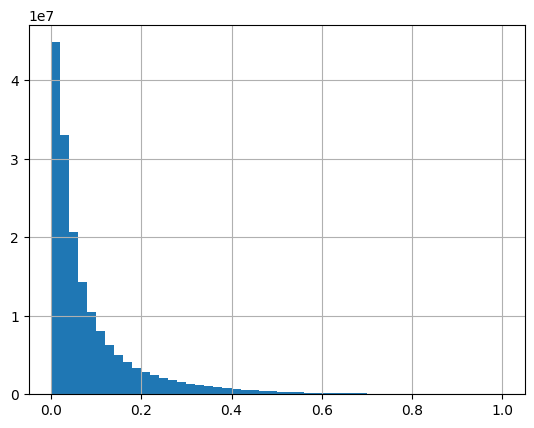

In [12]:
X_full['Random Forest_n1000 probabilities'].hist(bins=50)

<Axes: >

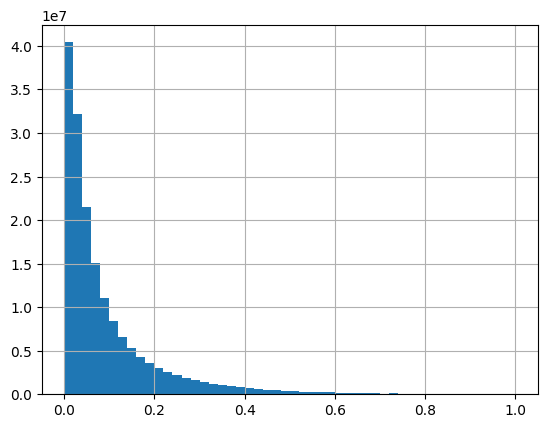

In [40]:
X_full['Random Forest probabilities'].hist(bins=50)

In [50]:
X_full[(X_full['Random Forest probabilities']>=0.99)&(X_full['Same_Complex']==1)]#['Random Forest probabilities']#.hist(bins=50)

,scGPT_bc_embeddings_Cosine_Similarity,scGPT_pancancer_embeddings_Cosine_Similarity,scGPT_CP_embeddings_similarities,scGPT_lung_embeddings_Cosine_Similarity,scGPT_heart_embeddings_Cosine_Similarity,scGPT_brain_embeddings_Cosine_Similarity,scGPT_kidney_embeddings_Cosine_Similarity,scGPT_human_embeddings_Cosine_Similarity,GF-6L30M_HUMANemb_Cosine_Similarity,GF-20L95M_HUMANemb_Cosine_Similarity,GF-12L95M_HUMANemb_Cosine_Similarity,GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity,GF-12L30M_HUMANemb_Cosine_Similarity,Correlation,Same_Complex,GeneAB,Random Forest predictions,Random Forest probabilities
1704555,0.201559,0.408497,0.418062,0.195187,0.041542,0.317344,0.032072,0.417977,0.335313,0.104717,0.769512,0.812227,0.785746,-0.054507,1,PSMD4_PSMD13,1,1.00
1704560,0.202372,0.360924,0.361415,0.206780,0.093870,0.348701,0.094190,0.360967,0.185893,0.133557,0.735777,0.790552,0.772209,0.176834,1,PSMD4_PSMB5,1,1.00
1704561,0.240474,0.458153,0.380647,0.175263,0.078085,0.269674,0.044079,0.380412,0.131553,0.117074,0.779008,0.815456,0.774087,-0.035015,1,PSMD4_PSMB4,1,1.00
1705533,0.257579,0.332245,0.387781,0.121601,0.018557,0.139786,0.047908,0.387813,0.140880,0.105430,0.758090,0.813953,0.759433,0.311855,1,PSMD4_PSMD6,1,1.00
1705578,0.172112,0.325798,0.354748,0.141956,0.089904,0.389848,0.060283,0.355155,0.650441,0.153728,0.769024,0.810652,0.860990,0.453318,1,PSMD4_PSMD7,1,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197710349,0.057965,0.085900,0.117496,0.000634,0.010525,-0.009662,0.004212,0.117083,0.327813,0.072753,0.740908,0.816693,0.812675,0.452124,1,STT3B_DDOST,1,1.00
197712341,0.166522,0.167243,0.261212,0.078116,0.078067,0.090810,0.041713,0.261042,0.254289,0.290924,0.764473,0.794030,0.795802,0.417123,1,STT3B_RPN2,1,1.00
197713488,-0.038323,0.048506,0.134203,-0.049437,0.084647,0.042778,-0.003146,0.133460,0.292791,0.023376,0.710836,0.800634,0.778411,0.402587,1,STT3B_TUSC3,1,0.99
198219119,0.083046,0.080239,0.015837,0.043744,0.013420,-0.139327,-0.022617,0.015780,0.386818,0.203508,0.749740,0.820959,0.830008,0.394768,1,SMARCD2_SMARCA2,1,1.00


<Axes: >

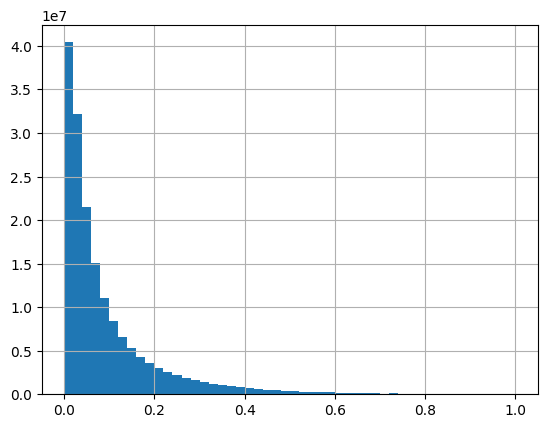

In [55]:
X_full[X_full['Same_Complex']==0]['Random Forest probabilities'].hist(bins=50)

<Axes: >

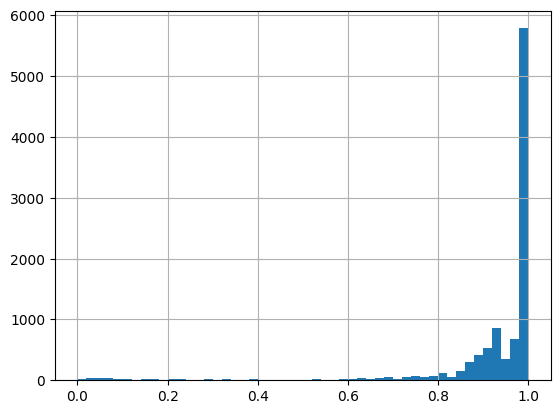

In [56]:
X_full[X_full['Same_Complex']==1]['Random Forest probabilities'].hist(bins=50)

In [53]:
X_full[X_full['Same_Complex']==1]['Random Forest probabilities'].median()

0.99

In [54]:
X_full[X_full['Same_Complex']==1]['Random Forest probabilities'].mean()

0.9212860659773511

In [43]:
def plot_roc_curves(results_dict, y_test):
    plt.figure(figsize=(10, 7))
    for name, result in results_dict.items():
        y_score = None
        if result['probabilities'] is not None:
            y_score = result['probabilities']
        elif result['decision_scores'] is not None:
            y_score = result['decision_scores']
        
        if y_score is not None:
            fpr, tpr, _ = roc_curve(y_test, y_score)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig('full_train_test_roc.png',dpi=300)
    plt.show()

def plot_pr_curves(results_dict, y_test):
    plt.figure(figsize=(10, 7))
    for name, result in results_dict.items():
        y_score = None
        if result['probabilities'] is not None:
            y_score = result['probabilities']
        elif result['decision_scores'] is not None:
            y_score = result['decision_scores']
        
        if y_score is not None:
            precision, recall, _ = precision_recall_curve(y_test, y_score)
            ap = average_precision_score(y_test, y_score)
            plt.plot(recall, precision, label=f"{name} (AP = {ap:.2f})")

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend(loc="lower left")
    plt.tight_layout()
    plt.savefig('full_train_test_auprc.png', dpi=300)
    plt.show()

In [36]:
y_test

1         1
20        1
22        1
28        1
33        1
         ..
651614    0
651626    0
651639    0
651653    0
651688    0
Name: Same_Complex, Length: 14778, dtype: int64

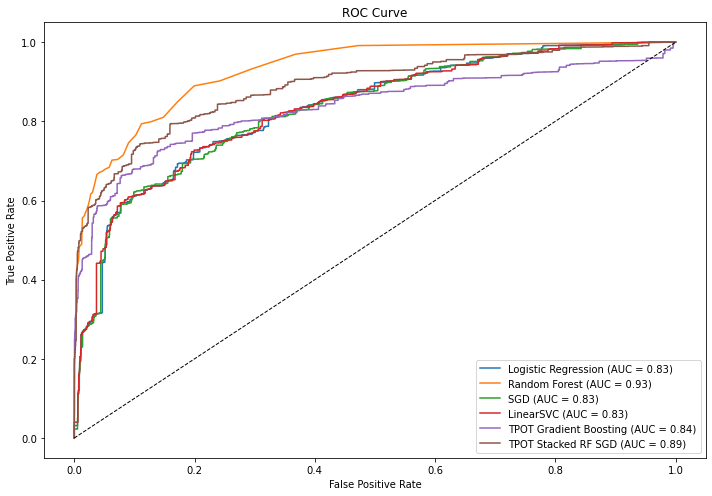

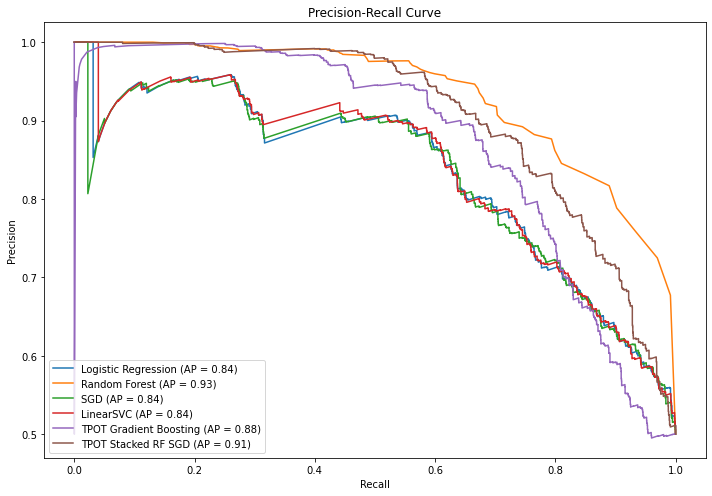

In [44]:
plot_roc_curves(all_model_results, y_test)
plot_pr_curves(all_model_results, y_test)

In [96]:
test_df.columns

Index(['Gene_B', 'complex_id_B', 'Gene_A', 'complex_id_A', 'global_index',
       'scGPT_bc_embeddings_Cosine_Similarity',
       'scGPT_pancancer_embeddings_Cosine_Similarity',
       'scGPT_CP_embeddings_Cosine_Similarity',
       'scGPT_lung_embeddings_Cosine_Similarity',
       'scGPT_heart_embeddings_Cosine_Similarity',
       'scGPT_brain_embeddings_Cosine_Similarity',
       'scGPT_kidney_embeddings_Cosine_Similarity',
       'scGPT_human_embeddings_Cosine_Similarity',
       'GF-6L30M_HUMANemb_Cosine_Similarity',
       'GF-20L95M_HUMANemb_Cosine_Similarity',
       'GF-12L95M_HUMANemb_Cosine_Similarity',
       'GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity',
       'GF-12L30M_HUMANemb_Cosine_Similarity', 'Correlation', 'Gene_1',
       'Gene_2', 'pair_id', 'pairwise_label', 'Same_Complex', 'group_id',
       'Test', 'Logistic Regression predictions',
       'Logistic Regression probabilities',
       'Logistic Regression decision_scores', 'Random Forest predictions',
   

In [109]:
RF = X_full[["GeneAB", "Random Forest probabilities", "Random Forest predictions", "Same_Complex"]].copy()

In [110]:
RF["Prob_Bin"] = pd.cut(RF["Random Forest probabilities"], bins=5, labels=False, include_lowest=True)

In [27]:
cilia_ab["Prob_Bin"] = pd.cut(cilia_ab["Random Forest_n1000 probabilities"], bins=5, labels=False, include_lowest=True)

In [23]:
cilia_ab["Prob_BinQ"] = pd.qcut(cilia_ab["Random Forest_n1000 probabilities"], q=5, labels=False)

In [29]:
cilia_ab['Prob_Bin'].value_counts()

0    10115
1     1692
2      700
3      315
4       79
Name: Prob_Bin, dtype: int64

In [30]:
cilia_ab['Prob_BinQ'].value_counts()

1    2614
0    2611
4    2572
3    2560
2    2544
Name: Prob_BinQ, dtype: int64

In [112]:
rf = pd.concat([RF[RF['Same_Complex']==1], RF[RF['Same_Complex']==0].sample(n=75000)])

In [34]:
# Number of pairs to sample per bin
N = 20

sampled_pairs = (
    cilia_ab.groupby("Prob_Bin")
    .apply(lambda x: x.sample(min(len(x), N), random_state=42))
    .reset_index(drop=True)
)

sampled_pairsQ = (
    cilia_ab.groupby("Prob_BinQ")
    .apply(lambda x: x.sample(min(len(x), N), random_state=42))
    .reset_index(drop=True)
)

In [113]:
# # Number of pairs to sample per bin
# N = 5

# sampled_pairs = (
#     rf.groupby("Prob_Bin")
#     .apply(lambda x: x.sample(min(len(x), N), random_state=42))
#     .reset_index(drop=True)
# )

In [114]:
# # Number of pairs to sample per bin
# N = 5

# sampled_pairs_OG = (
#     RF.groupby("Prob_Bin")
#     .apply(lambda x: x.sample(min(len(x), N), random_state=42))
#     .reset_index(drop=True)
# )

In [32]:
sampled_pairs['Same_Complex'].value_counts()

0    100
Name: Same_Complex, dtype: int64

In [33]:
sampled_pairs

,scGPT_bc_embeddings_similarities,scGPT_pancancer_embeddings_similarities,scGPT_CP_embeddings_similarities,scGPT_lung_embeddings_similarities,scGPT_heart_embeddings_similarities,scGPT_brain_embeddings_similarities,scGPT_kidney_embeddings_similarities,scGPT_human_embeddings_similarities,GF-6L30M_HUMANemb_similarities,GF-20L95M_HUMANemb_similarities,...,Same_Complex,GeneAB,Gene_A,Gene_B,Random Forest_n100 predictions,Random Forest_n100 probabilities,Random Forest_n1000 predictions,Random Forest_n1000 probabilities,Prob_Bin,Prob_BinQ
0,0.115814,0.181455,0.022672,0.088338,-0.034528,0.046344,0.085770,0.022142,0.317596,0.143456,...,0,CFAP161_TNNI3,CFAP161,TNNI3,0,0.07,0,0.024,0,1
1,0.088679,0.103748,0.139417,0.047686,0.005208,0.069960,-0.037132,0.138786,0.495228,0.161593,...,0,MAP6_RFX3,MAP6,RFX3,0,0.15,0,0.184,0,3
2,0.056098,0.202855,0.120605,0.068169,0.143337,0.280954,0.087170,0.121179,0.508192,0.237079,...,0,RSPH9_INSL6,RSPH9,INSL6,0,0.00,0,0.010,0,0
3,-0.058533,0.132451,0.087982,-0.008453,-0.029121,0.172484,-0.055803,0.082221,0.322629,0.132390,...,0,LZTFL1_TPPP3,LZTFL1,TPPP3,0,0.05,0,0.030,0,1
4,0.051483,0.243100,0.128506,0.077265,0.011668,0.068052,0.026016,0.129219,0.494744,0.253026,...,0,CCDC170_NME9,CCDC170,NME9,0,0.04,0,0.071,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.298371,0.505536,0.456860,0.364195,0.124969,0.452954,0.105498,0.465463,0.697303,0.492768,...,0,SNTN_LDLRAD1,SNTN,LDLRAD1,1,0.85,1,0.874,4,4
96,0.255449,0.468910,0.466606,0.345708,0.100043,0.381781,0.003122,0.467871,0.605999,0.435281,...,0,CAPSL_RSPH9,CAPSL,RSPH9,1,0.81,1,0.851,4,4
97,0.251352,0.362033,0.430476,0.257756,0.087682,0.428048,-0.000729,0.431627,0.612333,0.470695,...,0,CFAP126_DYDC2,CFAP126,DYDC2,1,0.80,1,0.805,4,4
98,0.186974,0.450345,0.424645,0.224743,0.109704,0.432221,0.040895,0.425352,0.588267,0.259274,...,0,CFAP45_CFAP300,CFAP45,CFAP300,1,0.90,1,0.859,4,4


In [35]:
from Bio import Entrez, SeqIO
import time

Entrez.email = "brianna.flynn@utexas.edu"  # Required for NCBI Entrez access

def fetch_protein_fasta_from_gene(gene_name, organism="Homo sapiens"):
    try:
        search_handle = Entrez.esearch(
            db="protein",
            term=f"{gene_name}[Gene Name] AND {organism}[Organism]",
            retmode="xml",
            retmax=1
        )
        search_results = Entrez.read(search_handle)
        search_handle.close()

        if not search_results["IdList"]:
            return None

        protein_id = search_results["IdList"][0]
        fetch_handle = Entrez.efetch(
            db="protein",
            id=protein_id,
            rettype="fasta",
            retmode="text"
        )
        fasta_data = fetch_handle.read()
        fetch_handle.close()
        return fasta_data.strip()
    except Exception as e:
        print(f"Error retrieving {gene_name}: {e}")
        return None

gene_to_fasta_dict = {}
for key, val in gene_to_fasta.items():
    lines = val.split('\n')
    sequence = '\n'.join(lines[1:])  # everything after the first line
    gene_to_fasta_dict[key] = f'>{key}\n{sequence}'

import os

output_dir = "colabfold_inputs_cilia"
os.makedirs(output_dir, exist_ok=True)

for idx, row in sampled_pairs.iterrows():
    fasta_a = gene_to_fasta_dict.get(row["Gene_A"])
    fasta_b = gene_to_fasta_dict.get(row["Gene_B"])

    if fasta_a and fasta_b:
        # Extract sequences (remove headers and join lines)
        seq_a = ''.join(fasta_a.strip().splitlines()[1:])
        seq_b = ''.join(fasta_b.strip().splitlines()[1:])

        # Create combined header and combined sequence
        combined_header = f">{row['Gene_A']}_{row['Gene_B']}"
        combined_sequence = f"{seq_a}:\n{seq_b}"

        with open(f"{output_dir}/pair_{idx}_bin{row['Prob_Bin']}.fasta", "w") as f:
            f.write(f"{combined_header}\n{combined_sequence}\n")
    else:
        print(f"Skipping {row['Gene_A']} and {row['Gene_B']} | MISSING sequence")

# Run the test
test_fasta = fetch_protein_fasta_from_gene("SRP68")
print(test_fasta)

>NP_001247432.1 signal recognition particle subunit SRP68 isoform 3 [Homo sapiens]
MLSECRDAIQVVREELKPDQKQRDYILEGEPGKVSNLQYLHSYLTYIKLSTAIKRNENMAKGLQRALLQQ
QPEDDSKRSPRPQDLIRLYDIILQNLVELLQLPGLEEDKAFQKEIGLKTLVFKAYRCFFIAQSYVLVKKW
SEALVLYDRVLKYANEVNSDAGAFKNSLKDLPDVQELITQVRSEKCSLQAAAILDANDAHQTETSSSQVK
DNKPLVERFETFCLDPSLVTKQANLVHFPPGFQPIPCKPLFFDLALNHVAFPPLEDKLEQKTKSGLTGYI
KGIFGFRS


In [118]:
sampled_pairs[['Gene_A', 'Gene_B']] = sampled_pairs['GeneAB'].str.split('_', expand=True)

In [119]:
sampled_pairs.shape

(25, 7)

In [120]:
len(unique_genes)

100

In [36]:
unique_genes = pd.unique(sampled_pairs[["Gene_A", "Gene_B"]].values.ravel())

gene_to_fasta = {}
for gene in unique_genes:
    fasta = fetch_protein_fasta_from_gene(gene)
    if fasta:
        gene_to_fasta[gene] = fasta
    else:
        print(f"No FASTA found for {gene}")
    time.sleep(1)  # be polite to NCBI


In [37]:
#sampled_pairs_OG[['Gene_A', 'Gene_B']] = sampled_pairs_OG['GeneAB'].str.split('_', expand=True)
unique_genes = pd.unique(sampled_pairsQ[["Gene_A", "Gene_B"]].values.ravel())

gene_to_fastaQ = {}
for gene in unique_genes:
    fasta = fetch_protein_fasta_from_gene(gene)
    if fasta:
        gene_to_fastaQ[gene] = fasta
    else:
        print(f"No FASTA found for {gene}")
    time.sleep(1)  # be polite to NCBI


In [38]:
gene_to_fasta_dict = {}
for key, val in gene_to_fasta.items():
    lines = val.split('\n')
    sequence = '\n'.join(lines[1:])  # everything after the first line
    gene_to_fasta_dict[key] = f'>{key}\n{sequence}'

gene_to_fasta_dict

{'CFAP161': '>CFAP161\nMAQNVYGPGVRIGNWNEDVYLEEELMKDFLEKRDKGKLLIQRSRRLKQNLLRPMQLSVTEDGYIHYGDKV\nMLVNPDDPDTEADVFLRGDLSLCMTPDEIQSHLKDELEVPCGLSAVQAKTPIGRNTFIILSVHRDATGQV\nLRYGQDFCLGITGGFDNKMLYLSSDHRTLLKSSKRSWLQEVYLTDEVSHVNCWQAAFPDPQLRLEYEGFP\nVPYPLFSL',
 'TNNI3': '>TNNI3\nMADGSSDAAREPRPAPAPIRRRSSNYRAYATEPHAKKKSKISASRKLQLKTLLLQIAKQELEREAEERRG\nEKGRALSTRCQPLELAGLGFAELQDLCRQLHARVDKVDEERYDIEAKVTKNITEIADLTQKIFDLRGKFK\nRPTLRRVRISADAMMQALLGARAKESLDLRAHLKQVKKEDTEKENREVGDWRKNIDALSGMEGRKKKFES',
 'MAP6': '>MAP6\nMAWPCITRACCIARFWNQLDKADIAVPLVFTKYSEATEHPGAPPQPPPPQQQAQPALAPPSARAVAIETQ\nPAQGELDAVARATGPAPGPTGEREPAAGPGRSGPGPGLGSGSTSGPADSVMRQDYRAWKVQRPEPSCRPR\nSEYQPSDAPFERETQYQKDFRAWPLPRRGDHPWIPKPVQISAASQASAPILGAPKRRPQSQERWPVQAAA\nEAREQEAAPGGAGGLAAGKASGADERDTRRKAGPAWIVRRAEGLGHEQTPLPAAQAQVQATGPEAGRGRA\nAADALNRQIREEVASAVSSSYRNEFRAWTDIKPVKPIKAKPQYKPPDDKMVHETSYSAQFKGEASKPTTA\nDNKVIDRRRIRSLYSEPFKEPPKVEKPSVQSSKPKKTSASHKPTRKAKDKQAVSGQAAKKKSAEGPSTTK\nPDDKEQSKEMNNKLAEAKESLAQPVSDSSKTQGPVATEPDKDQGSVVPGLLKGQGPMVQEPLKKQ

In [43]:
gene_to_fastaQ_dict = {}
for key, val in gene_to_fastaQ.items():
    lines = val.split('\n')
    sequence = '\n'.join(lines[1:])  # everything after the first line
    gene_to_fastaQ_dict[key] = f'>{key}\n{sequence}'

In [44]:
gene_to_fastaQ_dict

{'GSTM3': '>GSTM3\nMSCESSMVLGYWDIRGLAHAIRLLLEFTDTSYEEKRYTCGEAPDYDRSQWLDVKFKLDLDFPNLPYLLDG\nKNKITQSNAILRYIARKHNMCGETEEEKIRVDIIENQVMDFRTQLIRLCYSSDHEKLKPQYLEELPGQLK\nQFSMFLGKFSWFAGEKLTFVDFLTYDILDQNRIFDPKCLDEFPNLKAFMCRFEALEKIAAYLQSDQFCKM\nPINNKMAQWGNKPVC',
 'RSPH4A': '>RSPH4A\nMEDSTSPKQEKENQEELGETRRPWEGKTAASPQYSEPESSEPLEAKQGPETGRQSRSSRPWSPQSRAKTP\nLGGPAGPETSSPAPVSPREPSSSPSPLAPARQDLAAPPQSDRTTSVIPEAGTPYPDPLEQSSDKRESTPH\nHTSQSEGNTFQQSQQPKPHLCGRRDVSYNNAKQKELRFDVFQEEDSNSDYDLQQPAPGGSEVAPSMLEIT\nIQNAKAYLLKTSSNSGFNLYDHLSNMLTKILNERPENAVDIFENISQDVKMAHFSKKFDALQNENELLPT\nYEIAEKQKALFLQGHLEGVDQELEDEIAENALPNVMESAFYFEQAGVGLGTDETYRIFLALKQLTDTHPI\nQRCRFWGKILGLEMNYIVAEVEFREGEDEEEVEEEDVAEERDNGESEAHEDEEDELPKSFYKAPQAIPKE\nESRTGANKYVYFVCNEPGRPWVKLPPVIPAQIVIARKIKKFFTGRLDAPIISYPPFPGNESNYLRAQIAR\nISAGTHVSPLGFYQFGEEEGEEEEEAEGGRNSFEENPDFEGIQVIDLVESLSNWVHHVQHILSQGRCNWF\nNSIQKNEEEEEEEDEEKDDSDYIEQEVGLPLLTPISEDLEIQNIPPWTTRLSSNLIPQYAIAVLQSNLWP\nGAYAFSNGKKFENFYIGWGHKYSPDNYTPPVPPPVYQEYPSGPEITEMDDPSVEEEQAFRAAQEAVLLAA\nENEESE

In [41]:
import os

output_dir = "colabfold_inputs_cilia"
os.makedirs(output_dir, exist_ok=True)

for idx, row in sampled_pairs.iterrows():
    fasta_a = gene_to_fasta_dict.get(row["Gene_A"])
    fasta_b = gene_to_fasta_dict.get(row["Gene_B"])

    if fasta_a and fasta_b:
        # Extract sequences (remove headers and join lines)
        seq_a = ''.join(fasta_a.strip().splitlines()[1:])
        seq_b = ''.join(fasta_b.strip().splitlines()[1:])

        # Create combined header and combined sequence
        combined_header = f">{row['Gene_A']}_{row['Gene_B']}"
        combined_sequence = f"{seq_a}:\n{seq_b}"

        with open(f"{output_dir}/pair_{idx}_bin{row['Prob_Bin']}.fasta", "w") as f:
            f.write(f"{combined_header}\n{combined_sequence}\n")
    else:
        print(f"Skipping {row['Gene_A']} and {row['Gene_B']} | MISSING sequence")

In [46]:
import os

output_dir = "colabfold_inputs_cilia_quintiles"
os.makedirs(output_dir, exist_ok=True)

for idx, row in sampled_pairsQ.iterrows():
    fasta_a = gene_to_fastaQ_dict.get(row["Gene_A"])
    fasta_b = gene_to_fastaQ_dict.get(row["Gene_B"])
    
    if fasta_a and fasta_b:
        # Extract sequences (remove headers and join lines)
        seq_a = ''.join(fasta_a.strip().splitlines()[1:])
        seq_b = ''.join(fasta_b.strip().splitlines()[1:])

        # Create combined header and combined sequence
        combined_header = f">{row['Gene_A']}_{row['Gene_B']}"
        combined_sequence = f"{seq_a}:\n{seq_b}"

        with open(f"{output_dir}/pair_{idx}_bin{row['Prob_Bin']}.fasta", "w") as f:
            f.write(f"{combined_header}\n{combined_sequence}\n")
    else:
        print(f"Skipping {row['Gene_A']} and {row['Gene_B']} | MISSING sequence")

In [123]:
test_df.drop(columns=['Gene_1', 'Gene_2', 'Test'], inplace=True)

In [124]:
test_df.to_csv('test_dataset_with_model_probs_preds_decision-scores.csv',index=False)

In [126]:
RF.to_csv('binned_randomforest_probs_decision-scores.csv', index=False)

In [99]:
X_full[['GeneAB', 'Random Forest probabilities', 'Random Forest predictions']].sample(n=1711151).to_csv('TESTSAMPLESIZE.csv')

In [97]:
171115111 / 100

1711151.11

In [100]:
X_full[X_full['Correlation']!=1.0]

,scGPT_bc_embeddings_Cosine_Similarity,scGPT_pancancer_embeddings_Cosine_Similarity,scGPT_CP_embeddings_similarities,scGPT_lung_embeddings_Cosine_Similarity,scGPT_heart_embeddings_Cosine_Similarity,scGPT_brain_embeddings_Cosine_Similarity,scGPT_kidney_embeddings_Cosine_Similarity,scGPT_human_embeddings_Cosine_Similarity,GF-6L30M_HUMANemb_Cosine_Similarity,GF-20L95M_HUMANemb_Cosine_Similarity,GF-12L95M_HUMANemb_Cosine_Similarity,GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity,GF-12L30M_HUMANemb_Cosine_Similarity,Correlation,Same_Complex,GeneAB,Random Forest predictions,Random Forest probabilities
949027,0.063506,0.135321,0.234719,0.125535,0.135128,0.383622,0.079211,0.235762,0.549340,0.188242,0.876189,0.879979,0.841622,0.116782,0,PYDC1_PYCR3,0,0.07
949028,-0.056565,0.079216,0.161900,-0.021724,0.012198,0.222155,-0.051431,0.163293,0.393251,0.173845,0.779322,0.793168,0.762249,0.126619,0,PYDC1_BAG3,0,0.00
949029,0.116124,0.308463,0.226987,0.087753,0.112959,0.410780,0.055358,0.228007,0.585679,0.394791,0.899145,0.883349,0.825831,0.230485,0,PYDC1_PXT1,0,0.06
949030,0.016978,0.058653,-0.002022,-0.049605,-0.008472,0.003432,-0.041763,-0.000696,0.347202,0.097802,0.738388,0.803293,0.789023,0.220536,0,PYDC1_PXK,0,0.03
949031,-0.031810,0.006320,-0.130927,-0.091508,-0.121315,-0.185753,-0.089556,-0.130848,0.347644,0.157392,0.742027,0.780049,0.778803,0.246139,0,PYDC1_PUM2,0,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200776377,-0.110339,0.086440,0.089373,0.034659,0.114352,0.038629,0.056565,0.094981,0.315341,0.108741,0.789531,0.840061,0.791421,0.154140,0,BCAT1_TMPRSS3,0,0.14
200776434,-0.034737,0.127792,0.063827,-0.004790,0.008433,0.048624,-0.031635,0.063980,0.364127,0.127619,0.752806,0.793549,0.798082,0.319412,0,BCAT1_TPP1,0,0.06
200776892,-0.001384,-0.010163,-0.005988,0.030453,0.046065,-0.061751,0.049211,-0.005287,0.405193,0.131710,0.824809,0.852520,0.815836,0.349904,0,BCAT1_ZNF20,0,0.03
200776899,-0.035554,-0.046015,0.062382,-0.033491,0.045953,0.009507,0.009540,0.062917,0.283855,0.194667,0.821454,0.861418,0.817727,0.339114,0,BCAT1_ZNF230,0,0.16


In [10]:
X_full.drop(columns=['Same_Complex'],inplace=True)

In [11]:
X_full.columns

Index(['scGPT_bc_embeddings_Cosine_Similarity',
       'scGPT_pancancer_embeddings_Cosine_Similarity',
       'scGPT_CP_embeddings_similarities',
       'scGPT_lung_embeddings_Cosine_Similarity',
       'scGPT_heart_embeddings_Cosine_Similarity',
       'scGPT_brain_embeddings_Cosine_Similarity',
       'scGPT_kidney_embeddings_Cosine_Similarity',
       'scGPT_human_embeddings_Cosine_Similarity',
       'GF-6L30M_HUMANemb_Cosine_Similarity',
       'GF-20L95M_HUMANemb_Cosine_Similarity',
       'GF-12L95M_HUMANemb_Cosine_Similarity',
       'GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity',
       'GF-12L30M_HUMANemb_Cosine_Similarity', 'Correlation', 'GeneAB',
       'Random Forest predictions', 'Random Forest probabilities', 'Prob_Bin'],
      dtype='object')

In [6]:
X_full["Prob_Bin"] = pd.cut(X_full["Random Forest probabilities"], bins=5, labels=False, include_lowest=True)

In [14]:
df_init = X_full[X_full['Prob_Bin']==0]
for i in range(1, 5):
    
    df = X_full[X_full['Prob_Bin']==i].sample(n=100000, random_state=42)
    df_init = pd.concat([df_init, df])
    #df.sample(n=100000, random_state = 42).to_csv(f'full_dataset_probs_preds_100ksample_prob-bin-{i}.csv', index=False)

df_init.to_csv('full_dataset_probs_preds_500ksample_5-prob-bins.csv', index=False)

KeyboardInterrupt: 

In [134]:
X_full[X_full['Prob_Bin']==10]

,scGPT_bc_embeddings_Cosine_Similarity,scGPT_pancancer_embeddings_Cosine_Similarity,scGPT_CP_embeddings_similarities,scGPT_lung_embeddings_Cosine_Similarity,scGPT_heart_embeddings_Cosine_Similarity,scGPT_brain_embeddings_Cosine_Similarity,scGPT_kidney_embeddings_Cosine_Similarity,scGPT_human_embeddings_Cosine_Similarity,GF-6L30M_HUMANemb_Cosine_Similarity,GF-20L95M_HUMANemb_Cosine_Similarity,GF-12L95M_HUMANemb_Cosine_Similarity,GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity,GF-12L30M_HUMANemb_Cosine_Similarity,Correlation,Same_Complex,GeneAB,Random Forest predictions,Random Forest probabilities,Prob_Bin


In [16]:
X_full[['Gene_A', 'Gene_B']] = X_full['GeneAB'].str.split('_', expand=True)

In [14]:
cilia = pd.read_csv('ciliary_gene_a_b.csv')

In [15]:
cilia_a = X_full.merge(cilia[['Gene_A']], on = 'Gene_A')

In [16]:
cilia_ab = cilia_a.merge(cilia[['Gene_B']], on = 'Gene_B')

In [17]:
cilia_ab.to_csv('cilia_humap_features_NEW.csv', index=False)

In [24]:
cmplx = pd.read_pickle('/home/ubuntu/complex_label.pkl')

In [26]:
cilia_ab_c = cilia_ab.merge(cmplx, on = 'GeneAB')

In [28]:
cilia_ab_c.to_csv('cilia_humap_features.csv', index=False)

In [19]:
cilia_ab[cilia_ab['Same_Complex']==1]

,scGPT_bc_embeddings_similarities,scGPT_pancancer_embeddings_similarities,scGPT_CP_embeddings_similarities,scGPT_lung_embeddings_similarities,scGPT_heart_embeddings_similarities,scGPT_brain_embeddings_similarities,scGPT_kidney_embeddings_similarities,scGPT_human_embeddings_similarities,GF-6L30M_HUMANemb_similarities,GF-20L95M_HUMANemb_similarities,...,GF-12L30M_HUMANemb_similarities,Correlation,Same_Complex,GeneAB,Gene_A,Gene_B,Random Forest_n100 predictions,Random Forest_n100 probabilities,Random Forest_n1000 predictions,Random Forest_n1000 probabilities
1137,0.019524,0.342389,0.101750,0.122353,0.147931,-0.028862,0.108790,0.102359,0.534207,0.255084,...,0.597732,0.398266,1,NME5_DYDC1,NME5,DYDC1,1,1.00,1,1.000
1192,0.023961,0.313240,0.284571,0.024688,0.136607,0.399746,0.102279,0.285559,0.499745,0.306415,...,0.547782,0.219997,1,RSPH4A_DYDC1,RSPH4A,DYDC1,1,0.98,1,0.984
1193,0.075956,0.369118,0.295542,0.011553,0.115773,0.198574,0.064370,0.296469,0.524937,0.323535,...,0.607868,0.396970,1,RSPH9_DYDC1,RSPH9,DYDC1,1,1.00,1,1.000
6457,0.320568,0.458499,0.146392,0.213933,0.116098,-0.015348,0.082282,0.147346,0.540394,0.195722,...,0.730992,0.287408,1,RSPH4A_NME5,RSPH4A,NME5,1,1.00,1,0.992
6458,0.392687,0.439287,0.244231,0.290778,0.146491,0.009836,0.084479,0.244780,0.537613,0.456620,...,0.833776,0.318669,1,RSPH9_NME5,RSPH9,NME5,1,1.00,1,1.000
11794,0.299345,0.409764,0.324771,0.219217,0.103579,0.264314,0.097743,0.326032,0.549215,0.265855,...,0.792104,0.211387,1,RSPH4A_RSPH9,RSPH4A,RSPH9,1,0.98,1,0.992
12488,0.136145,0.352463,0.317294,0.108980,0.112843,0.280344,0.067156,0.317544,0.554594,0.253898,...,0.899929,0.243697,1,TCTN2_TMEM231,TCTN2,TMEM231,1,0.88,1,0.911


In [32]:
cilia_ab_c[cilia_ab_c['Same_Complex']==1]

,scGPT_bc_embeddings_Cosine_Similarity,scGPT_pancancer_embeddings_Cosine_Similarity,scGPT_CP_embeddings_similarities,scGPT_lung_embeddings_Cosine_Similarity,scGPT_heart_embeddings_Cosine_Similarity,scGPT_brain_embeddings_Cosine_Similarity,scGPT_kidney_embeddings_Cosine_Similarity,scGPT_human_embeddings_Cosine_Similarity,GF-6L30M_HUMANemb_Cosine_Similarity,GF-20L95M_HUMANemb_Cosine_Similarity,...,GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity,GF-12L30M_HUMANemb_Cosine_Similarity,Correlation,GeneAB,Random Forest predictions,Random Forest probabilities,Prob_Bin,Gene_A,Gene_B,Same_Complex
1721,0.299345,0.409764,0.324771,0.219217,0.103579,0.264314,0.097743,0.326032,0.549215,0.265855,...,0.887978,0.792104,0.211387,RSPH4A_RSPH9,1,1.00,4,RSPH4A,RSPH9,1
2230,0.136145,0.352463,0.317294,0.108980,0.112843,0.280344,0.067156,0.317544,0.554594,0.253898,...,0.921747,0.899929,0.243697,TCTN2_TMEM231,1,0.98,4,TCTN2,TMEM231,1


<Axes: >

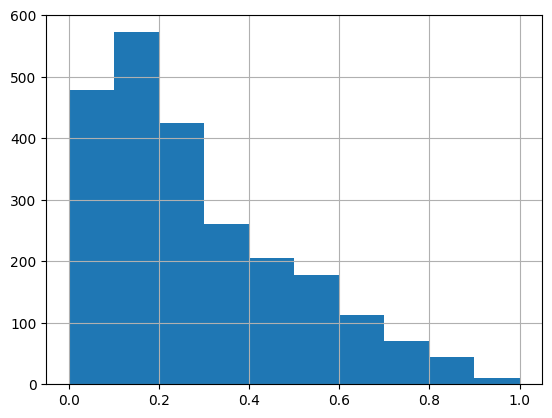

In [33]:
cilia_ab_c['Random Forest probabilities'].hist()

In [43]:
cilia_ab_c[cilia_ab_c['Random Forest probabilities']>=0.9]#.to_csv('top_ciliary_probabilties.csv')

,scGPT_bc_embeddings_Cosine_Similarity,scGPT_pancancer_embeddings_Cosine_Similarity,scGPT_CP_embeddings_similarities,scGPT_lung_embeddings_Cosine_Similarity,scGPT_heart_embeddings_Cosine_Similarity,scGPT_brain_embeddings_Cosine_Similarity,scGPT_kidney_embeddings_Cosine_Similarity,scGPT_human_embeddings_Cosine_Similarity,GF-6L30M_HUMANemb_Cosine_Similarity,GF-20L95M_HUMANemb_Cosine_Similarity,...,GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity,GF-12L30M_HUMANemb_Cosine_Similarity,Correlation,GeneAB,Random Forest predictions,Random Forest probabilities,Prob_Bin,Gene_A,Gene_B,Same_Complex
131,0.280065,0.457387,0.344226,0.278140,0.105596,0.267543,0.048958,0.345802,0.602991,0.265112,...,0.893911,0.820210,0.182126,DNAH7_ARMC3,1,0.92,4,DNAH7,ARMC3,0
1017,0.209807,0.400355,0.350241,0.225984,0.098923,0.292140,0.080789,0.354788,0.592747,0.217169,...,0.883005,0.884360,0.257294,DNAH7_SPEF2,1,0.90,4,DNAH7,SPEF2,0
1181,0.186974,0.450345,0.424645,0.224743,0.109704,0.432221,0.040895,0.425352,0.588267,0.259274,...,0.876482,0.777081,0.340529,CFAP45_CFAP300,1,0.91,4,CFAP45,CFAP300,0
1344,0.325937,0.384749,0.429546,0.317125,0.165360,0.440951,0.126227,0.431846,0.594053,0.400239,...,0.879826,0.797378,0.304620,CIBAR2_DYDC2,1,0.90,4,CIBAR2,DYDC2,0
1404,0.208657,0.440549,0.380993,0.225661,0.109810,0.356503,0.055337,0.381691,0.562834,0.259723,...,0.864765,0.747805,0.104531,CFAP300_DYNLT4,1,0.96,4,CFAP300,DYNLT4,0
1411,0.198581,0.358456,0.375841,0.244173,0.112051,0.219069,0.060698,0.376790,0.384487,0.231769,...,0.824420,0.764203,0.126221,DPCD_DYNLT4,1,0.90,4,DPCD,DYNLT4,0
1423,0.256492,0.433497,0.385070,0.273415,0.143365,0.287377,0.059905,0.385902,0.549363,0.305910,...,0.864525,0.786964,0.395272,RSPH9_DYNLT4,1,0.92,4,RSPH9,DYNLT4,0
1583,0.215785,0.347286,0.374271,0.266259,0.107773,0.323266,0.037381,0.374705,0.534527,0.333650,...,0.877169,0.764525,0.552746,CFAP45_SPAG6,1,0.91,4,CFAP45,SPAG6,0
1721,0.299345,0.409764,0.324771,0.219217,0.103579,0.264314,0.097743,0.326032,0.549215,0.265855,...,0.887978,0.792104,0.211387,RSPH4A_RSPH9,1,1.00,4,RSPH4A,RSPH9,1
2230,0.136145,0.352463,0.317294,0.108980,0.112843,0.280344,0.067156,0.317544,0.554594,0.253898,...,0.921747,0.899929,0.243697,TCTN2_TMEM231,1,0.98,4,TCTN2,TMEM231,1


In [44]:
cilia_ab_c[cilia_ab_c['Random Forest probabilities']<=0.00]#.to_csv('bottom_ciliary_probabilities.csv')

,scGPT_bc_embeddings_Cosine_Similarity,scGPT_pancancer_embeddings_Cosine_Similarity,scGPT_CP_embeddings_similarities,scGPT_lung_embeddings_Cosine_Similarity,scGPT_heart_embeddings_Cosine_Similarity,scGPT_brain_embeddings_Cosine_Similarity,scGPT_kidney_embeddings_Cosine_Similarity,scGPT_human_embeddings_Cosine_Similarity,GF-6L30M_HUMANemb_Cosine_Similarity,GF-20L95M_HUMANemb_Cosine_Similarity,...,GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity,GF-12L30M_HUMANemb_Cosine_Similarity,Correlation,GeneAB,Random Forest predictions,Random Forest probabilities,Prob_Bin,Gene_A,Gene_B,Same_Complex
327,0.018519,0.160493,0.036165,0.008527,0.015626,0.009171,-0.029753,0.036869,0.352743,0.120364,...,0.803138,0.712109,0.376991,C1orf87_CFAP298,0,0.0,0,C1orf87,CFAP298,0
351,-0.020388,0.161613,0.052781,0.069227,0.071969,0.112507,0.060433,0.052947,0.330282,0.168461,...,0.871615,0.779149,0.058686,NME9_CFAP298,0,0.0,0,NME9,CFAP298,0
900,0.109368,0.207321,0.060637,0.115682,0.040896,0.010421,0.017447,0.054397,0.412702,0.228846,...,0.848155,0.812411,0.413137,C7orf57_CDHR3,0,0.0,0,C7orf57,CDHR3,0
1016,-0.000481,0.270013,0.058789,0.092928,0.104051,-0.035231,0.056334,0.059317,0.495326,0.238916,...,0.851549,0.739738,0.504541,GAS2L2_SPEF2,0,0.0,0,GAS2L2,SPEF2,0
1490,0.108524,0.129088,0.032387,0.076643,0.005990,-0.008882,-0.031929,0.032741,0.376803,0.214399,...,0.828711,0.749206,0.398197,TTC23L_RFX3,0,0.0,0,TTC23L,RFX3,0
1652,-0.002709,0.296664,0.123984,0.032127,0.022442,0.058092,-0.006794,0.124872,0.653386,0.289308,...,0.859852,0.722583,0.358654,GAS2L2_SPAG17,0,0.0,0,GAS2L2,SPAG17,0
1901,0.088052,0.301318,-0.005400,0.046020,-0.000714,0.030132,-0.045118,-0.006626,0.465439,0.178628,...,0.841710,0.677836,-0.043601,CDHR3_TEKT4,0,0.0,0,CDHR3,TEKT4,0
1954,0.024450,0.063235,0.061013,-0.034428,0.013860,0.143567,-0.019773,0.058021,0.345693,0.243767,...,0.825804,0.762758,0.126442,ENO4_TPPP3,0,0.0,0,ENO4,TPPP3,0
1974,0.062120,0.190157,0.180763,0.071984,0.025940,0.247607,-0.005092,0.178541,0.435752,0.282280,...,0.835645,0.772723,0.041837,NEK5_TPPP3,0,0.0,0,NEK5,TPPP3,0
2316,-0.002740,0.334227,0.060353,0.054462,0.071801,-0.025880,0.023754,0.062888,0.631112,0.274459,...,0.875413,0.762721,0.301034,GAS2L2_DNAH7,0,0.0,0,GAS2L2,DNAH7,0
